<b>Autonecoder tutorial:</b>
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html
</br>
<b>Deep Clustering with Convolutional Autoencoders paper:</b>
https://xifengguo.github.io/papers/ICONIP17-DCEC.pdf

In [12]:
# directory name of dataset
DATASET_NAME = "music_audio_benchmark"

# feature name (spectrogram, mel_spectrogram, chromagram)
FEATURE_NAME = "spectrogram"

# latent dim for ConvAE
LATENT_DIM = [128, 256, 512, 1024, 2048, 4096]

# epochs for ConvAE pretraining
EPOCHS_AE = 50

# epochs for DCEC training
EPOCHS_DCEC = 100

In [13]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torch.utils.data import Dataset

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import torchvision
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Import from file (fix num_workers problem)
from FeaturesDataset import FeaturesDataset
from FeaturesDataset import load_img
from FeaturesDataset import WIDTH
from FeaturesDataset import HEIGHT

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Properly utilize Tensor Cores
torch.set_float32_matmul_precision("high")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

CHECKPOINT_PATH = os.path.join("..", 'checkpoints')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Seed set to 42


Device: cuda:0


In [14]:
checkpoints_path = f"{CHECKPOINT_PATH}/{DATASET_NAME}"
if not os.path.exists(checkpoints_path):
    print("CREATING CHECKPOINT FOLDER FOR MODELS")
    os.makedirs(checkpoints_path)

## Load data

In [35]:
def load_numpy_array(path):
    return np.load(path)

def get_first_n_images(dataset, n):
    return torch.stack([dataset[i][0] for i in range(n)], dim=0)

### Path to images

In [19]:
project_dir = os.path.relpath(os.path.join(os.getcwd(), os.pardir))
features_dir = os.path.join(project_dir, "features")

#TODO: argument for dataset folder name
dataset_dir = os.path.join(features_dir, DATASET_NAME)

csv_file_name = "features.csv"
csv_file_path = os.path.join(dataset_dir, csv_file_name)

df = pd.read_csv(csv_file_path)
path_columns = [
    'name', 'label',
    'path_spectrogram_arr', 'path_mel_spectrogram_arr', 'path_chromagram_arr', 'path_mfccs_arr', 'path_mfccs_without_0_arr', 
    'path_spectrogram_img',  'path_mel_spectrogram_img', 'path_chromagram_img', 'path_mfccs_img', 'path_mfccs_without_0_img' 
]

df_paths = df[path_columns].copy()
feature = f'path_{FEATURE_NAME}_img'

features_paths = df_paths[feature].values
labels = df['label'].tolist()

In [20]:
WIDTH

64

### Train and validation datasets

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

feature_dataset = FeaturesDataset(features_paths, labels, transform=transform)

train_length = int(0.8 * len(feature_dataset))
val_length = len(feature_dataset) - train_length
train_set, val_set = torch.utils.data.random_split(feature_dataset, [train_length, val_length])

train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=8, persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=True, num_workers=8, persistent_workers=True)

### Validate if images are correctly loaded

In [22]:
def compare_imgs(img1, img2, title=""):
    loss = F.mse_loss(img1, img2, reduction="sum")
    
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, value_range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(12, 6))
    plt.title(f"{title}, Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

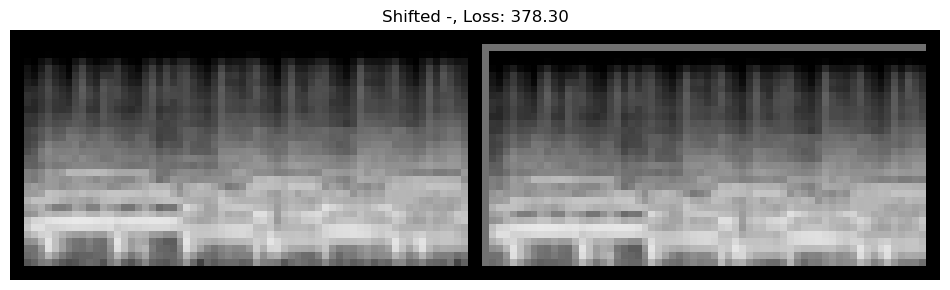

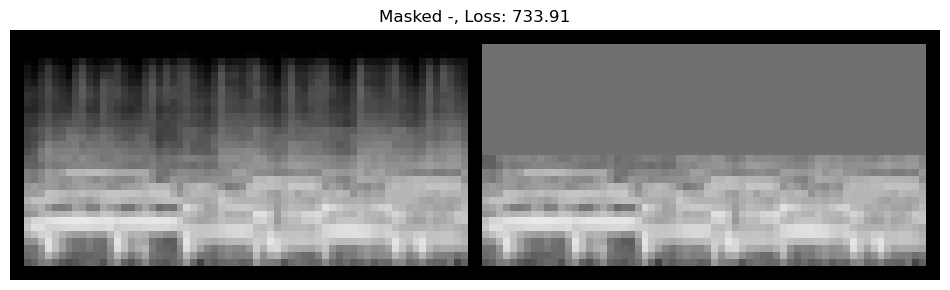

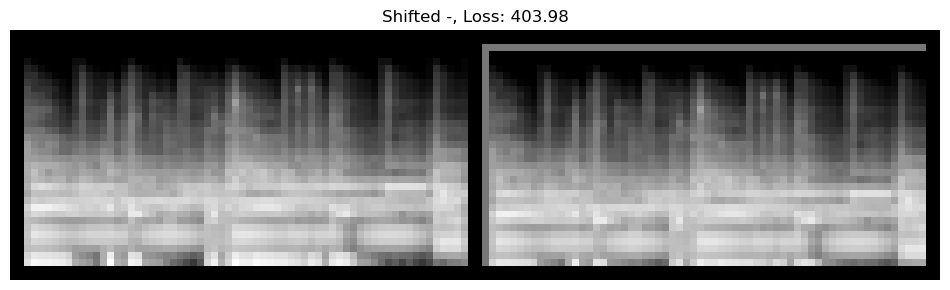

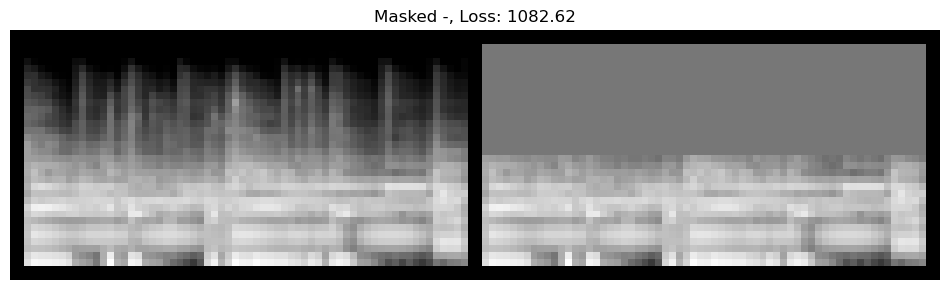

In [23]:
for i in range(2):
    # Load example image
    img, _ = feature_dataset[i]
    img_mean = img.mean(dim=[1, 2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## Autoencoder

In [252]:
class Encoder(nn.Module):
    """
    Inputs: 
        - num_input_channels : Number of input channels of the image.
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - activation_fn : Activation function used throughout the encoder network
        - width : Image width.
        - height : Image height.
    """
    def __init__(
        self,
        num_input_channels: int,
        base_channel_size: int,
        latent_dim: int,
        width: int,
        height: int,
        activation_fn: object = nn.GELU
    ): 

        super().__init__()
        self.width = width
        self.height = height
        
        if width % 8 == 0:
            pad3 = 2
        else:
            pad3 = 0
        
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=num_input_channels, out_channels=base_channel_size, kernel_size=5, stride=2, padding=2
            ),  # 28x28 -> 14x14
            activation_fn(),
            
            nn.Conv2d(
                in_channels=base_channel_size, out_channels=2 * base_channel_size, kernel_size=5, stride=2, padding=2
            ),  # 14x14 -> 7x7
            activation_fn(),
            
            nn.Conv2d(
                in_channels=2 * base_channel_size, out_channels=4 * base_channel_size, kernel_size=3, stride=2, padding=pad3
            ),  # 7x7 -> 3x3
            activation_fn(),
            
            nn.Flatten(),
            nn.Linear(in_features=4 * base_channel_size * (width // 8) * (height // 8), out_features=latent_dim),
            activation_fn()
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [253]:
class Decoder(nn.Module):
    """
    Inputs: 
        - num_input_channels : Number of input channels of the image.
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - activation_fn : Activation function used throughout the encoder network
        - width : Image width.
        - height : Image height.
    """
    def __init__(
        self,
        num_input_channels: int,
        base_channel_size: int,
        latent_dim: int,
        width: int,
        height: int,
        activation_fn: object = nn.GELU
    ): 

        super().__init__()
        self.width = width
        self.height = height
        
        if width % 8 == 0:
            pad3 = 2
        else:
            pad3 = 0
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=4 * base_channel_size * (width // 8) * (height // 8)),
        )
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=4 * base_channel_size, 
                out_channels=2 * base_channel_size, 
                kernel_size=3, 
                stride=2, 
                padding=pad3, 
            ),  # 3x3 -> 7x7
            activation_fn(),
            
            nn.ConvTranspose2d(
                in_channels=2 * base_channel_size, 
                out_channels=base_channel_size, 
                kernel_size=5,
                stride=2, 
                padding=2,
                output_padding=1
            ),  # 7x7 -> 14x14
            activation_fn(),
            
            nn.ConvTranspose2d(
                in_channels=base_channel_size, 
                out_channels=num_input_channels, 
                kernel_size=5, 
                stride=2, 
                padding=2,
                output_padding=1
            ) # 14x14 -> 28x28
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, (self.height // 8), (self.width // 8)) # reshape tensor (spatial dimensions set to 16x8)
        x = self.net(x)
        return x

In [262]:
class Autoencoder(pl.LightningModule):
    """
    Inputs: 
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - encoder_class : Encoder
        - decoder_class : Decoder
        - num_input_channels : Number of input channels of the image.
        - width : Image width.
        - height : Image height.
    """
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        width: int = 28,
        height: int = 28
    ):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Save hyperparameters
        self.save_hyperparameters()
        
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim, width, height)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim, width, height)
        
        # Example input array needed for visualizing the graph of network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    """
    The forward function takes in an image and returns the reconstructed image
    """
    def forward(self, x):
        z = self.encoder(x)
#         print(f"ENCODER OUTPUT SHAPE: {z.shape}")
        x_hat = self.decoder(z)
#         print(f"DECODER OUTPUT SHAPE: {x_hat.shape}")
        return x_hat
    
    """
    Given a batch of images, this function returns the reconstruction loss (MSE in our case)
    """
    def _get_recontruction_loss(self, batch):
        x, _ = batch
        x_hat = self.forward(x)
        
        if x.shape != x_hat.shape:
            raise ValueError(f"Shapes of x and x_hat do not match: {x.shape} vs {x_hat.shape}")
        
        loss = F.mse_loss(x, x_hat, reduction="mean")
#         print(f"1 loss = {loss}")
        
        # TODO: check if this sum is necessery
#         loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.2,
            patience=20,
            min_lr=5e-5
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss"
        }
    
    def training_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('val_loss', loss)
        
    def test_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('test_loss', loss)

In [260]:
autoencoder_arch = Autoencoder(num_input_channels=1, base_channel_size=32, latent_dim=10, width=28, height=28)
print(autoencoder_arch)

Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): GELU(approximate='none')
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (5): GELU(approximate='none')
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=1152, out_features=10, bias=True)
      (8): GELU(approximate='none')
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=10, out_features=1152, bias=True)
    )
    (net): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): GELU(approximate='none')
      (2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (3): GELU(approximate='none')
      (4): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), pad

In [28]:
class GenerateCallback(pl.Callback):
    def __init__(self, imgs, every_n_epochs=5):
        super().__init__()
        self.imgs = imgs # Images to reconstruct
        self.every_n_epochs = every_n_epochs
        
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            imgs = self.imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                
                if isinstance(pl_module, DCEC):
                    _, reconst_imgs, _ = pl_module(imgs)
                else:
                    reconst_imgs = pl_module(imgs)

                    pl_module.train()
            
            images = torch.stack([imgs, reconst_imgs], dim=1).flatten(0, 1)
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True, value_range=(-1, 1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [29]:
def get_model_checkpoint(pretrained_dir, model_name, dir_name):
    if model_name == "DCEC":
        checkpoint = ModelCheckpoint(
            monitor="val_total_loss",
            mode="min",
            save_top_k=1,
            save_weights_only=True,
            dirpath=f"{pretrained_dir}/{dir_name}",
            filename="{epoch:02d}-{val_total_loss:.2f}"
        )
    else:
        checkpoint = ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            save_weights_only=True,
            dirpath=f"{pretrained_dir}/{dir_name}",
            filename="{epoch:02d}-{val_loss:.2f}"
        )
        
    return checkpoint

def get_checkpoint_file(path, descriptor_latent_dim, descriptors_n_clusters="", descriptor_feature=FEATURE_NAME):
    if not os.path.exists(path):
        return None
    
    if descriptors_n_clusters:
        descriptors_n_clusters = "-n_clu-" + str(descriptors_n_clusters)
    
    subfolders = [folder for folder in os.listdir(path) if f"{descriptor_feature}-{descriptor_latent_dim}{descriptors_n_clusters}" in folder]
    if not subfolders:
        return None
    
    checkpoint_folder = os.path.join(path, subfolders[0])
    ckpt_files = [file for file in os.listdir(checkpoint_folder) if file.endswith('.ckpt')]
    ckpt_files.sort(key=lambda x: float(re.search(r'val_[a-zA-Z_]+_loss=(\d+\.\d+)', x).group(1)))
    print(f"Best checkpoint: {ckpt_files[0]}")
    
    return os.path.join(checkpoint_folder, ckpt_files[0])        

### Clustering Layer

In [30]:
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, latent_dim, alpha):
        super(ClusteringLayer, self).__init__()
        self.n_clusers = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(torch.Tensor(n_clusters, latent_dim))
        nn.init.xavier_normal_(self.cluster_centers.data)
        
        
    def forward(self, z):
#         print(f"z: {z}")
        q = 1.0 / (1.0 + torch.sum(torch.square(torch.unsqueeze(z, dim=1) - self.cluster_centers), dim=2) / self.alpha)
        q.pow_((self.alpha + 1.0) / 2.0)
        q = torch.transpose(torch.transpose(q, 0, 1) / torch.sum(q, dim=1), 0, 1)

        return q
    
    def set_clusters(self, cluster_centers):
        self.cluster_centers.data = torch.tensor(cluster_centers, dtype=torch.float32)

In [31]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

### DCEC (Deep Convolutional Embedded Clustering)

In [32]:
class DCEC(pl.LightningModule):
    def __init__(self, n_clusters, autoencoder, latent_dim, alpha=1.0):
        super().__init__()
        self.autoencoder = autoencoder
        
        self.clustering_layer = ClusteringLayer(
            n_clusters=n_clusters,
            latent_dim=latent_dim,
            alpha=alpha
        )
        
        self.criterion = nn.KLDivLoss(reduction='batchmean')
        self.save_hyperparameters(ignore=['autoencoder'])
        
    def forward(self, x):
        encoded = self.autoencoder.encoder(x)
        decoded = self.autoencoder.decoder(encoded)
        clusters = self.clustering_layer(encoded)
        
        return encoded, decoded, clusters
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)

        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.2,
            patience=20,
            min_lr=5e-5
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_total_loss"
        }
    
    def _get_loss(self, batch, step_type):
        x, _ = batch # ignore labels
        encoded, decoded, clusters = self(x)
        
        # Compute reconstruction loss (autoencoder)
        recon_loss = F.mse_loss(x, decoded, reduction="none")
        recon_loss = recon_loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        print(f"recon_loss: {recon_loss}")
        
        # Compute KL divergence loss (clustering layer)
        q = clusters
#         print(f"q: {q}")
        p = target_distribution(q)
#         print(f"p: {p}")
        
        kl_loss = self.criterion(torch.log(q), p)
        print(f"kl_loss: {kl_loss}")
        
        # Total loss
        loss = recon_loss + kl_loss
        print(f"total_loss: {loss}")
        
        # Logging
        self.log(f'{step_type}_recon_loss', recon_loss)
        self.log(f'{step_type}_kl_loss', kl_loss)
        self.log(f'{step_type}_total_loss', loss)
        
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._get_loss(batch, "train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        self._get_loss(batch, "val")
        
    def test_step(self, batch, batch_idx):
        self._get_loss(batch, "test")
        
    @classmethod
    def load_from_checkpoint(cls, checkpoint_path, autoencoder, n_clusters, latent_dim, **kwargs):
        checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
        model = cls(n_clusters=n_clusters, autoencoder=autoencoder, latent_dim=latent_dim)
        model.load_state_dict(checkpoint['state_dict'])
        return model

### Train models

#### Step 1: Pretrain autoencoder

In [19]:
def train_ae(latent_dim, dataset_name=DATASET_NAME):
    pretrained_dir = os.path.join(CHECKPOINT_PATH, dataset_name, "autoencoder")
    
    checkpoint_callback = get_model_checkpoint(pretrained_dir, "autoencoder", f"{FEATURE_NAME}-{latent_dim}")
    
    trainer = pl.Trainer(
        default_root_dir=os.path.join("..", "logs"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=EPOCHS_AE,
        callbacks=[
            checkpoint_callback,
            GenerateCallback(get_first_n_images(feature_dataset, 4), every_n_epochs=10),
            LearningRateMonitor("epoch")
        ]
    )
    
    trainer.logger._log_graph = True 
    trainer.logger._default_hp_metric = None 
    
    checkpoint_file = get_checkpoint_file(pretrained_dir, latent_dim)
    if os.path.isdir(pretrained_dir) and checkpoint_file is not None:
        print("FOUND PRETRAINED AUTOENCODER!")
        model = Autoencoder.load_from_checkpoint(checkpoint_file)
    else:
        print("TRAINING AUTOENCODER...")
        model = Autoencoder(base_channel_size=64, latent_dim=latent_dim)
        trainer.fit(model, train_loader, val_loader)
    
        best_model_path = checkpoint_callback.best_model_path
        model = Autoencoder.load_from_checkpoint(best_model_path)
    
    val_result = trainer.test(model, val_loader, verbose=False)
    result = {"val": val_result}
    
    return model, result

In [42]:
print("STEP 1: PRETRAIN AUTOENCODER")
model_dict = {}
for latent_dim in LATENT_DIM:
    model_id, result_id = train_ae(latent_dim)
    model_dict[latent_dim] = {
        "model": model_id,
        "result": result_id
    }

STEP 1: PRETRAIN AUTOENCODER


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TRAINING AUTOENCODER...


C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\User\studia\audio_clustering_autoencoder_versus_classic\checkpoints\music_audio_benchmark\autoencoder\spectogram-128 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 932 K  | [2, 3, 64, 32] | [2, 128]      
1 | decoder | Decoder | 936 K  | [2, 128]       | [2, 3, 32, 64]
----------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.473     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TRAINING AUTOENCODER...


C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\User\studia\audio_clustering_autoencoder_versus_classic\checkpoints\music_audio_benchmark\autoencoder\spectogram-256 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 1.5 M  | [2, 3, 64, 32] | [2, 256]      
1 | decoder | Decoder | 1.5 M  | [2, 256]       | [2, 3, 32, 64]
----------------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.667    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002D8BDC45800>
Traceback (most recent call last):
  File "C:\Users\User\miniconda3\envs\audio\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "C:\Users\User\miniconda3\envs\audio\Lib\site-packages\torch\utils\data\dataloader.py", line 1438, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "C:\Users\User\miniconda3\envs\audio\Lib\site-packages\torch\utils\data\dataloader.py", line 1380, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (self._persistent_workers and shutdown)
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


PermissionError: [Errno 13] Permission denied: 'C:/users/user/studia/audio_clustering_autoencoder_versus_classic/notebooks'

##### Check autoencoder scores

In [21]:
for latent_dim in model_dict:
    print(f"latent_dim: {latent_dim}")
    print(model_dict[latent_dim]["result"])

latent_dim: 128
{'val': [{'test_loss': 89.480224609375}]}
latent_dim: 256
{'val': [{'test_loss': 87.14552307128906}]}
latent_dim: 512
{'val': [{'test_loss': 86.97870635986328}]}
latent_dim: 1024
{'val': [{'test_loss': 85.36845397949219}]}
latent_dim: 2048
{'val': [{'test_loss': 95.52760314941406}]}
latent_dim: 4096
{'val': [{'test_loss': 100.12092590332031}]}


In [22]:
def save_plot(fig, filename, directory=os.path.join('..', 'results', DATASET_NAME)):
    if directory:
        os.makedirs(directory, exist_ok=True)
        filepath = os.path.join(directory, filename)
    else:
        filepath = filename
        
    fig.savefig(filepath, bbox_inches='tight')
    print(f"Plot saved as {filepath}")

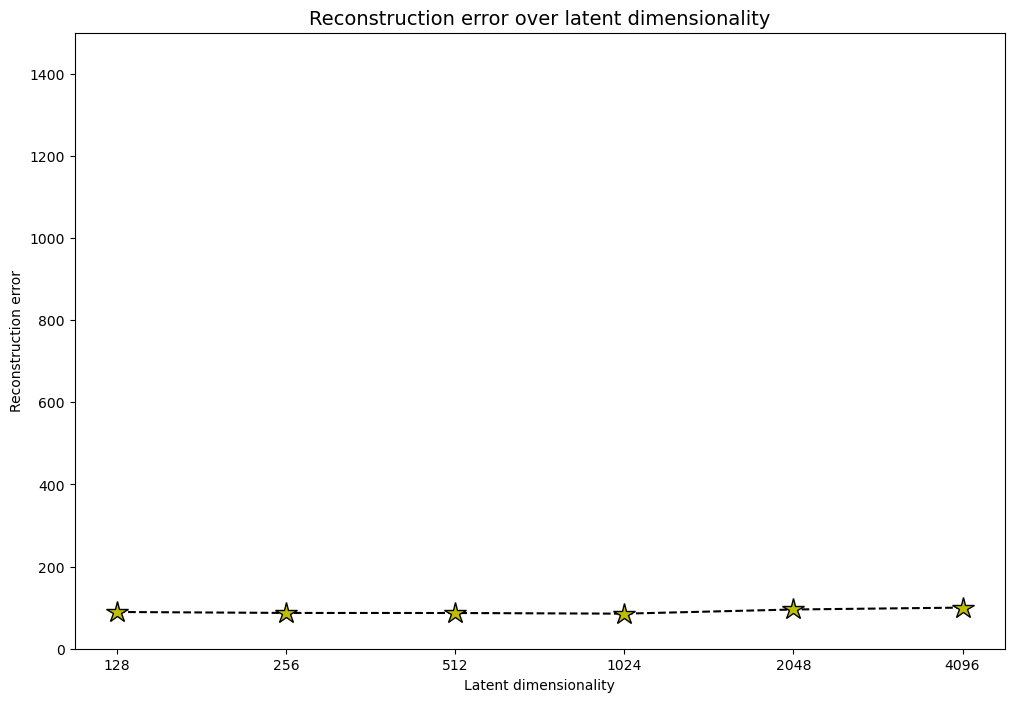

Plot saved as ..\results\music_audio_benchmark\reconstruction_error_plot_spectogram.png


In [23]:
latent_dims = sorted([model for model in model_dict])
val_scores = [model_dict[latent_dim]["result"]["val"][0]["test_loss"] for latent_dim in latent_dims]

fig = plt.figure(figsize=(12, 8))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0, 1500)
plt.show()

save_plot(fig, f"reconstruction_error_plot_{FEATURE_NAME}.png")

##### Visualise autoencoder image reconstructions

In [24]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    fig = plt.figure(figsize=(12 , 8))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    
    save_plot(fig, f"image_reconstruction_{model.hparams.latent_dim}_{FEATURE_NAME}")

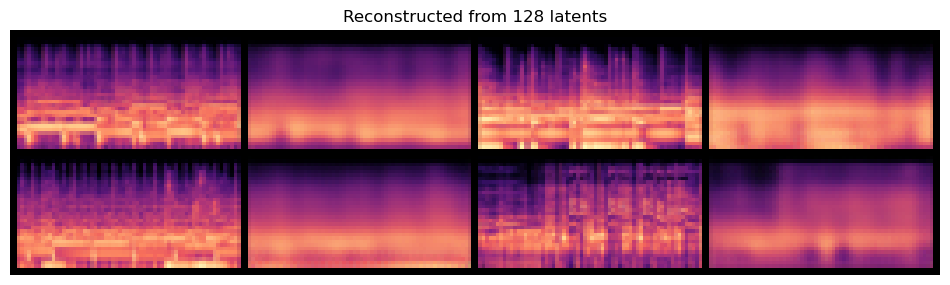

Plot saved as ..\results\music_audio_benchmark\image_reconstruction_128_spectogram


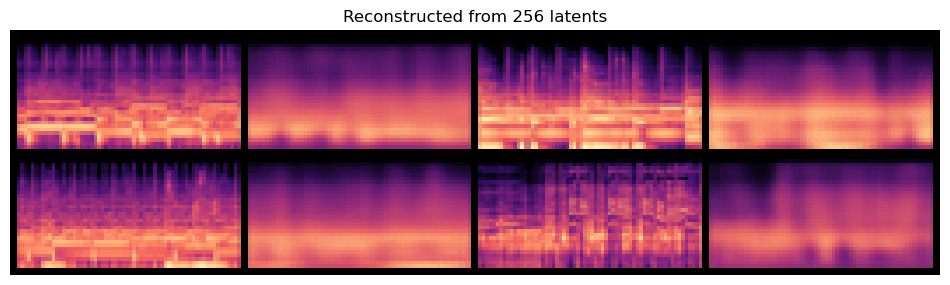

Plot saved as ..\results\music_audio_benchmark\image_reconstruction_256_spectogram


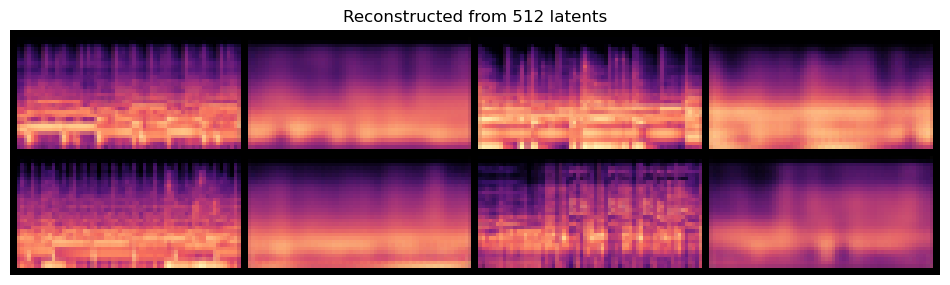

Plot saved as ..\results\music_audio_benchmark\image_reconstruction_512_spectogram


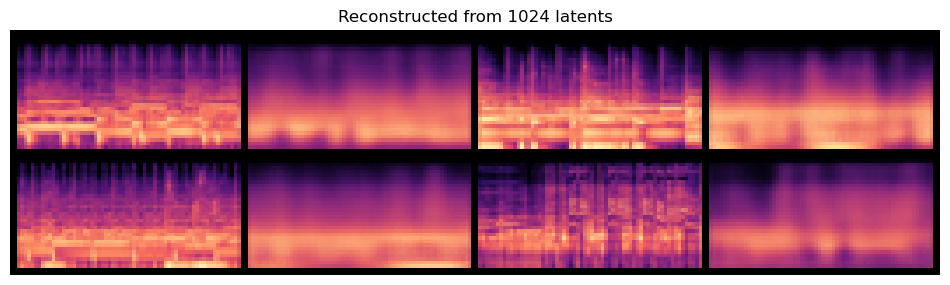

Plot saved as ..\results\music_audio_benchmark\image_reconstruction_1024_spectogram


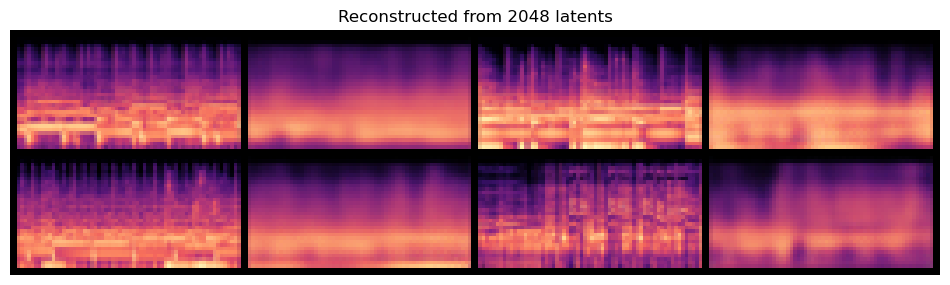

Plot saved as ..\results\music_audio_benchmark\image_reconstruction_2048_spectogram


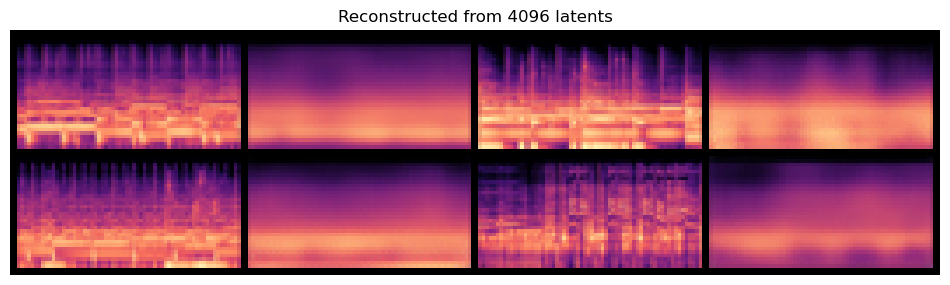

Plot saved as ..\results\music_audio_benchmark\image_reconstruction_4096_spectogram


In [25]:
input_imgs = get_first_n_images(feature_dataset, 4)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

In [26]:
def get_best_model(model_dict, loss_name):
    best_model = None
    best_score = np.inf

    for latent_dim in model_dict:
        score = model_dict[latent_dim]["result"]['val'][0][loss_name]
        if score < best_score:
            best_score = score
            best_model = model_dict[latent_dim]["model"]
            
    return best_model, best_score

best_model, best_score = get_best_model(model_dict, 'test_loss')
        
print(f"Best trained model: {best_model.latent_dim}, loss: {best_score}")

Best trained model: 1024, loss: 85.36845397949219


#### Step 2: Initialize cluster centers using k-means

#### Estimate number of clusters

In [71]:
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for batch in loader:
            x, _ = batch
            x = x.to(model.device)
            z = model.encoder(x)
            features.append(z.cpu().numpy())
    
    features = np.concatenate(features, axis=0)
    
    return features


def silhouette_analysis(X, max_clusters, estimator, estimator_params={}):
    range_n_clusters =  list(range(2, max_clusters + 1))
    
    scores = {}
    
    for n_clusters in range_n_clusters:
        clusterer = estimator(n_clusters=n_clusters, **estimator_params)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(f'For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg}')
        scores[n_clusters] = silhouette_avg
        
    return scores

    
features = extract_features(train_loader, best_model)    

params = {
    'n_init': 'auto',
    'random_state': 23,
}
scores = silhouette_analysis(features, 15, KMeans, params)

sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
top_5_n_clusters = [num_clusters for num_clusters, _ in sorted_scores[:5]]
print(f"Top 5 n clusters: {top_5_n_clusters}")

For n_clusters = 2, The average silhouette_score is : 0.19573837518692017
For n_clusters = 3, The average silhouette_score is : 0.08542090654373169
For n_clusters = 4, The average silhouette_score is : 0.09216656535863876
For n_clusters = 5, The average silhouette_score is : 0.03697557747364044
For n_clusters = 6, The average silhouette_score is : 0.03909328207373619
For n_clusters = 7, The average silhouette_score is : 0.04437762126326561
For n_clusters = 8, The average silhouette_score is : 0.03188351169228554
For n_clusters = 9, The average silhouette_score is : 0.01074310578405857
For n_clusters = 10, The average silhouette_score is : -0.0053954715840518475
For n_clusters = 11, The average silhouette_score is : -0.002167084254324436
For n_clusters = 12, The average silhouette_score is : 0.0030353458132594824
For n_clusters = 13, The average silhouette_score is : -0.002384904772043228
For n_clusters = 14, The average silhouette_score is : -0.0009777239756658673
For n_clusters = 15, 

#### Step 3: Deep clustering

In [73]:
def train_dcec(autoencoder, n_clusters):
    pretrained_dir = os.path.join(CHECKPOINT_PATH, DATASET_NAME, "DCEC")
    checkpoint_callback = get_model_checkpoint(pretrained_dir, "DCEC", f"{FEATURE_NAME}-{autoencoder.latent_dim}-n_clu-{n_clusters}")
    
    trainer = pl.Trainer(
        default_root_dir=os.path.join('..', 'logs'),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=EPOCHS_DCEC,
        callbacks=[
            checkpoint_callback,
            GenerateCallback(get_first_n_images(feature_dataset, 4), every_n_epochs=10),
            LearningRateMonitor("epoch")
        ]
    )
    
    trainer.logger._log_graph = True 
    trainer.logger._default_hp_metric = None  
    
    checkpoint_file = get_checkpoint_file(pretrained_dir, autoencoder.latent_dim, n_clusters)
    if os.path.isdir(pretrained_dir) and checkpoint_file is not None:
        print("FOUND PRETRAINED DCEC!")
        model = DCEC.load_from_checkpoint(
            checkpoint_path=checkpoint_file, 
            autoencoder=autoencoder, 
            n_clusters=n_clusters, 
            latent_dim=autoencoder.latent_dim
        )
    else:
        print("TRAINING DCEC...")
        model = DCEC(n_clusters=n_clusters, autoencoder=autoencoder, latent_dim=autoencoder.latent_dim)
        trainer.fit(model, train_loader, val_loader)
    
        best_model_path = checkpoint_callback.best_model_path
        model = DCEC.load_from_checkpoint(
            checkpoint_path=best_model_path, 
            autoencoder=autoencoder,
            n_clusters=n_clusters, 
            latent_dim=autoencoder.latent_dim
        )
    
    val_result = trainer.test(model, val_loader, verbose=False)
    result = {"val": val_result}
    
    return model, result

In [74]:
dcec_model_dict = {}

for n_clusters in top_5_n_clusters:
    print(f"STEP 2: INITIALIZE CLUSTER CENTER USING K-MEANS (N_CLUSTERS: {n_clusters})")
    
    DCEC_model = DCEC(n_clusters=n_clusters, autoencoder=best_model, latent_dim=best_model.latent_dim)
    autoencoder = DCEC_model.autoencoder 

    latent_representations = []
    with torch.no_grad():
        for batch in train_loader:
            x, _ = batch
            z = autoencoder.encoder(x.to(autoencoder.device))
            latent_representations.append(z.cpu().numpy())

    latent_representations = np.concatenate(latent_representations, axis=0)        
    kmeans = KMeans(n_clusters=n_clusters, n_init=23)
    y_pred = kmeans.fit_predict(latent_representations)
    cluster_centers = kmeans.cluster_centers_

    DCEC_model.clustering_layer.set_clusters(cluster_centers)
    
    print("STEP 3: TRAIN DCEC")
    model_id, result_id = train_dcec(autoencoder, n_clusters)
    dcec_model_dict[n_clusters] = {
        "model": model_id,
        "result": result_id
    }

STEP 2: INITIALIZE CLUSTER CENTER USING K-MEANS (N_CLUSTERS: 2)
STEP 3: TRAIN DCEC


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TRAINING DCEC...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | autoencoder      | Autoencoder     | 9.2 M 
1 | clustering_layer | ClusteringLayer | 2.0 K 
2 | criterion        | KLDivLoss       | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.845    Total estimated model params size (MB)
C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loggers\tensorboard.py:194: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.07170104980469
kl_loss: 2.5425106287002563e-06
total_loss: 86.07170104980469
recon_loss: 73.25999450683594
kl_loss: 5.2852556109428406e-06
total_loss: 73.26000213623047


C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

recon_loss: 71.29682922363281
kl_loss: 3.5208649933338165e-06
total_loss: 71.29682922363281
recon_loss: 775.0137939453125
kl_loss: 3.3173710107803345e-06
total_loss: 775.0137939453125
recon_loss: 276.191162109375
kl_loss: 1.58604234457016e-06
total_loss: 276.191162109375
recon_loss: 160.54380798339844
kl_loss: 1.2558884918689728e-06
total_loss: 160.54380798339844
recon_loss: 213.74867248535156
kl_loss: 6.058253347873688e-07
total_loss: 213.74867248535156
recon_loss: 164.59539794921875
kl_loss: 4.5495107769966125e-07
total_loss: 164.59539794921875
recon_loss: 161.47061157226562
kl_loss: 3.57162207365036e-07
total_loss: 161.47061157226562
recon_loss: 151.1472625732422
kl_loss: 5.830079317092896e-07
total_loss: 151.1472625732422
recon_loss: 153.226806640625
kl_loss: 4.884786903858185e-07
total_loss: 153.226806640625
recon_loss: 131.96917724609375
kl_loss: 9.336508810520172e-07
total_loss: 131.96917724609375
recon_loss: 122.77693176269531
kl_loss: 4.66126948595047e-07
total_loss: 122.77693

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.37913513183594
kl_loss: 2.0209699869155884e-07
total_loss: 105.37913513183594
recon_loss: 94.32731628417969
kl_loss: 3.3248215913772583e-07
total_loss: 94.32731628417969
recon_loss: 111.90284729003906
kl_loss: 2.123415470123291e-07
total_loss: 111.90284729003906
recon_loss: 105.0824966430664
kl_loss: 2.2631138563156128e-07
total_loss: 105.0824966430664
recon_loss: 104.37134552001953
kl_loss: 2.2863969206809998e-07
total_loss: 104.37134552001953
recon_loss: 107.08499908447266
kl_loss: 1.9278377294540405e-07
total_loss: 107.08499908447266
recon_loss: 98.57374572753906
kl_loss: 2.0582228899002075e-07
total_loss: 98.57374572753906
recon_loss: 92.69927978515625
kl_loss: 2.100132405757904e-07
total_loss: 92.69927978515625
recon_loss: 94.70114135742188
kl_loss: 1.234002411365509e-07
total_loss: 94.70114135742188
recon_loss: 85.55595397949219
kl_loss: 1.2759119272232056e-07
total_loss: 85.55595397949219
recon_loss: 89.8635025024414
kl_loss: 1.3504177331924438e-07
total_loss: 89

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.5448226928711
kl_loss: 8.475035429000854e-08
total_loss: 94.5448226928711
recon_loss: 82.13381958007812
kl_loss: 7.683411240577698e-08
total_loss: 82.13381958007812
recon_loss: 96.63304138183594
kl_loss: 8.009374141693115e-08
total_loss: 96.63304138183594
recon_loss: 92.88894653320312
kl_loss: 5.2619725465774536e-08
total_loss: 92.88894653320312
recon_loss: 92.72650146484375
kl_loss: 5.9138983488082886e-08
total_loss: 92.72650146484375
recon_loss: 77.70597839355469
kl_loss: 5.3551048040390015e-08
total_loss: 77.70597839355469
recon_loss: 80.21520233154297
kl_loss: 5.4016709327697754e-08
total_loss: 80.21520233154297
recon_loss: 87.80152893066406
kl_loss: 5.448237061500549e-08
total_loss: 87.80152893066406
recon_loss: 72.20529174804688
kl_loss: 6.472691893577576e-08
total_loss: 72.20529174804688
recon_loss: 88.40662384033203
kl_loss: 4.98257577419281e-08
total_loss: 88.40662384033203
recon_loss: 75.62046813964844
kl_loss: 7.404014468193054e-08
total_loss: 75.6204681396484

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.64676666259766
kl_loss: 4.377216100692749e-08
total_loss: 88.64676666259766
recon_loss: 76.53535461425781
kl_loss: 4.6566128730773926e-08
total_loss: 76.53535461425781
recon_loss: 91.84065246582031
kl_loss: 4.7031790018081665e-08
total_loss: 91.84065246582031
recon_loss: 87.5853042602539
kl_loss: 3.864988684654236e-08
total_loss: 87.5853042602539
recon_loss: 87.51007080078125
kl_loss: 2.8870999813079834e-08
total_loss: 87.51007080078125
recon_loss: 82.20118713378906
kl_loss: 3.3993273973464966e-08
total_loss: 82.20118713378906
recon_loss: 69.74303436279297
kl_loss: 2.468004822731018e-08
total_loss: 69.74303436279297
recon_loss: 78.4486083984375
kl_loss: 2.421438694000244e-08
total_loss: 78.4486083984375
recon_loss: 75.2752456665039
kl_loss: 2.421438694000244e-08
total_loss: 75.2752456665039
recon_loss: 69.63873291015625
kl_loss: 2.60770320892334e-08
total_loss: 69.63873291015625
recon_loss: 77.01790618896484
kl_loss: 3.166496753692627e-08
total_loss: 77.01790618896484
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.60470581054688
kl_loss: 2.0489096641540527e-08
total_loss: 86.60470581054688
recon_loss: 74.42057800292969
kl_loss: 2.1886080503463745e-08
total_loss: 74.42057800292969
recon_loss: 89.50021362304688
kl_loss: 3.4924596548080444e-08
total_loss: 89.50021362304688
recon_loss: 85.38408660888672
kl_loss: 2.7008354663848877e-08
total_loss: 85.38408660888672
recon_loss: 85.26233673095703
kl_loss: 3.259629011154175e-08
total_loss: 85.26233673095703
recon_loss: 83.06690979003906
kl_loss: 1.1641532182693481e-08
total_loss: 83.06690979003906
recon_loss: 74.22145080566406
kl_loss: 2.6542693376541138e-08
total_loss: 74.22145080566406
recon_loss: 69.15416717529297
kl_loss: 3.3993273973464966e-08
total_loss: 69.15416717529297
recon_loss: 75.11860656738281
kl_loss: 3.213062882423401e-08
total_loss: 75.11860656738281
recon_loss: 68.60575866699219
kl_loss: 2.3283064365386963e-08
total_loss: 68.60575866699219
recon_loss: 73.24311828613281
kl_loss: 3.632158041000366e-08
total_loss: 73.243118

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 85.82334899902344
kl_loss: 3.3993273973464966e-08
total_loss: 85.82334899902344
recon_loss: 73.94696044921875
kl_loss: 1.7229467630386353e-08
total_loss: 73.94696044921875
recon_loss: 89.11778259277344
kl_loss: 2.1420419216156006e-08
total_loss: 89.11778259277344
recon_loss: 84.78349304199219
kl_loss: 2.421438694000244e-08
total_loss: 84.78349304199219
recon_loss: 84.45796203613281
kl_loss: 3.073364496231079e-08
total_loss: 84.45796203613281
recon_loss: 70.49824523925781
kl_loss: 3.4458935260772705e-08
total_loss: 70.49824523925781
recon_loss: 71.79852294921875
kl_loss: 6.984919309616089e-09
total_loss: 71.79852294921875
recon_loss: 80.28670501708984
kl_loss: 2.0489096641540527e-08
total_loss: 80.28670501708984
recon_loss: 74.52107238769531
kl_loss: 3.3527612686157227e-08
total_loss: 74.52107238769531
recon_loss: 72.2611083984375
kl_loss: 1.6763806343078613e-08
total_loss: 72.2611083984375
recon_loss: 76.74681854248047
kl_loss: 1.6298145055770874e-08
total_loss: 76.74681854

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.0534439086914
kl_loss: 1.30385160446167e-08
total_loss: 86.0534439086914
recon_loss: 73.75871276855469
kl_loss: 1.7229467630386353e-08
total_loss: 73.75871276855469
recon_loss: 89.18728637695312
kl_loss: 2.3283064365386963e-08
total_loss: 89.18728637695312
recon_loss: 84.88728332519531
kl_loss: 1.6763806343078613e-08
total_loss: 84.88728332519531
recon_loss: 84.84162902832031
kl_loss: 1.909211277961731e-08
total_loss: 84.84162902832031
recon_loss: 75.03295135498047
kl_loss: 1.3969838619232178e-08
total_loss: 75.03295135498047
recon_loss: 73.00421905517578
kl_loss: 3.026798367500305e-08
total_loss: 73.00421905517578
recon_loss: 68.87604522705078
kl_loss: 8.847564458847046e-09
total_loss: 68.87604522705078
recon_loss: 71.76482391357422
kl_loss: 1.3504177331924438e-08
total_loss: 71.76482391357422
recon_loss: 78.9453125
kl_loss: 2.514570951461792e-08
total_loss: 78.9453125
recon_loss: 64.90367126464844
kl_loss: 1.210719347000122e-08
total_loss: 64.90367126464844
recon_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 85.72010040283203
kl_loss: 2.8870999813079834e-08
total_loss: 85.72010040283203
recon_loss: 73.32918548583984
kl_loss: 2.7008354663848877e-08
total_loss: 73.32918548583984
recon_loss: 89.10198974609375
kl_loss: 2.3283064365386963e-08
total_loss: 89.10198974609375
recon_loss: 84.4426040649414
kl_loss: 4.190951585769653e-08
total_loss: 84.4426040649414
recon_loss: 84.39559936523438
kl_loss: 1.0710209608078003e-08
total_loss: 84.39559936523438
recon_loss: 72.82124328613281
kl_loss: 1.955777406692505e-08
total_loss: 72.82124328613281
recon_loss: 70.27363586425781
kl_loss: 2.0489096641540527e-08
total_loss: 70.27363586425781
recon_loss: 74.7210464477539
kl_loss: 2.468004822731018e-08
total_loss: 74.7210464477539
recon_loss: 68.65811920166016
kl_loss: 2.2817403078079224e-08
total_loss: 68.65811920166016
recon_loss: 69.09906005859375
kl_loss: 1.5366822481155396e-08
total_loss: 69.09906005859375
recon_loss: 71.46528625488281
kl_loss: 1.7229467630386353e-08
total_loss: 71.4652862548

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.4017105102539
kl_loss: 1.257285475730896e-08
total_loss: 86.4017105102539
recon_loss: 73.67288970947266
kl_loss: 1.1175870895385742e-08
total_loss: 73.67288970947266
recon_loss: 89.3887939453125
kl_loss: 4.377216100692749e-08
total_loss: 89.3887939453125
recon_loss: 84.70103454589844
kl_loss: 2.60770320892334e-08
total_loss: 84.70103454589844
recon_loss: 85.13824462890625
kl_loss: 2.7008354663848877e-08
total_loss: 85.13824462890625
recon_loss: 69.430908203125
kl_loss: 1.909211277961731e-08
total_loss: 69.430908203125
recon_loss: 73.72785949707031
kl_loss: 2.7008354663848877e-08
total_loss: 73.72785949707031
recon_loss: 75.9709243774414
kl_loss: 2.8405338525772095e-08
total_loss: 75.9709243774414
recon_loss: 72.33983612060547
kl_loss: 2.7008354663848877e-08
total_loss: 72.33983612060547
recon_loss: 69.65007781982422
kl_loss: 3.119930624961853e-08
total_loss: 69.65007781982422
recon_loss: 81.61837768554688
kl_loss: 2.7939677238464355e-08
total_loss: 81.61837768554688
reco

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.50996398925781
kl_loss: 3.213062882423401e-08
total_loss: 86.50996398925781
recon_loss: 74.06269836425781
kl_loss: 1.1175870895385742e-08
total_loss: 74.06269836425781
recon_loss: 90.09248352050781
kl_loss: 1.3969838619232178e-08
total_loss: 90.09248352050781
recon_loss: 85.0777816772461
kl_loss: 2.3283064365386963e-08
total_loss: 85.0777816772461
recon_loss: 85.55966186523438
kl_loss: 7.450580596923828e-09
total_loss: 85.55966186523438
recon_loss: 70.17731475830078
kl_loss: 1.4435499906539917e-08
total_loss: 70.17731475830078
recon_loss: 75.69408416748047
kl_loss: 2.421438694000244e-08
total_loss: 75.69408416748047
recon_loss: 66.2379150390625
kl_loss: 2.1886080503463745e-08
total_loss: 66.2379150390625
recon_loss: 67.63455200195312
kl_loss: 1.257285475730896e-08
total_loss: 67.63455200195312
recon_loss: 69.89659118652344
kl_loss: 1.3504177331924438e-08
total_loss: 69.89659118652344
recon_loss: 69.77161407470703
kl_loss: 2.421438694000244e-08
total_loss: 69.771614074707

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.89264678955078
kl_loss: 1.5366822481155396e-08
total_loss: 86.89264678955078
recon_loss: 74.43802642822266
kl_loss: 1.816079020500183e-08
total_loss: 74.43802642822266
recon_loss: 90.36332702636719
kl_loss: 2.561137080192566e-08
total_loss: 90.36332702636719
recon_loss: 85.71538543701172
kl_loss: 2.9336661100387573e-08
total_loss: 85.71538543701172
recon_loss: 85.82605743408203
kl_loss: 1.7695128917694092e-08
total_loss: 85.82605743408203
recon_loss: 67.46875
kl_loss: 1.1175870895385742e-08
total_loss: 67.46875
recon_loss: 69.02359008789062
kl_loss: 1.0244548320770264e-08
total_loss: 69.02359008789062
recon_loss: 77.27975463867188
kl_loss: 3.725290298461914e-09
total_loss: 77.27975463867188
recon_loss: 64.74408721923828
kl_loss: 3.259629011154175e-09
total_loss: 64.74408721923828
recon_loss: 74.43984985351562
kl_loss: 1.4901161193847656e-08
total_loss: 74.43984985351562
recon_loss: 71.90507507324219
kl_loss: 1.5366822481155396e-08
total_loss: 71.90507507324219
recon_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.56753540039062
kl_loss: 7.916241884231567e-09
total_loss: 86.56753540039062
recon_loss: 74.24860382080078
kl_loss: 1.5832483768463135e-08
total_loss: 74.24860382080078
recon_loss: 90.04977416992188
kl_loss: 1.30385160446167e-08
total_loss: 90.04977416992188
recon_loss: 85.35956573486328
kl_loss: 2.561137080192566e-08
total_loss: 85.35956573486328
recon_loss: 86.20700073242188
kl_loss: 6.984919309616089e-09
total_loss: 86.20700073242188
recon_loss: 68.46939086914062
kl_loss: 1.3504177331924438e-08
total_loss: 68.46939086914062
recon_loss: 68.28276824951172
kl_loss: 1.6298145055770874e-08
total_loss: 68.28276824951172
recon_loss: 79.54931640625
kl_loss: 3.213062882423401e-08
total_loss: 79.54931640625
recon_loss: 67.11634063720703
kl_loss: 1.955777406692505e-08
total_loss: 67.11634063720703
recon_loss: 66.96451568603516
kl_loss: 3.213062882423401e-08
total_loss: 66.96451568603516
recon_loss: 64.0880126953125
kl_loss: 2.0489096641540527e-08
total_loss: 64.0880126953125
reco

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.17593383789062
kl_loss: 5.587935447692871e-09
total_loss: 88.17593383789062
recon_loss: 75.42625427246094
kl_loss: 2.6542693376541138e-08
total_loss: 75.42625427246094
recon_loss: 92.5500717163086
kl_loss: 2.468004822731018e-08
total_loss: 92.5500717163086
recon_loss: 87.00804901123047
kl_loss: 1.30385160446167e-08
total_loss: 87.00804901123047
recon_loss: 87.9120864868164
kl_loss: 2.60770320892334e-08
total_loss: 87.9120864868164
recon_loss: 72.76321411132812
kl_loss: 2.60770320892334e-08
total_loss: 72.76321411132812
recon_loss: 67.67012023925781
kl_loss: 2.2351741790771484e-08
total_loss: 67.67012023925781
recon_loss: 73.8126220703125
kl_loss: 2.2817403078079224e-08
total_loss: 73.8126220703125
recon_loss: 68.33964538574219
kl_loss: 1.7695128917694092e-08
total_loss: 68.33964538574219
recon_loss: 77.15657043457031
kl_loss: 1.7229467630386353e-08
total_loss: 77.15657043457031
recon_loss: 71.03536987304688
kl_loss: 2.514570951461792e-08
total_loss: 71.03536987304688
rec

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.20906066894531
kl_loss: 2.2817403078079224e-08
total_loss: 87.20906066894531
recon_loss: 74.60269165039062
kl_loss: 1.257285475730896e-08
total_loss: 74.60269165039062
recon_loss: 90.9688720703125
kl_loss: 2.60770320892334e-08
total_loss: 90.9688720703125
recon_loss: 85.50080871582031
kl_loss: 2.421438694000244e-08
total_loss: 85.50080871582031
recon_loss: 86.94316101074219
kl_loss: 2.2351741790771484e-08
total_loss: 86.94316101074219
recon_loss: 70.54059600830078
kl_loss: 2.561137080192566e-08
total_loss: 70.54059600830078
recon_loss: 68.98001861572266
kl_loss: 1.7229467630386353e-08
total_loss: 68.98001861572266
recon_loss: 64.65885925292969
kl_loss: 1.1641532182693481e-08
total_loss: 64.65885925292969
recon_loss: 69.87130737304688
kl_loss: 2.2351741790771484e-08
total_loss: 69.87130737304688
recon_loss: 77.59774780273438
kl_loss: 2.421438694000244e-08
total_loss: 77.59774780273438
recon_loss: 71.52676391601562
kl_loss: 2.6542693376541138e-08
total_loss: 71.52676391601

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.35629272460938
kl_loss: 3.213062882423401e-08
total_loss: 87.35629272460938
recon_loss: 74.97559356689453
kl_loss: 2.2817403078079224e-08
total_loss: 74.97559356689453
recon_loss: 91.99630737304688
kl_loss: 3.026798367500305e-08
total_loss: 91.99630737304688
recon_loss: 85.5475845336914
kl_loss: 3.026798367500305e-08
total_loss: 85.5475845336914
recon_loss: 88.52023315429688
kl_loss: 2.421438694000244e-08
total_loss: 88.52023315429688
recon_loss: 69.4208984375
kl_loss: 3.3993273973464966e-08
total_loss: 69.4208984375
recon_loss: 65.22569274902344
kl_loss: 1.816079020500183e-08
total_loss: 65.22569274902344
recon_loss: 69.78083801269531
kl_loss: 1.257285475730896e-08
total_loss: 69.78083801269531
recon_loss: 72.40362548828125
kl_loss: 1.3504177331924438e-08
total_loss: 72.40362548828125
recon_loss: 72.05672454833984
kl_loss: 1.210719347000122e-08
total_loss: 72.05672454833984
recon_loss: 70.82915496826172
kl_loss: 2.2817403078079224e-08
total_loss: 70.82915496826172
recon

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.45338439941406
kl_loss: 1.210719347000122e-08
total_loss: 87.45338439941406
recon_loss: 74.82324981689453
kl_loss: 2.7939677238464355e-09
total_loss: 74.82324981689453
recon_loss: 91.7274398803711
kl_loss: 1.0244548320770264e-08
total_loss: 91.7274398803711
recon_loss: 85.94742584228516
kl_loss: 1.955777406692505e-08
total_loss: 85.94742584228516
recon_loss: 87.84766387939453
kl_loss: 2.421438694000244e-08
total_loss: 87.84766387939453
recon_loss: 64.24410247802734
kl_loss: 1.955777406692505e-08
total_loss: 64.24410247802734
recon_loss: 68.89222717285156
kl_loss: 1.1175870895385742e-08
total_loss: 68.89222717285156
recon_loss: 62.81231689453125
kl_loss: 1.257285475730896e-08
total_loss: 62.81231689453125
recon_loss: 68.04823303222656
kl_loss: 2.3283064365386963e-08
total_loss: 68.04823303222656
recon_loss: 64.16964721679688
kl_loss: 5.587935447692871e-09
total_loss: 64.16964721679688
recon_loss: 62.31083679199219
kl_loss: 2.7939677238464355e-08
total_loss: 62.31083679199

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.36338806152344
kl_loss: 1.1641532182693481e-08
total_loss: 87.36338806152344
recon_loss: 74.82079315185547
kl_loss: 1.862645149230957e-08
total_loss: 74.82079315185547
recon_loss: 91.89373779296875
kl_loss: 2.2351741790771484e-08
total_loss: 91.89373779296875
recon_loss: 85.35015106201172
kl_loss: -9.313225746154785e-10
total_loss: 85.35015106201172
recon_loss: 87.93724822998047
kl_loss: 2.8405338525772095e-08
total_loss: 87.93724822998047
recon_loss: 65.71401977539062
kl_loss: 2.7939677238464355e-08
total_loss: 65.71401977539062
recon_loss: 69.13784790039062
kl_loss: 2.3748725652694702e-08
total_loss: 69.13784790039062
recon_loss: 65.4144058227539
kl_loss: 6.05359673500061e-09
total_loss: 65.4144058227539
recon_loss: 66.58074951171875
kl_loss: 2.60770320892334e-08
total_loss: 66.58074951171875
recon_loss: 66.28599548339844
kl_loss: 1.257285475730896e-08
total_loss: 66.28599548339844
recon_loss: 72.00128936767578
kl_loss: 2.9802322387695312e-08
total_loss: 72.00128936767

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.95629119873047
kl_loss: 2.1886080503463745e-08
total_loss: 88.95629119873047
recon_loss: 75.92150115966797
kl_loss: 1.1175870895385742e-08
total_loss: 75.92150115966797
recon_loss: 93.694580078125
kl_loss: 1.6298145055770874e-08
total_loss: 93.694580078125
recon_loss: 86.97974395751953
kl_loss: 2.7008354663848877e-08
total_loss: 86.97974395751953
recon_loss: 89.97628784179688
kl_loss: 9.313225746154785e-09
total_loss: 89.97628784179688
recon_loss: 73.65061950683594
kl_loss: 2.7008354663848877e-08
total_loss: 73.65061950683594
recon_loss: 67.66099548339844
kl_loss: 2.561137080192566e-08
total_loss: 67.66099548339844
recon_loss: 64.36653137207031
kl_loss: 3.213062882423401e-08
total_loss: 64.36653137207031
recon_loss: 63.58406448364258
kl_loss: 2.2817403078079224e-08
total_loss: 63.58406448364258
recon_loss: 70.7806396484375
kl_loss: 2.0489096641540527e-08
total_loss: 70.7806396484375
recon_loss: 65.99980163574219
kl_loss: 3.3527612686157227e-08
total_loss: 65.999801635742

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.43617248535156
kl_loss: 2.8870999813079834e-08
total_loss: 90.43617248535156
recon_loss: 77.24502563476562
kl_loss: 2.8405338525772095e-08
total_loss: 77.24502563476562
recon_loss: 94.48985290527344
kl_loss: 2.9336661100387573e-08
total_loss: 94.48985290527344
recon_loss: 88.61451721191406
kl_loss: 2.421438694000244e-08
total_loss: 88.61451721191406
recon_loss: 91.97117614746094
kl_loss: 2.0954757928848267e-08
total_loss: 91.97117614746094
recon_loss: 66.18983459472656
kl_loss: 2.8405338525772095e-08
total_loss: 66.18983459472656
recon_loss: 63.320072174072266
kl_loss: 1.7695128917694092e-08
total_loss: 63.320072174072266
recon_loss: 65.23902893066406
kl_loss: 1.5832483768463135e-08
total_loss: 65.23902893066406
recon_loss: 69.65765380859375
kl_loss: 1.862645149230957e-08
total_loss: 69.65765380859375
recon_loss: 71.78023529052734
kl_loss: 2.3283064365386963e-08
total_loss: 71.78023529052734
recon_loss: 67.78573608398438
kl_loss: 1.7229467630386353e-08
total_loss: 67.785

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.16859436035156
kl_loss: 1.4435499906539917e-08
total_loss: 89.16859436035156
recon_loss: 76.51721954345703
kl_loss: 2.3283064365386963e-08
total_loss: 76.51721954345703
recon_loss: 94.50325775146484
kl_loss: 1.955777406692505e-08
total_loss: 94.50325775146484
recon_loss: 87.85231018066406
kl_loss: 2.7939677238464355e-08
total_loss: 87.85231018066406
recon_loss: 90.49311065673828
kl_loss: 3.306195139884949e-08
total_loss: 90.49311065673828
recon_loss: 69.81263732910156
kl_loss: 1.5366822481155396e-08
total_loss: 69.81263732910156
recon_loss: 64.20603942871094
kl_loss: 2.0954757928848267e-08
total_loss: 64.20603942871094
recon_loss: 60.663944244384766
kl_loss: 2.3283064365386963e-08
total_loss: 60.663944244384766
recon_loss: 64.20423889160156
kl_loss: 2.2817403078079224e-08
total_loss: 64.20423889160156
recon_loss: 69.8515625
kl_loss: 1.862645149230957e-08
total_loss: 69.8515625
recon_loss: 64.1260986328125
kl_loss: 1.862645149230957e-09
total_loss: 64.1260986328125
recon_

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.7658462524414
kl_loss: 4.0046870708465576e-08
total_loss: 89.7658462524414
recon_loss: 77.44841766357422
kl_loss: 1.6763806343078613e-08
total_loss: 77.44841766357422
recon_loss: 94.61405944824219
kl_loss: 1.210719347000122e-08
total_loss: 94.61405944824219
recon_loss: 89.64737701416016
kl_loss: 1.4901161193847656e-08
total_loss: 89.64737701416016
recon_loss: 91.67176818847656
kl_loss: 1.4435499906539917e-08
total_loss: 91.67176818847656
recon_loss: 61.368255615234375
kl_loss: 1.30385160446167e-08
total_loss: 61.368255615234375
recon_loss: 67.02738952636719
kl_loss: 2.0954757928848267e-08
total_loss: 67.02738952636719
recon_loss: 58.929893493652344
kl_loss: 1.7229467630386353e-08
total_loss: 58.929893493652344
recon_loss: 66.67131042480469
kl_loss: 1.7229467630386353e-08
total_loss: 66.67131042480469
recon_loss: 67.829345703125
kl_loss: 4.190951585769653e-09
total_loss: 67.829345703125
recon_loss: 62.970176696777344
kl_loss: 2.468004822731018e-08
total_loss: 62.970176696

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.34458923339844
kl_loss: 1.3969838619232178e-08
total_loss: 89.34458923339844
recon_loss: 76.25991821289062
kl_loss: -9.778887033462524e-09
total_loss: 76.25991821289062
recon_loss: 94.7745590209961
kl_loss: 1.7695128917694092e-08
total_loss: 94.7745590209961
recon_loss: 88.42866516113281
kl_loss: 5.122274160385132e-09
total_loss: 88.42866516113281
recon_loss: 91.0128173828125
kl_loss: 1.7695128917694092e-08
total_loss: 91.0128173828125
recon_loss: 60.50663375854492
kl_loss: 3.026798367500305e-08
total_loss: 60.50663375854492
recon_loss: 65.92283630371094
kl_loss: 1.7229467630386353e-08
total_loss: 65.92283630371094
recon_loss: 60.822967529296875
kl_loss: 1.6763806343078613e-08
total_loss: 60.822967529296875
recon_loss: 62.99668884277344
kl_loss: 0.0
total_loss: 62.99668884277344
recon_loss: 62.85763168334961
kl_loss: 2.3283064365386963e-09
total_loss: 62.85763168334961
recon_loss: 67.21188354492188
kl_loss: 2.1886080503463745e-08
total_loss: 67.21188354492188
recon_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.47409057617188
kl_loss: 2.3283064365386963e-08
total_loss: 89.47409057617188
recon_loss: 76.62712860107422
kl_loss: 1.7229467630386353e-08
total_loss: 76.62712860107422
recon_loss: 95.22879791259766
kl_loss: 2.7008354663848877e-08
total_loss: 95.22879791259766
recon_loss: 88.53121185302734
kl_loss: 1.816079020500183e-08
total_loss: 88.53121185302734
recon_loss: 91.0216064453125
kl_loss: 2.8870999813079834e-08
total_loss: 91.0216064453125
recon_loss: 63.87747573852539
kl_loss: 1.816079020500183e-08
total_loss: 63.87747573852539
recon_loss: 62.78379440307617
kl_loss: 2.1420419216156006e-08
total_loss: 62.78379440307617
recon_loss: 65.5744400024414
kl_loss: 6.984919309616089e-09
total_loss: 65.5744400024414
recon_loss: 62.06774139404297
kl_loss: 2.7474015951156616e-08
total_loss: 62.06774139404297
recon_loss: 58.321319580078125
kl_loss: -1.3969838619232178e-09
total_loss: 58.321319580078125
recon_loss: 65.26569366455078
kl_loss: 3.5390257835388184e-08
total_loss: 65.2656936

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.78359985351562
kl_loss: 2.8405338525772095e-08
total_loss: 90.78359985351562
recon_loss: 77.4190673828125
kl_loss: 1.0244548320770264e-08
total_loss: 77.4190673828125
recon_loss: 95.71438598632812
kl_loss: 2.7008354663848877e-08
total_loss: 95.71438598632812
recon_loss: 88.72506713867188
kl_loss: 2.0954757928848267e-08
total_loss: 88.72506713867188
recon_loss: 91.1906509399414
kl_loss: 2.0954757928848267e-08
total_loss: 91.1906509399414
recon_loss: 60.08809280395508
kl_loss: 1.3504177331924438e-08
total_loss: 60.08809280395508
recon_loss: 63.373138427734375
kl_loss: 3.166496753692627e-08
total_loss: 63.373138427734375
recon_loss: 60.6373405456543
kl_loss: 2.561137080192566e-08
total_loss: 60.6373405456543
recon_loss: 66.74543762207031
kl_loss: 2.514570951461792e-08
total_loss: 66.74543762207031
recon_loss: 62.55919647216797
kl_loss: 2.7939677238464355e-08
total_loss: 62.55919647216797
recon_loss: 63.70030975341797
kl_loss: 2.9802322387695312e-08
total_loss: 63.7003097534

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.982177734375
kl_loss: 1.0710209608078003e-08
total_loss: 89.982177734375
recon_loss: 77.09162139892578
kl_loss: 1.862645149230957e-08
total_loss: 77.09162139892578
recon_loss: 95.75112915039062
kl_loss: 1.257285475730896e-08
total_loss: 95.75112915039062
recon_loss: 89.46623229980469
kl_loss: 1.955777406692505e-08
total_loss: 89.46623229980469
recon_loss: 91.736572265625
kl_loss: 2.9802322387695312e-08
total_loss: 91.736572265625
recon_loss: 62.40626907348633
kl_loss: 1.4901161193847656e-08
total_loss: 62.40626907348633
recon_loss: 62.12303924560547
kl_loss: 2.1886080503463745e-08
total_loss: 62.12303924560547
recon_loss: 61.43693542480469
kl_loss: 3.166496753692627e-08
total_loss: 61.43693542480469
recon_loss: 60.42695999145508
kl_loss: -2.7939677238464355e-09
total_loss: 60.42695999145508
recon_loss: 60.979942321777344
kl_loss: 4.656612873077393e-10
total_loss: 60.979942321777344
recon_loss: 60.809471130371094
kl_loss: 1.5366822481155396e-08
total_loss: 60.809471130371

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.71307373046875
kl_loss: 1.257285475730896e-08
total_loss: 91.71307373046875
recon_loss: 77.57864379882812
kl_loss: 1.5832483768463135e-08
total_loss: 77.57864379882812
recon_loss: 96.06700897216797
kl_loss: 3.3993273973464966e-08
total_loss: 96.06700897216797
recon_loss: 89.63587951660156
kl_loss: 1.6763806343078613e-08
total_loss: 89.63587951660156
recon_loss: 92.25894165039062
kl_loss: 2.514570951461792e-08
total_loss: 92.25894165039062
recon_loss: 58.3049201965332
kl_loss: 2.468004822731018e-08
total_loss: 58.3049201965332
recon_loss: 61.20256042480469
kl_loss: 4.656612873077393e-10
total_loss: 61.20256042480469
recon_loss: 55.8775634765625
kl_loss: -2.7939677238464355e-09
total_loss: 55.8775634765625
recon_loss: 58.453895568847656
kl_loss: 2.3283064365386963e-08
total_loss: 58.453895568847656
recon_loss: 58.624534606933594
kl_loss: 1.3969838619232178e-08
total_loss: 58.624534606933594
recon_loss: 56.657447814941406
kl_loss: 3.3527612686157227e-08
total_loss: 56.65744

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.36418151855469
kl_loss: 1.7695128917694092e-08
total_loss: 92.36418151855469
recon_loss: 78.24020385742188
kl_loss: 1.3504177331924438e-08
total_loss: 78.24020385742188
recon_loss: 97.75729370117188
kl_loss: 1.7229467630386353e-08
total_loss: 97.75729370117188
recon_loss: 91.446533203125
kl_loss: 1.7229467630386353e-08
total_loss: 91.446533203125
recon_loss: 93.90708923339844
kl_loss: 1.6763806343078613e-08
total_loss: 93.90708923339844
recon_loss: 60.47614288330078
kl_loss: 3.3993273973464966e-08
total_loss: 60.47614288330078
recon_loss: 63.50520324707031
kl_loss: 2.60770320892334e-08
total_loss: 63.50520324707031
recon_loss: 58.36738586425781
kl_loss: 9.313225746154785e-09
total_loss: 58.36738586425781
recon_loss: 59.91256332397461
kl_loss: 2.7939677238464355e-08
total_loss: 59.91256332397461
recon_loss: 58.2723388671875
kl_loss: 1.862645149230957e-08
total_loss: 58.2723388671875
recon_loss: 59.72394561767578
kl_loss: 2.3283064365386963e-08
total_loss: 59.7239456176757

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.90656280517578
kl_loss: 2.0023435354232788e-08
total_loss: 92.90656280517578
recon_loss: 78.89570617675781
kl_loss: 1.6298145055770874e-08
total_loss: 78.89570617675781
recon_loss: 97.61503601074219
kl_loss: 1.7229467630386353e-08
total_loss: 97.61503601074219
recon_loss: 91.7031478881836
kl_loss: 2.0489096641540527e-08
total_loss: 91.7031478881836
recon_loss: 93.84307861328125
kl_loss: 2.6542693376541138e-08
total_loss: 93.84307861328125
recon_loss: 57.67765808105469
kl_loss: 1.7229467630386353e-08
total_loss: 57.67765808105469
recon_loss: 61.3547477722168
kl_loss: 1.1641532182693481e-08
total_loss: 61.3547477722168
recon_loss: 57.236228942871094
kl_loss: -9.313225746154785e-09
total_loss: 57.236228942871094
recon_loss: 56.530250549316406
kl_loss: 1.7229467630386353e-08
total_loss: 56.530250549316406
recon_loss: 57.33348846435547
kl_loss: 1.6763806343078613e-08
total_loss: 57.33348846435547
recon_loss: 55.456077575683594
kl_loss: 1.3504177331924438e-08
total_loss: 55.45

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.35475158691406
kl_loss: 6.51925802230835e-09
total_loss: 92.35475158691406
recon_loss: 78.41989135742188
kl_loss: 1.909211277961731e-08
total_loss: 78.41989135742188
recon_loss: 97.66178131103516
kl_loss: 1.4901161193847656e-08
total_loss: 97.66178131103516
recon_loss: 92.4610595703125
kl_loss: 6.05359673500061e-09
total_loss: 92.4610595703125
recon_loss: 94.40579986572266
kl_loss: 1.816079020500183e-08
total_loss: 94.40579986572266
recon_loss: 53.15200424194336
kl_loss: 1.30385160446167e-08
total_loss: 53.15200424194336
recon_loss: 60.554874420166016
kl_loss: 2.0954757928848267e-08
total_loss: 60.554874420166016
recon_loss: 60.256004333496094
kl_loss: 1.816079020500183e-08
total_loss: 60.256004333496094
recon_loss: 57.871192932128906
kl_loss: 1.4435499906539917e-08
total_loss: 57.871192932128906
recon_loss: 56.8748664855957
kl_loss: 1.5366822481155396e-08
total_loss: 56.8748664855957
recon_loss: 57.237815856933594
kl_loss: 1.862645149230957e-08
total_loss: 57.2378158569

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.2900390625
kl_loss: 2.0954757928848267e-08
total_loss: 92.2900390625
recon_loss: 78.18585968017578
kl_loss: 7.916241884231567e-09
total_loss: 78.18585968017578
recon_loss: 97.41813659667969
kl_loss: 9.313225746154785e-10
total_loss: 97.41813659667969
recon_loss: 91.83053588867188
kl_loss: -1.862645149230957e-09
total_loss: 91.83053588867188
recon_loss: 93.76681518554688
kl_loss: 1.0710209608078003e-08
total_loss: 93.76681518554688
recon_loss: 55.33563232421875
kl_loss: 1.210719347000122e-08
total_loss: 55.33563232421875
recon_loss: 52.32453155517578
kl_loss: 0.0
total_loss: 52.32453155517578
recon_loss: 54.97292709350586
kl_loss: 2.7939677238464355e-09
total_loss: 54.97292709350586
recon_loss: 53.827056884765625
kl_loss: 1.3969838619232178e-08
total_loss: 53.827056884765625
recon_loss: 56.362762451171875
kl_loss: 1.862645149230957e-08
total_loss: 56.362762451171875
recon_loss: 53.99139404296875
kl_loss: 1.862645149230957e-08
total_loss: 53.99139404296875
recon_loss: 56.2

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.85839080810547
kl_loss: 1.955777406692505e-08
total_loss: 92.85839080810547
recon_loss: 78.52764892578125
kl_loss: 1.909211277961731e-08
total_loss: 78.52764892578125
recon_loss: 97.79374694824219
kl_loss: 2.60770320892334e-08
total_loss: 97.79374694824219
recon_loss: 92.21139526367188
kl_loss: 1.0244548320770264e-08
total_loss: 92.21139526367188
recon_loss: 94.43263244628906
kl_loss: 1.1641532182693481e-08
total_loss: 94.43263244628906
recon_loss: 52.61216735839844
kl_loss: 1.6763806343078613e-08
total_loss: 52.61216735839844
recon_loss: 56.8794059753418
kl_loss: 1.210719347000122e-08
total_loss: 56.8794059753418
recon_loss: 52.29721450805664
kl_loss: 2.3283064365386963e-08
total_loss: 52.29721450805664
recon_loss: 52.785972595214844
kl_loss: 2.561137080192566e-08
total_loss: 52.785972595214844
recon_loss: 51.511531829833984
kl_loss: 1.862645149230957e-09
total_loss: 51.511531829833984
recon_loss: 55.859859466552734
kl_loss: 1.6298145055770874e-08
total_loss: 55.8598594

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.29617309570312
kl_loss: 2.7008354663848877e-08
total_loss: 93.29617309570312
recon_loss: 78.77471923828125
kl_loss: 6.05359673500061e-09
total_loss: 78.77471923828125
recon_loss: 98.41232299804688
kl_loss: 1.955777406692505e-08
total_loss: 98.41232299804688
recon_loss: 92.756103515625
kl_loss: 9.313225746154785e-09
total_loss: 92.756103515625
recon_loss: 95.05369567871094
kl_loss: 1.5832483768463135e-08
total_loss: 95.05369567871094
recon_loss: 50.978553771972656
kl_loss: 2.9336661100387573e-08
total_loss: 50.978553771972656
recon_loss: 50.24034118652344
kl_loss: 1.1641532182693481e-08
total_loss: 50.24034118652344
recon_loss: 50.962486267089844
kl_loss: 2.514570951461792e-08
total_loss: 50.962486267089844
recon_loss: 54.60024642944336
kl_loss: 1.862645149230957e-08
total_loss: 54.60024642944336
recon_loss: 52.604286193847656
kl_loss: 1.3504177331924438e-08
total_loss: 52.604286193847656
recon_loss: 51.74861145019531
kl_loss: 3.119930624961853e-08
total_loss: 51.74861145

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.63859558105469
kl_loss: 1.862645149230957e-08
total_loss: 93.63859558105469
recon_loss: 79.0788345336914
kl_loss: 1.7695128917694092e-08
total_loss: 79.0788345336914
recon_loss: 98.69721984863281
kl_loss: 3.771856427192688e-08
total_loss: 98.69721984863281
recon_loss: 93.05268859863281
kl_loss: 8.381903171539307e-09
total_loss: 93.05268859863281
recon_loss: 95.4699478149414
kl_loss: 2.514570951461792e-08
total_loss: 95.4699478149414
recon_loss: 53.229637145996094
kl_loss: -3.259629011154175e-09
total_loss: 53.229637145996094
recon_loss: 53.797889709472656
kl_loss: 1.1641532182693481e-08
total_loss: 53.797889709472656
recon_loss: 54.373653411865234
kl_loss: -3.725290298461914e-09
total_loss: 54.373653411865234
recon_loss: 54.315887451171875
kl_loss: 2.0023435354232788e-08
total_loss: 54.315887451171875
recon_loss: 50.413848876953125
kl_loss: -1.3969838619232178e-09
total_loss: 50.413848876953125
recon_loss: 56.015132904052734
kl_loss: 1.6298145055770874e-08
total_loss: 56

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.12358093261719
kl_loss: 2.1886080503463745e-08
total_loss: 94.12358093261719
recon_loss: 79.39682006835938
kl_loss: 8.381903171539307e-09
total_loss: 79.39682006835938
recon_loss: 99.41383361816406
kl_loss: 2.0489096641540527e-08
total_loss: 99.41383361816406
recon_loss: 93.61752319335938
kl_loss: 2.2351741790771484e-08
total_loss: 93.61752319335938
recon_loss: 96.05447387695312
kl_loss: 1.1641532182693481e-08
total_loss: 96.05447387695312
recon_loss: 49.774070739746094
kl_loss: 1.3969838619232178e-09
total_loss: 49.774070739746094
recon_loss: 52.801422119140625
kl_loss: 2.0023435354232788e-08
total_loss: 52.801422119140625
recon_loss: 52.24491882324219
kl_loss: 2.0023435354232788e-08
total_loss: 52.24491882324219
recon_loss: 54.23998260498047
kl_loss: 9.778887033462524e-09
total_loss: 54.23998260498047
recon_loss: 56.58099365234375
kl_loss: 7.450580596923828e-09
total_loss: 56.58099365234375
recon_loss: 50.92576599121094
kl_loss: 2.7939677238464355e-08
total_loss: 50.92

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.54673767089844
kl_loss: -5.122274160385132e-09
total_loss: 94.54673767089844
recon_loss: 79.76678466796875
kl_loss: 7.450580596923828e-09
total_loss: 79.76678466796875
recon_loss: 99.74053955078125
kl_loss: 5.587935447692871e-09
total_loss: 99.74053955078125
recon_loss: 94.05499267578125
kl_loss: 1.3969838619232178e-08
total_loss: 94.05499267578125
recon_loss: 96.54376220703125
kl_loss: 1.1641532182693481e-08
total_loss: 96.54376220703125
recon_loss: 53.29505920410156
kl_loss: 2.514570951461792e-08
total_loss: 53.29505920410156
recon_loss: 53.945716857910156
kl_loss: 2.0023435354232788e-08
total_loss: 53.945716857910156
recon_loss: 48.62921142578125
kl_loss: 3.259629011154175e-09
total_loss: 48.62921142578125
recon_loss: 51.17650604248047
kl_loss: 2.421438694000244e-08
total_loss: 51.17650604248047
recon_loss: 50.737693786621094
kl_loss: 9.778887033462524e-09
total_loss: 50.737693786621094
recon_loss: 48.57605743408203
kl_loss: 1.6298145055770874e-08
total_loss: 48.57605

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.83538818359375
kl_loss: 2.1420419216156006e-08
total_loss: 94.83538818359375
recon_loss: 80.00668334960938
kl_loss: 1.0244548320770264e-08
total_loss: 80.00668334960938
recon_loss: 100.0029067993164
kl_loss: 2.6542693376541138e-08
total_loss: 100.0029067993164
recon_loss: 94.48237609863281
kl_loss: 2.1886080503463745e-08
total_loss: 94.48237609863281
recon_loss: 97.02522277832031
kl_loss: 9.778887033462524e-09
total_loss: 97.02522277832031
recon_loss: 51.886871337890625
kl_loss: 1.6298145055770874e-08
total_loss: 51.886871337890625
recon_loss: 51.2967529296875
kl_loss: 0.0
total_loss: 51.2967529296875
recon_loss: 55.309261322021484
kl_loss: 4.6566128730773926e-09
total_loss: 55.309261322021484
recon_loss: 49.94584655761719
kl_loss: 1.7695128917694092e-08
total_loss: 49.94584655761719
recon_loss: 50.8762321472168
kl_loss: 1.816079020500183e-08
total_loss: 50.8762321472168
recon_loss: 53.14482116699219
kl_loss: -5.122274160385132e-09
total_loss: 53.14482116699219
recon_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.0822525024414
kl_loss: 3.725290298461914e-09
total_loss: 95.0822525024414
recon_loss: 80.02213287353516
kl_loss: 1.5366822481155396e-08
total_loss: 80.02213287353516
recon_loss: 100.35743713378906
kl_loss: 2.468004822731018e-08
total_loss: 100.35743713378906
recon_loss: 94.38085174560547
kl_loss: 1.3504177331924438e-08
total_loss: 94.38085174560547
recon_loss: 97.15420532226562
kl_loss: 1.3969838619232178e-09
total_loss: 97.15420532226562
recon_loss: 49.63343811035156
kl_loss: 1.6763806343078613e-08
total_loss: 49.63343811035156
recon_loss: 52.23219299316406
kl_loss: -5.122274160385132e-09
total_loss: 52.23219299316406
recon_loss: 53.23445129394531
kl_loss: 3.4458935260772705e-08
total_loss: 53.23445129394531
recon_loss: 51.327091217041016
kl_loss: 2.0023435354232788e-08
total_loss: 51.327091217041016
recon_loss: 51.92136001586914
kl_loss: 1.30385160446167e-08
total_loss: 51.92136001586914
recon_loss: 54.18252944946289
kl_loss: 2.2351741790771484e-08
total_loss: 54.18252

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.43582916259766
kl_loss: 7.450580596923828e-09
total_loss: 95.43582916259766
recon_loss: 80.37946319580078
kl_loss: 2.3283064365386963e-08
total_loss: 80.37946319580078
recon_loss: 101.0009994506836
kl_loss: 3.119930624961853e-08
total_loss: 101.0009994506836
recon_loss: 95.1402816772461
kl_loss: 1.0244548320770264e-08
total_loss: 95.1402816772461
recon_loss: 97.68669128417969
kl_loss: -8.381903171539307e-09
total_loss: 97.68669128417969
recon_loss: 52.90194320678711
kl_loss: 1.3969838619232178e-09
total_loss: 52.90194320678711
recon_loss: 50.35172653198242
kl_loss: 1.5832483768463135e-08
total_loss: 50.35172653198242
recon_loss: 51.0271110534668
kl_loss: 2.6542693376541138e-08
total_loss: 51.0271110534668
recon_loss: 50.79750061035156
kl_loss: 1.816079020500183e-08
total_loss: 50.79750061035156
recon_loss: 53.152748107910156
kl_loss: 8.847564458847046e-09
total_loss: 53.152748107910156
recon_loss: 51.06657028198242
kl_loss: -4.190951585769653e-09
total_loss: 51.066570281

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.98057556152344
kl_loss: 7.450580596923828e-09
total_loss: 95.98057556152344
recon_loss: 80.72574615478516
kl_loss: 1.3504177331924438e-08
total_loss: 80.72574615478516
recon_loss: 101.4432373046875
kl_loss: -4.656612873077393e-10
total_loss: 101.4432373046875
recon_loss: 95.70098876953125
kl_loss: 2.7008354663848877e-08
total_loss: 95.70098876953125
recon_loss: 98.34103393554688
kl_loss: 2.3283064365386963e-08
total_loss: 98.34103393554688
recon_loss: 49.20368194580078
kl_loss: 9.313225746154785e-09
total_loss: 49.20368194580078
recon_loss: 48.71197509765625
kl_loss: 4.190951585769653e-09
total_loss: 48.71197509765625
recon_loss: 51.15550231933594
kl_loss: 1.909211277961731e-08
total_loss: 51.15550231933594
recon_loss: 50.125640869140625
kl_loss: 6.984919309616089e-09
total_loss: 50.125640869140625
recon_loss: 52.18837356567383
kl_loss: 5.587935447692871e-09
total_loss: 52.18837356567383
recon_loss: 51.432952880859375
kl_loss: 7.916241884231567e-09
total_loss: 51.4329528

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.2686767578125
kl_loss: -2.7939677238464355e-09
total_loss: 96.2686767578125
recon_loss: 81.01226043701172
kl_loss: 9.313225746154785e-09
total_loss: 81.01226043701172
recon_loss: 101.71316528320312
kl_loss: 2.468004822731018e-08
total_loss: 101.71316528320312
recon_loss: 95.82665252685547
kl_loss: 1.4901161193847656e-08
total_loss: 95.82665252685547
recon_loss: 98.53695678710938
kl_loss: 2.2817403078079224e-08
total_loss: 98.53695678710938
recon_loss: 47.98670196533203
kl_loss: 7.450580596923828e-09
total_loss: 47.98670196533203
recon_loss: 51.03515625
kl_loss: 7.450580596923828e-09
total_loss: 51.03515625
recon_loss: 53.3508186340332
kl_loss: 9.778887033462524e-09
total_loss: 53.3508186340332
recon_loss: 52.24977111816406
kl_loss: 2.0023435354232788e-08
total_loss: 52.24977111816406
recon_loss: 52.52500915527344
kl_loss: 2.514570951461792e-08
total_loss: 52.52500915527344
recon_loss: 48.93857192993164
kl_loss: 1.1175870895385742e-08
total_loss: 48.93857192993164
recon_l

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.40576171875
kl_loss: -1.210719347000122e-08
total_loss: 96.40576171875
recon_loss: 81.130615234375
kl_loss: 2.1420419216156006e-08
total_loss: 81.130615234375
recon_loss: 102.07270812988281
kl_loss: 1.30385160446167e-08
total_loss: 102.07270812988281
recon_loss: 96.41792297363281
kl_loss: 1.210719347000122e-08
total_loss: 96.41792297363281
recon_loss: 99.05433654785156
kl_loss: 1.862645149230957e-08
total_loss: 99.05433654785156
recon_loss: 50.073890686035156
kl_loss: 2.8870999813079834e-08
total_loss: 50.073890686035156
recon_loss: 49.53123474121094
kl_loss: 1.4435499906539917e-08
total_loss: 49.53123474121094
recon_loss: 49.7534294128418
kl_loss: 2.3283064365386963e-09
total_loss: 49.7534294128418
recon_loss: 51.9676513671875
kl_loss: 2.7474015951156616e-08
total_loss: 51.9676513671875
recon_loss: 51.787193298339844
kl_loss: 6.51925802230835e-09
total_loss: 51.787193298339844
recon_loss: 51.41515350341797
kl_loss: 1.7695128917694092e-08
total_loss: 51.41515350341797
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.98487854003906
kl_loss: 9.313225746154785e-09
total_loss: 96.98487854003906
recon_loss: 81.39625549316406
kl_loss: 2.7939677238464355e-09
total_loss: 81.39625549316406
recon_loss: 102.45697021484375
kl_loss: 3.725290298461914e-09
total_loss: 102.45697021484375
recon_loss: 96.9224853515625
kl_loss: 6.05359673500061e-09
total_loss: 96.9224853515625
recon_loss: 99.22242736816406
kl_loss: 1.1175870895385742e-08
total_loss: 99.22242736816406
recon_loss: 52.10861587524414
kl_loss: 6.984919309616089e-09
total_loss: 52.10861587524414
recon_loss: 51.42637252807617
kl_loss: 2.0023435354232788e-08
total_loss: 51.42637252807617
recon_loss: 47.31134033203125
kl_loss: 1.7229467630386353e-08
total_loss: 47.31134033203125
recon_loss: 53.385929107666016
kl_loss: 8.381903171539307e-09
total_loss: 53.385929107666016
recon_loss: 48.88081359863281
kl_loss: 2.2351741790771484e-08
total_loss: 48.88081359863281
recon_loss: 53.99461364746094
kl_loss: 1.7695128917694092e-08
total_loss: 53.9946136

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.34611511230469
kl_loss: 1.7229467630386353e-08
total_loss: 97.34611511230469
recon_loss: 81.95109558105469
kl_loss: 6.984919309616089e-09
total_loss: 81.95109558105469
recon_loss: 103.0692138671875
kl_loss: 1.4901161193847656e-08
total_loss: 103.0692138671875
recon_loss: 97.29594421386719
kl_loss: 2.0023435354232788e-08
total_loss: 97.29594421386719
recon_loss: 99.86986541748047
kl_loss: 4.656612873077393e-10
total_loss: 99.86986541748047
recon_loss: 47.29768371582031
kl_loss: 9.778887033462524e-09
total_loss: 47.29768371582031
recon_loss: 48.72254943847656
kl_loss: 2.60770320892334e-08
total_loss: 48.72254943847656
recon_loss: 49.64855194091797
kl_loss: 2.3748725652694702e-08
total_loss: 49.64855194091797
recon_loss: 48.51472473144531
kl_loss: 2.3283064365386963e-08
total_loss: 48.51472473144531
recon_loss: 49.14141845703125
kl_loss: 1.7229467630386353e-08
total_loss: 49.14141845703125
recon_loss: 52.24732208251953
kl_loss: -5.587935447692871e-09
total_loss: 52.24732208

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.48250579833984
kl_loss: 2.0023435354232788e-08
total_loss: 97.48250579833984
recon_loss: 82.1321792602539
kl_loss: 1.4901161193847656e-08
total_loss: 82.1321792602539
recon_loss: 103.33650970458984
kl_loss: 3.073364496231079e-08
total_loss: 103.33650970458984
recon_loss: 97.57438659667969
kl_loss: 1.3969838619232178e-09
total_loss: 97.57438659667969
recon_loss: 100.10066223144531
kl_loss: 2.3283064365386963e-09
total_loss: 100.10066223144531
recon_loss: 49.02101135253906
kl_loss: 2.468004822731018e-08
total_loss: 49.02101135253906
recon_loss: 51.4228515625
kl_loss: 5.122274160385132e-09
total_loss: 51.4228515625
recon_loss: 50.24851989746094
kl_loss: 8.381903171539307e-09
total_loss: 50.24851989746094
recon_loss: 46.9410514831543
kl_loss: 1.862645149230957e-08
total_loss: 46.9410514831543
recon_loss: 49.45315170288086
kl_loss: 2.2351741790771484e-08
total_loss: 49.45315170288086
recon_loss: 48.27350616455078
kl_loss: 1.0710209608078003e-08
total_loss: 48.27350616455078
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.94719696044922
kl_loss: 9.313225746154785e-10
total_loss: 97.94719696044922
recon_loss: 82.38428497314453
kl_loss: 1.0710209608078003e-08
total_loss: 82.38428497314453
recon_loss: 104.07848358154297
kl_loss: 6.984919309616089e-09
total_loss: 104.07848358154297
recon_loss: 98.07933807373047
kl_loss: 5.122274160385132e-09
total_loss: 98.07933807373047
recon_loss: 100.72535705566406
kl_loss: 1.7229467630386353e-08
total_loss: 100.72535705566406
recon_loss: 47.34662628173828
kl_loss: 6.51925802230835e-09
total_loss: 47.34662628173828
recon_loss: 50.90134048461914
kl_loss: 2.3748725652694702e-08
total_loss: 50.90134048461914
recon_loss: 45.83160400390625
kl_loss: 1.816079020500183e-08
total_loss: 45.83160400390625
recon_loss: 50.12678527832031
kl_loss: 1.4435499906539917e-08
total_loss: 50.12678527832031
recon_loss: 47.794281005859375
kl_loss: 3.725290298461914e-09
total_loss: 47.794281005859375
recon_loss: 48.26585006713867
kl_loss: 0.0
total_loss: 48.26585006713867
recon_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.35993957519531
kl_loss: 2.0954757928848267e-08
total_loss: 98.35993957519531
recon_loss: 82.66575622558594
kl_loss: 1.1641532182693481e-08
total_loss: 82.66575622558594
recon_loss: 104.28488159179688
kl_loss: 2.3748725652694702e-08
total_loss: 104.28488159179688
recon_loss: 98.51345825195312
kl_loss: -1.3969838619232178e-09
total_loss: 98.51345825195312
recon_loss: 101.12615966796875
kl_loss: 1.816079020500183e-08
total_loss: 101.12615966796875
recon_loss: 47.350975036621094
kl_loss: 1.6763806343078613e-08
total_loss: 47.350975036621094
recon_loss: 49.655216217041016
kl_loss: 3.073364496231079e-08
total_loss: 49.655216217041016
recon_loss: 49.44313049316406
kl_loss: 1.3969838619232178e-08
total_loss: 49.44313049316406
recon_loss: 47.43059158325195
kl_loss: 1.257285475730896e-08
total_loss: 47.43059158325195
recon_loss: 49.175880432128906
kl_loss: 3.725290298461914e-09
total_loss: 49.175880432128906
recon_loss: 47.63261032104492
kl_loss: 9.313225746154785e-10
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.5126724243164
kl_loss: 2.0023435354232788e-08
total_loss: 98.5126724243164
recon_loss: 82.86346435546875
kl_loss: 2.1420419216156006e-08
total_loss: 82.86346435546875
recon_loss: 104.60710144042969
kl_loss: 2.7008354663848877e-08
total_loss: 104.60710144042969
recon_loss: 98.82109069824219
kl_loss: -3.259629011154175e-09
total_loss: 98.82109069824219
recon_loss: 101.5257797241211
kl_loss: 2.0954757928848267e-08
total_loss: 101.5257797241211
recon_loss: 49.26470947265625
kl_loss: 5.587935447692871e-09
total_loss: 49.26470947265625
recon_loss: 47.29351806640625
kl_loss: 1.955777406692505e-08
total_loss: 47.29351806640625
recon_loss: 48.82215118408203
kl_loss: 1.5832483768463135e-08
total_loss: 48.82215118408203
recon_loss: 47.63818359375
kl_loss: 5.122274160385132e-09
total_loss: 47.63818359375
recon_loss: 47.568145751953125
kl_loss: 2.1886080503463745e-08
total_loss: 47.568145751953125
recon_loss: 45.79722213745117
kl_loss: 8.847564458847046e-09
total_loss: 45.79722213745

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.09765625
kl_loss: 5.587935447692871e-09
total_loss: 99.09765625
recon_loss: 83.17311096191406
kl_loss: 5.587935447692871e-09
total_loss: 83.17311096191406
recon_loss: 105.21873474121094
kl_loss: 2.7008354663848877e-08
total_loss: 105.21873474121094
recon_loss: 99.30685424804688
kl_loss: 2.7474015951156616e-08
total_loss: 99.30685424804688
recon_loss: 101.78421783447266
kl_loss: -9.313225746154785e-10
total_loss: 101.78421783447266
recon_loss: 48.99267578125
kl_loss: 2.514570951461792e-08
total_loss: 48.99267578125
recon_loss: 48.05998229980469
kl_loss: 1.4435499906539917e-08
total_loss: 48.05998229980469
recon_loss: 46.681270599365234
kl_loss: 2.0023435354232788e-08
total_loss: 46.681270599365234
recon_loss: 49.227760314941406
kl_loss: 1.257285475730896e-08
total_loss: 49.227760314941406
recon_loss: 48.155311584472656
kl_loss: 1.816079020500183e-08
total_loss: 48.155311584472656
recon_loss: 49.41597366333008
kl_loss: 1.3504177331924438e-08
total_loss: 49.41597366333008
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.81332397460938
kl_loss: 2.3283064365386963e-08
total_loss: 99.81332397460938
recon_loss: 83.41159057617188
kl_loss: -4.190951585769653e-09
total_loss: 83.41159057617188
recon_loss: 106.19947052001953
kl_loss: 2.468004822731018e-08
total_loss: 106.19947052001953
recon_loss: 99.86194610595703
kl_loss: 1.5366822481155396e-08
total_loss: 99.86194610595703
recon_loss: 102.3963623046875
kl_loss: 4.190951585769653e-09
total_loss: 102.3963623046875
recon_loss: 50.59899139404297
kl_loss: 1.257285475730896e-08
total_loss: 50.59899139404297
recon_loss: 47.430091857910156
kl_loss: 2.3283064365386963e-08
total_loss: 47.430091857910156
recon_loss: 46.985816955566406
kl_loss: -1.210719347000122e-08
total_loss: 46.985816955566406
recon_loss: 48.73491668701172
kl_loss: -2.7939677238464355e-09
total_loss: 48.73491668701172
recon_loss: 48.57554626464844
kl_loss: 1.955777406692505e-08
total_loss: 48.57554626464844
recon_loss: 49.72418212890625
kl_loss: 1.3969838619232178e-08
total_loss: 49.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.70709228515625
kl_loss: 1.862645149230957e-08
total_loss: 99.70709228515625
recon_loss: 83.72616577148438
kl_loss: 1.210719347000122e-08
total_loss: 83.72616577148438
recon_loss: 106.02423858642578
kl_loss: 1.5366822481155396e-08
total_loss: 106.02423858642578
recon_loss: 100.18881225585938
kl_loss: -6.51925802230835e-09
total_loss: 100.18881225585938
recon_loss: 102.56497192382812
kl_loss: 2.3283064365386963e-09
total_loss: 102.56497192382812
recon_loss: 49.28022384643555
kl_loss: 2.8870999813079834e-08
total_loss: 49.28022384643555
recon_loss: 44.621070861816406
kl_loss: 2.0489096641540527e-08
total_loss: 44.621070861816406
recon_loss: 45.44800567626953
kl_loss: 2.0023435354232788e-08
total_loss: 45.44800567626953
recon_loss: 45.87194061279297
kl_loss: 1.909211277961731e-08
total_loss: 45.87194061279297
recon_loss: 46.60977554321289
kl_loss: 1.210719347000122e-08
total_loss: 46.60977554321289
recon_loss: 47.11161422729492
kl_loss: 1.0710209608078003e-08
total_loss: 47.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.46380615234375
kl_loss: -4.656612873077393e-10
total_loss: 100.46380615234375
recon_loss: 84.21097564697266
kl_loss: 1.3504177331924438e-08
total_loss: 84.21097564697266
recon_loss: 106.86836242675781
kl_loss: 1.955777406692505e-08
total_loss: 106.86836242675781
recon_loss: 101.0271987915039
kl_loss: 1.816079020500183e-08
total_loss: 101.0271987915039
recon_loss: 103.50138854980469
kl_loss: 1.1641532182693481e-08
total_loss: 103.50138854980469
recon_loss: 49.41168212890625
kl_loss: 1.6298145055770874e-08
total_loss: 49.41168212890625
recon_loss: 48.86316680908203
kl_loss: -4.190951585769653e-09
total_loss: 48.86316680908203
recon_loss: 46.04164123535156
kl_loss: 8.847564458847046e-09
total_loss: 46.04164123535156
recon_loss: 47.1469841003418
kl_loss: 1.210719347000122e-08
total_loss: 47.1469841003418
recon_loss: 47.135284423828125
kl_loss: 1.257285475730896e-08
total_loss: 47.135284423828125
recon_loss: 45.94216537475586
kl_loss: 1.1641532182693481e-08
total_loss: 45.94

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.38380432128906
kl_loss: -1.862645149230957e-09
total_loss: 100.38380432128906
recon_loss: 84.18568420410156
kl_loss: 1.6763806343078613e-08
total_loss: 84.18568420410156
recon_loss: 106.88803100585938
kl_loss: 2.3748725652694702e-08
total_loss: 106.88803100585938
recon_loss: 100.91720581054688
kl_loss: 1.1175870895385742e-08
total_loss: 100.91720581054688
recon_loss: 103.45442199707031
kl_loss: 1.862645149230957e-09
total_loss: 103.45442199707031
recon_loss: 47.850608825683594
kl_loss: 1.7695128917694092e-08
total_loss: 47.850608825683594
recon_loss: 46.652000427246094
kl_loss: 2.9802322387695312e-08
total_loss: 46.652000427246094
recon_loss: 47.466033935546875
kl_loss: 1.3969838619232178e-09
total_loss: 47.466033935546875
recon_loss: 48.838905334472656
kl_loss: 1.816079020500183e-08
total_loss: 48.838905334472656
recon_loss: 49.72322082519531
kl_loss: 2.7008354663848877e-08
total_loss: 49.72322082519531
recon_loss: 46.852073669433594
kl_loss: 3.026798367500305e-08
tota

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.65275573730469
kl_loss: 1.955777406692505e-08
total_loss: 100.65275573730469
recon_loss: 84.35745239257812
kl_loss: -1.3969838619232178e-09
total_loss: 84.35745239257812
recon_loss: 107.1514892578125
kl_loss: 9.313225746154785e-09
total_loss: 107.1514892578125
recon_loss: 101.27671813964844
kl_loss: 2.3283064365386963e-09
total_loss: 101.27671813964844
recon_loss: 103.76374816894531
kl_loss: 1.7695128917694092e-08
total_loss: 103.76374816894531
recon_loss: 46.56807327270508
kl_loss: 9.778887033462524e-09
total_loss: 46.56807327270508
recon_loss: 44.395729064941406
kl_loss: 2.421438694000244e-08
total_loss: 44.395729064941406
recon_loss: 47.208457946777344
kl_loss: 2.7008354663848877e-08
total_loss: 47.208457946777344
recon_loss: 47.829627990722656
kl_loss: 1.3969838619232178e-08
total_loss: 47.829627990722656
recon_loss: 48.40985107421875
kl_loss: -4.190951585769653e-09
total_loss: 48.40985107421875
recon_loss: 45.1905403137207
kl_loss: 9.778887033462524e-09
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.86776733398438
kl_loss: 1.5366822481155396e-08
total_loss: 100.86776733398438
recon_loss: 84.50875091552734
kl_loss: 1.257285475730896e-08
total_loss: 84.50875091552734
recon_loss: 107.41268920898438
kl_loss: 2.2817403078079224e-08
total_loss: 107.41268920898438
recon_loss: 101.51348114013672
kl_loss: -6.984919309616089e-09
total_loss: 101.51348114013672
recon_loss: 104.00740814208984
kl_loss: 1.3504177331924438e-08
total_loss: 104.00740814208984
recon_loss: 46.509971618652344
kl_loss: 2.0023435354232788e-08
total_loss: 46.509971618652344
recon_loss: 46.572669982910156
kl_loss: 3.026798367500305e-08
total_loss: 46.572669982910156
recon_loss: 46.88673400878906
kl_loss: -9.778887033462524e-09
total_loss: 46.88673400878906
recon_loss: 47.965362548828125
kl_loss: 7.450580596923828e-09
total_loss: 47.965362548828125
recon_loss: 47.30439376831055
kl_loss: 1.4435499906539917e-08
total_loss: 47.30439376831055
recon_loss: 47.291961669921875
kl_loss: 1.3969838619232178e-09
total_

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.88064575195312
kl_loss: 2.0489096641540527e-08
total_loss: 100.88064575195312
recon_loss: 84.53671264648438
kl_loss: 3.725290298461914e-09
total_loss: 84.53671264648438
recon_loss: 107.44233703613281
kl_loss: 3.4458935260772705e-08
total_loss: 107.44233703613281
recon_loss: 101.58415222167969
kl_loss: 7.450580596923828e-09
total_loss: 101.58415222167969
recon_loss: 104.01091766357422
kl_loss: 2.1420419216156006e-08
total_loss: 104.01091766357422
recon_loss: 48.895389556884766
kl_loss: 9.778887033462524e-09
total_loss: 48.895389556884766
recon_loss: 47.78443908691406
kl_loss: 1.6298145055770874e-08
total_loss: 47.78443908691406
recon_loss: 47.46165466308594
kl_loss: -4.190951585769653e-09
total_loss: 47.46165466308594
recon_loss: 47.54042053222656
kl_loss: 1.862645149230957e-09
total_loss: 47.54042053222656
recon_loss: 44.099727630615234
kl_loss: 2.0954757928848267e-08
total_loss: 44.099727630615234
recon_loss: 47.34000015258789
kl_loss: 1.30385160446167e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.05630493164062
kl_loss: 1.4901161193847656e-08
total_loss: 101.05630493164062
recon_loss: 84.66328430175781
kl_loss: 0.0
total_loss: 84.66328430175781
recon_loss: 107.62675476074219
kl_loss: -6.984919309616089e-09
total_loss: 107.62675476074219
recon_loss: 101.70216369628906
kl_loss: 3.213062882423401e-08
total_loss: 101.70216369628906
recon_loss: 104.1313705444336
kl_loss: 2.2817403078079224e-08
total_loss: 104.1313705444336
recon_loss: 47.465065002441406
kl_loss: 4.6566128730773926e-09
total_loss: 47.465065002441406
recon_loss: 45.859310150146484
kl_loss: 2.514570951461792e-08
total_loss: 45.859310150146484
recon_loss: 46.946205139160156
kl_loss: 7.916241884231567e-09
total_loss: 46.946205139160156
recon_loss: 48.06581115722656
kl_loss: 1.30385160446167e-08
total_loss: 48.06581115722656
recon_loss: 45.828826904296875
kl_loss: 9.313225746154785e-10
total_loss: 45.828826904296875
recon_loss: 45.55671691894531
kl_loss: 8.381903171539307e-09
total_loss: 45.55671691894531


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.29911804199219
kl_loss: 2.2817403078079224e-08
total_loss: 101.29911804199219
recon_loss: 84.81965637207031
kl_loss: 1.1641532182693481e-08
total_loss: 84.81965637207031
recon_loss: 107.93934631347656
kl_loss: 1.6763806343078613e-08
total_loss: 107.93934631347656
recon_loss: 101.96588134765625
kl_loss: 4.190951585769653e-09
total_loss: 101.96588134765625
recon_loss: 104.4894790649414
kl_loss: 7.916241884231567e-09
total_loss: 104.4894790649414
recon_loss: 46.851318359375
kl_loss: 2.3748725652694702e-08
total_loss: 46.851318359375
recon_loss: 46.48716735839844
kl_loss: 2.1420419216156006e-08
total_loss: 46.48716735839844
recon_loss: 46.384395599365234
kl_loss: 1.0244548320770264e-08
total_loss: 46.384395599365234
recon_loss: 47.48828887939453
kl_loss: -7.916241884231567e-09
total_loss: 47.48828887939453
recon_loss: 48.55025863647461
kl_loss: -1.3969838619232178e-09
total_loss: 48.55025863647461
recon_loss: 47.781673431396484
kl_loss: 0.0
total_loss: 47.781673431396484
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.4781494140625
kl_loss: 2.0023435354232788e-08
total_loss: 101.4781494140625
recon_loss: 84.98612976074219
kl_loss: 3.259629011154175e-09
total_loss: 84.98612976074219
recon_loss: 108.09645080566406
kl_loss: 2.1420419216156006e-08
total_loss: 108.09645080566406
recon_loss: 102.19451904296875
kl_loss: 1.4435499906539917e-08
total_loss: 102.19451904296875
recon_loss: 104.51841735839844
kl_loss: -2.7939677238464355e-09
total_loss: 104.51841735839844
recon_loss: 47.89057159423828
kl_loss: 8.381903171539307e-09
total_loss: 47.89057159423828
recon_loss: 45.33717727661133
kl_loss: 1.5832483768463135e-08
total_loss: 45.33717727661133
recon_loss: 46.16892623901367
kl_loss: 1.210719347000122e-08
total_loss: 46.16892623901367
recon_loss: 47.969886779785156
kl_loss: 6.05359673500061e-09
total_loss: 47.969886779785156
recon_loss: 45.64269256591797
kl_loss: 1.4901161193847656e-08
total_loss: 45.64269256591797
recon_loss: 46.3425178527832
kl_loss: 2.7939677238464355e-08
total_loss: 46.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.51850891113281
kl_loss: 2.0023435354232788e-08
total_loss: 101.51850891113281
recon_loss: 84.97151947021484
kl_loss: 1.3504177331924438e-08
total_loss: 84.97151947021484
recon_loss: 108.1752700805664
kl_loss: 2.2817403078079224e-08
total_loss: 108.1752700805664
recon_loss: 102.24839782714844
kl_loss: 2.7939677238464355e-08
total_loss: 102.24839782714844
recon_loss: 104.61370849609375
kl_loss: 2.0489096641540527e-08
total_loss: 104.61370849609375
recon_loss: 45.58302307128906
kl_loss: 2.0489096641540527e-08
total_loss: 45.58302307128906
recon_loss: 44.98999786376953
kl_loss: -9.313225746154785e-09
total_loss: 44.98999786376953
recon_loss: 47.76311492919922
kl_loss: 1.955777406692505e-08
total_loss: 47.76311492919922
recon_loss: 44.66303253173828
kl_loss: 1.816079020500183e-08
total_loss: 44.66303253173828
recon_loss: 47.337074279785156
kl_loss: 3.259629011154175e-09
total_loss: 47.337074279785156
recon_loss: 45.52088165283203
kl_loss: 1.909211277961731e-08
total_loss: 45

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.58355712890625
kl_loss: 2.561137080192566e-08
total_loss: 101.58355712890625
recon_loss: 85.06692504882812
kl_loss: 3.725290298461914e-09
total_loss: 85.06692504882812
recon_loss: 108.2979965209961
kl_loss: 2.3283064365386963e-08
total_loss: 108.2979965209961
recon_loss: 102.3794937133789
kl_loss: 2.0489096641540527e-08
total_loss: 102.3794937133789
recon_loss: 104.73406219482422
kl_loss: 2.0954757928848267e-08
total_loss: 104.73406219482422
recon_loss: 48.531219482421875
kl_loss: -1.0710209608078003e-08
total_loss: 48.531219482421875
recon_loss: 44.97948455810547
kl_loss: 2.2817403078079224e-08
total_loss: 44.97948455810547
recon_loss: 48.33169174194336
kl_loss: 1.7695128917694092e-08
total_loss: 48.33169174194336
recon_loss: 44.40618133544922
kl_loss: 1.6763806343078613e-08
total_loss: 44.40618133544922
recon_loss: 46.96309280395508
kl_loss: 1.3969838619232178e-08
total_loss: 46.96309280395508
recon_loss: 46.33719253540039
kl_loss: 3.725290298461914e-09
total_loss: 46

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.63874816894531
kl_loss: 2.2817403078079224e-08
total_loss: 101.63874816894531
recon_loss: 85.09208679199219
kl_loss: 6.51925802230835e-09
total_loss: 85.09208679199219
recon_loss: 108.31388854980469
kl_loss: 2.514570951461792e-08
total_loss: 108.31388854980469
recon_loss: 102.43248748779297
kl_loss: 1.7229467630386353e-08
total_loss: 102.43248748779297
recon_loss: 104.78166198730469
kl_loss: 7.450580596923828e-09
total_loss: 104.78166198730469
recon_loss: 45.679542541503906
kl_loss: 9.313225746154785e-09
total_loss: 45.679542541503906
recon_loss: 43.38726806640625
kl_loss: 2.0489096641540527e-08
total_loss: 43.38726806640625
recon_loss: 43.61860275268555
kl_loss: 2.60770320892334e-08
total_loss: 43.61860275268555
recon_loss: 48.54230499267578
kl_loss: 6.984919309616089e-09
total_loss: 48.54230499267578
recon_loss: 42.820091247558594
kl_loss: 9.313225746154785e-09
total_loss: 42.820091247558594
recon_loss: 47.06025695800781
kl_loss: 8.381903171539307e-09
total_loss: 47.0

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.83731842041016
kl_loss: 1.4901161193847656e-08
total_loss: 101.83731842041016
recon_loss: 85.19954681396484
kl_loss: 2.0954757928848267e-08
total_loss: 85.19954681396484
recon_loss: 108.52189636230469
kl_loss: 1.257285475730896e-08
total_loss: 108.52189636230469
recon_loss: 102.53529357910156
kl_loss: 3.026798367500305e-08
total_loss: 102.53529357910156
recon_loss: 104.92092895507812
kl_loss: 5.587935447692871e-09
total_loss: 104.92092895507812
recon_loss: 47.80863952636719
kl_loss: 5.122274160385132e-09
total_loss: 47.80863952636719
recon_loss: 44.150001525878906
kl_loss: 1.3969838619232178e-09
total_loss: 44.150001525878906
recon_loss: 45.59228515625
kl_loss: 1.7695128917694092e-08
total_loss: 45.59228515625
recon_loss: 46.04902267456055
kl_loss: -5.122274160385132e-09
total_loss: 46.04902267456055
recon_loss: 47.57565689086914
kl_loss: 2.60770320892334e-08
total_loss: 47.57565689086914
recon_loss: 46.116119384765625
kl_loss: 2.2351741790771484e-08
total_loss: 46.1161

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.02340698242188
kl_loss: 1.7229467630386353e-08
total_loss: 102.02340698242188
recon_loss: 85.33877563476562
kl_loss: 6.984919309616089e-09
total_loss: 85.33877563476562
recon_loss: 108.6457748413086
kl_loss: 2.3748725652694702e-08
total_loss: 108.6457748413086
recon_loss: 102.7994384765625
kl_loss: 1.955777406692505e-08
total_loss: 102.7994384765625
recon_loss: 105.14430236816406
kl_loss: 1.4435499906539917e-08
total_loss: 105.14430236816406
recon_loss: 47.511959075927734
kl_loss: 2.0489096641540527e-08
total_loss: 47.511959075927734
recon_loss: 46.11665725708008
kl_loss: 2.421438694000244e-08
total_loss: 46.11665725708008
recon_loss: 49.5909423828125
kl_loss: 1.0710209608078003e-08
total_loss: 49.5909423828125
recon_loss: 47.74382019042969
kl_loss: 1.7229467630386353e-08
total_loss: 47.74382019042969
recon_loss: 47.037742614746094
kl_loss: 2.3748725652694702e-08
total_loss: 47.037742614746094
recon_loss: 44.885658264160156
kl_loss: 1.4901161193847656e-08
total_loss: 44

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.18321228027344
kl_loss: 5.122274160385132e-09
total_loss: 102.18321228027344
recon_loss: 85.5094985961914
kl_loss: 1.955777406692505e-08
total_loss: 85.5094985961914
recon_loss: 108.91706848144531
kl_loss: 5.587935447692871e-09
total_loss: 108.91706848144531
recon_loss: 103.02125549316406
kl_loss: -9.313225746154785e-10
total_loss: 103.02125549316406
recon_loss: 105.35942077636719
kl_loss: 5.587935447692871e-09
total_loss: 105.35942077636719
recon_loss: 45.861328125
kl_loss: 8.381903171539307e-09
total_loss: 45.861328125
recon_loss: 47.845218658447266
kl_loss: 6.51925802230835e-09
total_loss: 47.845218658447266
recon_loss: 43.585845947265625
kl_loss: 6.984919309616089e-09
total_loss: 43.585845947265625
recon_loss: 46.08375549316406
kl_loss: 1.6763806343078613e-08
total_loss: 46.08375549316406
recon_loss: 44.582618713378906
kl_loss: 1.1175870895385742e-08
total_loss: 44.582618713378906
recon_loss: 45.838932037353516
kl_loss: 1.7229467630386353e-08
total_loss: 45.83893203

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.37161254882812
kl_loss: -1.862645149230957e-09
total_loss: 102.37161254882812
recon_loss: 85.61573791503906
kl_loss: 2.0954757928848267e-08
total_loss: 85.61573791503906
recon_loss: 109.11720275878906
kl_loss: 1.862645149230957e-09
total_loss: 109.11720275878906
recon_loss: 103.21266174316406
kl_loss: 6.984919309616089e-09
total_loss: 103.21266174316406
recon_loss: 105.51888275146484
kl_loss: 9.778887033462524e-09
total_loss: 105.51888275146484
recon_loss: 47.202880859375
kl_loss: 1.7695128917694092e-08
total_loss: 47.202880859375
recon_loss: 45.61463928222656
kl_loss: 1.7229467630386353e-08
total_loss: 45.61463928222656
recon_loss: 42.93769073486328
kl_loss: 1.6763806343078613e-08
total_loss: 42.93769073486328
recon_loss: 46.63048553466797
kl_loss: 2.0954757928848267e-08
total_loss: 46.63048553466797
recon_loss: 46.43311309814453
kl_loss: 0.0
total_loss: 46.43311309814453
recon_loss: 46.624019622802734
kl_loss: 1.5366822481155396e-08
total_loss: 46.624019622802734
reco

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.36196899414062
kl_loss: 2.3283064365386963e-09
total_loss: 102.36196899414062
recon_loss: 85.57077026367188
kl_loss: 2.60770320892334e-08
total_loss: 85.57077026367188
recon_loss: 109.10218048095703
kl_loss: 2.1420419216156006e-08
total_loss: 109.10218048095703
recon_loss: 103.20472717285156
kl_loss: 2.6542693376541138e-08
total_loss: 103.20472717285156
recon_loss: 105.50812530517578
kl_loss: 1.0710209608078003e-08
total_loss: 105.50812530517578
recon_loss: 45.627777099609375
kl_loss: -6.984919309616089e-09
total_loss: 45.627777099609375
recon_loss: 44.543487548828125
kl_loss: 2.0489096641540527e-08
total_loss: 44.543487548828125
recon_loss: 45.552974700927734
kl_loss: 3.306195139884949e-08
total_loss: 45.552974700927734
recon_loss: 47.72370529174805
kl_loss: 2.7939677238464355e-09
total_loss: 47.72370529174805
recon_loss: 45.29579162597656
kl_loss: 2.1886080503463745e-08
total_loss: 45.29579162597656
recon_loss: 46.98323059082031
kl_loss: -1.5366822481155396e-08
total_

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.49734497070312
kl_loss: 1.1175870895385742e-08
total_loss: 102.49734497070312
recon_loss: 85.75331115722656
kl_loss: 2.1886080503463745e-08
total_loss: 85.75331115722656
recon_loss: 109.29928588867188
kl_loss: 2.561137080192566e-08
total_loss: 109.29928588867188
recon_loss: 103.43496704101562
kl_loss: 2.0954757928848267e-08
total_loss: 103.43496704101562
recon_loss: 105.61849975585938
kl_loss: 7.916241884231567e-09
total_loss: 105.61849975585938
recon_loss: 46.40519332885742
kl_loss: 1.30385160446167e-08
total_loss: 46.40519332885742
recon_loss: 45.88803482055664
kl_loss: 1.4901161193847656e-08
total_loss: 45.88803482055664
recon_loss: 46.94957733154297
kl_loss: 1.3969838619232178e-08
total_loss: 46.94957733154297
recon_loss: 48.08745574951172
kl_loss: 1.210719347000122e-08
total_loss: 48.08745574951172
recon_loss: 45.87419128417969
kl_loss: -1.4435499906539917e-08
total_loss: 45.87419128417969
recon_loss: 44.53428649902344
kl_loss: 3.3993273973464966e-08
total_loss: 44

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.70408630371094
kl_loss: 1.3969838619232178e-08
total_loss: 102.70408630371094
recon_loss: 85.78317260742188
kl_loss: 5.122274160385132e-09
total_loss: 85.78317260742188
recon_loss: 109.4664535522461
kl_loss: -9.778887033462524e-09
total_loss: 109.4664535522461
recon_loss: 103.54252624511719
kl_loss: 1.4435499906539917e-08
total_loss: 103.54252624511719
recon_loss: 105.71499633789062
kl_loss: 1.7695128917694092e-08
total_loss: 105.71499633789062
recon_loss: 47.252166748046875
kl_loss: 1.862645149230957e-09
total_loss: 47.252166748046875
recon_loss: 45.4746208190918
kl_loss: 2.0954757928848267e-08
total_loss: 45.4746208190918
recon_loss: 45.128089904785156
kl_loss: 2.1886080503463745e-08
total_loss: 45.128089904785156
recon_loss: 45.801822662353516
kl_loss: 8.381903171539307e-09
total_loss: 45.801822662353516
recon_loss: 46.18119812011719
kl_loss: -9.313225746154785e-10
total_loss: 46.18119812011719
recon_loss: 44.017547607421875
kl_loss: 1.3504177331924438e-08
total_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.83729553222656
kl_loss: 1.5366822481155396e-08
total_loss: 102.83729553222656
recon_loss: 85.9736328125
kl_loss: 2.561137080192566e-08
total_loss: 85.9736328125
recon_loss: 109.63800048828125
kl_loss: 2.3283064365386963e-08
total_loss: 109.63800048828125
recon_loss: 103.76817321777344
kl_loss: 2.7939677238464355e-09
total_loss: 103.76817321777344
recon_loss: 105.94046020507812
kl_loss: 1.7229467630386353e-08
total_loss: 105.94046020507812
recon_loss: 45.450889587402344
kl_loss: 4.6566128730773926e-09
total_loss: 45.450889587402344
recon_loss: 47.462623596191406
kl_loss: 1.3969838619232178e-09
total_loss: 47.462623596191406
recon_loss: 44.473121643066406
kl_loss: 2.0489096641540527e-08
total_loss: 44.473121643066406
recon_loss: 46.1491584777832
kl_loss: 1.3504177331924438e-08
total_loss: 46.1491584777832
recon_loss: 42.219261169433594
kl_loss: -9.313225746154785e-10
total_loss: 42.219261169433594
recon_loss: 43.547889709472656
kl_loss: 1.3969838619232178e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.04454803466797
kl_loss: 2.1886080503463745e-08
total_loss: 103.04454803466797
recon_loss: 86.07289123535156
kl_loss: 2.7939677238464355e-09
total_loss: 86.07289123535156
recon_loss: 109.82052612304688
kl_loss: 2.9802322387695312e-08
total_loss: 109.82052612304688
recon_loss: 103.94967651367188
kl_loss: 8.381903171539307e-09
total_loss: 103.94967651367188
recon_loss: 106.09971618652344
kl_loss: 2.0489096641540527e-08
total_loss: 106.09971618652344
recon_loss: 43.91120910644531
kl_loss: 1.6763806343078613e-08
total_loss: 43.91120910644531
recon_loss: 46.594181060791016
kl_loss: -2.7939677238464355e-09
total_loss: 46.594181060791016
recon_loss: 45.29378128051758
kl_loss: 2.514570951461792e-08
total_loss: 45.29378128051758
recon_loss: 44.6839485168457
kl_loss: 2.561137080192566e-08
total_loss: 44.6839485168457
recon_loss: 44.984352111816406
kl_loss: 3.259629011154175e-09
total_loss: 44.984352111816406
recon_loss: 45.38881301879883
kl_loss: 1.7229467630386353e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.08635711669922
kl_loss: 8.381903171539307e-09
total_loss: 103.08635711669922
recon_loss: 86.10796356201172
kl_loss: 1.5366822481155396e-08
total_loss: 86.10796356201172
recon_loss: 109.96671295166016
kl_loss: 2.514570951461792e-08
total_loss: 109.96671295166016
recon_loss: 104.10446166992188
kl_loss: 2.7008354663848877e-08
total_loss: 104.10446166992188
recon_loss: 106.27096557617188
kl_loss: 1.3969838619232178e-09
total_loss: 106.27096557617188
recon_loss: 43.20191192626953
kl_loss: 1.4435499906539917e-08
total_loss: 43.20191192626953
recon_loss: 46.87569046020508
kl_loss: 1.0710209608078003e-08
total_loss: 46.87569046020508
recon_loss: 46.463417053222656
kl_loss: 2.561137080192566e-08
total_loss: 46.463417053222656
recon_loss: 44.30060577392578
kl_loss: -2.3283064365386963e-09
total_loss: 44.30060577392578
recon_loss: 47.8741569519043
kl_loss: 1.6298145055770874e-08
total_loss: 47.8741569519043
recon_loss: 44.36255645751953
kl_loss: 1.4901161193847656e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.33419036865234
kl_loss: 1.4435499906539917e-08
total_loss: 103.33419036865234
recon_loss: 86.31095886230469
kl_loss: 1.6298145055770874e-08
total_loss: 86.31095886230469
recon_loss: 110.24068450927734
kl_loss: 1.3969838619232178e-08
total_loss: 110.24068450927734
recon_loss: 104.40681457519531
kl_loss: 2.514570951461792e-08
total_loss: 104.40681457519531
recon_loss: 106.59154510498047
kl_loss: 1.1641532182693481e-08
total_loss: 106.59154510498047
recon_loss: 44.92802429199219
kl_loss: 1.257285475730896e-08
total_loss: 44.92802429199219
recon_loss: 44.72938537597656
kl_loss: 6.51925802230835e-09
total_loss: 44.72938537597656
recon_loss: 44.49168395996094
kl_loss: 1.5832483768463135e-08
total_loss: 44.49168395996094
recon_loss: 47.07457733154297
kl_loss: 2.6542693376541138e-08
total_loss: 47.07457733154297
recon_loss: 43.37763214111328
kl_loss: 5.122274160385132e-09
total_loss: 43.37763214111328
recon_loss: 43.481483459472656
kl_loss: 1.6763806343078613e-08
total_loss: 43

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.24295806884766
kl_loss: 1.257285475730896e-08
total_loss: 103.24295806884766
recon_loss: 86.32720184326172
kl_loss: -2.7939677238464355e-09
total_loss: 86.32720184326172
recon_loss: 110.18269348144531
kl_loss: 1.816079020500183e-08
total_loss: 110.18269348144531
recon_loss: 104.33120727539062
kl_loss: 3.725290298461914e-09
total_loss: 104.33120727539062
recon_loss: 106.38664245605469
kl_loss: 9.778887033462524e-09
total_loss: 106.38664245605469
recon_loss: 45.08631896972656
kl_loss: 1.7695128917694092e-08
total_loss: 45.08631896972656
recon_loss: 43.647483825683594
kl_loss: 2.0954757928848267e-08
total_loss: 43.647483825683594
recon_loss: 45.01899337768555
kl_loss: 1.5366822481155396e-08
total_loss: 45.01899337768555
recon_loss: 45.19021224975586
kl_loss: 1.862645149230957e-08
total_loss: 45.19021224975586
recon_loss: 45.13862609863281
kl_loss: 1.1175870895385742e-08
total_loss: 45.13862609863281
recon_loss: 42.9312629699707
kl_loss: 2.1420419216156006e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.47833251953125
kl_loss: 1.0244548320770264e-08
total_loss: 103.47833251953125
recon_loss: 86.42695617675781
kl_loss: 2.0023435354232788e-08
total_loss: 86.42695617675781
recon_loss: 110.41741943359375
kl_loss: 7.450580596923828e-09
total_loss: 110.41741943359375
recon_loss: 104.54656982421875
kl_loss: 2.60770320892334e-08
total_loss: 104.54656982421875
recon_loss: 106.70281982421875
kl_loss: -9.313225746154785e-09
total_loss: 106.70281982421875
recon_loss: 46.3157958984375
kl_loss: 2.0954757928848267e-08
total_loss: 46.3157958984375
recon_loss: 44.23870849609375
kl_loss: 3.259629011154175e-09
total_loss: 44.23870849609375
recon_loss: 44.063751220703125
kl_loss: 1.7229467630386353e-08
total_loss: 44.063751220703125
recon_loss: 45.42708969116211
kl_loss: 1.0244548320770264e-08
total_loss: 45.42708969116211
recon_loss: 44.12541198730469
kl_loss: 1.1175870895385742e-08
total_loss: 44.12541198730469
recon_loss: 45.16053771972656
kl_loss: 2.3283064365386963e-09
total_loss: 45

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.53324890136719
kl_loss: 1.7695128917694092e-08
total_loss: 103.53324890136719
recon_loss: 86.46299743652344
kl_loss: 2.0489096641540527e-08
total_loss: 86.46299743652344
recon_loss: 110.40491485595703
kl_loss: 1.909211277961731e-08
total_loss: 110.40491485595703
recon_loss: 104.61048889160156
kl_loss: 1.816079020500183e-08
total_loss: 104.61048889160156
recon_loss: 106.70870971679688
kl_loss: 8.847564458847046e-09
total_loss: 106.70870971679688
recon_loss: 45.900211334228516
kl_loss: 1.6763806343078613e-08
total_loss: 45.900211334228516
recon_loss: 48.011898040771484
kl_loss: 2.2351741790771484e-08
total_loss: 48.011898040771484
recon_loss: 43.70172119140625
kl_loss: 1.0710209608078003e-08
total_loss: 43.70172119140625
recon_loss: 44.996036529541016
kl_loss: -3.725290298461914e-09
total_loss: 44.996036529541016
recon_loss: 45.42695999145508
kl_loss: 1.3504177331924438e-08
total_loss: 45.42695999145508
recon_loss: 43.98255157470703
kl_loss: 5.587935447692871e-09
total_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.00936889648438
kl_loss: 1.4901161193847656e-08
total_loss: 104.00936889648438
recon_loss: 86.8108139038086
kl_loss: 1.4901161193847656e-08
total_loss: 86.8108139038086
recon_loss: 110.9555435180664
kl_loss: 2.3283064365386963e-09
total_loss: 110.9555435180664
recon_loss: 104.9864501953125
kl_loss: 1.862645149230957e-08
total_loss: 104.9864501953125
recon_loss: 107.13854217529297
kl_loss: 1.257285475730896e-08
total_loss: 107.13854217529297
recon_loss: 44.946632385253906
kl_loss: 7.450580596923828e-09
total_loss: 44.946632385253906
recon_loss: 42.6790771484375
kl_loss: 2.0023435354232788e-08
total_loss: 42.6790771484375
recon_loss: 43.832122802734375
kl_loss: 9.313225746154785e-09
total_loss: 43.832122802734375
recon_loss: 43.787322998046875
kl_loss: 6.984919309616089e-09
total_loss: 43.787322998046875
recon_loss: 42.399131774902344
kl_loss: 1.210719347000122e-08
total_loss: 42.399131774902344
recon_loss: 45.87129211425781
kl_loss: 2.60770320892334e-08
total_loss: 45.871

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.10792541503906
kl_loss: 1.4901161193847656e-08
total_loss: 104.10792541503906
recon_loss: 86.93631744384766
kl_loss: 6.984919309616089e-09
total_loss: 86.93631744384766
recon_loss: 111.09835815429688
kl_loss: 1.862645149230957e-09
total_loss: 111.09835815429688
recon_loss: 105.2040023803711
kl_loss: 6.51925802230835e-09
total_loss: 105.2040023803711
recon_loss: 107.34623718261719
kl_loss: 1.4901161193847656e-08
total_loss: 107.34623718261719
recon_loss: 43.833526611328125
kl_loss: 2.2351741790771484e-08
total_loss: 43.833526611328125
recon_loss: 44.322723388671875
kl_loss: 7.916241884231567e-09
total_loss: 44.322723388671875
recon_loss: 44.95262145996094
kl_loss: 2.1420419216156006e-08
total_loss: 44.95262145996094
recon_loss: 44.957420349121094
kl_loss: 1.5366822481155396e-08
total_loss: 44.957420349121094
recon_loss: 43.08490753173828
kl_loss: 8.381903171539307e-09
total_loss: 43.08490753173828
recon_loss: 44.898223876953125
kl_loss: 9.313225746154785e-09
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.20742797851562
kl_loss: 6.984919309616089e-09
total_loss: 104.20742797851562
recon_loss: 87.01242065429688
kl_loss: 5.587935447692871e-09
total_loss: 87.01242065429688
recon_loss: 111.1893310546875
kl_loss: 1.6298145055770874e-08
total_loss: 111.1893310546875
recon_loss: 105.32792663574219
kl_loss: 2.0489096641540527e-08
total_loss: 105.32792663574219
recon_loss: 107.31098937988281
kl_loss: 7.916241884231567e-09
total_loss: 107.31098937988281
recon_loss: 45.650142669677734
kl_loss: 2.468004822731018e-08
total_loss: 45.650142669677734
recon_loss: 47.34572219848633
kl_loss: 1.1175870895385742e-08
total_loss: 47.34572219848633
recon_loss: 44.9055061340332
kl_loss: -2.7939677238464355e-09
total_loss: 44.9055061340332
recon_loss: 44.378414154052734
kl_loss: 2.60770320892334e-08
total_loss: 44.378414154052734
recon_loss: 43.761375427246094
kl_loss: 1.257285475730896e-08
total_loss: 43.761375427246094
recon_loss: 43.28180694580078
kl_loss: 1.7695128917694092e-08
total_loss: 43

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.25901794433594
kl_loss: 1.5832483768463135e-08
total_loss: 104.25901794433594
recon_loss: 87.07803344726562
kl_loss: 1.5832483768463135e-08
total_loss: 87.07803344726562
recon_loss: 111.33192443847656
kl_loss: 1.4435499906539917e-08
total_loss: 111.33192443847656
recon_loss: 105.44338989257812
kl_loss: 1.6298145055770874e-08
total_loss: 105.44338989257812
recon_loss: 107.54051208496094
kl_loss: 2.7939677238464355e-09
total_loss: 107.54051208496094
recon_loss: 44.053871154785156
kl_loss: 1.862645149230957e-08
total_loss: 44.053871154785156
recon_loss: 43.987091064453125
kl_loss: -2.3283064365386963e-09
total_loss: 43.987091064453125
recon_loss: 44.98350143432617
kl_loss: 2.468004822731018e-08
total_loss: 44.98350143432617
recon_loss: 44.77414321899414
kl_loss: 3.725290298461914e-09
total_loss: 44.77414321899414
recon_loss: 43.55155944824219
kl_loss: 2.0954757928848267e-08
total_loss: 43.55155944824219
recon_loss: 46.09210205078125
kl_loss: 1.5366822481155396e-08
total_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.53965759277344
kl_loss: 1.5832483768463135e-08
total_loss: 104.53965759277344
recon_loss: 87.24366760253906
kl_loss: 7.450580596923828e-09
total_loss: 87.24366760253906
recon_loss: 111.64169311523438
kl_loss: 1.7695128917694092e-08
total_loss: 111.64169311523438
recon_loss: 105.73131561279297
kl_loss: 9.778887033462524e-09
total_loss: 105.73131561279297
recon_loss: 107.75634765625
kl_loss: 2.514570951461792e-08
total_loss: 107.75634765625
recon_loss: 43.7718620300293
kl_loss: 1.862645149230957e-08
total_loss: 43.7718620300293
recon_loss: 46.4647216796875
kl_loss: 2.561137080192566e-08
total_loss: 46.4647216796875
recon_loss: 46.038978576660156
kl_loss: 3.026798367500305e-08
total_loss: 46.038978576660156
recon_loss: 44.72554016113281
kl_loss: 1.7229467630386353e-08
total_loss: 44.72554016113281
recon_loss: 43.83509063720703
kl_loss: 2.2817403078079224e-08
total_loss: 43.83509063720703
recon_loss: 45.73766326904297
kl_loss: 1.4901161193847656e-08
total_loss: 45.737663269

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.62319946289062
kl_loss: 1.6298145055770874e-08
total_loss: 104.62319946289062
recon_loss: 87.39812469482422
kl_loss: 2.7939677238464355e-09
total_loss: 87.39812469482422
recon_loss: 111.81788635253906
kl_loss: 2.2817403078079224e-08
total_loss: 111.81788635253906
recon_loss: 105.95580291748047
kl_loss: 2.3283064365386963e-08
total_loss: 105.95580291748047
recon_loss: 107.88984680175781
kl_loss: 1.4435499906539917e-08
total_loss: 107.88984680175781
recon_loss: 45.45241928100586
kl_loss: 1.5832483768463135e-08
total_loss: 45.45241928100586
recon_loss: 44.51226043701172
kl_loss: 2.0489096641540527e-08
total_loss: 44.51226043701172
recon_loss: 46.0083122253418
kl_loss: 1.5832483768463135e-08
total_loss: 46.0083122253418
recon_loss: 44.46403503417969
kl_loss: 2.6542693376541138e-08
total_loss: 44.46403503417969
recon_loss: 43.70128631591797
kl_loss: 1.5366822481155396e-08
total_loss: 43.70128631591797
recon_loss: 42.63966369628906
kl_loss: 1.3504177331924438e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.77938079833984
kl_loss: 1.0710209608078003e-08
total_loss: 104.77938079833984
recon_loss: 87.47576904296875
kl_loss: 1.30385160446167e-08
total_loss: 87.47576904296875
recon_loss: 111.98135375976562
kl_loss: 3.5390257835388184e-08
total_loss: 111.98135375976562
recon_loss: 106.0521011352539
kl_loss: 5.122274160385132e-09
total_loss: 106.0521011352539
recon_loss: 108.15119934082031
kl_loss: 1.862645149230957e-08
total_loss: 108.15119934082031
recon_loss: 45.563072204589844
kl_loss: 2.0023435354232788e-08
total_loss: 45.563072204589844
recon_loss: 41.57292938232422
kl_loss: 2.0954757928848267e-08
total_loss: 41.57292938232422
recon_loss: 43.746238708496094
kl_loss: 7.916241884231567e-09
total_loss: 43.746238708496094
recon_loss: 44.975746154785156
kl_loss: 2.1886080503463745e-08
total_loss: 44.975746154785156
recon_loss: 42.669960021972656
kl_loss: 8.381903171539307e-09
total_loss: 42.669960021972656
recon_loss: 41.99958801269531
kl_loss: 2.0954757928848267e-08
total_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.73522186279297
kl_loss: 1.0244548320770264e-08
total_loss: 104.73522186279297
recon_loss: 87.42601013183594
kl_loss: 4.656612873077393e-10
total_loss: 87.42601013183594
recon_loss: 111.9306411743164
kl_loss: 2.1420419216156006e-08
total_loss: 111.9306411743164
recon_loss: 105.99322509765625
kl_loss: 1.0244548320770264e-08
total_loss: 105.99322509765625
recon_loss: 108.07557678222656
kl_loss: 1.4435499906539917e-08
total_loss: 108.07557678222656
recon_loss: 44.82128143310547
kl_loss: 6.984919309616089e-09
total_loss: 44.82128143310547
recon_loss: 44.52507781982422
kl_loss: 1.210719347000122e-08
total_loss: 44.52507781982422
recon_loss: 44.072288513183594
kl_loss: 2.9802322387695312e-08
total_loss: 44.072288513183594
recon_loss: 41.969215393066406
kl_loss: 1.909211277961731e-08
total_loss: 41.969215393066406
recon_loss: 42.41341781616211
kl_loss: 2.60770320892334e-08
total_loss: 42.41341781616211
recon_loss: 46.293643951416016
kl_loss: 1.0244548320770264e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.11180114746094
kl_loss: 1.4435499906539917e-08
total_loss: 105.11180114746094
recon_loss: 87.6968002319336
kl_loss: 1.257285475730896e-08
total_loss: 87.6968002319336
recon_loss: 112.32582092285156
kl_loss: 2.1886080503463745e-08
total_loss: 112.32582092285156
recon_loss: 106.39212036132812
kl_loss: 2.7939677238464355e-08
total_loss: 106.39212036132812
recon_loss: 108.3570556640625
kl_loss: 2.0023435354232788e-08
total_loss: 108.3570556640625
recon_loss: 43.131378173828125
kl_loss: 2.2817403078079224e-08
total_loss: 43.131378173828125
recon_loss: 46.274940490722656
kl_loss: 7.916241884231567e-09
total_loss: 46.274940490722656
recon_loss: 42.73311233520508
kl_loss: 1.3504177331924438e-08
total_loss: 42.73311233520508
recon_loss: 42.58522033691406
kl_loss: -3.725290298461914e-09
total_loss: 42.58522033691406
recon_loss: 44.219970703125
kl_loss: -9.313225746154785e-10
total_loss: 44.219970703125
recon_loss: 43.80854797363281
kl_loss: 1.7695128917694092e-08
total_loss: 43.8

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.09175872802734
kl_loss: -1.0244548320770264e-08
total_loss: 105.09175872802734
recon_loss: 87.65845489501953
kl_loss: 9.778887033462524e-09
total_loss: 87.65845489501953
recon_loss: 112.29888153076172
kl_loss: 2.2817403078079224e-08
total_loss: 112.29888153076172
recon_loss: 106.33255004882812
kl_loss: 1.6298145055770874e-08
total_loss: 106.33255004882812
recon_loss: 108.28236389160156
kl_loss: 1.955777406692505e-08
total_loss: 108.28236389160156
recon_loss: 44.83797073364258
kl_loss: 2.9336661100387573e-08
total_loss: 44.83797073364258
recon_loss: 44.61500549316406
kl_loss: 1.0710209608078003e-08
total_loss: 44.61500549316406
recon_loss: 43.332786560058594
kl_loss: 2.1420419216156006e-08
total_loss: 43.332786560058594
recon_loss: 43.29480743408203
kl_loss: 2.2351741790771484e-08
total_loss: 43.29480743408203
recon_loss: 45.66746520996094
kl_loss: 4.6566128730773926e-09
total_loss: 45.66746520996094
recon_loss: 43.878875732421875
kl_loss: 1.3504177331924438e-08
total_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.42945861816406
kl_loss: 2.0023435354232788e-08
total_loss: 105.42945861816406
recon_loss: 87.9036865234375
kl_loss: 1.257285475730896e-08
total_loss: 87.9036865234375
recon_loss: 112.59085083007812
kl_loss: 2.6542693376541138e-08
total_loss: 112.59085083007812
recon_loss: 106.65448760986328
kl_loss: 1.6298145055770874e-08
total_loss: 106.65448760986328
recon_loss: 108.54177856445312
kl_loss: 4.190951585769653e-09
total_loss: 108.54177856445312
recon_loss: 44.63522720336914
kl_loss: 5.587935447692871e-09
total_loss: 44.63522720336914
recon_loss: 44.52607345581055
kl_loss: 2.7939677238464355e-08
total_loss: 44.52607345581055
recon_loss: 43.334442138671875
kl_loss: 7.916241884231567e-09
total_loss: 43.334442138671875
recon_loss: 42.63206481933594
kl_loss: 1.5366822481155396e-08
total_loss: 42.63206481933594
recon_loss: 45.65342712402344
kl_loss: 1.862645149230957e-08
total_loss: 45.65342712402344
recon_loss: 41.60425567626953
kl_loss: 1.816079020500183e-08
total_loss: 41.6

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.3626708984375
kl_loss: -1.3969838619232178e-09
total_loss: 105.3626708984375
recon_loss: 87.93344116210938
kl_loss: 1.7695128917694092e-08
total_loss: 87.93344116210938
recon_loss: 112.54022979736328
kl_loss: 1.5366822481155396e-08
total_loss: 112.54022979736328
recon_loss: 106.63069152832031
kl_loss: 9.313225746154785e-09
total_loss: 106.63069152832031
recon_loss: 108.57635498046875
kl_loss: 2.561137080192566e-08
total_loss: 108.57635498046875
recon_loss: 43.022247314453125
kl_loss: 2.1420419216156006e-08
total_loss: 43.022247314453125
recon_loss: 41.04990768432617
kl_loss: 3.4924596548080444e-08
total_loss: 41.04990768432617
recon_loss: 44.972389221191406
kl_loss: 1.3504177331924438e-08
total_loss: 44.972389221191406
recon_loss: 47.23435974121094
kl_loss: 9.313225746154785e-10
total_loss: 47.23435974121094
recon_loss: 43.74473571777344
kl_loss: 1.0244548320770264e-08
total_loss: 43.74473571777344
recon_loss: 44.088584899902344
kl_loss: 1.6763806343078613e-08
total_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.58635711669922
kl_loss: 1.3504177331924438e-08
total_loss: 105.58635711669922
recon_loss: 87.99990844726562
kl_loss: 1.4435499906539917e-08
total_loss: 87.99990844726562
recon_loss: 112.75848388671875
kl_loss: 2.1886080503463745e-08
total_loss: 112.75848388671875
recon_loss: 106.91154479980469
kl_loss: 1.210719347000122e-08
total_loss: 106.91154479980469
recon_loss: 108.79367065429688
kl_loss: 4.190951585769653e-09
total_loss: 108.79367065429688
recon_loss: 43.82829284667969
kl_loss: 3.259629011154175e-09
total_loss: 43.82829284667969
recon_loss: 44.68365478515625
kl_loss: 3.213062882423401e-08
total_loss: 44.68365478515625
recon_loss: 44.167484283447266
kl_loss: 1.955777406692505e-08
total_loss: 44.167484283447266
recon_loss: 42.40602111816406
kl_loss: 1.816079020500183e-08
total_loss: 42.40602111816406
recon_loss: 43.098915100097656
kl_loss: 1.3969838619232178e-08
total_loss: 43.098915100097656
recon_loss: 40.889278411865234
kl_loss: 1.257285475730896e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.93623352050781
kl_loss: 4.6566128730773926e-09
total_loss: 105.93623352050781
recon_loss: 88.24684143066406
kl_loss: 0.0
total_loss: 88.24684143066406
recon_loss: 113.20553588867188
kl_loss: 2.2351741790771484e-08
total_loss: 113.20553588867188
recon_loss: 107.24433898925781
kl_loss: 3.259629011154175e-09
total_loss: 107.24433898925781
recon_loss: 109.18731689453125
kl_loss: 6.984919309616089e-09
total_loss: 109.18731689453125
recon_loss: 44.70008850097656
kl_loss: 1.816079020500183e-08
total_loss: 44.70008850097656
recon_loss: 45.903564453125
kl_loss: 1.909211277961731e-08
total_loss: 45.903564453125
recon_loss: 45.50263595581055
kl_loss: 1.3969838619232178e-09
total_loss: 45.50263595581055
recon_loss: 44.269996643066406
kl_loss: 1.3969838619232178e-08
total_loss: 44.269996643066406
recon_loss: 43.040435791015625
kl_loss: -4.190951585769653e-09
total_loss: 43.040435791015625
recon_loss: 42.22222137451172
kl_loss: 2.2351741790771484e-08
total_loss: 42.22222137451172
rec

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.07637023925781
kl_loss: 1.862645149230957e-09
total_loss: 106.07637023925781
recon_loss: 88.33932495117188
kl_loss: 1.4435499906539917e-08
total_loss: 88.33932495117188
recon_loss: 113.32283782958984
kl_loss: -9.313225746154785e-10
total_loss: 113.32283782958984
recon_loss: 107.4191665649414
kl_loss: 2.60770320892334e-08
total_loss: 107.4191665649414
recon_loss: 109.26556396484375
kl_loss: 1.210719347000122e-08
total_loss: 109.26556396484375
recon_loss: 43.39066696166992
kl_loss: 9.778887033462524e-09
total_loss: 43.39066696166992
recon_loss: 43.90933609008789
kl_loss: 2.2351741790771484e-08
total_loss: 43.90933609008789
recon_loss: 42.83336639404297
kl_loss: 2.561137080192566e-08
total_loss: 42.83336639404297
recon_loss: 42.219032287597656
kl_loss: -9.778887033462524e-09
total_loss: 42.219032287597656
recon_loss: 43.84668731689453
kl_loss: 1.4901161193847656e-08
total_loss: 43.84668731689453
recon_loss: 44.00575256347656
kl_loss: 3.306195139884949e-08
total_loss: 44.00

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.1375732421875
kl_loss: 3.119930624961853e-08
total_loss: 106.1375732421875
recon_loss: 88.3807373046875
kl_loss: -3.725290298461914e-09
total_loss: 88.3807373046875
recon_loss: 113.38482666015625
kl_loss: 1.955777406692505e-08
total_loss: 113.38482666015625
recon_loss: 107.45437622070312
kl_loss: 1.210719347000122e-08
total_loss: 107.45437622070312
recon_loss: 109.29283142089844
kl_loss: 1.0244548320770264e-08
total_loss: 109.29283142089844
recon_loss: 42.92302703857422
kl_loss: 3.119930624961853e-08
total_loss: 42.92302703857422
recon_loss: 44.09584045410156
kl_loss: 9.778887033462524e-09
total_loss: 44.09584045410156
recon_loss: 44.56238555908203
kl_loss: 1.7695128917694092e-08
total_loss: 44.56238555908203
recon_loss: 41.8172607421875
kl_loss: 2.7474015951156616e-08
total_loss: 41.8172607421875
recon_loss: 42.92111587524414
kl_loss: 1.816079020500183e-08
total_loss: 42.92111587524414
recon_loss: 41.864044189453125
kl_loss: 2.6542693376541138e-08
total_loss: 41.864044

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.48033905029297
kl_loss: 1.955777406692505e-08
total_loss: 106.48033905029297
recon_loss: 88.61448669433594
kl_loss: 1.30385160446167e-08
total_loss: 88.61448669433594
recon_loss: 113.78811645507812
kl_loss: 6.51925802230835e-09
total_loss: 113.78811645507812
recon_loss: 107.96620178222656
kl_loss: 2.60770320892334e-08
total_loss: 107.96620178222656
recon_loss: 109.67205810546875
kl_loss: 2.421438694000244e-08
total_loss: 109.67205810546875
recon_loss: 44.20250701904297
kl_loss: 1.7229467630386353e-08
total_loss: 44.20250701904297
recon_loss: 42.02056121826172
kl_loss: 1.816079020500183e-08
total_loss: 42.02056121826172
recon_loss: 44.68803024291992
kl_loss: 1.955777406692505e-08
total_loss: 44.68803024291992
recon_loss: 43.12677001953125
kl_loss: 1.862645149230957e-09
total_loss: 43.12677001953125
recon_loss: 41.63554382324219
kl_loss: -9.778887033462524e-09
total_loss: 41.63554382324219
recon_loss: 42.69178009033203
kl_loss: 2.1420419216156006e-08
total_loss: 42.691780

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.55843353271484
kl_loss: 1.3969838619232178e-09
total_loss: 106.55843353271484
recon_loss: 88.71842956542969
kl_loss: 8.381903171539307e-09
total_loss: 88.71842956542969
recon_loss: 113.92561340332031
kl_loss: 2.468004822731018e-08
total_loss: 113.92561340332031
recon_loss: 108.01033782958984
kl_loss: 1.6298145055770874e-08
total_loss: 108.01033782958984
recon_loss: 109.75642395019531
kl_loss: 2.7008354663848877e-08
total_loss: 109.75642395019531
recon_loss: 44.077545166015625
kl_loss: 1.6298145055770874e-08
total_loss: 44.077545166015625
recon_loss: 44.98392868041992
kl_loss: 2.0489096641540527e-08
total_loss: 44.98392868041992
recon_loss: 41.266998291015625
kl_loss: 4.190951585769653e-09
total_loss: 41.266998291015625
recon_loss: 43.0876350402832
kl_loss: 2.2817403078079224e-08
total_loss: 43.0876350402832
recon_loss: 46.54335403442383
kl_loss: 2.1420419216156006e-08
total_loss: 46.54335403442383
recon_loss: 44.77250671386719
kl_loss: 2.3748725652694702e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.84713745117188
kl_loss: 3.725290298461914e-09
total_loss: 106.84713745117188
recon_loss: 88.85696411132812
kl_loss: 1.862645149230957e-09
total_loss: 88.85696411132812
recon_loss: 114.1120834350586
kl_loss: 2.0023435354232788e-08
total_loss: 114.1120834350586
recon_loss: 108.30116271972656
kl_loss: 2.0954757928848267e-08
total_loss: 108.30116271972656
recon_loss: 110.01191711425781
kl_loss: 1.816079020500183e-08
total_loss: 110.01191711425781
recon_loss: 42.625587463378906
kl_loss: 2.1886080503463745e-08
total_loss: 42.625587463378906
recon_loss: 43.68629455566406
kl_loss: 2.6542693376541138e-08
total_loss: 43.68629455566406
recon_loss: 41.79644775390625
kl_loss: 1.5366822481155396e-08
total_loss: 41.79644775390625
recon_loss: 42.92460632324219
kl_loss: 1.0710209608078003e-08
total_loss: 42.92460632324219
recon_loss: 42.7799186706543
kl_loss: 2.3283064365386963e-08
total_loss: 42.7799186706543
recon_loss: 41.41426467895508
kl_loss: 6.05359673500061e-09
total_loss: 41.41

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.0043716430664
kl_loss: 2.421438694000244e-08
total_loss: 107.0043716430664
recon_loss: 89.09229278564453
kl_loss: 3.725290298461914e-09
total_loss: 89.09229278564453
recon_loss: 114.33737182617188
kl_loss: 2.0954757928848267e-08
total_loss: 114.33737182617188
recon_loss: 108.47460174560547
kl_loss: -4.190951585769653e-09
total_loss: 108.47460174560547
recon_loss: 110.25755310058594
kl_loss: 0.0
total_loss: 110.25755310058594
recon_loss: 43.00254821777344
kl_loss: 1.5366822481155396e-08
total_loss: 43.00254821777344
recon_loss: 41.58354187011719
kl_loss: 2.2351741790771484e-08
total_loss: 41.58354187011719
recon_loss: 42.87628936767578
kl_loss: 1.6763806343078613e-08
total_loss: 42.87628936767578
recon_loss: 44.22785949707031
kl_loss: 1.955777406692505e-08
total_loss: 44.22785949707031
recon_loss: 42.47468566894531
kl_loss: 1.7229467630386353e-08
total_loss: 42.47468566894531
recon_loss: 43.10144805908203
kl_loss: 4.656612873077393e-10
total_loss: 43.10144805908203
recon

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.05382537841797
kl_loss: 6.05359673500061e-09
total_loss: 107.05382537841797
recon_loss: 89.08628845214844
kl_loss: 2.468004822731018e-08
total_loss: 89.08628845214844
recon_loss: 114.49266052246094
kl_loss: 1.862645149230957e-08
total_loss: 114.49266052246094
recon_loss: 108.61228942871094
kl_loss: -3.725290298461914e-09
total_loss: 108.61228942871094
recon_loss: 110.34545135498047
kl_loss: 9.778887033462524e-09
total_loss: 110.34545135498047
recon_loss: 45.68854522705078
kl_loss: 2.468004822731018e-08
total_loss: 45.68854522705078
recon_loss: 42.60436248779297
kl_loss: 1.0244548320770264e-08
total_loss: 42.60436248779297
recon_loss: 41.61577606201172
kl_loss: 2.3283064365386963e-09
total_loss: 41.61577606201172
recon_loss: 45.129798889160156
kl_loss: 1.3504177331924438e-08
total_loss: 45.129798889160156
recon_loss: 44.479347229003906
kl_loss: 9.313225746154785e-09
total_loss: 44.479347229003906
recon_loss: 42.3840217590332
kl_loss: 2.1886080503463745e-08
total_loss: 42

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.30313110351562
kl_loss: 1.3969838619232178e-08
total_loss: 107.30313110351562
recon_loss: 89.32525634765625
kl_loss: 1.0710209608078003e-08
total_loss: 89.32525634765625
recon_loss: 114.69506072998047
kl_loss: 2.60770320892334e-08
total_loss: 114.69506072998047
recon_loss: 108.8253173828125
kl_loss: 2.1420419216156006e-08
total_loss: 108.8253173828125
recon_loss: 110.53176879882812
kl_loss: 1.6763806343078613e-08
total_loss: 110.53176879882812
recon_loss: 43.35071563720703
kl_loss: -2.3283064365386963e-09
total_loss: 43.35071563720703
recon_loss: 40.761932373046875
kl_loss: -7.450580596923828e-09
total_loss: 40.761932373046875
recon_loss: 42.84295654296875
kl_loss: 1.210719347000122e-08
total_loss: 42.84295654296875
recon_loss: 44.74833679199219
kl_loss: 8.847564458847046e-09
total_loss: 44.74833679199219
recon_loss: 42.17272186279297
kl_loss: 1.816079020500183e-08
total_loss: 42.17272186279297
recon_loss: 41.67586898803711
kl_loss: 1.1175870895385742e-08
total_loss: 41

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.45027923583984
kl_loss: 1.7229467630386353e-08
total_loss: 107.45027923583984
recon_loss: 89.41377258300781
kl_loss: 2.421438694000244e-08
total_loss: 89.41377258300781
recon_loss: 114.79782104492188
kl_loss: 1.5366822481155396e-08
total_loss: 114.79782104492188
recon_loss: 108.95648956298828
kl_loss: 1.4901161193847656e-08
total_loss: 108.95648956298828
recon_loss: 110.51496887207031
kl_loss: 1.1641532182693481e-08
total_loss: 110.51496887207031
recon_loss: 42.02421951293945
kl_loss: 4.6566128730773926e-09
total_loss: 42.02421951293945
recon_loss: 42.324684143066406
kl_loss: 2.514570951461792e-08
total_loss: 42.324684143066406
recon_loss: 42.43994903564453
kl_loss: 8.381903171539307e-09
total_loss: 42.43994903564453
recon_loss: 40.21709060668945
kl_loss: 1.7229467630386353e-08
total_loss: 40.21709060668945
recon_loss: 43.308067321777344
kl_loss: 1.1175870895385742e-08
total_loss: 43.308067321777344
recon_loss: 42.30152130126953
kl_loss: 5.587935447692871e-09
total_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.66084289550781
kl_loss: 2.6542693376541138e-08
total_loss: 107.66084289550781
recon_loss: 89.53475189208984
kl_loss: 3.026798367500305e-08
total_loss: 89.53475189208984
recon_loss: 115.05563354492188
kl_loss: 2.9802322387695312e-08
total_loss: 115.05563354492188
recon_loss: 109.1363525390625
kl_loss: 8.847564458847046e-09
total_loss: 109.1363525390625
recon_loss: 110.810546875
kl_loss: 1.955777406692505e-08
total_loss: 110.810546875
recon_loss: 44.98337936401367
kl_loss: 2.514570951461792e-08
total_loss: 44.98337936401367
recon_loss: 40.85651397705078
kl_loss: 2.6542693376541138e-08
total_loss: 40.85651397705078
recon_loss: 40.79215621948242
kl_loss: 3.725290298461914e-09
total_loss: 40.79215621948242
recon_loss: 42.015602111816406
kl_loss: 9.313225746154785e-09
total_loss: 42.015602111816406
recon_loss: 44.01025390625
kl_loss: 1.6298145055770874e-08
total_loss: 44.01025390625
recon_loss: 42.861785888671875
kl_loss: 2.3283064365386963e-08
total_loss: 42.861785888671875


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.85472869873047
kl_loss: 2.3748725652694702e-08
total_loss: 107.85472869873047
recon_loss: 89.60086059570312
kl_loss: 4.656612873077393e-10
total_loss: 89.60086059570312
recon_loss: 115.2850112915039
kl_loss: 3.4924596548080444e-08
total_loss: 115.2850112915039
recon_loss: 109.42985534667969
kl_loss: 1.1641532182693481e-08
total_loss: 109.42985534667969
recon_loss: 110.98329162597656
kl_loss: 2.0489096641540527e-08
total_loss: 110.98329162597656
recon_loss: 42.256126403808594
kl_loss: 1.4435499906539917e-08
total_loss: 42.256126403808594
recon_loss: 41.34856414794922
kl_loss: 1.0244548320770264e-08
total_loss: 41.34856414794922
recon_loss: 43.28678894042969
kl_loss: 5.587935447692871e-09
total_loss: 43.28678894042969
recon_loss: 40.18653869628906
kl_loss: 6.984919309616089e-09
total_loss: 40.18653869628906
recon_loss: 41.057647705078125
kl_loss: 2.1886080503463745e-08
total_loss: 41.057647705078125
recon_loss: 40.38542556762695
kl_loss: 1.0710209608078003e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.90701293945312
kl_loss: 2.7939677238464355e-09
total_loss: 107.90701293945312
recon_loss: 89.69070434570312
kl_loss: 3.259629011154175e-09
total_loss: 89.69070434570312
recon_loss: 115.23980712890625
kl_loss: 1.862645149230957e-08
total_loss: 115.23980712890625
recon_loss: 109.35758972167969
kl_loss: 1.7695128917694092e-08
total_loss: 109.35758972167969
recon_loss: 110.99140167236328
kl_loss: 2.3283064365386963e-08
total_loss: 110.99140167236328


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

recon_loss: 85.72010040283203
kl_loss: 2.8870999813079834e-08
total_loss: 85.72010040283203
recon_loss: 73.32918548583984
kl_loss: 2.7008354663848877e-08
total_loss: 73.32918548583984
recon_loss: 89.10198974609375
kl_loss: 2.3283064365386963e-08
total_loss: 89.10198974609375
recon_loss: 84.4426040649414
kl_loss: 4.190951585769653e-08
total_loss: 84.4426040649414
recon_loss: 84.39559936523438
kl_loss: 1.0710209608078003e-08
total_loss: 84.39559936523438
STEP 2: INITIALIZE CLUSTER CENTER USING K-MEANS (N_CLUSTERS: 4)
STEP 3: TRAIN DCEC


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TRAINING DCEC...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | autoencoder      | Autoencoder     | 9.2 M 
1 | clustering_layer | ClusteringLayer | 4.1 K 
2 | criterion        | KLDivLoss       | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.853    Total estimated model params size (MB)
C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loggers\tensorboard.py:194: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

recon_loss: 85.72010040283203
kl_loss: 5.987472832202911e-06
total_loss: 85.72010803222656
recon_loss: 73.32918548583984
kl_loss: 5.417969077825546e-06
total_loss: 73.32919311523438


C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

recon_loss: 79.43116760253906
kl_loss: 5.373265594244003e-06
total_loss: 79.4311752319336
recon_loss: 1750.4765625
kl_loss: 5.220063030719757e-07
total_loss: 1750.4765625
recon_loss: 228.26112365722656
kl_loss: 2.5248154997825623e-06
total_loss: 228.26112365722656
recon_loss: 300.9810791015625
kl_loss: 6.702728569507599e-06
total_loss: 300.9810791015625
recon_loss: 339.23760986328125
kl_loss: 5.816109478473663e-06
total_loss: 339.23760986328125
recon_loss: 309.185302734375
kl_loss: 3.312714397907257e-06
total_loss: 309.185302734375
recon_loss: 265.8616638183594
kl_loss: 3.387685865163803e-06
total_loss: 265.8616638183594
recon_loss: 242.56541442871094
kl_loss: 3.171619027853012e-06
total_loss: 242.56541442871094
recon_loss: 198.87338256835938
kl_loss: 4.5103952288627625e-06
total_loss: 198.87338256835938
recon_loss: 197.94216918945312
kl_loss: 5.401670932769775e-06
total_loss: 197.94216918945312
recon_loss: 201.48513793945312
kl_loss: 5.84777444601059e-06
total_loss: 201.48513793945312

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 123.97264862060547
kl_loss: 1.044943928718567e-06
total_loss: 123.97264862060547
recon_loss: 109.25962829589844
kl_loss: 7.702037692070007e-07
total_loss: 109.25962829589844
recon_loss: 124.35548400878906
kl_loss: 1.0137446224689484e-06
total_loss: 124.35548400878906
recon_loss: 122.63679504394531
kl_loss: 9.583309292793274e-07
total_loss: 122.63679504394531
recon_loss: 123.15370178222656
kl_loss: 8.67992639541626e-07
total_loss: 123.15370178222656
recon_loss: 112.13764190673828
kl_loss: 1.0207295417785645e-06
total_loss: 112.13764190673828
recon_loss: 108.29055786132812
kl_loss: 1.0579824447631836e-06
total_loss: 108.29055786132812
recon_loss: 137.8468475341797
kl_loss: 7.362104952335358e-07
total_loss: 137.8468475341797
recon_loss: 126.83465576171875
kl_loss: 7.329508662223816e-07
total_loss: 126.83465576171875
recon_loss: 114.77481079101562
kl_loss: 7.092021405696869e-07
total_loss: 114.77481079101562
recon_loss: 96.83840942382812
kl_loss: 8.987262845039368e-07
total_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.86196899414062
kl_loss: 2.8079375624656677e-07
total_loss: 99.86196899414062
recon_loss: 85.20448303222656
kl_loss: 3.9068982005119324e-07
total_loss: 85.20448303222656
recon_loss: 101.45706176757812
kl_loss: 3.2456591725349426e-07
total_loss: 101.45706176757812
recon_loss: 98.96467590332031
kl_loss: 3.259629011154175e-07
total_loss: 98.96467590332031
recon_loss: 98.11956787109375
kl_loss: 4.293397068977356e-07
total_loss: 98.11956787109375
recon_loss: 86.89496612548828
kl_loss: 2.9010698199272156e-07
total_loss: 86.89496612548828
recon_loss: 86.61239624023438
kl_loss: 3.03611159324646e-07
total_loss: 86.61239624023438
recon_loss: 97.40727233886719
kl_loss: 1.9650906324386597e-07
total_loss: 97.40727233886719
recon_loss: 90.18243408203125
kl_loss: 2.1792948246002197e-07
total_loss: 90.18243408203125
recon_loss: 94.49029541015625
kl_loss: 2.547167241573334e-07
total_loss: 94.49029541015625
recon_loss: 85.81497192382812
kl_loss: 2.207234501838684e-07
total_loss: 85.8149719

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.54830932617188
kl_loss: 1.1408701539039612e-07
total_loss: 93.54830932617188
recon_loss: 79.80561065673828
kl_loss: 1.434236764907837e-07
total_loss: 79.80561065673828
recon_loss: 95.53335571289062
kl_loss: 9.778887033462524e-08
total_loss: 95.53335571289062
recon_loss: 92.59638977050781
kl_loss: 1.2014061212539673e-07
total_loss: 92.59638977050781
recon_loss: 91.63938903808594
kl_loss: 1.8766149878501892e-07
total_loss: 91.63938903808594
recon_loss: 82.0897216796875
kl_loss: 1.434236764907837e-07
total_loss: 82.0897216796875
recon_loss: 83.25929260253906
kl_loss: 1.0896474123001099e-07
total_loss: 83.25929260253906
recon_loss: 85.16085052490234
kl_loss: 1.3830140233039856e-07
total_loss: 85.16085052490234
recon_loss: 81.13629150390625
kl_loss: 1.103617250919342e-07
total_loss: 81.13629150390625
recon_loss: 84.91313934326172
kl_loss: 1.0617077350616455e-07
total_loss: 84.91313934326172
recon_loss: 82.8118667602539
kl_loss: 8.707866072654724e-08
total_loss: 82.81186676025

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.14688873291016
kl_loss: 8.102506399154663e-08
total_loss: 90.14688873291016
recon_loss: 77.34243774414062
kl_loss: 8.707866072654724e-08
total_loss: 77.34243774414062
recon_loss: 93.00813293457031
kl_loss: 7.217749953269958e-08
total_loss: 93.00813293457031
recon_loss: 88.70138549804688
kl_loss: 9.266659617424011e-08
total_loss: 88.70138549804688
recon_loss: 88.90494537353516
kl_loss: 1.0849907994270325e-07
total_loss: 88.90494537353516
recon_loss: 81.42534637451172
kl_loss: 6.705522537231445e-08
total_loss: 81.42534637451172
recon_loss: 81.04796600341797
kl_loss: 6.705522537231445e-08
total_loss: 81.04796600341797
recon_loss: 75.27277374267578
kl_loss: 8.568167686462402e-08
total_loss: 75.27277374267578
recon_loss: 75.57818603515625
kl_loss: 9.266659617424011e-08
total_loss: 75.57818603515625
recon_loss: 77.88141632080078
kl_loss: 7.59027898311615e-08
total_loss: 77.88141632080078
recon_loss: 77.17991638183594
kl_loss: 6.612390279769897e-08
total_loss: 77.17991638183594

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.71621704101562
kl_loss: 7.171183824539185e-08
total_loss: 87.71621704101562
recon_loss: 75.14551544189453
kl_loss: 8.42846930027008e-08
total_loss: 75.14551544189453
recon_loss: 90.59844970703125
kl_loss: 6.472691893577576e-08
total_loss: 90.59844970703125
recon_loss: 86.21969604492188
kl_loss: 6.100162863731384e-08
total_loss: 86.21969604492188
recon_loss: 87.40327453613281
kl_loss: 8.521601557731628e-08
total_loss: 87.40327453613281
recon_loss: 75.32267761230469
kl_loss: 5.8673322200775146e-08
total_loss: 75.32267761230469
recon_loss: 69.67542266845703
kl_loss: 5.075708031654358e-08
total_loss: 69.67542266845703
recon_loss: 77.92909240722656
kl_loss: 5.587935447692871e-08
total_loss: 77.92909240722656
recon_loss: 76.83045959472656
kl_loss: 5.4016709327697754e-08
total_loss: 76.83045959472656
recon_loss: 80.65927124023438
kl_loss: 4.7497451305389404e-08
total_loss: 80.65927124023438
recon_loss: 75.54889678955078
kl_loss: 4.842877388000488e-08
total_loss: 75.548896789550

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.93017578125
kl_loss: 3.306195139884949e-08
total_loss: 86.93017578125
recon_loss: 74.01766967773438
kl_loss: 5.634501576423645e-08
total_loss: 74.01766967773438
recon_loss: 89.81623840332031
kl_loss: 5.587935447692871e-08
total_loss: 89.81623840332031
recon_loss: 85.1786117553711
kl_loss: 6.426125764846802e-08
total_loss: 85.1786117553711
recon_loss: 86.50396728515625
kl_loss: 4.423782229423523e-08
total_loss: 86.50396728515625
recon_loss: 70.33213806152344
kl_loss: 4.6566128730773926e-08
total_loss: 70.33213806152344
recon_loss: 72.30191040039062
kl_loss: 4.7497451305389404e-08
total_loss: 72.30191040039062
recon_loss: 77.55464935302734
kl_loss: 4.377216100692749e-08
total_loss: 77.55464935302734
recon_loss: 71.03399658203125
kl_loss: 5.774199962615967e-08
total_loss: 71.03399658203125
recon_loss: 71.98696899414062
kl_loss: 4.842877388000488e-08
total_loss: 71.98696899414062
recon_loss: 77.87693786621094
kl_loss: 5.448237061500549e-08
total_loss: 77.87693786621094
recon

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.36602020263672
kl_loss: 4.936009645462036e-08
total_loss: 86.36602020263672
recon_loss: 73.87838745117188
kl_loss: 6.752088665962219e-08
total_loss: 73.87838745117188
recon_loss: 89.82703399658203
kl_loss: 4.889443516731262e-08
total_loss: 89.82703399658203
recon_loss: 85.04438781738281
kl_loss: 4.1443854570388794e-08
total_loss: 85.04438781738281
recon_loss: 86.3678207397461
kl_loss: 5.21540641784668e-08
total_loss: 86.3678207397461
recon_loss: 73.42645263671875
kl_loss: 4.470348358154297e-08
total_loss: 73.42645263671875
recon_loss: 70.6419677734375
kl_loss: 4.377216100692749e-08
total_loss: 70.6419677734375
recon_loss: 69.90050506591797
kl_loss: 3.67872416973114e-08
total_loss: 69.90050506591797
recon_loss: 77.01327514648438
kl_loss: 3.3527612686157227e-08
total_loss: 77.01327514648438
recon_loss: 72.86808013916016
kl_loss: 4.842877388000488e-08
total_loss: 72.86808013916016
recon_loss: 69.77722930908203
kl_loss: 4.7963112592697144e-08
total_loss: 69.77722930908203
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.4366455078125
kl_loss: 2.9336661100387573e-08
total_loss: 86.4366455078125
recon_loss: 73.72066497802734
kl_loss: 4.98257577419281e-08
total_loss: 73.72066497802734
recon_loss: 89.88673400878906
kl_loss: 4.237517714500427e-08
total_loss: 89.88673400878906
recon_loss: 84.73310852050781
kl_loss: 4.6100467443466187e-08
total_loss: 84.73310852050781
recon_loss: 86.49110412597656
kl_loss: 4.7963112592697144e-08
total_loss: 86.49110412597656
recon_loss: 77.05561828613281
kl_loss: 2.60770320892334e-08
total_loss: 77.05561828613281
recon_loss: 72.59980010986328
kl_loss: 4.0046870708465576e-08
total_loss: 72.59980010986328
recon_loss: 73.51487731933594
kl_loss: 3.91155481338501e-08
total_loss: 73.51487731933594
recon_loss: 71.33515930175781
kl_loss: 4.190951585769653e-08
total_loss: 71.33515930175781
recon_loss: 68.21835327148438
kl_loss: 3.632158041000366e-08
total_loss: 68.21835327148438
recon_loss: 64.73400115966797
kl_loss: 3.585591912269592e-08
total_loss: 64.73400115966797


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.5277328491211
kl_loss: 3.958120942115784e-08
total_loss: 86.5277328491211
recon_loss: 73.67041778564453
kl_loss: 4.330649971961975e-08
total_loss: 73.67041778564453
recon_loss: 90.65570068359375
kl_loss: 4.936009645462036e-08
total_loss: 90.65570068359375
recon_loss: 85.6527099609375
kl_loss: 5.075708031654358e-08
total_loss: 85.6527099609375
recon_loss: 86.34147644042969
kl_loss: 4.98257577419281e-08
total_loss: 86.34147644042969
recon_loss: 73.38607025146484
kl_loss: 4.516914486885071e-08
total_loss: 73.38607025146484
recon_loss: 68.89762878417969
kl_loss: 4.1443854570388794e-08
total_loss: 68.89762878417969
recon_loss: 71.84317779541016
kl_loss: 4.0512531995773315e-08
total_loss: 71.84317779541016
recon_loss: 71.44873046875
kl_loss: 4.0978193283081055e-08
total_loss: 71.44873046875
recon_loss: 72.61103057861328
kl_loss: 2.561137080192566e-08
total_loss: 72.61103057861328
recon_loss: 70.74520874023438
kl_loss: 2.0954757928848267e-08
total_loss: 70.74520874023438
recon_

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.16566467285156
kl_loss: 4.0046870708465576e-08
total_loss: 87.16566467285156
recon_loss: 74.08247375488281
kl_loss: 3.026798367500305e-08
total_loss: 74.08247375488281
recon_loss: 90.67354583740234
kl_loss: 4.423782229423523e-08
total_loss: 90.67354583740234
recon_loss: 85.29977416992188
kl_loss: 2.1420419216156006e-08
total_loss: 85.29977416992188
recon_loss: 86.99827575683594
kl_loss: 3.725290298461914e-08
total_loss: 86.99827575683594
recon_loss: 65.20125579833984
kl_loss: 3.3527612686157227e-08
total_loss: 65.20125579833984
recon_loss: 71.48029327392578
kl_loss: 3.585591912269592e-08
total_loss: 71.48029327392578
recon_loss: 66.92364501953125
kl_loss: 2.60770320892334e-08
total_loss: 66.92364501953125
recon_loss: 73.70640563964844
kl_loss: 4.284083843231201e-08
total_loss: 73.70640563964844
recon_loss: 70.95889282226562
kl_loss: 3.259629011154175e-08
total_loss: 70.95889282226562
recon_loss: 69.8726806640625
kl_loss: 4.0512531995773315e-08
total_loss: 69.872680664062

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.0613784790039
kl_loss: 4.98257577419281e-08
total_loss: 86.0613784790039
recon_loss: 73.6575927734375
kl_loss: 5.21540641784668e-08
total_loss: 73.6575927734375
recon_loss: 90.38578796386719
kl_loss: 4.237517714500427e-08
total_loss: 90.38578796386719
recon_loss: 85.02052307128906
kl_loss: 2.468004822731018e-08
total_loss: 85.02052307128906
recon_loss: 86.19415283203125
kl_loss: 2.8405338525772095e-08
total_loss: 86.19415283203125
recon_loss: 69.44677734375
kl_loss: 3.073364496231079e-08
total_loss: 69.44677734375
recon_loss: 72.95137023925781
kl_loss: 3.67872416973114e-08
total_loss: 72.95137023925781
recon_loss: 66.48283386230469
kl_loss: 4.889443516731262e-08
total_loss: 66.48283386230469
recon_loss: 71.40592193603516
kl_loss: 3.91155481338501e-08
total_loss: 71.40592193603516
recon_loss: 66.74501037597656
kl_loss: 2.0489096641540527e-08
total_loss: 66.74501037597656
recon_loss: 71.7138671875
kl_loss: 4.936009645462036e-08
total_loss: 71.7138671875
recon_loss: 66.1613

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.85646057128906
kl_loss: 2.2817403078079224e-08
total_loss: 86.85646057128906
recon_loss: 73.93238830566406
kl_loss: 4.0978193283081055e-08
total_loss: 73.93238830566406
recon_loss: 91.09900665283203
kl_loss: 2.8405338525772095e-08
total_loss: 91.09900665283203
recon_loss: 85.70819854736328
kl_loss: 3.073364496231079e-08
total_loss: 85.70819854736328
recon_loss: 87.52291107177734
kl_loss: 4.330649971961975e-08
total_loss: 87.52291107177734
recon_loss: 70.56349182128906
kl_loss: 3.91155481338501e-08
total_loss: 70.56349182128906
recon_loss: 68.98831939697266
kl_loss: 3.4924596548080444e-08
total_loss: 68.98831939697266
recon_loss: 67.69993591308594
kl_loss: 3.5390257835388184e-08
total_loss: 67.69993591308594
recon_loss: 66.8675537109375
kl_loss: 2.9336661100387573e-08
total_loss: 66.8675537109375
recon_loss: 65.5467529296875
kl_loss: 3.91155481338501e-08
total_loss: 65.5467529296875
recon_loss: 69.86003112792969
kl_loss: 3.4924596548080444e-08
total_loss: 69.8600311279296

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.80240631103516
kl_loss: 3.4924596548080444e-08
total_loss: 86.80240631103516
recon_loss: 73.82611083984375
kl_loss: 4.0978193283081055e-08
total_loss: 73.82611083984375
recon_loss: 90.91751098632812
kl_loss: 4.237517714500427e-08
total_loss: 90.91751098632812
recon_loss: 85.02288818359375
kl_loss: 2.561137080192566e-08
total_loss: 85.02288818359375
recon_loss: 87.2537841796875
kl_loss: 3.585591912269592e-08
total_loss: 87.2537841796875
recon_loss: 65.57978057861328
kl_loss: 2.421438694000244e-08
total_loss: 65.57978057861328
recon_loss: 65.15687561035156
kl_loss: 3.026798367500305e-08
total_loss: 65.15687561035156
recon_loss: 69.77674865722656
kl_loss: 4.1443854570388794e-08
total_loss: 69.77674865722656
recon_loss: 69.12577056884766
kl_loss: 4.377216100692749e-08
total_loss: 69.12577056884766
recon_loss: 74.65599060058594
kl_loss: 1.1641532182693481e-08
total_loss: 74.65599060058594
recon_loss: 69.90970611572266
kl_loss: 3.259629011154175e-08
total_loss: 69.909706115722

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.50831604003906
kl_loss: 3.119930624961853e-08
total_loss: 86.50831604003906
recon_loss: 73.97166442871094
kl_loss: 5.21540641784668e-08
total_loss: 73.97166442871094
recon_loss: 91.03846740722656
kl_loss: 1.7229467630386353e-08
total_loss: 91.03846740722656
recon_loss: 85.50394439697266
kl_loss: 2.421438694000244e-08
total_loss: 85.50394439697266
recon_loss: 87.59365844726562
kl_loss: 4.6566128730773926e-08
total_loss: 87.59365844726562
recon_loss: 73.48295593261719
kl_loss: 1.7695128917694092e-08
total_loss: 73.48295593261719
recon_loss: 67.56513977050781
kl_loss: 2.0954757928848267e-08
total_loss: 67.56513977050781
recon_loss: 65.97975158691406
kl_loss: 3.073364496231079e-08
total_loss: 65.97975158691406
recon_loss: 70.764892578125
kl_loss: 2.7008354663848877e-08
total_loss: 70.764892578125
recon_loss: 68.82545471191406
kl_loss: 3.259629011154175e-08
total_loss: 68.82545471191406
recon_loss: 66.5804443359375
kl_loss: 3.91155481338501e-08
total_loss: 66.5804443359375
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.71702575683594
kl_loss: 3.213062882423401e-08
total_loss: 86.71702575683594
recon_loss: 74.34673309326172
kl_loss: 2.0954757928848267e-08
total_loss: 74.34673309326172
recon_loss: 91.03704833984375
kl_loss: 2.1886080503463745e-08
total_loss: 91.03704833984375
recon_loss: 85.75349426269531
kl_loss: 3.166496753692627e-08
total_loss: 85.75349426269531
recon_loss: 87.71046447753906
kl_loss: 5.3551048040390015e-08
total_loss: 87.71046447753906
recon_loss: 66.64262390136719
kl_loss: 2.7939677238464355e-08
total_loss: 66.64262390136719
recon_loss: 68.09711456298828
kl_loss: 3.725290298461914e-08
total_loss: 68.09711456298828
recon_loss: 68.3905029296875
kl_loss: 4.423782229423523e-08
total_loss: 68.3905029296875
recon_loss: 68.91192626953125
kl_loss: 3.958120942115784e-08
total_loss: 68.91192626953125
recon_loss: 67.62263488769531
kl_loss: 2.3748725652694702e-08
total_loss: 67.62263488769531
recon_loss: 70.61306762695312
kl_loss: 5.21540641784668e-08
total_loss: 70.613067626953

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.97831726074219
kl_loss: 3.585591912269592e-08
total_loss: 86.97831726074219
recon_loss: 74.6250991821289
kl_loss: 2.8870999813079834e-08
total_loss: 74.6250991821289
recon_loss: 91.71800994873047
kl_loss: 4.889443516731262e-08
total_loss: 91.71800994873047
recon_loss: 86.24769592285156
kl_loss: 3.119930624961853e-08
total_loss: 86.24769592285156
recon_loss: 88.0918960571289
kl_loss: 3.958120942115784e-08
total_loss: 88.0918960571289
recon_loss: 60.36478042602539
kl_loss: 4.6100467443466187e-08
total_loss: 60.36478042602539
recon_loss: 64.0059585571289
kl_loss: 4.237517714500427e-08
total_loss: 64.0059585571289
recon_loss: 64.19650268554688
kl_loss: 4.6566128730773926e-08
total_loss: 64.19650268554688
recon_loss: 66.55158996582031
kl_loss: 3.958120942115784e-08
total_loss: 66.55158996582031
recon_loss: 66.18225860595703
kl_loss: 3.632158041000366e-08
total_loss: 66.18225860595703
recon_loss: 70.92839813232422
kl_loss: 2.60770320892334e-08
total_loss: 70.92839813232422
rec

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.89566040039062
kl_loss: 3.632158041000366e-08
total_loss: 87.89566040039062
recon_loss: 75.0220718383789
kl_loss: 4.0046870708465576e-08
total_loss: 75.0220718383789
recon_loss: 92.80364990234375
kl_loss: 4.423782229423523e-08
total_loss: 92.80364990234375
recon_loss: 87.25322723388672
kl_loss: 3.3993273973464966e-08
total_loss: 87.25322723388672
recon_loss: 89.677001953125
kl_loss: 5.541369318962097e-08
total_loss: 89.677001953125
recon_loss: 66.24620056152344
kl_loss: 4.237517714500427e-08
total_loss: 66.24620056152344
recon_loss: 63.50315475463867
kl_loss: 3.026798367500305e-08
total_loss: 63.50315475463867
recon_loss: 69.95762634277344
kl_loss: 4.7031790018081665e-08
total_loss: 69.95762634277344
recon_loss: 60.054359436035156
kl_loss: 3.213062882423401e-08
total_loss: 60.054359436035156
recon_loss: 65.23462677001953
kl_loss: 4.7031790018081665e-08
total_loss: 65.23462677001953
recon_loss: 65.1905517578125
kl_loss: 3.585591912269592e-08
total_loss: 65.1905517578125
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.45024871826172
kl_loss: 3.958120942115784e-08
total_loss: 88.45024871826172
recon_loss: 75.59416198730469
kl_loss: 2.1886080503463745e-08
total_loss: 75.59416198730469
recon_loss: 93.15962219238281
kl_loss: 2.60770320892334e-08
total_loss: 93.15962219238281
recon_loss: 87.62329864501953
kl_loss: 3.4924596548080444e-08
total_loss: 87.62329864501953
recon_loss: 89.70130157470703
kl_loss: 4.0978193283081055e-08
total_loss: 89.70130157470703
recon_loss: 70.6544418334961
kl_loss: 3.91155481338501e-08
total_loss: 70.6544418334961
recon_loss: 62.09468078613281
kl_loss: 3.725290298461914e-08
total_loss: 62.09468078613281
recon_loss: 63.648406982421875
kl_loss: 4.0978193283081055e-08
total_loss: 63.648406982421875
recon_loss: 59.12403106689453
kl_loss: 3.3527612686157227e-08
total_loss: 59.12403106689453
recon_loss: 66.2451171875
kl_loss: 4.842877388000488e-08
total_loss: 66.2451171875
recon_loss: 68.89906311035156
kl_loss: 3.259629011154175e-08
total_loss: 68.89906311035156
reco

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.78782653808594
kl_loss: 5.4016709327697754e-08
total_loss: 88.78782653808594
recon_loss: 76.06683349609375
kl_loss: 5.075708031654358e-08
total_loss: 76.06683349609375
recon_loss: 94.04435729980469
kl_loss: 3.4924596548080444e-08
total_loss: 94.04435729980469
recon_loss: 87.99510192871094
kl_loss: 3.213062882423401e-08
total_loss: 87.99510192871094
recon_loss: 90.80506896972656
kl_loss: 4.0512531995773315e-08
total_loss: 90.80506896972656
recon_loss: 66.23726654052734
kl_loss: 3.3527612686157227e-08
total_loss: 66.23726654052734
recon_loss: 67.03018188476562
kl_loss: 3.306195139884949e-08
total_loss: 67.03018188476562
recon_loss: 65.64996337890625
kl_loss: 4.330649971961975e-08
total_loss: 65.64996337890625
recon_loss: 65.28031921386719
kl_loss: 3.259629011154175e-08
total_loss: 65.28031921386719
recon_loss: 71.05482482910156
kl_loss: 4.0046870708465576e-08
total_loss: 71.05482482910156
recon_loss: 70.83821868896484
kl_loss: 3.958120942115784e-08
total_loss: 70.838218688

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.91838073730469
kl_loss: 4.237517714500427e-08
total_loss: 88.91838073730469
recon_loss: 76.54976654052734
kl_loss: 2.7474015951156616e-08
total_loss: 76.54976654052734
recon_loss: 94.08351135253906
kl_loss: 1.955777406692505e-08
total_loss: 94.08351135253906
recon_loss: 88.47689056396484
kl_loss: 3.632158041000366e-08
total_loss: 88.47689056396484
recon_loss: 90.42217254638672
kl_loss: 5.448237061500549e-08
total_loss: 90.42217254638672
recon_loss: 63.959510803222656
kl_loss: 4.284083843231201e-08
total_loss: 63.959510803222656
recon_loss: 64.49565124511719
kl_loss: 2.1420419216156006e-08
total_loss: 64.49565124511719
recon_loss: 66.23875427246094
kl_loss: 3.91155481338501e-08
total_loss: 66.23875427246094
recon_loss: 68.77275085449219
kl_loss: 3.166496753692627e-08
total_loss: 68.77275085449219
recon_loss: 62.808380126953125
kl_loss: 2.8870999813079834e-08
total_loss: 62.808380126953125
recon_loss: 69.67709350585938
kl_loss: 3.632158041000366e-08
total_loss: 69.67709350

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.97322082519531
kl_loss: 4.377216100692749e-08
total_loss: 88.97322082519531
recon_loss: 75.98527526855469
kl_loss: 3.4924596548080444e-08
total_loss: 75.98527526855469
recon_loss: 93.84229278564453
kl_loss: 4.0978193283081055e-08
total_loss: 93.84229278564453
recon_loss: 87.62237548828125
kl_loss: 5.075708031654358e-08
total_loss: 87.62237548828125
recon_loss: 90.75779724121094
kl_loss: 4.0512531995773315e-08
total_loss: 90.75779724121094
recon_loss: 64.14152526855469
kl_loss: 3.585591912269592e-08
total_loss: 64.14152526855469
recon_loss: 62.7407341003418
kl_loss: 2.7939677238464355e-08
total_loss: 62.7407341003418
recon_loss: 59.646156311035156
kl_loss: 4.190951585769653e-08
total_loss: 59.646156311035156
recon_loss: 64.51676940917969
kl_loss: 3.3527612686157227e-08
total_loss: 64.51676940917969
recon_loss: 64.45252990722656
kl_loss: 4.0512531995773315e-08
total_loss: 64.45252990722656
recon_loss: 64.04550170898438
kl_loss: 3.119930624961853e-08
total_loss: 64.04550170

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.00346374511719
kl_loss: 3.026798367500305e-08
total_loss: 89.00346374511719
recon_loss: 76.16624450683594
kl_loss: 3.026798367500305e-08
total_loss: 76.16624450683594
recon_loss: 93.73155212402344
kl_loss: 3.073364496231079e-08
total_loss: 93.73155212402344
recon_loss: 88.04292297363281
kl_loss: 3.771856427192688e-08
total_loss: 88.04292297363281
recon_loss: 90.57890319824219
kl_loss: 3.725290298461914e-08
total_loss: 90.57890319824219
recon_loss: 58.81270980834961
kl_loss: 2.0489096641540527e-08
total_loss: 58.81270980834961
recon_loss: 59.55982971191406
kl_loss: 3.119930624961853e-08
total_loss: 59.55982971191406
recon_loss: 59.34312438964844
kl_loss: 5.587935447692871e-08
total_loss: 59.34312438964844
recon_loss: 67.25224304199219
kl_loss: 2.8870999813079834e-08
total_loss: 67.25224304199219
recon_loss: 63.530975341796875
kl_loss: 2.7474015951156616e-08
total_loss: 63.530975341796875
recon_loss: 59.41673278808594
kl_loss: 2.8405338525772095e-08
total_loss: 59.41673278

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.69505310058594
kl_loss: 3.585591912269592e-08
total_loss: 88.69505310058594
recon_loss: 75.90662384033203
kl_loss: 4.377216100692749e-08
total_loss: 75.90662384033203
recon_loss: 93.42280578613281
kl_loss: 3.632158041000366e-08
total_loss: 93.42280578613281
recon_loss: 88.86104583740234
kl_loss: 3.026798367500305e-08
total_loss: 88.86104583740234
recon_loss: 90.28274536132812
kl_loss: 3.771856427192688e-08
total_loss: 90.28274536132812
recon_loss: 56.33787155151367
kl_loss: 2.7008354663848877e-08
total_loss: 56.33787155151367
recon_loss: 58.60162353515625
kl_loss: 2.1886080503463745e-08
total_loss: 58.60162353515625
recon_loss: 56.71240997314453
kl_loss: 3.166496753692627e-08
total_loss: 56.71240997314453
recon_loss: 57.663475036621094
kl_loss: 2.8870999813079834e-08
total_loss: 57.663475036621094
recon_loss: 57.96549987792969
kl_loss: 2.3283064365386963e-08
total_loss: 57.96549987792969
recon_loss: 59.54179763793945
kl_loss: 3.632158041000366e-08
total_loss: 59.54179763

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.13557434082031
kl_loss: 2.9802322387695312e-08
total_loss: 89.13557434082031
recon_loss: 76.3670654296875
kl_loss: 2.9336661100387573e-08
total_loss: 76.3670654296875
recon_loss: 94.42130279541016
kl_loss: 2.514570951461792e-08
total_loss: 94.42130279541016
recon_loss: 88.83222961425781
kl_loss: 4.423782229423523e-08
total_loss: 88.83222961425781
recon_loss: 91.02818298339844
kl_loss: 3.5390257835388184e-08
total_loss: 91.02818298339844
recon_loss: 56.00566482543945
kl_loss: 3.4924596548080444e-08
total_loss: 56.00566482543945
recon_loss: 55.73381805419922
kl_loss: 2.60770320892334e-08
total_loss: 55.73381805419922
recon_loss: 62.59559631347656
kl_loss: 2.2351741790771484e-08
total_loss: 62.59559631347656
recon_loss: 60.17494201660156
kl_loss: 2.1420419216156006e-08
total_loss: 60.17494201660156
recon_loss: 56.190391540527344
kl_loss: 2.468004822731018e-08
total_loss: 56.190391540527344
recon_loss: 63.2046012878418
kl_loss: 3.259629011154175e-08
total_loss: 63.2046012878

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.68418884277344
kl_loss: 3.073364496231079e-08
total_loss: 89.68418884277344
recon_loss: 76.6131591796875
kl_loss: 2.3748725652694702e-08
total_loss: 76.6131591796875
recon_loss: 94.76396179199219
kl_loss: 2.0023435354232788e-08
total_loss: 94.76396179199219
recon_loss: 89.41669464111328
kl_loss: 3.632158041000366e-08
total_loss: 89.41669464111328
recon_loss: 90.62655639648438
kl_loss: 3.166496753692627e-08
total_loss: 90.62655639648438
recon_loss: 57.19590759277344
kl_loss: 3.958120942115784e-08
total_loss: 57.19590759277344
recon_loss: 61.894569396972656
kl_loss: 3.119930624961853e-08
total_loss: 61.894569396972656
recon_loss: 58.8943977355957
kl_loss: 1.30385160446167e-08
total_loss: 58.8943977355957
recon_loss: 58.35012435913086
kl_loss: 3.073364496231079e-08
total_loss: 58.35012435913086
recon_loss: 60.065826416015625
kl_loss: 1.6763806343078613e-08
total_loss: 60.065826416015625
recon_loss: 61.05459976196289
kl_loss: 3.026798367500305e-08
total_loss: 61.054599761962

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.36904907226562
kl_loss: 2.7474015951156616e-08
total_loss: 90.36904907226562
recon_loss: 77.23582458496094
kl_loss: 3.306195139884949e-08
total_loss: 77.23582458496094
recon_loss: 95.74313354492188
kl_loss: 3.5390257835388184e-08
total_loss: 95.74313354492188
recon_loss: 90.32606506347656
kl_loss: 1.862645149230957e-09
total_loss: 90.32606506347656
recon_loss: 91.8877944946289
kl_loss: 3.3993273973464966e-08
total_loss: 91.8877944946289
recon_loss: 56.15159225463867
kl_loss: 3.4924596548080444e-08
total_loss: 56.15159225463867
recon_loss: 57.46454620361328
kl_loss: 2.0954757928848267e-08
total_loss: 57.46454620361328
recon_loss: 57.75419998168945
kl_loss: 3.213062882423401e-08
total_loss: 57.75419998168945
recon_loss: 54.287071228027344
kl_loss: 3.026798367500305e-08
total_loss: 54.287071228027344
recon_loss: 60.096519470214844
kl_loss: 3.306195139884949e-08
total_loss: 60.096519470214844
recon_loss: 57.241268157958984
kl_loss: 2.0489096641540527e-08
total_loss: 57.24126

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.8472900390625
kl_loss: 1.7695128917694092e-08
total_loss: 90.8472900390625
recon_loss: 77.16227722167969
kl_loss: 3.026798367500305e-08
total_loss: 77.16227722167969
recon_loss: 95.77226257324219
kl_loss: 3.5390257835388184e-08
total_loss: 95.77226257324219
recon_loss: 90.65803527832031
kl_loss: 5.2619725465774536e-08
total_loss: 90.65803527832031
recon_loss: 91.79518127441406
kl_loss: 3.213062882423401e-08
total_loss: 91.79518127441406
recon_loss: 54.986976623535156
kl_loss: 3.3993273973464966e-08
total_loss: 54.986976623535156
recon_loss: 55.758941650390625
kl_loss: 3.026798367500305e-08
total_loss: 55.758941650390625
recon_loss: 54.9622802734375
kl_loss: 3.166496753692627e-08
total_loss: 54.9622802734375
recon_loss: 53.6854362487793
kl_loss: 3.4458935260772705e-08
total_loss: 53.6854362487793
recon_loss: 62.97667694091797
kl_loss: 2.2351741790771484e-08
total_loss: 62.97667694091797
recon_loss: 56.25373840332031
kl_loss: 1.6298145055770874e-08
total_loss: 56.253738403

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.0372314453125
kl_loss: 2.468004822731018e-08
total_loss: 90.0372314453125
recon_loss: 77.25735473632812
kl_loss: 2.0489096641540527e-08
total_loss: 77.25735473632812
recon_loss: 96.05812072753906
kl_loss: 4.7497451305389404e-08
total_loss: 96.05812072753906
recon_loss: 90.63825988769531
kl_loss: 2.7474015951156616e-08
total_loss: 90.63825988769531
recon_loss: 92.18226623535156
kl_loss: 2.8405338525772095e-08
total_loss: 92.18226623535156
recon_loss: 55.07884216308594
kl_loss: 2.2817403078079224e-08
total_loss: 55.07884216308594
recon_loss: 59.78537368774414
kl_loss: 3.958120942115784e-08
total_loss: 59.78537368774414
recon_loss: 60.5404052734375
kl_loss: 3.5390257835388184e-08
total_loss: 60.5404052734375
recon_loss: 53.227073669433594
kl_loss: 3.4924596548080444e-08
total_loss: 53.227073669433594
recon_loss: 56.21507263183594
kl_loss: 2.9336661100387573e-08
total_loss: 56.21507263183594
recon_loss: 55.47899627685547
kl_loss: 2.421438694000244e-08
total_loss: 55.47899627

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.54939270019531
kl_loss: 2.7939677238464355e-08
total_loss: 91.54939270019531
recon_loss: 77.9287338256836
kl_loss: 1.909211277961731e-08
total_loss: 77.9287338256836
recon_loss: 96.94462585449219
kl_loss: 3.632158041000366e-08
total_loss: 96.94462585449219
recon_loss: 91.52247619628906
kl_loss: 3.585591912269592e-08
total_loss: 91.52247619628906
recon_loss: 92.83831787109375
kl_loss: 3.771856427192688e-08
total_loss: 92.83831787109375
recon_loss: 57.78162384033203
kl_loss: 3.91155481338501e-08
total_loss: 57.78162384033203
recon_loss: 56.23786544799805
kl_loss: 3.958120942115784e-08
total_loss: 56.23786544799805
recon_loss: 53.7630500793457
kl_loss: 2.9336661100387573e-08
total_loss: 53.7630500793457
recon_loss: 60.91400909423828
kl_loss: 3.725290298461914e-08
total_loss: 60.91400909423828
recon_loss: 52.87823486328125
kl_loss: 3.632158041000366e-08
total_loss: 52.87823486328125
recon_loss: 55.393348693847656
kl_loss: 4.6566128730773926e-08
total_loss: 55.393348693847656

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.999267578125
kl_loss: 1.862645149230957e-08
total_loss: 90.999267578125
recon_loss: 77.06343078613281
kl_loss: 4.0046870708465576e-08
total_loss: 77.06343078613281
recon_loss: 96.3438949584961
kl_loss: 5.541369318962097e-08
total_loss: 96.3438949584961
recon_loss: 91.38094329833984
kl_loss: 2.8405338525772095e-08
total_loss: 91.38094329833984
recon_loss: 92.20356750488281
kl_loss: 2.561137080192566e-08
total_loss: 92.20356750488281
recon_loss: 54.17314910888672
kl_loss: 4.190951585769653e-08
total_loss: 54.17314910888672
recon_loss: 53.45683288574219
kl_loss: 2.2351741790771484e-08
total_loss: 53.45683288574219
recon_loss: 54.66529083251953
kl_loss: 4.1443854570388794e-08
total_loss: 54.66529083251953
recon_loss: 51.53044891357422
kl_loss: 2.0023435354232788e-08
total_loss: 51.53044891357422
recon_loss: 52.351966857910156
kl_loss: 2.9802322387695312e-08
total_loss: 52.351966857910156
recon_loss: 51.09113311767578
kl_loss: 4.284083843231201e-08
total_loss: 51.091133117675

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.16983795166016
kl_loss: 2.1420419216156006e-08
total_loss: 91.16983795166016
recon_loss: 77.31298828125
kl_loss: 2.421438694000244e-08
total_loss: 77.31298828125
recon_loss: 96.91629028320312
kl_loss: 2.8870999813079834e-08
total_loss: 96.91629028320312
recon_loss: 91.617431640625
kl_loss: 1.6763806343078613e-08
total_loss: 91.617431640625
recon_loss: 92.525634765625
kl_loss: 2.7939677238464355e-08
total_loss: 92.525634765625
recon_loss: 53.61616897583008
kl_loss: 4.6100467443466187e-08
total_loss: 53.61616897583008
recon_loss: 52.15705490112305
kl_loss: 2.1420419216156006e-08
total_loss: 52.15705490112305
recon_loss: 55.38755798339844
kl_loss: 2.1420419216156006e-08
total_loss: 55.38755798339844
recon_loss: 50.94207763671875
kl_loss: 3.306195139884949e-08
total_loss: 50.94207763671875
recon_loss: 51.3610725402832
kl_loss: 3.3993273973464966e-08
total_loss: 51.3610725402832
recon_loss: 51.77412796020508
kl_loss: 1.6298145055770874e-08
total_loss: 51.77412796020508
recon_

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.64056396484375
kl_loss: 3.67872416973114e-08
total_loss: 91.64056396484375
recon_loss: 77.72309875488281
kl_loss: 2.514570951461792e-08
total_loss: 77.72309875488281
recon_loss: 97.55429077148438
kl_loss: 2.3748725652694702e-08
total_loss: 97.55429077148438
recon_loss: 92.39146423339844
kl_loss: 3.213062882423401e-08
total_loss: 92.39146423339844
recon_loss: 93.20353698730469
kl_loss: 3.958120942115784e-08
total_loss: 93.20353698730469
recon_loss: 55.939064025878906
kl_loss: 1.4435499906539917e-08
total_loss: 55.939064025878906
recon_loss: 53.86887741088867
kl_loss: 3.818422555923462e-08
total_loss: 53.86887741088867
recon_loss: 49.34716796875
kl_loss: 4.190951585769653e-08
total_loss: 49.34716796875
recon_loss: 50.215423583984375
kl_loss: 1.4901161193847656e-08
total_loss: 50.215423583984375
recon_loss: 50.75741958618164
kl_loss: 2.7939677238464355e-08
total_loss: 50.75741958618164
recon_loss: 52.704811096191406
kl_loss: 1.6763806343078613e-08
total_loss: 52.70481109619

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.10848236083984
kl_loss: 3.585591912269592e-08
total_loss: 92.10848236083984
recon_loss: 77.97308349609375
kl_loss: 2.2817403078079224e-08
total_loss: 77.97308349609375
recon_loss: 97.97830200195312
kl_loss: 1.3504177331924438e-08
total_loss: 97.97830200195312
recon_loss: 92.90853118896484
kl_loss: 2.8405338525772095e-08
total_loss: 92.90853118896484
recon_loss: 93.70817565917969
kl_loss: 3.958120942115784e-08
total_loss: 93.70817565917969
recon_loss: 52.90464782714844
kl_loss: 3.818422555923462e-08
total_loss: 52.90464782714844
recon_loss: 51.93218994140625
kl_loss: 2.9336661100387573e-08
total_loss: 51.93218994140625
recon_loss: 49.5673828125
kl_loss: 2.7474015951156616e-08
total_loss: 49.5673828125
recon_loss: 52.78750228881836
kl_loss: 4.0046870708465576e-08
total_loss: 52.78750228881836
recon_loss: 51.88581466674805
kl_loss: 1.909211277961731e-08
total_loss: 51.88581466674805
recon_loss: 57.061649322509766
kl_loss: 2.7939677238464355e-08
total_loss: 57.06164932250976

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.25169372558594
kl_loss: 1.6298145055770874e-08
total_loss: 92.25169372558594
recon_loss: 78.12545776367188
kl_loss: 2.561137080192566e-08
total_loss: 78.12545776367188
recon_loss: 98.34376525878906
kl_loss: 2.8405338525772095e-08
total_loss: 98.34376525878906
recon_loss: 93.08793640136719
kl_loss: 3.259629011154175e-08
total_loss: 93.08793640136719
recon_loss: 94.05066680908203
kl_loss: 2.7008354663848877e-08
total_loss: 94.05066680908203
recon_loss: 53.555728912353516
kl_loss: 3.073364496231079e-08
total_loss: 53.555728912353516
recon_loss: 50.81922912597656
kl_loss: 2.1420419216156006e-08
total_loss: 50.81922912597656
recon_loss: 53.345951080322266
kl_loss: 3.771856427192688e-08
total_loss: 53.345951080322266
recon_loss: 50.2109489440918
kl_loss: 2.9802322387695312e-08
total_loss: 50.2109489440918
recon_loss: 51.61748504638672
kl_loss: 3.771856427192688e-08
total_loss: 51.61748504638672
recon_loss: 53.80827331542969
kl_loss: 3.073364496231079e-08
total_loss: 53.8082733

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.66983032226562
kl_loss: 2.2817403078079224e-08
total_loss: 92.66983032226562
recon_loss: 78.24630737304688
kl_loss: 3.306195139884949e-08
total_loss: 78.24630737304688
recon_loss: 98.7142105102539
kl_loss: 2.3748725652694702e-08
total_loss: 98.7142105102539
recon_loss: 93.50941467285156
kl_loss: 2.2351741790771484e-08
total_loss: 93.50941467285156
recon_loss: 94.27791595458984
kl_loss: 2.6542693376541138e-08
total_loss: 94.27791595458984
recon_loss: 53.21331024169922
kl_loss: 2.60770320892334e-08
total_loss: 53.21331024169922
recon_loss: 53.23577880859375
kl_loss: 2.3283064365386963e-08
total_loss: 53.23577880859375
recon_loss: 50.26652908325195
kl_loss: 3.958120942115784e-08
total_loss: 50.26652908325195
recon_loss: 49.581031799316406
kl_loss: 2.7939677238464355e-08
total_loss: 49.581031799316406
recon_loss: 53.09477233886719
kl_loss: 3.259629011154175e-08
total_loss: 53.09477233886719
recon_loss: 51.15760803222656
kl_loss: 1.210719347000122e-08
total_loss: 51.157608032

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.9944076538086
kl_loss: 4.0046870708465576e-08
total_loss: 92.9944076538086
recon_loss: 78.51178741455078
kl_loss: 3.4458935260772705e-08
total_loss: 78.51178741455078
recon_loss: 99.11708068847656
kl_loss: 2.9336661100387573e-08
total_loss: 99.11708068847656
recon_loss: 93.95777893066406
kl_loss: 2.421438694000244e-08
total_loss: 93.95777893066406
recon_loss: 94.63706970214844
kl_loss: 3.3993273973464966e-08
total_loss: 94.63706970214844
recon_loss: 52.22026824951172
kl_loss: 1.7229467630386353e-08
total_loss: 52.22026824951172
recon_loss: 51.06499481201172
kl_loss: 3.166496753692627e-08
total_loss: 51.06499481201172
recon_loss: 47.869258880615234
kl_loss: 3.958120942115784e-08
total_loss: 47.869258880615234
recon_loss: 52.29784393310547
kl_loss: 3.818422555923462e-08
total_loss: 52.29784393310547
recon_loss: 50.3583984375
kl_loss: 1.3969838619232178e-08
total_loss: 50.3583984375
recon_loss: 52.08295440673828
kl_loss: 2.9336661100387573e-08
total_loss: 52.08295440673828


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.11434936523438
kl_loss: 3.3993273973464966e-08
total_loss: 93.11434936523438
recon_loss: 78.6401138305664
kl_loss: 3.4458935260772705e-08
total_loss: 78.6401138305664
recon_loss: 99.37783813476562
kl_loss: 3.026798367500305e-08
total_loss: 99.37783813476562
recon_loss: 94.23112487792969
kl_loss: 2.7474015951156616e-08
total_loss: 94.23112487792969
recon_loss: 95.00517272949219
kl_loss: 2.1886080503463745e-08
total_loss: 95.00517272949219
recon_loss: 49.778648376464844
kl_loss: 4.237517714500427e-08
total_loss: 49.778648376464844
recon_loss: 51.88703918457031
kl_loss: 3.725290298461914e-08
total_loss: 51.88703918457031
recon_loss: 50.4512825012207
kl_loss: 2.9802322387695312e-08
total_loss: 50.4512825012207
recon_loss: 48.37681198120117
kl_loss: 2.9336661100387573e-08
total_loss: 48.37681198120117
recon_loss: 52.33635711669922
kl_loss: 3.3993273973464966e-08
total_loss: 52.33635711669922
recon_loss: 48.75921630859375
kl_loss: 4.0046870708465576e-08
total_loss: 48.75921630

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.41239166259766
kl_loss: 3.958120942115784e-08
total_loss: 93.41239166259766
recon_loss: 78.68900299072266
kl_loss: 2.0023435354232788e-08
total_loss: 78.68900299072266
recon_loss: 99.8814697265625
kl_loss: 2.9802322387695312e-08
total_loss: 99.8814697265625
recon_loss: 94.39767456054688
kl_loss: 2.2817403078079224e-08
total_loss: 94.39767456054688
recon_loss: 95.23982238769531
kl_loss: 2.7008354663848877e-08
total_loss: 95.23982238769531
recon_loss: 49.16204071044922
kl_loss: 2.1420419216156006e-08
total_loss: 49.16204071044922
recon_loss: 52.669429779052734
kl_loss: 3.306195139884949e-08
total_loss: 52.669429779052734
recon_loss: 49.142845153808594
kl_loss: 2.3748725652694702e-08
total_loss: 49.142845153808594
recon_loss: 51.434898376464844
kl_loss: 2.8870999813079834e-08
total_loss: 51.434898376464844
recon_loss: 48.84312438964844
kl_loss: 2.9802322387695312e-08
total_loss: 48.84312438964844
recon_loss: 50.203330993652344
kl_loss: 3.4924596548080444e-08
total_loss: 50.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.58790588378906
kl_loss: 2.0023435354232788e-08
total_loss: 93.58790588378906
recon_loss: 78.91714477539062
kl_loss: 2.561137080192566e-08
total_loss: 78.91714477539062
recon_loss: 99.97968292236328
kl_loss: 1.5366822481155396e-08
total_loss: 99.97968292236328
recon_loss: 94.73216247558594
kl_loss: 1.7229467630386353e-08
total_loss: 94.73216247558594
recon_loss: 95.42051696777344
kl_loss: 2.1886080503463745e-08
total_loss: 95.42051696777344
recon_loss: 48.65345001220703
kl_loss: 3.119930624961853e-08
total_loss: 48.65345001220703
recon_loss: 51.68311309814453
kl_loss: 2.2351741790771484e-08
total_loss: 51.68311309814453
recon_loss: 51.34746551513672
kl_loss: 3.725290298461914e-09
total_loss: 51.34746551513672
recon_loss: 51.425567626953125
kl_loss: 3.119930624961853e-08
total_loss: 51.425567626953125
recon_loss: 50.05936813354492
kl_loss: 2.3748725652694702e-08
total_loss: 50.05936813354492
recon_loss: 47.75811004638672
kl_loss: 2.0954757928848267e-08
total_loss: 47.75811

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.17247009277344
kl_loss: 3.259629011154175e-08
total_loss: 94.17247009277344
recon_loss: 79.19219970703125
kl_loss: 3.5390257835388184e-08
total_loss: 79.19219970703125
recon_loss: 100.70051574707031
kl_loss: 2.7474015951156616e-08
total_loss: 100.70051574707031
recon_loss: 95.624267578125
kl_loss: 2.8870999813079834e-08
total_loss: 95.624267578125
recon_loss: 96.16946411132812
kl_loss: 2.60770320892334e-08
total_loss: 96.16946411132812
recon_loss: 51.720001220703125
kl_loss: 4.0046870708465576e-08
total_loss: 51.720001220703125
recon_loss: 48.35182189941406
kl_loss: 2.2351741790771484e-08
total_loss: 48.35182189941406
recon_loss: 51.558319091796875
kl_loss: 2.60770320892334e-08
total_loss: 51.558319091796875
recon_loss: 49.794883728027344
kl_loss: 2.9336661100387573e-08
total_loss: 49.794883728027344
recon_loss: 49.80598449707031
kl_loss: 3.259629011154175e-08
total_loss: 49.80598449707031
recon_loss: 50.07487106323242
kl_loss: 2.6542693376541138e-08
total_loss: 50.07487

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.42236328125
kl_loss: 3.3993273973464966e-08
total_loss: 94.42236328125
recon_loss: 79.35763549804688
kl_loss: 3.073364496231079e-08
total_loss: 79.35763549804688
recon_loss: 101.09510803222656
kl_loss: 1.909211277961731e-08
total_loss: 101.09510803222656
recon_loss: 95.82527160644531
kl_loss: 3.4924596548080444e-08
total_loss: 95.82527160644531
recon_loss: 96.55192565917969
kl_loss: 3.864988684654236e-08
total_loss: 96.55192565917969
recon_loss: 49.925994873046875
kl_loss: 3.073364496231079e-08
total_loss: 49.925994873046875
recon_loss: 50.434913635253906
kl_loss: 2.8870999813079834e-08
total_loss: 50.434913635253906
recon_loss: 48.65955352783203
kl_loss: 2.8405338525772095e-08
total_loss: 48.65955352783203
recon_loss: 53.33304977416992
kl_loss: 3.073364496231079e-08
total_loss: 53.33304977416992
recon_loss: 50.201011657714844
kl_loss: 3.3527612686157227e-08
total_loss: 50.201011657714844
recon_loss: 48.35486602783203
kl_loss: 2.7008354663848877e-08
total_loss: 48.354866

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.65279388427734
kl_loss: 2.514570951461792e-08
total_loss: 94.65279388427734
recon_loss: 79.60945129394531
kl_loss: 3.958120942115784e-08
total_loss: 79.60945129394531
recon_loss: 101.38493347167969
kl_loss: 3.259629011154175e-08
total_loss: 101.38493347167969
recon_loss: 96.32381439208984
kl_loss: 3.073364496231079e-08
total_loss: 96.32381439208984
recon_loss: 96.81343078613281
kl_loss: 3.073364496231079e-08
total_loss: 96.81343078613281
recon_loss: 51.27163314819336
kl_loss: 2.3748725652694702e-08
total_loss: 51.27163314819336
recon_loss: 49.978477478027344
kl_loss: 3.91155481338501e-08
total_loss: 49.978477478027344
recon_loss: 48.34925079345703
kl_loss: 2.514570951461792e-08
total_loss: 48.34925079345703
recon_loss: 49.03881072998047
kl_loss: 3.259629011154175e-08
total_loss: 49.03881072998047
recon_loss: 45.42790222167969
kl_loss: 3.725290298461914e-08
total_loss: 45.42790222167969
recon_loss: 49.13472366333008
kl_loss: 1.6298145055770874e-08
total_loss: 49.134723663

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.200927734375
kl_loss: 2.0489096641540527e-08
total_loss: 95.200927734375
recon_loss: 79.93667602539062
kl_loss: 3.4458935260772705e-08
total_loss: 79.93667602539062
recon_loss: 101.94230651855469
kl_loss: 3.958120942115784e-08
total_loss: 101.94230651855469
recon_loss: 96.62516784667969
kl_loss: 3.3993273973464966e-08
total_loss: 96.62516784667969
recon_loss: 97.14619445800781
kl_loss: 2.2351741790771484e-08
total_loss: 97.14619445800781
recon_loss: 46.668190002441406
kl_loss: 2.2351741790771484e-08
total_loss: 46.668190002441406
recon_loss: 49.4953727722168
kl_loss: 3.213062882423401e-08
total_loss: 49.4953727722168
recon_loss: 50.96955108642578
kl_loss: 1.862645149230957e-08
total_loss: 50.96955108642578
recon_loss: 46.55390930175781
kl_loss: 2.8870999813079834e-08
total_loss: 46.55390930175781
recon_loss: 51.43899917602539
kl_loss: 1.5366822481155396e-08
total_loss: 51.43899917602539
recon_loss: 49.93698501586914
kl_loss: 2.561137080192566e-08
total_loss: 49.936985015

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.37358093261719
kl_loss: 2.8870999813079834e-08
total_loss: 95.37358093261719
recon_loss: 80.0787582397461
kl_loss: 2.7008354663848877e-08
total_loss: 80.0787582397461
recon_loss: 102.34632873535156
kl_loss: 3.5390257835388184e-08
total_loss: 102.34632873535156
recon_loss: 97.24976348876953
kl_loss: 2.0023435354232788e-08
total_loss: 97.24976348876953
recon_loss: 97.64404296875
kl_loss: 4.842877388000488e-08
total_loss: 97.64404296875
recon_loss: 46.620628356933594
kl_loss: 2.2351741790771484e-08
total_loss: 46.620628356933594
recon_loss: 51.22650146484375
kl_loss: 3.67872416973114e-08
total_loss: 51.22650146484375
recon_loss: 50.886566162109375
kl_loss: 3.306195139884949e-08
total_loss: 50.886566162109375
recon_loss: 50.10258483886719
kl_loss: 3.213062882423401e-08
total_loss: 50.10258483886719
recon_loss: 47.98154067993164
kl_loss: 2.2351741790771484e-08
total_loss: 47.98154067993164
recon_loss: 44.72856521606445
kl_loss: 3.213062882423401e-08
total_loss: 44.72856521606

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.10513305664062
kl_loss: 2.468004822731018e-08
total_loss: 96.10513305664062
recon_loss: 80.46500396728516
kl_loss: 3.91155481338501e-08
total_loss: 80.46500396728516
recon_loss: 102.97652435302734
kl_loss: 1.3504177331924438e-08
total_loss: 102.97652435302734
recon_loss: 97.9547119140625
kl_loss: 2.8405338525772095e-08
total_loss: 97.9547119140625
recon_loss: 98.18594360351562
kl_loss: 1.6298145055770874e-08
total_loss: 98.18594360351562
recon_loss: 48.57057189941406
kl_loss: 2.9336661100387573e-08
total_loss: 48.57057189941406
recon_loss: 49.311378479003906
kl_loss: 3.5390257835388184e-08
total_loss: 49.311378479003906
recon_loss: 48.053707122802734
kl_loss: 3.213062882423401e-08
total_loss: 48.053707122802734
recon_loss: 48.335166931152344
kl_loss: 4.470348358154297e-08
total_loss: 48.335166931152344
recon_loss: 48.07310485839844
kl_loss: 1.7229467630386353e-08
total_loss: 48.07310485839844
recon_loss: 48.584022521972656
kl_loss: 3.818422555923462e-08
total_loss: 48.58

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.14854431152344
kl_loss: 1.6298145055770874e-08
total_loss: 96.14854431152344
recon_loss: 80.51461791992188
kl_loss: 1.955777406692505e-08
total_loss: 80.51461791992188
recon_loss: 103.15721893310547
kl_loss: 3.119930624961853e-08
total_loss: 103.15721893310547
recon_loss: 98.08966064453125
kl_loss: 2.9336661100387573e-08
total_loss: 98.08966064453125
recon_loss: 98.44671630859375
kl_loss: 3.725290298461914e-08
total_loss: 98.44671630859375
recon_loss: 48.73101806640625
kl_loss: 2.7474015951156616e-08
total_loss: 48.73101806640625
recon_loss: 47.412269592285156
kl_loss: 1.7695128917694092e-08
total_loss: 47.412269592285156
recon_loss: 48.064300537109375
kl_loss: 3.3993273973464966e-08
total_loss: 48.064300537109375
recon_loss: 49.017250061035156
kl_loss: 2.7008354663848877e-08
total_loss: 49.017250061035156
recon_loss: 47.979393005371094
kl_loss: 3.3993273973464966e-08
total_loss: 47.979393005371094
recon_loss: 47.919742584228516
kl_loss: 3.213062882423401e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.6899642944336
kl_loss: 2.8405338525772095e-08
total_loss: 96.6899642944336
recon_loss: 80.7293472290039
kl_loss: 4.190951585769653e-08
total_loss: 80.7293472290039
recon_loss: 103.67683410644531
kl_loss: 3.026798367500305e-08
total_loss: 103.67683410644531
recon_loss: 98.73078918457031
kl_loss: 2.2817403078079224e-08
total_loss: 98.73078918457031
recon_loss: 98.84003448486328
kl_loss: 2.9336661100387573e-08
total_loss: 98.84003448486328
recon_loss: 49.7429084777832
kl_loss: 1.862645149230957e-08
total_loss: 49.7429084777832
recon_loss: 46.653568267822266
kl_loss: 4.6100467443466187e-08
total_loss: 46.653568267822266
recon_loss: 46.14978790283203
kl_loss: 1.7695128917694092e-08
total_loss: 46.14978790283203
recon_loss: 47.542137145996094
kl_loss: 2.561137080192566e-08
total_loss: 47.542137145996094
recon_loss: 48.01581573486328
kl_loss: 3.771856427192688e-08
total_loss: 48.01581573486328
recon_loss: 47.5369873046875
kl_loss: 5.448237061500549e-08
total_loss: 47.5369873046

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.20252990722656
kl_loss: 2.468004822731018e-08
total_loss: 97.20252990722656
recon_loss: 80.99690246582031
kl_loss: 2.8405338525772095e-08
total_loss: 80.99690246582031
recon_loss: 104.17440795898438
kl_loss: 3.3993273973464966e-08
total_loss: 104.17440795898438
recon_loss: 99.1192626953125
kl_loss: 3.585591912269592e-08
total_loss: 99.1192626953125
recon_loss: 99.3807144165039
kl_loss: 3.306195139884949e-08
total_loss: 99.3807144165039
recon_loss: 48.13459014892578
kl_loss: 3.026798367500305e-08
total_loss: 48.13459014892578
recon_loss: 48.216514587402344
kl_loss: 3.259629011154175e-08
total_loss: 48.216514587402344
recon_loss: 47.0242919921875
kl_loss: 1.816079020500183e-08
total_loss: 47.0242919921875
recon_loss: 48.43864822387695
kl_loss: 2.8405338525772095e-08
total_loss: 48.43864822387695
recon_loss: 48.1329231262207
kl_loss: 1.955777406692505e-08
total_loss: 48.1329231262207
recon_loss: 47.400901794433594
kl_loss: 2.7008354663848877e-08
total_loss: 47.4009017944335

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.32501983642578
kl_loss: 2.421438694000244e-08
total_loss: 97.32501983642578
recon_loss: 81.23975372314453
kl_loss: 4.936009645462036e-08
total_loss: 81.23975372314453
recon_loss: 104.45181274414062
kl_loss: 3.259629011154175e-08
total_loss: 104.45181274414062
recon_loss: 99.67982482910156
kl_loss: 2.8405338525772095e-08
total_loss: 99.67982482910156
recon_loss: 99.43746948242188
kl_loss: 2.1420419216156006e-08
total_loss: 99.43746948242188
recon_loss: 47.389183044433594
kl_loss: 3.026798367500305e-08
total_loss: 47.389183044433594
recon_loss: 47.84580612182617
kl_loss: 3.259629011154175e-08
total_loss: 47.84580612182617
recon_loss: 45.74802017211914
kl_loss: 2.7939677238464355e-08
total_loss: 45.74802017211914
recon_loss: 49.36848831176758
kl_loss: 3.259629011154175e-08
total_loss: 49.36848831176758
recon_loss: 47.84156799316406
kl_loss: 2.514570951461792e-08
total_loss: 47.84156799316406
recon_loss: 45.41230392456055
kl_loss: 2.468004822731018e-08
total_loss: 45.4123039

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.03321838378906
kl_loss: 3.3527612686157227e-08
total_loss: 98.03321838378906
recon_loss: 81.68191528320312
kl_loss: 2.421438694000244e-08
total_loss: 81.68191528320312
recon_loss: 105.3920669555664
kl_loss: 3.306195139884949e-08
total_loss: 105.3920669555664
recon_loss: 100.344482421875
kl_loss: 2.7939677238464355e-08
total_loss: 100.344482421875
recon_loss: 100.36554718017578
kl_loss: 2.3283064365386963e-08
total_loss: 100.36554718017578
recon_loss: 46.55342102050781
kl_loss: 2.2817403078079224e-08
total_loss: 46.55342102050781
recon_loss: 43.65332794189453
kl_loss: 3.166496753692627e-08
total_loss: 43.65332794189453
recon_loss: 50.030418395996094
kl_loss: 2.7008354663848877e-08
total_loss: 50.030418395996094
recon_loss: 48.34461975097656
kl_loss: 3.119930624961853e-08
total_loss: 48.34461975097656
recon_loss: 48.93186950683594
kl_loss: 1.6298145055770874e-08
total_loss: 48.93186950683594
recon_loss: 46.67399978637695
kl_loss: 2.421438694000244e-08
total_loss: 46.673999

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.11293029785156
kl_loss: 3.632158041000366e-08
total_loss: 98.11293029785156
recon_loss: 81.72835540771484
kl_loss: 1.3504177331924438e-08
total_loss: 81.72835540771484
recon_loss: 105.40292358398438
kl_loss: 3.818422555923462e-08
total_loss: 105.40292358398438
recon_loss: 100.41911315917969
kl_loss: 4.0046870708465576e-08
total_loss: 100.41911315917969
recon_loss: 100.48072052001953
kl_loss: 3.771856427192688e-08
total_loss: 100.48072052001953
recon_loss: 47.56184387207031
kl_loss: 2.7008354663848877e-08
total_loss: 47.56184387207031
recon_loss: 43.995765686035156
kl_loss: 2.60770320892334e-08
total_loss: 43.995765686035156
recon_loss: 48.23273468017578
kl_loss: 3.585591912269592e-08
total_loss: 48.23273468017578
recon_loss: 44.89166259765625
kl_loss: 2.6542693376541138e-08
total_loss: 44.89166259765625
recon_loss: 47.64302062988281
kl_loss: 2.7008354663848877e-08
total_loss: 47.64302062988281
recon_loss: 46.29391098022461
kl_loss: 3.4458935260772705e-08
total_loss: 46.2

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.16120910644531
kl_loss: 1.7229467630386353e-08
total_loss: 98.16120910644531
recon_loss: 81.80282592773438
kl_loss: 2.421438694000244e-08
total_loss: 81.80282592773438
recon_loss: 105.57539367675781
kl_loss: 1.3969838619232178e-08
total_loss: 105.57539367675781
recon_loss: 100.60125732421875
kl_loss: 3.3527612686157227e-08
total_loss: 100.60125732421875
recon_loss: 100.63111114501953
kl_loss: 4.284083843231201e-08
total_loss: 100.63111114501953
recon_loss: 43.603519439697266
kl_loss: 2.468004822731018e-08
total_loss: 43.603519439697266
recon_loss: 49.290367126464844
kl_loss: 2.3283064365386963e-08
total_loss: 49.290367126464844
recon_loss: 45.70235061645508
kl_loss: 2.7939677238464355e-08
total_loss: 45.70235061645508
recon_loss: 48.19390106201172
kl_loss: 3.771856427192688e-08
total_loss: 48.19390106201172
recon_loss: 46.86630630493164
kl_loss: 3.632158041000366e-08
total_loss: 46.86630630493164
recon_loss: 46.86170959472656
kl_loss: 3.91155481338501e-08
total_loss: 46.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.44242858886719
kl_loss: 2.1886080503463745e-08
total_loss: 98.44242858886719
recon_loss: 81.92063903808594
kl_loss: 2.8870999813079834e-08
total_loss: 81.92063903808594
recon_loss: 105.86917114257812
kl_loss: 2.7474015951156616e-08
total_loss: 105.86917114257812
recon_loss: 100.91218566894531
kl_loss: 3.306195139884949e-08
total_loss: 100.91218566894531
recon_loss: 100.88194274902344
kl_loss: 3.3993273973464966e-08
total_loss: 100.88194274902344
recon_loss: 47.99848175048828
kl_loss: 2.7008354663848877e-08
total_loss: 47.99848175048828
recon_loss: 46.21612548828125
kl_loss: 3.3527612686157227e-08
total_loss: 46.21612548828125
recon_loss: 47.32403564453125
kl_loss: 2.2817403078079224e-08
total_loss: 47.32403564453125
recon_loss: 44.625301361083984
kl_loss: 3.166496753692627e-08
total_loss: 44.625301361083984
recon_loss: 46.03868865966797
kl_loss: 1.7695128917694092e-08
total_loss: 46.03868865966797
recon_loss: 47.334449768066406
kl_loss: 1.955777406692505e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.45511627197266
kl_loss: 2.0954757928848267e-08
total_loss: 98.45511627197266
recon_loss: 81.91199493408203
kl_loss: 2.3748725652694702e-08
total_loss: 81.91199493408203
recon_loss: 105.90306091308594
kl_loss: 3.4458935260772705e-08
total_loss: 105.90306091308594
recon_loss: 100.91976165771484
kl_loss: 1.6298145055770874e-08
total_loss: 100.91976165771484
recon_loss: 100.91229248046875
kl_loss: 2.8405338525772095e-08
total_loss: 100.91229248046875
recon_loss: 43.24095153808594
kl_loss: 1.1175870895385742e-08
total_loss: 43.24095153808594
recon_loss: 46.95726776123047
kl_loss: 3.5390257835388184e-08
total_loss: 46.95726776123047
recon_loss: 49.788700103759766
kl_loss: 2.0023435354232788e-08
total_loss: 49.788700103759766
recon_loss: 45.383880615234375
kl_loss: 2.0954757928848267e-08
total_loss: 45.383880615234375
recon_loss: 42.665130615234375
kl_loss: 2.1886080503463745e-08
total_loss: 42.665130615234375
recon_loss: 46.41305923461914
kl_loss: 2.514570951461792e-08
total_l

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.63348388671875
kl_loss: 3.4924596548080444e-08
total_loss: 98.63348388671875
recon_loss: 82.06351470947266
kl_loss: 2.6542693376541138e-08
total_loss: 82.06351470947266
recon_loss: 106.07716369628906
kl_loss: 4.0512531995773315e-08
total_loss: 106.07716369628906
recon_loss: 101.18632507324219
kl_loss: 2.7008354663848877e-08
total_loss: 101.18632507324219
recon_loss: 101.16452026367188
kl_loss: 2.7939677238464355e-08
total_loss: 101.16452026367188
recon_loss: 47.961727142333984
kl_loss: 3.3993273973464966e-08
total_loss: 47.961727142333984
recon_loss: 46.89158248901367
kl_loss: 2.60770320892334e-08
total_loss: 46.89158248901367
recon_loss: 45.83688735961914
kl_loss: 4.1443854570388794e-08
total_loss: 45.83688735961914
recon_loss: 45.408512115478516
kl_loss: 1.7229467630386353e-08
total_loss: 45.408512115478516
recon_loss: 47.89609909057617
kl_loss: 1.5832483768463135e-08
total_loss: 47.89609909057617
recon_loss: 46.14696502685547
kl_loss: 3.771856427192688e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.79490661621094
kl_loss: 4.190951585769653e-08
total_loss: 98.79490661621094
recon_loss: 82.16242218017578
kl_loss: 2.3283064365386963e-08
total_loss: 82.16242218017578
recon_loss: 106.30776977539062
kl_loss: 3.306195139884949e-08
total_loss: 106.30776977539062
recon_loss: 101.359130859375
kl_loss: 2.0023435354232788e-08
total_loss: 101.359130859375
recon_loss: 101.27908325195312
kl_loss: 2.468004822731018e-08
total_loss: 101.27908325195312
recon_loss: 45.59718322753906
kl_loss: 3.4458935260772705e-08
total_loss: 45.59718322753906
recon_loss: 44.54450225830078
kl_loss: 2.3748725652694702e-08
total_loss: 44.54450225830078
recon_loss: 44.981231689453125
kl_loss: 2.1420419216156006e-08
total_loss: 44.981231689453125
recon_loss: 46.6270751953125
kl_loss: 2.7008354663848877e-08
total_loss: 46.6270751953125
recon_loss: 45.49013137817383
kl_loss: 2.1420419216156006e-08
total_loss: 45.49013137817383
recon_loss: 45.926639556884766
kl_loss: 2.0023435354232788e-08
total_loss: 45.926

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.85675048828125
kl_loss: 2.0954757928848267e-08
total_loss: 98.85675048828125
recon_loss: 82.18002319335938
kl_loss: 2.514570951461792e-08
total_loss: 82.18002319335938
recon_loss: 106.39791107177734
kl_loss: 3.632158041000366e-08
total_loss: 106.39791107177734
recon_loss: 101.5217514038086
kl_loss: 2.9802322387695312e-08
total_loss: 101.5217514038086
recon_loss: 101.3553695678711
kl_loss: 2.3283064365386963e-08
total_loss: 101.3553695678711
recon_loss: 45.97587585449219
kl_loss: 3.213062882423401e-08
total_loss: 45.97587585449219
recon_loss: 47.94366455078125
kl_loss: 3.026798367500305e-08
total_loss: 47.94366455078125
recon_loss: 43.201637268066406
kl_loss: 2.468004822731018e-08
total_loss: 43.201637268066406
recon_loss: 45.14629364013672
kl_loss: 3.632158041000366e-08
total_loss: 45.14629364013672
recon_loss: 45.05796813964844
kl_loss: 2.7474015951156616e-08
total_loss: 45.05796813964844
recon_loss: 48.53855895996094
kl_loss: 3.166496753692627e-08
total_loss: 48.538558

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.90970611572266
kl_loss: 2.421438694000244e-08
total_loss: 98.90970611572266
recon_loss: 82.22816467285156
kl_loss: 3.67872416973114e-08
total_loss: 82.22816467285156
recon_loss: 106.40217590332031
kl_loss: 4.0046870708465576e-08
total_loss: 106.40217590332031
recon_loss: 101.54643249511719
kl_loss: 4.0978193283081055e-08
total_loss: 101.54643249511719
recon_loss: 101.40414428710938
kl_loss: 2.9336661100387573e-08
total_loss: 101.40414428710938
recon_loss: 48.03795623779297
kl_loss: 2.8405338525772095e-08
total_loss: 48.03795623779297
recon_loss: 43.64787292480469
kl_loss: 1.1641532182693481e-08
total_loss: 43.64787292480469
recon_loss: 45.182552337646484
kl_loss: 1.3969838619232178e-08
total_loss: 45.182552337646484
recon_loss: 45.89642333984375
kl_loss: 2.7939677238464355e-08
total_loss: 45.89642333984375
recon_loss: 46.60370635986328
kl_loss: 3.725290298461914e-08
total_loss: 46.60370635986328
recon_loss: 47.56648635864258
kl_loss: 2.0023435354232788e-08
total_loss: 47

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.12787628173828
kl_loss: 3.166496753692627e-08
total_loss: 99.12787628173828
recon_loss: 82.37696838378906
kl_loss: 2.468004822731018e-08
total_loss: 82.37696838378906
recon_loss: 106.65547943115234
kl_loss: 3.725290298461914e-08
total_loss: 106.65547943115234
recon_loss: 101.82181549072266
kl_loss: 3.771856427192688e-08
total_loss: 101.82181549072266
recon_loss: 101.60516357421875
kl_loss: 4.889443516731262e-08
total_loss: 101.60516357421875
recon_loss: 46.51365280151367
kl_loss: 2.6542693376541138e-08
total_loss: 46.51365280151367
recon_loss: 46.4813232421875
kl_loss: 3.864988684654236e-08
total_loss: 46.4813232421875
recon_loss: 45.47800064086914
kl_loss: 2.8870999813079834e-08
total_loss: 45.47800064086914
recon_loss: 45.45733642578125
kl_loss: 2.7474015951156616e-08
total_loss: 45.45733642578125
recon_loss: 46.41249084472656
kl_loss: 2.7474015951156616e-08
total_loss: 46.41249084472656
recon_loss: 46.20252227783203
kl_loss: 3.119930624961853e-08
total_loss: 46.202522

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.30340576171875
kl_loss: 1.5366822481155396e-08
total_loss: 99.30340576171875
recon_loss: 82.46768188476562
kl_loss: 3.67872416973114e-08
total_loss: 82.46768188476562
recon_loss: 106.9044189453125
kl_loss: 2.0954757928848267e-08
total_loss: 106.9044189453125
recon_loss: 102.00550842285156
kl_loss: 3.725290298461914e-08
total_loss: 102.00550842285156
recon_loss: 101.78866577148438
kl_loss: 2.514570951461792e-08
total_loss: 101.78866577148438
recon_loss: 46.87543487548828
kl_loss: 2.561137080192566e-08
total_loss: 46.87543487548828
recon_loss: 46.491371154785156
kl_loss: 3.4924596548080444e-08
total_loss: 46.491371154785156
recon_loss: 48.401039123535156
kl_loss: 1.257285475730896e-08
total_loss: 48.401039123535156
recon_loss: 45.59503173828125
kl_loss: 3.073364496231079e-08
total_loss: 45.59503173828125
recon_loss: 44.59794616699219
kl_loss: 3.073364496231079e-08
total_loss: 44.59794616699219
recon_loss: 45.72906494140625
kl_loss: 2.421438694000244e-08
total_loss: 45.7290

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.42024993896484
kl_loss: 3.818422555923462e-08
total_loss: 99.42024993896484
recon_loss: 82.5387954711914
kl_loss: 3.864988684654236e-08
total_loss: 82.5387954711914
recon_loss: 106.99404907226562
kl_loss: 2.7474015951156616e-08
total_loss: 106.99404907226562
recon_loss: 102.09099578857422
kl_loss: 1.955777406692505e-08
total_loss: 102.09099578857422
recon_loss: 101.91956329345703
kl_loss: 3.213062882423401e-08
total_loss: 101.91956329345703
recon_loss: 45.62825012207031
kl_loss: 2.0023435354232788e-08
total_loss: 45.62825012207031
recon_loss: 46.722450256347656
kl_loss: 2.561137080192566e-08
total_loss: 46.722450256347656
recon_loss: 45.74028015136719
kl_loss: 3.725290298461914e-08
total_loss: 45.74028015136719
recon_loss: 44.59123611450195
kl_loss: 2.0489096641540527e-08
total_loss: 44.59123611450195
recon_loss: 47.072593688964844
kl_loss: 2.468004822731018e-08
total_loss: 47.072593688964844
recon_loss: 46.970848083496094
kl_loss: 2.2817403078079224e-08
total_loss: 46.9

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.5335693359375
kl_loss: 2.7474015951156616e-08
total_loss: 99.5335693359375
recon_loss: 82.63695526123047
kl_loss: 2.60770320892334e-08
total_loss: 82.63695526123047
recon_loss: 107.1554183959961
kl_loss: 2.6542693376541138e-08
total_loss: 107.1554183959961
recon_loss: 102.29448699951172
kl_loss: 3.771856427192688e-08
total_loss: 102.29448699951172
recon_loss: 102.13240814208984
kl_loss: 2.3748725652694702e-08
total_loss: 102.13240814208984
recon_loss: 43.6222038269043
kl_loss: 2.8870999813079834e-08
total_loss: 43.6222038269043
recon_loss: 44.582786560058594
kl_loss: 3.864988684654236e-08
total_loss: 44.582786560058594
recon_loss: 46.593017578125
kl_loss: 2.9336661100387573e-08
total_loss: 46.593017578125
recon_loss: 46.43415832519531
kl_loss: 3.91155481338501e-08
total_loss: 46.43415832519531
recon_loss: 44.051795959472656
kl_loss: 3.771856427192688e-08
total_loss: 44.051795959472656
recon_loss: 45.433109283447266
kl_loss: 2.7008354663848877e-08
total_loss: 45.433109283

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.72225952148438
kl_loss: 2.3748725652694702e-08
total_loss: 99.72225952148438
recon_loss: 82.76506805419922
kl_loss: 3.4924596548080444e-08
total_loss: 82.76506805419922
recon_loss: 107.35247802734375
kl_loss: 2.7474015951156616e-08
total_loss: 107.35247802734375
recon_loss: 102.51860809326172
kl_loss: 4.237517714500427e-08
total_loss: 102.51860809326172
recon_loss: 102.30225372314453
kl_loss: 3.632158041000366e-08
total_loss: 102.30225372314453
recon_loss: 43.932010650634766
kl_loss: 3.119930624961853e-08
total_loss: 43.932010650634766
recon_loss: 47.250179290771484
kl_loss: 3.259629011154175e-08
total_loss: 47.250179290771484
recon_loss: 44.49461364746094
kl_loss: 4.190951585769653e-08
total_loss: 44.49461364746094
recon_loss: 46.718040466308594
kl_loss: 2.8405338525772095e-08
total_loss: 46.718040466308594
recon_loss: 45.08897399902344
kl_loss: 2.60770320892334e-08
total_loss: 45.08897399902344
recon_loss: 47.337745666503906
kl_loss: 3.073364496231079e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.72197723388672
kl_loss: 3.632158041000366e-08
total_loss: 99.72197723388672
recon_loss: 82.76504516601562
kl_loss: 3.166496753692627e-08
total_loss: 82.76504516601562
recon_loss: 107.42376708984375
kl_loss: 2.6542693376541138e-08
total_loss: 107.42376708984375
recon_loss: 102.5803451538086
kl_loss: 3.864988684654236e-08
total_loss: 102.5803451538086
recon_loss: 102.38214111328125
kl_loss: 9.778887033462524e-09
total_loss: 102.38214111328125
recon_loss: 45.037689208984375
kl_loss: 1.257285475730896e-08
total_loss: 45.037689208984375
recon_loss: 46.01219940185547
kl_loss: 1.5832483768463135e-08
total_loss: 46.01219940185547
recon_loss: 44.599090576171875
kl_loss: 3.213062882423401e-08
total_loss: 44.599090576171875
recon_loss: 45.28916549682617
kl_loss: 2.1886080503463745e-08
total_loss: 45.28916549682617
recon_loss: 45.30853271484375
kl_loss: 1.816079020500183e-08
total_loss: 45.30853271484375
recon_loss: 45.632205963134766
kl_loss: 3.91155481338501e-08
total_loss: 45.632

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.05877685546875
kl_loss: 3.3527612686157227e-08
total_loss: 100.05877685546875
recon_loss: 82.94395446777344
kl_loss: 1.955777406692505e-08
total_loss: 82.94395446777344
recon_loss: 107.78062438964844
kl_loss: 3.259629011154175e-08
total_loss: 107.78062438964844
recon_loss: 102.8778305053711
kl_loss: 2.60770320892334e-08
total_loss: 102.8778305053711
recon_loss: 102.7043685913086
kl_loss: 2.2351741790771484e-08
total_loss: 102.7043685913086
recon_loss: 45.188438415527344
kl_loss: 2.2817403078079224e-08
total_loss: 45.188438415527344
recon_loss: 47.69609451293945
kl_loss: 3.818422555923462e-08
total_loss: 47.69609451293945
recon_loss: 48.464324951171875
kl_loss: 2.8405338525772095e-08
total_loss: 48.464324951171875
recon_loss: 45.00092315673828
kl_loss: 3.725290298461914e-08
total_loss: 45.00092315673828
recon_loss: 45.09654998779297
kl_loss: 4.0046870708465576e-08
total_loss: 45.09654998779297
recon_loss: 45.879127502441406
kl_loss: 1.3969838619232178e-08
total_loss: 45.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.03558349609375
kl_loss: 3.213062882423401e-08
total_loss: 100.03558349609375
recon_loss: 82.95320129394531
kl_loss: 2.8405338525772095e-08
total_loss: 82.95320129394531
recon_loss: 107.62625122070312
kl_loss: 3.306195139884949e-08
total_loss: 107.62625122070312
recon_loss: 102.8395767211914
kl_loss: 4.6566128730773926e-08
total_loss: 102.8395767211914
recon_loss: 102.62067413330078
kl_loss: 3.4924596548080444e-08
total_loss: 102.62067413330078
recon_loss: 46.379173278808594
kl_loss: 2.8870999813079834e-08
total_loss: 46.379173278808594
recon_loss: 42.70122528076172
kl_loss: 3.725290298461914e-08
total_loss: 42.70122528076172
recon_loss: 44.81562805175781
kl_loss: 2.3283064365386963e-09
total_loss: 44.81562805175781
recon_loss: 44.13861846923828
kl_loss: 3.5390257835388184e-08
total_loss: 44.13861846923828
recon_loss: 45.30189514160156
kl_loss: 2.3748725652694702e-08
total_loss: 45.30189514160156
recon_loss: 48.05535888671875
kl_loss: 2.9802322387695312e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.09408569335938
kl_loss: 2.9336661100387573e-08
total_loss: 100.09408569335938
recon_loss: 83.00831604003906
kl_loss: 3.026798367500305e-08
total_loss: 83.00831604003906
recon_loss: 107.83454895019531
kl_loss: 1.1175870895385742e-08
total_loss: 107.83454895019531
recon_loss: 102.98806762695312
kl_loss: 4.563480615615845e-08
total_loss: 102.98806762695312
recon_loss: 102.76565551757812
kl_loss: 3.632158041000366e-08
total_loss: 102.76565551757812
recon_loss: 43.16501235961914
kl_loss: 3.026798367500305e-08
total_loss: 43.16501235961914
recon_loss: 48.429229736328125
kl_loss: 3.259629011154175e-08
total_loss: 48.429229736328125
recon_loss: 45.04124450683594
kl_loss: 3.5390257835388184e-08
total_loss: 45.04124450683594
recon_loss: 47.039920806884766
kl_loss: 2.0023435354232788e-08
total_loss: 47.039920806884766
recon_loss: 44.05384063720703
kl_loss: 2.8405338525772095e-08
total_loss: 44.05384063720703
recon_loss: 45.264015197753906
kl_loss: 3.4458935260772705e-08
total_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.33882141113281
kl_loss: 2.468004822731018e-08
total_loss: 100.33882141113281
recon_loss: 83.17501831054688
kl_loss: 2.1886080503463745e-08
total_loss: 83.17501831054688
recon_loss: 108.03190612792969
kl_loss: 3.632158041000366e-08
total_loss: 108.03190612792969
recon_loss: 103.22093200683594
kl_loss: 2.7939677238464355e-08
total_loss: 103.22093200683594
recon_loss: 102.9478759765625
kl_loss: 4.0046870708465576e-08
total_loss: 102.9478759765625
recon_loss: 46.64594268798828
kl_loss: 4.284083843231201e-08
total_loss: 46.64594268798828
recon_loss: 42.89380645751953
kl_loss: 2.1886080503463745e-08
total_loss: 42.89380645751953
recon_loss: 42.023841857910156
kl_loss: 3.3993273973464966e-08
total_loss: 42.023841857910156
recon_loss: 46.43359375
kl_loss: 3.3527612686157227e-08
total_loss: 46.43359375
recon_loss: 44.9296875
kl_loss: 4.7497451305389404e-08
total_loss: 44.9296875
recon_loss: 45.58555603027344
kl_loss: 3.4924596548080444e-08
total_loss: 45.58555603027344
recon_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.42939758300781
kl_loss: 3.585591912269592e-08
total_loss: 100.42939758300781
recon_loss: 83.180419921875
kl_loss: 2.8405338525772095e-08
total_loss: 83.180419921875
recon_loss: 108.17587280273438
kl_loss: 3.585591912269592e-08
total_loss: 108.17587280273438
recon_loss: 103.33212280273438
kl_loss: 2.421438694000244e-08
total_loss: 103.33212280273438
recon_loss: 103.08999633789062
kl_loss: 3.4924596548080444e-08
total_loss: 103.08999633789062
recon_loss: 46.563880920410156
kl_loss: 3.725290298461914e-08
total_loss: 46.563880920410156
recon_loss: 43.7424430847168
kl_loss: 4.0046870708465576e-08
total_loss: 43.7424430847168
recon_loss: 43.1570930480957
kl_loss: 2.2817403078079224e-08
total_loss: 43.1570930480957
recon_loss: 44.61779022216797
kl_loss: 1.5832483768463135e-08
total_loss: 44.61779022216797
recon_loss: 45.65146255493164
kl_loss: 3.864988684654236e-08
total_loss: 45.65146255493164
recon_loss: 43.929412841796875
kl_loss: 3.026798367500305e-08
total_loss: 43.929412

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.56932067871094
kl_loss: 2.8405338525772095e-08
total_loss: 100.56932067871094
recon_loss: 83.27848052978516
kl_loss: 3.3993273973464966e-08
total_loss: 83.27848052978516
recon_loss: 108.38153839111328
kl_loss: 2.6542693376541138e-08
total_loss: 108.38153839111328
recon_loss: 103.62434387207031
kl_loss: 2.7008354663848877e-08
total_loss: 103.62434387207031
recon_loss: 103.24117279052734
kl_loss: 2.6542693376541138e-08
total_loss: 103.24117279052734
recon_loss: 44.784088134765625
kl_loss: 3.213062882423401e-08
total_loss: 44.784088134765625
recon_loss: 45.7310905456543
kl_loss: 3.4924596548080444e-08
total_loss: 45.7310905456543
recon_loss: 46.07027053833008
kl_loss: 2.6542693376541138e-08
total_loss: 46.07027053833008
recon_loss: 45.37037658691406
kl_loss: 2.7474015951156616e-08
total_loss: 45.37037658691406
recon_loss: 46.80912780761719
kl_loss: 3.119930624961853e-08
total_loss: 46.80912780761719
recon_loss: 44.10430145263672
kl_loss: 3.119930624961853e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.6710205078125
kl_loss: 2.3748725652694702e-08
total_loss: 100.6710205078125
recon_loss: 83.38180541992188
kl_loss: 3.818422555923462e-08
total_loss: 83.38180541992188
recon_loss: 108.51750183105469
kl_loss: 4.377216100692749e-08
total_loss: 108.51750183105469
recon_loss: 103.71051025390625
kl_loss: 3.4924596548080444e-08
total_loss: 103.71051025390625
recon_loss: 103.4046859741211
kl_loss: 1.955777406692505e-08
total_loss: 103.4046859741211
recon_loss: 44.62115478515625
kl_loss: 1.3504177331924438e-08
total_loss: 44.62115478515625
recon_loss: 44.11017608642578
kl_loss: 3.3993273973464966e-08
total_loss: 44.11017608642578
recon_loss: 44.98637390136719
kl_loss: 2.7939677238464355e-08
total_loss: 44.98637390136719
recon_loss: 41.674461364746094
kl_loss: 2.6542693376541138e-08
total_loss: 41.674461364746094
recon_loss: 44.81340026855469
kl_loss: 2.60770320892334e-08
total_loss: 44.81340026855469
recon_loss: 46.71510314941406
kl_loss: 3.3993273973464966e-08
total_loss: 46.71

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.98076629638672
kl_loss: 1.5366822481155396e-08
total_loss: 100.98076629638672
recon_loss: 83.56670379638672
kl_loss: 2.1886080503463745e-08
total_loss: 83.56670379638672
recon_loss: 108.76200866699219
kl_loss: 3.026798367500305e-08
total_loss: 108.76200866699219
recon_loss: 103.93222045898438
kl_loss: 2.561137080192566e-08
total_loss: 103.93222045898438
recon_loss: 103.64757537841797
kl_loss: 3.4458935260772705e-08
total_loss: 103.64757537841797
recon_loss: 44.63294219970703
kl_loss: 1.909211277961731e-08
total_loss: 44.63294219970703
recon_loss: 43.544456481933594
kl_loss: 2.1420419216156006e-08
total_loss: 43.544456481933594
recon_loss: 45.52983856201172
kl_loss: 1.6763806343078613e-08
total_loss: 45.52983856201172
recon_loss: 44.7138671875
kl_loss: 4.1443854570388794e-08
total_loss: 44.7138671875
recon_loss: 43.74440002441406
kl_loss: 3.5390257835388184e-08
total_loss: 43.74440002441406
recon_loss: 45.46537399291992
kl_loss: 2.8405338525772095e-08
total_loss: 45.4653

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.04249572753906
kl_loss: 2.0954757928848267e-08
total_loss: 101.04249572753906
recon_loss: 83.55378723144531
kl_loss: 2.9802322387695312e-08
total_loss: 83.55378723144531
recon_loss: 108.7974853515625
kl_loss: 3.5390257835388184e-08
total_loss: 108.7974853515625
recon_loss: 103.9969711303711
kl_loss: 2.2817403078079224e-08
total_loss: 103.9969711303711
recon_loss: 103.70460510253906
kl_loss: 3.4458935260772705e-08
total_loss: 103.70460510253906
recon_loss: 45.362709045410156
kl_loss: 2.468004822731018e-08
total_loss: 45.362709045410156
recon_loss: 44.8421630859375
kl_loss: 2.514570951461792e-08
total_loss: 44.8421630859375
recon_loss: 46.03815460205078
kl_loss: 3.119930624961853e-08
total_loss: 46.03815460205078
recon_loss: 43.38812255859375
kl_loss: 1.7229467630386353e-08
total_loss: 43.38812255859375
recon_loss: 47.88471603393555
kl_loss: 2.2351741790771484e-08
total_loss: 47.88471603393555
recon_loss: 45.16896438598633
kl_loss: 1.0244548320770264e-08
total_loss: 45.16

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.09799194335938
kl_loss: 2.9802322387695312e-08
total_loss: 101.09799194335938
recon_loss: 83.65348815917969
kl_loss: 3.3993273973464966e-08
total_loss: 83.65348815917969
recon_loss: 108.95463562011719
kl_loss: 3.073364496231079e-08
total_loss: 108.95463562011719
recon_loss: 104.18736267089844
kl_loss: 2.8870999813079834e-08
total_loss: 104.18736267089844
recon_loss: 103.83718872070312
kl_loss: 3.585591912269592e-08
total_loss: 103.83718872070312
recon_loss: 44.8746452331543
kl_loss: 3.5390257835388184e-08
total_loss: 44.8746452331543
recon_loss: 43.14775085449219
kl_loss: 2.8405338525772095e-08
total_loss: 43.14775085449219
recon_loss: 43.788368225097656
kl_loss: 2.7008354663848877e-08
total_loss: 43.788368225097656
recon_loss: 46.39043426513672
kl_loss: 2.3283064365386963e-08
total_loss: 46.39043426513672
recon_loss: 43.21558380126953
kl_loss: 2.0954757928848267e-08
total_loss: 43.21558380126953
recon_loss: 45.53491973876953
kl_loss: 3.4924596548080444e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.40943908691406
kl_loss: 4.330649971961975e-08
total_loss: 101.40943908691406
recon_loss: 83.79144287109375
kl_loss: 4.0512531995773315e-08
total_loss: 83.79144287109375
recon_loss: 109.22740173339844
kl_loss: 3.958120942115784e-08
total_loss: 109.22740173339844
recon_loss: 104.47875213623047
kl_loss: 3.5390257835388184e-08
total_loss: 104.47875213623047
recon_loss: 104.1229476928711
kl_loss: 3.958120942115784e-08
total_loss: 104.1229476928711
recon_loss: 45.84825897216797
kl_loss: 3.725290298461914e-08
total_loss: 45.84825897216797
recon_loss: 44.18213653564453
kl_loss: 2.0954757928848267e-08
total_loss: 44.18213653564453
recon_loss: 45.7226448059082
kl_loss: 3.3527612686157227e-08
total_loss: 45.7226448059082
recon_loss: 44.33717346191406
kl_loss: 2.6542693376541138e-08
total_loss: 44.33717346191406
recon_loss: 43.84889221191406
kl_loss: 2.468004822731018e-08
total_loss: 43.84889221191406
recon_loss: 44.684043884277344
kl_loss: 2.7939677238464355e-08
total_loss: 44.684

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.536865234375
kl_loss: 4.563480615615845e-08
total_loss: 101.536865234375
recon_loss: 83.86941528320312
kl_loss: 2.561137080192566e-08
total_loss: 83.86941528320312
recon_loss: 109.42191314697266
kl_loss: 3.166496753692627e-08
total_loss: 109.42191314697266
recon_loss: 104.62870788574219
kl_loss: 3.5390257835388184e-08
total_loss: 104.62870788574219
recon_loss: 104.33391571044922
kl_loss: 2.421438694000244e-08
total_loss: 104.33391571044922
recon_loss: 45.152503967285156
kl_loss: 2.9336661100387573e-08
total_loss: 45.152503967285156
recon_loss: 42.508705139160156
kl_loss: 3.166496753692627e-08
total_loss: 42.508705139160156
recon_loss: 44.689701080322266
kl_loss: 2.9802322387695312e-08
total_loss: 44.689701080322266
recon_loss: 45.04304122924805
kl_loss: 1.5832483768463135e-08
total_loss: 45.04304122924805
recon_loss: 45.327415466308594
kl_loss: 3.771856427192688e-08
total_loss: 45.327415466308594
recon_loss: 44.920257568359375
kl_loss: 2.7008354663848877e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.745849609375
kl_loss: 3.5390257835388184e-08
total_loss: 101.745849609375
recon_loss: 83.99580383300781
kl_loss: 3.3993273973464966e-08
total_loss: 83.99580383300781
recon_loss: 109.59278106689453
kl_loss: 3.166496753692627e-08
total_loss: 109.59278106689453
recon_loss: 104.82893371582031
kl_loss: 3.073364496231079e-08
total_loss: 104.82893371582031
recon_loss: 104.42094421386719
kl_loss: 3.5390257835388184e-08
total_loss: 104.42094421386719
recon_loss: 45.28995132446289
kl_loss: 3.771856427192688e-08
total_loss: 45.28995132446289
recon_loss: 45.81813049316406
kl_loss: 4.377216100692749e-08
total_loss: 45.81813049316406
recon_loss: 43.114192962646484
kl_loss: 3.818422555923462e-08
total_loss: 43.114192962646484
recon_loss: 44.44660186767578
kl_loss: 3.4458935260772705e-08
total_loss: 44.44660186767578
recon_loss: 41.963645935058594
kl_loss: 1.862645149230957e-08
total_loss: 41.963645935058594
recon_loss: 44.631134033203125
kl_loss: 4.423782229423523e-08
total_loss: 44.6

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.82499694824219
kl_loss: 2.7474015951156616e-08
total_loss: 101.82499694824219
recon_loss: 84.01805114746094
kl_loss: 2.2817403078079224e-08
total_loss: 84.01805114746094
recon_loss: 109.68558502197266
kl_loss: 2.468004822731018e-08
total_loss: 109.68558502197266
recon_loss: 104.91310119628906
kl_loss: 1.7695128917694092e-08
total_loss: 104.91310119628906
recon_loss: 104.53018188476562
kl_loss: 3.864988684654236e-08
total_loss: 104.53018188476562
recon_loss: 45.35735321044922
kl_loss: 1.955777406692505e-08
total_loss: 45.35735321044922
recon_loss: 41.777645111083984
kl_loss: 2.6542693376541138e-08
total_loss: 41.777645111083984
recon_loss: 42.7747917175293
kl_loss: 2.3748725652694702e-08
total_loss: 42.7747917175293
recon_loss: 43.97381591796875
kl_loss: 2.1420419216156006e-08
total_loss: 43.97381591796875
recon_loss: 43.02668380737305
kl_loss: 2.514570951461792e-08
total_loss: 43.02668380737305
recon_loss: 43.199623107910156
kl_loss: 4.0978193283081055e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.98147583007812
kl_loss: 1.955777406692505e-08
total_loss: 101.98147583007812
recon_loss: 84.17073059082031
kl_loss: 2.421438694000244e-08
total_loss: 84.17073059082031
recon_loss: 109.92332458496094
kl_loss: 4.516914486885071e-08
total_loss: 109.92332458496094
recon_loss: 105.1686019897461
kl_loss: 2.0954757928848267e-08
total_loss: 105.1686019897461
recon_loss: 104.79264831542969
kl_loss: 3.026798367500305e-08
total_loss: 104.79264831542969
recon_loss: 46.15021896362305
kl_loss: 1.7695128917694092e-08
total_loss: 46.15021896362305
recon_loss: 41.07638931274414
kl_loss: 2.421438694000244e-08
total_loss: 41.07638931274414
recon_loss: 44.771244049072266
kl_loss: 2.9336661100387573e-08
total_loss: 44.771244049072266
recon_loss: 45.519630432128906
kl_loss: 2.7474015951156616e-08
total_loss: 45.519630432128906
recon_loss: 44.334712982177734
kl_loss: 3.67872416973114e-08
total_loss: 44.334712982177734
recon_loss: 42.138282775878906
kl_loss: 3.3993273973464966e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.04327392578125
kl_loss: 2.7008354663848877e-08
total_loss: 102.04327392578125
recon_loss: 84.17537689208984
kl_loss: 2.1886080503463745e-08
total_loss: 84.17537689208984
recon_loss: 109.97039794921875
kl_loss: 3.3993273973464966e-08
total_loss: 109.97039794921875
recon_loss: 105.2596435546875
kl_loss: 2.8870999813079834e-08
total_loss: 105.2596435546875
recon_loss: 104.75367736816406
kl_loss: 2.7008354663848877e-08
total_loss: 104.75367736816406
recon_loss: 43.26844787597656
kl_loss: 2.6542693376541138e-08
total_loss: 43.26844787597656
recon_loss: 45.699806213378906
kl_loss: 1.5832483768463135e-08
total_loss: 45.699806213378906
recon_loss: 44.148231506347656
kl_loss: 3.91155481338501e-08
total_loss: 44.148231506347656
recon_loss: 43.174278259277344
kl_loss: 2.7474015951156616e-08
total_loss: 43.174278259277344
recon_loss: 42.48740005493164
kl_loss: 4.0046870708465576e-08
total_loss: 42.48740005493164
recon_loss: 46.76823806762695
kl_loss: 2.9336661100387573e-08
total_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.22506713867188
kl_loss: 2.9336661100387573e-08
total_loss: 102.22506713867188
recon_loss: 84.34085083007812
kl_loss: 2.7939677238464355e-08
total_loss: 84.34085083007812
recon_loss: 110.0796127319336
kl_loss: 2.468004822731018e-08
total_loss: 110.0796127319336
recon_loss: 105.5037612915039
kl_loss: 2.0023435354232788e-08
total_loss: 105.5037612915039
recon_loss: 105.00495910644531
kl_loss: 1.30385160446167e-08
total_loss: 105.00495910644531
recon_loss: 42.65770721435547
kl_loss: 4.516914486885071e-08
total_loss: 42.65770721435547
recon_loss: 45.36642074584961
kl_loss: 3.632158041000366e-08
total_loss: 45.36642074584961
recon_loss: 43.08375930786133
kl_loss: 1.4901161193847656e-08
total_loss: 43.08375930786133
recon_loss: 44.76350021362305
kl_loss: 2.8870999813079834e-08
total_loss: 44.76350021362305
recon_loss: 45.81834411621094
kl_loss: 3.026798367500305e-08
total_loss: 45.81834411621094
recon_loss: 43.36027526855469
kl_loss: 2.7939677238464355e-08
total_loss: 43.36027

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.41938018798828
kl_loss: 2.3748725652694702e-08
total_loss: 102.41938018798828
recon_loss: 84.36326599121094
kl_loss: 2.7008354663848877e-08
total_loss: 84.36326599121094
recon_loss: 110.41465759277344
kl_loss: 3.306195139884949e-08
total_loss: 110.41465759277344
recon_loss: 105.56558227539062
kl_loss: 3.306195139884949e-08
total_loss: 105.56558227539062
recon_loss: 105.22250366210938
kl_loss: 2.561137080192566e-08
total_loss: 105.22250366210938
recon_loss: 45.24860763549805
kl_loss: 3.5390257835388184e-08
total_loss: 45.24860763549805
recon_loss: 45.23546600341797
kl_loss: 3.91155481338501e-08
total_loss: 45.23546600341797
recon_loss: 43.6688117980957
kl_loss: 3.864988684654236e-08
total_loss: 43.6688117980957
recon_loss: 44.34150695800781
kl_loss: 3.91155481338501e-08
total_loss: 44.34150695800781
recon_loss: 43.36766052246094
kl_loss: 2.6542693376541138e-08
total_loss: 43.36766052246094
recon_loss: 42.088165283203125
kl_loss: 3.4924596548080444e-08
total_loss: 42.0881

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.57173156738281
kl_loss: 3.306195139884949e-08
total_loss: 102.57173156738281
recon_loss: 84.57684326171875
kl_loss: 5.3551048040390015e-08
total_loss: 84.57684326171875
recon_loss: 110.52296447753906
kl_loss: 2.0023435354232788e-08
total_loss: 110.52296447753906
recon_loss: 105.90948486328125
kl_loss: 3.026798367500305e-08
total_loss: 105.90948486328125
recon_loss: 105.4063720703125
kl_loss: 3.5390257835388184e-08
total_loss: 105.4063720703125
recon_loss: 43.066158294677734
kl_loss: 2.2351741790771484e-08
total_loss: 43.066158294677734
recon_loss: 41.51347351074219
kl_loss: 2.3748725652694702e-08
total_loss: 41.51347351074219
recon_loss: 43.61515808105469
kl_loss: 2.9336661100387573e-08
total_loss: 43.61515808105469
recon_loss: 43.903282165527344
kl_loss: 4.0512531995773315e-08
total_loss: 43.903282165527344
recon_loss: 44.673797607421875
kl_loss: 2.1886080503463745e-08
total_loss: 44.673797607421875
recon_loss: 42.43476104736328
kl_loss: 3.213062882423401e-08
total_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.77491760253906
kl_loss: 3.632158041000366e-08
total_loss: 102.77491760253906
recon_loss: 84.66575622558594
kl_loss: 3.5390257835388184e-08
total_loss: 84.66575622558594
recon_loss: 110.80326080322266
kl_loss: 2.9802322387695312e-08
total_loss: 110.80326080322266
recon_loss: 106.12283325195312
kl_loss: 2.6542693376541138e-08
total_loss: 106.12283325195312
recon_loss: 105.60757446289062
kl_loss: 4.190951585769653e-08
total_loss: 105.60757446289062
recon_loss: 43.90925598144531
kl_loss: 3.5390257835388184e-08
total_loss: 43.90925598144531
recon_loss: 40.8836555480957
kl_loss: 4.0978193283081055e-08
total_loss: 40.8836555480957
recon_loss: 43.233497619628906
kl_loss: 2.8405338525772095e-08
total_loss: 43.233497619628906
recon_loss: 44.678714752197266
kl_loss: 3.119930624961853e-08
total_loss: 44.678714752197266
recon_loss: 45.96875
kl_loss: 3.166496753692627e-08
total_loss: 45.96875
recon_loss: 44.42685317993164
kl_loss: 3.3527612686157227e-08
total_loss: 44.42685317993164


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.90882110595703
kl_loss: 2.468004822731018e-08
total_loss: 102.90882110595703
recon_loss: 84.80243682861328
kl_loss: 3.166496753692627e-08
total_loss: 84.80243682861328
recon_loss: 110.97427368164062
kl_loss: 1.909211277961731e-08
total_loss: 110.97427368164062
recon_loss: 106.24610137939453
kl_loss: 3.725290298461914e-08
total_loss: 106.24610137939453
recon_loss: 105.78227233886719
kl_loss: 2.7474015951156616e-08
total_loss: 105.78227233886719
recon_loss: 42.67279052734375
kl_loss: 3.67872416973114e-08
total_loss: 42.67279052734375
recon_loss: 44.19597625732422
kl_loss: 4.190951585769653e-08
total_loss: 44.19597625732422
recon_loss: 43.219940185546875
kl_loss: 3.4924596548080444e-08
total_loss: 43.219940185546875
recon_loss: 41.56113052368164
kl_loss: 2.8870999813079834e-08
total_loss: 41.56113052368164
recon_loss: 42.124755859375
kl_loss: 1.909211277961731e-08
total_loss: 42.124755859375
recon_loss: 43.92774200439453
kl_loss: 3.306195139884949e-08
total_loss: 43.927742

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.99015808105469
kl_loss: 1.909211277961731e-08
total_loss: 102.99015808105469
recon_loss: 84.83919525146484
kl_loss: 3.073364496231079e-08
total_loss: 84.83919525146484
recon_loss: 111.0542984008789
kl_loss: 2.7474015951156616e-08
total_loss: 111.0542984008789
recon_loss: 106.32496643066406
kl_loss: 2.0023435354232788e-08
total_loss: 106.32496643066406
recon_loss: 105.86397552490234
kl_loss: 4.237517714500427e-08
total_loss: 105.86397552490234
recon_loss: 43.851722717285156
kl_loss: 2.421438694000244e-08
total_loss: 43.851722717285156
recon_loss: 43.668128967285156
kl_loss: 2.1420419216156006e-08
total_loss: 43.668128967285156
recon_loss: 41.36232376098633
kl_loss: 3.119930624961853e-08
total_loss: 41.36232376098633
recon_loss: 44.009124755859375
kl_loss: 4.1443854570388794e-08
total_loss: 44.009124755859375
recon_loss: 43.43064498901367
kl_loss: 2.7939677238464355e-08
total_loss: 43.43064498901367
recon_loss: 44.3785400390625
kl_loss: 3.818422555923462e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.23567199707031
kl_loss: 2.7939677238464355e-08
total_loss: 103.23567199707031
recon_loss: 84.86018371582031
kl_loss: 3.725290298461914e-08
total_loss: 84.86018371582031
recon_loss: 111.31904602050781
kl_loss: 4.6100467443466187e-08
total_loss: 111.31904602050781
recon_loss: 106.63270568847656
kl_loss: 2.2351741790771484e-08
total_loss: 106.63270568847656
recon_loss: 106.09573364257812
kl_loss: 3.585591912269592e-08
total_loss: 106.09573364257812
recon_loss: 43.532047271728516
kl_loss: 4.6566128730773926e-08
total_loss: 43.532047271728516
recon_loss: 43.32476806640625
kl_loss: 1.4435499906539917e-08
total_loss: 43.32476806640625
recon_loss: 42.157920837402344
kl_loss: 1.3504177331924438e-08
total_loss: 42.157920837402344
recon_loss: 43.57399368286133
kl_loss: 3.213062882423401e-08
total_loss: 43.57399368286133
recon_loss: 44.840484619140625
kl_loss: 2.0489096641540527e-08
total_loss: 44.840484619140625
recon_loss: 42.260353088378906
kl_loss: 3.119930624961853e-08
total_l

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.43620300292969
kl_loss: 2.514570951461792e-08
total_loss: 103.43620300292969
recon_loss: 85.05868530273438
kl_loss: 2.3748725652694702e-08
total_loss: 85.05868530273438
recon_loss: 111.42997741699219
kl_loss: 3.3527612686157227e-08
total_loss: 111.42997741699219
recon_loss: 106.77617645263672
kl_loss: 4.516914486885071e-08
total_loss: 106.77617645263672
recon_loss: 106.2918701171875
kl_loss: 4.1443854570388794e-08
total_loss: 106.2918701171875
recon_loss: 44.29940414428711
kl_loss: 2.0489096641540527e-08
total_loss: 44.29940414428711
recon_loss: 43.67261505126953
kl_loss: 4.6566128730773926e-08
total_loss: 43.67261505126953
recon_loss: 41.47495651245117
kl_loss: 2.7474015951156616e-08
total_loss: 41.47495651245117
recon_loss: 44.280059814453125
kl_loss: 2.7008354663848877e-08
total_loss: 44.280059814453125
recon_loss: 44.309776306152344
kl_loss: 3.771856427192688e-08
total_loss: 44.309776306152344
recon_loss: 45.392730712890625
kl_loss: 2.1420419216156006e-08
total_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.67282104492188
kl_loss: 3.306195139884949e-08
total_loss: 103.67282104492188
recon_loss: 85.21791076660156
kl_loss: 2.2351741790771484e-08
total_loss: 85.21791076660156
recon_loss: 111.78132629394531
kl_loss: 1.909211277961731e-08
total_loss: 111.78132629394531
recon_loss: 107.1684799194336
kl_loss: 4.190951585769653e-08
total_loss: 107.1684799194336
recon_loss: 106.64665222167969
kl_loss: 2.8405338525772095e-08
total_loss: 106.64665222167969
recon_loss: 42.14143371582031
kl_loss: 3.632158041000366e-08
total_loss: 42.14143371582031
recon_loss: 43.182838439941406
kl_loss: 3.725290298461914e-08
total_loss: 43.182838439941406
recon_loss: 42.89427185058594
kl_loss: 3.026798367500305e-08
total_loss: 42.89427185058594
recon_loss: 45.107261657714844
kl_loss: 2.7008354663848877e-08
total_loss: 45.107261657714844
recon_loss: 42.55413055419922
kl_loss: 3.3527612686157227e-08
total_loss: 42.55413055419922
recon_loss: 44.049991607666016
kl_loss: 3.91155481338501e-08
total_loss: 44.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.73631286621094
kl_loss: 3.259629011154175e-08
total_loss: 103.73631286621094
recon_loss: 85.22283935546875
kl_loss: 1.210719347000122e-08
total_loss: 85.22283935546875
recon_loss: 111.79438781738281
kl_loss: 4.0978193283081055e-08
total_loss: 111.79438781738281
recon_loss: 107.16133117675781
kl_loss: 3.4924596548080444e-08
total_loss: 107.16133117675781
recon_loss: 106.62297058105469
kl_loss: 3.259629011154175e-08
total_loss: 106.62297058105469
recon_loss: 41.92839813232422
kl_loss: 3.306195139884949e-08
total_loss: 41.92839813232422
recon_loss: 39.577449798583984
kl_loss: 2.0954757928848267e-08
total_loss: 39.577449798583984
recon_loss: 42.64287567138672
kl_loss: 2.421438694000244e-08
total_loss: 42.64287567138672
recon_loss: 44.64415740966797
kl_loss: 1.3504177331924438e-08
total_loss: 44.64415740966797
recon_loss: 41.66302490234375
kl_loss: 3.4924596548080444e-08
total_loss: 41.66302490234375
recon_loss: 42.62395095825195
kl_loss: 2.7474015951156616e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.93800354003906
kl_loss: 3.3527612686157227e-08
total_loss: 103.93800354003906
recon_loss: 85.37297821044922
kl_loss: 3.3993273973464966e-08
total_loss: 85.37297821044922
recon_loss: 112.06957244873047
kl_loss: 2.468004822731018e-08
total_loss: 112.06957244873047
recon_loss: 107.3943099975586
kl_loss: 3.771856427192688e-08
total_loss: 107.3943099975586
recon_loss: 106.86695861816406
kl_loss: 4.470348358154297e-08
total_loss: 106.86695861816406
recon_loss: 42.95826721191406
kl_loss: 2.514570951461792e-08
total_loss: 42.95826721191406
recon_loss: 45.50080871582031
kl_loss: 2.468004822731018e-08
total_loss: 45.50080871582031
recon_loss: 42.2930908203125
kl_loss: 2.421438694000244e-08
total_loss: 42.2930908203125
recon_loss: 43.827327728271484
kl_loss: 2.9802322387695312e-08
total_loss: 43.827327728271484
recon_loss: 44.22086715698242
kl_loss: 2.7474015951156616e-08
total_loss: 44.22086715698242
recon_loss: 42.108253479003906
kl_loss: 3.632158041000366e-08
total_loss: 42.108

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.10348510742188
kl_loss: 2.7939677238464355e-08
total_loss: 104.10348510742188
recon_loss: 85.52838134765625
kl_loss: 2.7939677238464355e-08
total_loss: 85.52838134765625
recon_loss: 112.27108764648438
kl_loss: 3.4458935260772705e-08
total_loss: 112.27108764648438
recon_loss: 107.6590576171875
kl_loss: 3.026798367500305e-08
total_loss: 107.6590576171875
recon_loss: 107.05093383789062
kl_loss: 2.514570951461792e-08
total_loss: 107.05093383789062
recon_loss: 42.74927520751953
kl_loss: 3.3993273973464966e-08
total_loss: 42.74927520751953
recon_loss: 41.664833068847656
kl_loss: 3.67872416973114e-08
total_loss: 41.664833068847656
recon_loss: 42.875492095947266
kl_loss: 2.9336661100387573e-08
total_loss: 42.875492095947266
recon_loss: 42.9615364074707
kl_loss: 1.3969838619232178e-08
total_loss: 42.9615364074707
recon_loss: 44.477783203125
kl_loss: 3.3527612686157227e-08
total_loss: 44.477783203125
recon_loss: 43.559024810791016
kl_loss: 4.237517714500427e-08
total_loss: 43.559

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.37133026123047
kl_loss: 4.0512531995773315e-08
total_loss: 104.37133026123047
recon_loss: 85.59214782714844
kl_loss: 3.073364496231079e-08
total_loss: 85.59214782714844
recon_loss: 112.41026306152344
kl_loss: 4.330649971961975e-08
total_loss: 112.41026306152344
recon_loss: 107.70166015625
kl_loss: 3.771856427192688e-08
total_loss: 107.70166015625
recon_loss: 107.21710205078125
kl_loss: 1.862645149230957e-08
total_loss: 107.21710205078125
recon_loss: 42.22090148925781
kl_loss: 2.9336661100387573e-08
total_loss: 42.22090148925781
recon_loss: 42.083274841308594
kl_loss: 3.073364496231079e-08
total_loss: 42.083274841308594
recon_loss: 42.833587646484375
kl_loss: 2.9802322387695312e-08
total_loss: 42.833587646484375
recon_loss: 44.898948669433594
kl_loss: 3.4458935260772705e-08
total_loss: 44.898948669433594
recon_loss: 44.630184173583984
kl_loss: 3.166496753692627e-08
total_loss: 44.630184173583984
recon_loss: 40.90371322631836
kl_loss: 2.514570951461792e-08
total_loss: 40.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.62300109863281
kl_loss: 3.259629011154175e-08
total_loss: 104.62300109863281
recon_loss: 85.84625244140625
kl_loss: 2.3748725652694702e-08
total_loss: 85.84625244140625
recon_loss: 112.78993225097656
kl_loss: 3.5390257835388184e-08
total_loss: 112.78993225097656
recon_loss: 108.19107055664062
kl_loss: 2.7008354663848877e-08
total_loss: 108.19107055664062
recon_loss: 107.66615295410156
kl_loss: 3.3993273973464966e-08
total_loss: 107.66615295410156
recon_loss: 41.821678161621094
kl_loss: 4.0512531995773315e-08
total_loss: 41.821678161621094
recon_loss: 40.7889404296875
kl_loss: 2.514570951461792e-08
total_loss: 40.7889404296875
recon_loss: 42.30118179321289
kl_loss: 3.166496753692627e-08
total_loss: 42.30118179321289
recon_loss: 42.092891693115234
kl_loss: 3.585591912269592e-08
total_loss: 42.092891693115234
recon_loss: 40.307334899902344
kl_loss: 2.1886080503463745e-08
total_loss: 40.307334899902344
recon_loss: 45.23879623413086
kl_loss: 1.0710209608078003e-08
total_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.58460235595703
kl_loss: 3.91155481338501e-08
total_loss: 104.58460235595703
recon_loss: 85.88469696044922
kl_loss: 1.816079020500183e-08
total_loss: 85.88469696044922
recon_loss: 112.78514099121094
kl_loss: 3.3993273973464966e-08
total_loss: 112.78514099121094
recon_loss: 108.09571838378906
kl_loss: 2.9336661100387573e-08
total_loss: 108.09571838378906
recon_loss: 107.53707885742188
kl_loss: 2.514570951461792e-08
total_loss: 107.53707885742188
recon_loss: 41.15350341796875
kl_loss: 2.7474015951156616e-08
total_loss: 41.15350341796875
recon_loss: 44.16859817504883
kl_loss: 2.468004822731018e-08
total_loss: 44.16859817504883
recon_loss: 42.47112274169922
kl_loss: 3.073364496231079e-08
total_loss: 42.47112274169922
recon_loss: 42.515716552734375
kl_loss: 2.7474015951156616e-08
total_loss: 42.515716552734375
recon_loss: 42.29399108886719
kl_loss: 2.514570951461792e-08
total_loss: 42.29399108886719
recon_loss: 43.966007232666016
kl_loss: 4.0512531995773315e-08
total_loss: 43

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.75608825683594
kl_loss: 2.514570951461792e-08
total_loss: 104.75608825683594
recon_loss: 85.90737915039062
kl_loss: 2.421438694000244e-08
total_loss: 85.90737915039062
recon_loss: 112.88917541503906
kl_loss: 3.771856427192688e-08
total_loss: 112.88917541503906
recon_loss: 108.29232788085938
kl_loss: 2.3283064365386963e-08
total_loss: 108.29232788085938
recon_loss: 107.63983154296875
kl_loss: 3.4458935260772705e-08
total_loss: 107.63983154296875
recon_loss: 40.68064880371094
kl_loss: 3.259629011154175e-08
total_loss: 40.68064880371094
recon_loss: 44.65667724609375
kl_loss: 3.166496753692627e-08
total_loss: 44.65667724609375
recon_loss: 41.28160858154297
kl_loss: 2.9336661100387573e-08
total_loss: 41.28160858154297
recon_loss: 44.40199661254883
kl_loss: 2.7008354663848877e-08
total_loss: 44.40199661254883
recon_loss: 43.564369201660156
kl_loss: 3.864988684654236e-08
total_loss: 43.564369201660156
recon_loss: 41.993873596191406
kl_loss: 4.237517714500427e-08
total_loss: 41

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.11331939697266
kl_loss: 3.864988684654236e-08
total_loss: 105.11331939697266
recon_loss: 86.19374084472656
kl_loss: 2.60770320892334e-08
total_loss: 86.19374084472656
recon_loss: 113.39195251464844
kl_loss: 2.9336661100387573e-08
total_loss: 113.39195251464844
recon_loss: 108.75609588623047
kl_loss: 3.119930624961853e-08
total_loss: 108.75609588623047
recon_loss: 108.00027465820312
kl_loss: 3.818422555923462e-08
total_loss: 108.00027465820312
recon_loss: 43.24150848388672
kl_loss: 4.237517714500427e-08
total_loss: 43.24150848388672
recon_loss: 43.80675506591797
kl_loss: 3.026798367500305e-08
total_loss: 43.80675506591797
recon_loss: 42.40974426269531
kl_loss: 3.771856427192688e-08
total_loss: 42.40974426269531
recon_loss: 41.22942352294922
kl_loss: 3.4924596548080444e-08
total_loss: 41.22942352294922
recon_loss: 40.957847595214844
kl_loss: 2.1420419216156006e-08
total_loss: 40.957847595214844
recon_loss: 44.54869842529297
kl_loss: 2.9336661100387573e-08
total_loss: 44.5

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.16631317138672
kl_loss: 3.3993273973464966e-08
total_loss: 105.16631317138672
recon_loss: 86.1631088256836
kl_loss: 1.909211277961731e-08
total_loss: 86.1631088256836
recon_loss: 113.27950286865234
kl_loss: 2.1420419216156006e-08
total_loss: 113.27950286865234
recon_loss: 108.72130584716797
kl_loss: 4.0046870708465576e-08
total_loss: 108.72130584716797
recon_loss: 108.06391906738281
kl_loss: 5.075708031654358e-08
total_loss: 108.06391906738281
recon_loss: 42.380126953125
kl_loss: 2.7474015951156616e-08
total_loss: 42.380126953125
recon_loss: 40.91441345214844
kl_loss: 4.6100467443466187e-08
total_loss: 40.91441345214844
recon_loss: 43.76811981201172
kl_loss: 2.9336661100387573e-08
total_loss: 43.76811981201172
recon_loss: 43.14643859863281
kl_loss: 1.955777406692505e-08
total_loss: 43.14643859863281
recon_loss: 42.5622673034668
kl_loss: 1.909211277961731e-08
total_loss: 42.5622673034668
recon_loss: 39.90748977661133
kl_loss: 2.7474015951156616e-08
total_loss: 39.9074897

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.55989837646484
kl_loss: 3.259629011154175e-08
total_loss: 105.55989837646484
recon_loss: 86.39546203613281
kl_loss: 1.30385160446167e-08
total_loss: 86.39546203613281
recon_loss: 113.74781799316406
kl_loss: 4.0512531995773315e-08
total_loss: 113.74781799316406
recon_loss: 109.2562255859375
kl_loss: 3.4458935260772705e-08
total_loss: 109.2562255859375
recon_loss: 108.53634643554688
kl_loss: 3.91155481338501e-08
total_loss: 108.53634643554688
recon_loss: 42.711326599121094
kl_loss: 1.909211277961731e-08
total_loss: 42.711326599121094
recon_loss: 42.431861877441406
kl_loss: 2.7008354663848877e-08
total_loss: 42.431861877441406
recon_loss: 42.37291717529297
kl_loss: 3.026798367500305e-08
total_loss: 42.37291717529297
recon_loss: 41.83894348144531
kl_loss: 3.166496753692627e-08
total_loss: 41.83894348144531
recon_loss: 42.730499267578125
kl_loss: 2.6542693376541138e-08
total_loss: 42.730499267578125
recon_loss: 43.64054870605469
kl_loss: 3.5390257835388184e-08
total_loss: 43

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.6966552734375
kl_loss: 3.213062882423401e-08
total_loss: 105.6966552734375
recon_loss: 86.50180053710938
kl_loss: 1.3504177331924438e-08
total_loss: 86.50180053710938
recon_loss: 114.01182556152344
kl_loss: 3.864988684654236e-08
total_loss: 114.01182556152344
recon_loss: 109.40072631835938
kl_loss: 2.9802322387695312e-08
total_loss: 109.40072631835938
recon_loss: 108.64852905273438
kl_loss: 3.3527612686157227e-08
total_loss: 108.64852905273438


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.4366455078125
kl_loss: 2.9336661100387573e-08
total_loss: 86.4366455078125
recon_loss: 73.72066497802734
kl_loss: 4.98257577419281e-08
total_loss: 73.72066497802734
recon_loss: 89.88673400878906
kl_loss: 4.237517714500427e-08
total_loss: 89.88673400878906
recon_loss: 84.73310852050781
kl_loss: 4.6100467443466187e-08
total_loss: 84.73310852050781
recon_loss: 86.49110412597656
kl_loss: 4.7963112592697144e-08
total_loss: 86.49110412597656
STEP 2: INITIALIZE CLUSTER CENTER USING K-MEANS (N_CLUSTERS: 3)
STEP 3: TRAIN DCEC


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TRAINING DCEC...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | autoencoder      | Autoencoder     | 9.2 M 
1 | clustering_layer | ClusteringLayer | 3.1 K 
2 | criterion        | KLDivLoss       | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.849    Total estimated model params size (MB)
C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loggers\tensorboard.py:194: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.4366455078125
kl_loss: 5.692243576049805e-06
total_loss: 86.43665313720703
recon_loss: 73.72066497802734
kl_loss: 4.741363227367401e-06
total_loss: 73.72067260742188


C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

recon_loss: 73.97682189941406
kl_loss: 5.695037543773651e-06
total_loss: 73.9768295288086
recon_loss: 1510.64111328125
kl_loss: 5.392357707023621e-07
total_loss: 1510.64111328125
recon_loss: 289.76873779296875
kl_loss: 1.69314444065094e-06
total_loss: 289.76873779296875
recon_loss: 228.726318359375
kl_loss: 4.76837158203125e-06
total_loss: 228.726318359375
recon_loss: 338.65679931640625
kl_loss: 6.480608135461807e-06
total_loss: 338.65679931640625
recon_loss: 332.6013488769531
kl_loss: 8.373986929655075e-06
total_loss: 332.6013488769531
recon_loss: 298.64373779296875
kl_loss: 3.4151598811149597e-06
total_loss: 298.64373779296875
recon_loss: 265.25347900390625
kl_loss: 2.3315660655498505e-06
total_loss: 265.25347900390625
recon_loss: 226.33827209472656
kl_loss: 2.423301339149475e-06
total_loss: 226.33827209472656
recon_loss: 213.38427734375
kl_loss: 2.3026950657367706e-06
total_loss: 213.38427734375
recon_loss: 165.25717163085938
kl_loss: 2.3748725652694702e-06
total_loss: 165.257171630

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 129.5827178955078
kl_loss: 1.0789372026920319e-06
total_loss: 129.5827178955078
recon_loss: 115.19500732421875
kl_loss: 9.951181709766388e-07
total_loss: 115.19500732421875
recon_loss: 127.65593719482422
kl_loss: 9.136274456977844e-07
total_loss: 127.65593719482422
recon_loss: 125.80152130126953
kl_loss: 9.75094735622406e-07
total_loss: 125.80152130126953
recon_loss: 140.37423706054688
kl_loss: 1.1594966053962708e-06
total_loss: 140.37423706054688
recon_loss: 114.466796875
kl_loss: 1.0165385901927948e-06
total_loss: 114.466796875
recon_loss: 118.57977294921875
kl_loss: 8.540228009223938e-07
total_loss: 118.57977294921875
recon_loss: 107.174560546875
kl_loss: 6.7148357629776e-07
total_loss: 107.174560546875
recon_loss: 117.22868347167969
kl_loss: 6.617046892642975e-07
total_loss: 117.22868347167969
recon_loss: 97.73593139648438
kl_loss: 6.849877536296844e-07
total_loss: 97.73593139648438
recon_loss: 102.69834899902344
kl_loss: 8.195638656616211e-07
total_loss: 102.6983489990

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.22010803222656
kl_loss: 2.4633482098579407e-07
total_loss: 95.22010803222656
recon_loss: 83.24635314941406
kl_loss: 2.752058207988739e-07
total_loss: 83.24635314941406
recon_loss: 98.2318115234375
kl_loss: 1.648440957069397e-07
total_loss: 98.2318115234375
recon_loss: 93.82429504394531
kl_loss: 2.2118911147117615e-07
total_loss: 93.82429504394531
recon_loss: 95.19329071044922
kl_loss: 2.7101486921310425e-07
total_loss: 95.19329071044922
recon_loss: 81.1270980834961
kl_loss: 2.0023435354232788e-07
total_loss: 81.1270980834961
recon_loss: 79.69987487792969
kl_loss: 1.778826117515564e-07
total_loss: 79.69987487792969
recon_loss: 88.3238296508789
kl_loss: 2.6728957891464233e-07
total_loss: 88.3238296508789
recon_loss: 86.31803894042969
kl_loss: 1.7508864402770996e-07
total_loss: 86.31803894042969
recon_loss: 81.37059783935547
kl_loss: 1.7508864402770996e-07
total_loss: 81.37059783935547
recon_loss: 85.54949188232422
kl_loss: 1.8673017621040344e-07
total_loss: 85.549491882324

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.12496185302734
kl_loss: 7.962808012962341e-08
total_loss: 89.12496185302734
recon_loss: 76.8828125
kl_loss: 1.0663643479347229e-07
total_loss: 76.8828125
recon_loss: 92.25486755371094
kl_loss: 1.4295801520347595e-07
total_loss: 92.25486755371094
recon_loss: 87.7563247680664
kl_loss: 7.217749953269958e-08
total_loss: 87.7563247680664
recon_loss: 88.95468139648438
kl_loss: 9.313225746154785e-08
total_loss: 88.95468139648438
recon_loss: 78.87385559082031
kl_loss: 8.568167686462402e-08
total_loss: 78.87385559082031
recon_loss: 74.97464752197266
kl_loss: 9.778887033462524e-08
total_loss: 74.97464752197266
recon_loss: 72.02024841308594
kl_loss: 1.2014061212539673e-07
total_loss: 72.02024841308594
recon_loss: 77.50970458984375
kl_loss: 9.685754776000977e-08
total_loss: 77.50970458984375
recon_loss: 77.9625244140625
kl_loss: 5.587935447692871e-08
total_loss: 77.9625244140625
recon_loss: 81.15048217773438
kl_loss: 8.195638656616211e-08
total_loss: 81.15048217773438
recon_loss: 69

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.19091033935547
kl_loss: 8.288770914077759e-08
total_loss: 87.19091033935547
recon_loss: 74.847412109375
kl_loss: 4.7497451305389404e-08
total_loss: 74.847412109375
recon_loss: 90.10629272460938
kl_loss: 6.891787052154541e-08
total_loss: 90.10629272460938
recon_loss: 85.6632080078125
kl_loss: 5.168840289115906e-08
total_loss: 85.6632080078125
recon_loss: 87.33186340332031
kl_loss: 8.242204785346985e-08
total_loss: 87.33186340332031
recon_loss: 77.30967712402344
kl_loss: 6.193295121192932e-08
total_loss: 77.30967712402344
recon_loss: 75.02262878417969
kl_loss: 4.470348358154297e-08
total_loss: 75.02262878417969
recon_loss: 68.2488784790039
kl_loss: 5.8673322200775146e-08
total_loss: 68.2488784790039
recon_loss: 72.10775756835938
kl_loss: 5.21540641784668e-08
total_loss: 72.10775756835938
recon_loss: 72.14796447753906
kl_loss: 6.379559636116028e-08
total_loss: 72.14796447753906
recon_loss: 70.28265380859375
kl_loss: 5.8673322200775146e-08
total_loss: 70.28265380859375
recon

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.80345153808594
kl_loss: 5.8673322200775146e-08
total_loss: 86.80345153808594
recon_loss: 74.4817886352539
kl_loss: 6.332993507385254e-08
total_loss: 74.4817886352539
recon_loss: 90.21219635009766
kl_loss: 6.05359673500061e-08
total_loss: 90.21219635009766
recon_loss: 85.56156158447266
kl_loss: 3.4924596548080444e-08
total_loss: 85.56156158447266
recon_loss: 87.14802551269531
kl_loss: 3.5390257835388184e-08
total_loss: 87.14802551269531
recon_loss: 64.61576843261719
kl_loss: 3.213062882423401e-08
total_loss: 64.61576843261719
recon_loss: 70.04267883300781
kl_loss: 3.864988684654236e-08
total_loss: 70.04267883300781
recon_loss: 67.68717193603516
kl_loss: 6.332993507385254e-08
total_loss: 67.68717193603516
recon_loss: 80.13816833496094
kl_loss: 5.029141902923584e-08
total_loss: 80.13816833496094
recon_loss: 70.37712097167969
kl_loss: 4.237517714500427e-08
total_loss: 70.37712097167969
recon_loss: 71.30992126464844
kl_loss: 4.516914486885071e-08
total_loss: 71.30992126464844

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.60856628417969
kl_loss: 5.8673322200775146e-08
total_loss: 86.60856628417969
recon_loss: 74.27951049804688
kl_loss: 4.470348358154297e-08
total_loss: 74.27951049804688
recon_loss: 90.18275451660156
kl_loss: 3.3993273973464966e-08
total_loss: 90.18275451660156
recon_loss: 85.25192260742188
kl_loss: 3.585591912269592e-08
total_loss: 85.25192260742188
recon_loss: 87.02545166015625
kl_loss: 5.634501576423645e-08
total_loss: 87.02545166015625
recon_loss: 80.68002319335938
kl_loss: 5.075708031654358e-08
total_loss: 80.68002319335938
recon_loss: 71.43447875976562
kl_loss: 4.936009645462036e-08
total_loss: 71.43447875976562
recon_loss: 74.97456359863281
kl_loss: 4.284083843231201e-08
total_loss: 74.97456359863281
recon_loss: 71.35307312011719
kl_loss: 3.864988684654236e-08
total_loss: 71.35307312011719
recon_loss: 66.66508483886719
kl_loss: 1.4435499906539917e-08
total_loss: 66.66508483886719
recon_loss: 71.19824981689453
kl_loss: 4.1443854570388794e-08
total_loss: 71.1982498168

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.81901550292969
kl_loss: 3.4924596548080444e-08
total_loss: 86.81901550292969
recon_loss: 74.09468078613281
kl_loss: 4.377216100692749e-08
total_loss: 74.09468078613281
recon_loss: 90.08317565917969
kl_loss: 2.1420419216156006e-08
total_loss: 90.08317565917969
recon_loss: 85.3383560180664
kl_loss: 3.259629011154175e-08
total_loss: 85.3383560180664
recon_loss: 87.53791809082031
kl_loss: 2.421438694000244e-08
total_loss: 87.53791809082031
recon_loss: 64.53787994384766
kl_loss: 2.7939677238464355e-08
total_loss: 64.53787994384766
recon_loss: 72.81037139892578
kl_loss: 4.0512531995773315e-08
total_loss: 72.81037139892578
recon_loss: 67.72042846679688
kl_loss: 2.8405338525772095e-08
total_loss: 67.72042846679688
recon_loss: 73.10751342773438
kl_loss: 4.330649971961975e-08
total_loss: 73.10751342773438
recon_loss: 69.42948913574219
kl_loss: 4.842877388000488e-08
total_loss: 69.42948913574219
recon_loss: 66.32392883300781
kl_loss: 3.864988684654236e-08
total_loss: 66.32392883300

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.29519653320312
kl_loss: 3.026798367500305e-08
total_loss: 86.29519653320312
recon_loss: 74.24571990966797
kl_loss: 2.3283064365386963e-08
total_loss: 74.24571990966797
recon_loss: 91.0302963256836
kl_loss: 4.563480615615845e-08
total_loss: 91.0302963256836
recon_loss: 85.56709289550781
kl_loss: 4.6566128730773926e-08
total_loss: 85.56709289550781
recon_loss: 87.52727508544922
kl_loss: 4.7031790018081665e-08
total_loss: 87.52727508544922
recon_loss: 68.18974304199219
kl_loss: 2.8405338525772095e-08
total_loss: 68.18974304199219
recon_loss: 68.75778198242188
kl_loss: 3.818422555923462e-08
total_loss: 68.75778198242188
recon_loss: 69.77948760986328
kl_loss: 2.7474015951156616e-08
total_loss: 69.77948760986328
recon_loss: 71.52863311767578
kl_loss: 3.5390257835388184e-08
total_loss: 71.52863311767578
recon_loss: 73.03866577148438
kl_loss: 3.864988684654236e-08
total_loss: 73.03866577148438
recon_loss: 70.18319702148438
kl_loss: 3.073364496231079e-08
total_loss: 70.1831970214

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.00054931640625
kl_loss: 2.2351741790771484e-08
total_loss: 87.00054931640625
recon_loss: 73.94231414794922
kl_loss: 3.958120942115784e-08
total_loss: 73.94231414794922
recon_loss: 90.68409729003906
kl_loss: 3.4924596548080444e-08
total_loss: 90.68409729003906
recon_loss: 85.69966125488281
kl_loss: 4.0978193283081055e-08
total_loss: 85.69966125488281
recon_loss: 87.94393920898438
kl_loss: 4.237517714500427e-08
total_loss: 87.94393920898438
recon_loss: 64.2845230102539
kl_loss: 5.587935447692871e-08
total_loss: 64.2845230102539
recon_loss: 69.78801727294922
kl_loss: 3.864988684654236e-08
total_loss: 69.78801727294922
recon_loss: 72.29013061523438
kl_loss: 3.67872416973114e-08
total_loss: 72.29013061523438
recon_loss: 64.8832778930664
kl_loss: 3.073364496231079e-08
total_loss: 64.8832778930664
recon_loss: 70.42201232910156
kl_loss: 3.4924596548080444e-08
total_loss: 70.42201232910156
recon_loss: 69.37561798095703
kl_loss: 3.259629011154175e-08
total_loss: 69.37561798095703


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.65289306640625
kl_loss: 2.1886080503463745e-08
total_loss: 86.65289306640625
recon_loss: 74.04179382324219
kl_loss: 3.213062882423401e-08
total_loss: 74.04179382324219
recon_loss: 90.63728332519531
kl_loss: 4.330649971961975e-08
total_loss: 90.63728332519531
recon_loss: 85.37684631347656
kl_loss: 4.516914486885071e-08
total_loss: 85.37684631347656
recon_loss: 87.23930358886719
kl_loss: 3.3993273973464966e-08
total_loss: 87.23930358886719
recon_loss: 66.7392349243164
kl_loss: 3.3993273973464966e-08
total_loss: 66.7392349243164
recon_loss: 69.28071594238281
kl_loss: 2.421438694000244e-08
total_loss: 69.28071594238281
recon_loss: 67.64042663574219
kl_loss: 3.306195139884949e-08
total_loss: 67.64042663574219
recon_loss: 62.7307014465332
kl_loss: 2.514570951461792e-08
total_loss: 62.7307014465332
recon_loss: 63.906578063964844
kl_loss: 4.563480615615845e-08
total_loss: 63.906578063964844
recon_loss: 73.40564727783203
kl_loss: 3.119930624961853e-08
total_loss: 73.4056472778320

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.25859069824219
kl_loss: 2.6542693376541138e-08
total_loss: 86.25859069824219
recon_loss: 73.86515808105469
kl_loss: 3.585591912269592e-08
total_loss: 73.86515808105469
recon_loss: 90.69613647460938
kl_loss: 4.6100467443466187e-08
total_loss: 90.69613647460938
recon_loss: 84.64454650878906
kl_loss: 3.91155481338501e-08
total_loss: 84.64454650878906
recon_loss: 87.70015716552734
kl_loss: 3.3527612686157227e-08
total_loss: 87.70015716552734
recon_loss: 69.74490356445312
kl_loss: 2.2351741790771484e-08
total_loss: 69.74490356445312
recon_loss: 67.64169311523438
kl_loss: 2.514570951461792e-08
total_loss: 67.64169311523438
recon_loss: 66.83827209472656
kl_loss: 2.7474015951156616e-08
total_loss: 66.83827209472656
recon_loss: 68.55686950683594
kl_loss: 4.470348358154297e-08
total_loss: 68.55686950683594
recon_loss: 68.04767608642578
kl_loss: 1.30385160446167e-08
total_loss: 68.04767608642578
recon_loss: 69.47492980957031
kl_loss: 4.423782229423523e-08
total_loss: 69.47492980957

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.50941467285156
kl_loss: 4.470348358154297e-08
total_loss: 88.50941467285156
recon_loss: 75.76374816894531
kl_loss: 3.166496753692627e-08
total_loss: 75.76374816894531
recon_loss: 92.22305297851562
kl_loss: 2.0954757928848267e-08
total_loss: 92.22305297851562
recon_loss: 87.01737976074219
kl_loss: 3.4458935260772705e-08
total_loss: 87.01737976074219
recon_loss: 89.85588073730469
kl_loss: 3.3993273973464966e-08
total_loss: 89.85588073730469
recon_loss: 70.97399139404297
kl_loss: 3.4458935260772705e-08
total_loss: 70.97399139404297
recon_loss: 72.35968017578125
kl_loss: 3.4924596548080444e-08
total_loss: 72.35968017578125
recon_loss: 66.8004150390625
kl_loss: 2.421438694000244e-08
total_loss: 66.8004150390625
recon_loss: 68.08312225341797
kl_loss: 3.026798367500305e-08
total_loss: 68.08312225341797
recon_loss: 66.36358642578125
kl_loss: 3.91155481338501e-08
total_loss: 66.36358642578125
recon_loss: 68.81344604492188
kl_loss: 2.421438694000244e-08
total_loss: 68.813446044921

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.38458251953125
kl_loss: 4.0978193283081055e-08
total_loss: 88.38458251953125
recon_loss: 75.5750961303711
kl_loss: 1.1175870895385742e-08
total_loss: 75.5750961303711
recon_loss: 92.7843017578125
kl_loss: 6.05359673500061e-08
total_loss: 92.7843017578125
recon_loss: 87.67256164550781
kl_loss: 3.166496753692627e-08
total_loss: 87.67256164550781
recon_loss: 90.19586181640625
kl_loss: 6.05359673500061e-09
total_loss: 90.19586181640625
recon_loss: 69.90862274169922
kl_loss: 1.816079020500183e-08
total_loss: 69.90862274169922
recon_loss: 68.01022338867188
kl_loss: 3.119930624961853e-08
total_loss: 68.01022338867188
recon_loss: 68.00810241699219
kl_loss: 4.330649971961975e-08
total_loss: 68.00810241699219
recon_loss: 64.45724487304688
kl_loss: 4.330649971961975e-08
total_loss: 64.45724487304688
recon_loss: 64.37028503417969
kl_loss: 3.259629011154175e-08
total_loss: 64.37028503417969
recon_loss: 66.33573913574219
kl_loss: 2.0023435354232788e-08
total_loss: 66.33573913574219
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.93037414550781
kl_loss: 1.7695128917694092e-08
total_loss: 87.93037414550781
recon_loss: 74.84375762939453
kl_loss: 2.8405338525772095e-08
total_loss: 74.84375762939453
recon_loss: 92.15764617919922
kl_loss: 3.306195139884949e-08
total_loss: 92.15764617919922
recon_loss: 87.01998901367188
kl_loss: 5.541369318962097e-08
total_loss: 87.01998901367188
recon_loss: 89.87675476074219
kl_loss: 2.0954757928848267e-08
total_loss: 89.87675476074219
recon_loss: 67.924072265625
kl_loss: 3.306195139884949e-08
total_loss: 67.924072265625
recon_loss: 63.98612594604492
kl_loss: 3.213062882423401e-08
total_loss: 63.98612594604492
recon_loss: 62.860206604003906
kl_loss: 2.468004822731018e-08
total_loss: 62.860206604003906
recon_loss: 65.43490600585938
kl_loss: 3.213062882423401e-08
total_loss: 65.43490600585938
recon_loss: 66.24798583984375
kl_loss: 3.771856427192688e-08
total_loss: 66.24798583984375
recon_loss: 61.36880874633789
kl_loss: 2.9802322387695312e-08
total_loss: 61.368808746337

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.10833740234375
kl_loss: 5.21540641784668e-08
total_loss: 88.10833740234375
recon_loss: 75.38816833496094
kl_loss: 4.936009645462036e-08
total_loss: 75.38816833496094
recon_loss: 92.61479187011719
kl_loss: 3.91155481338501e-08
total_loss: 92.61479187011719
recon_loss: 86.80938720703125
kl_loss: 4.190951585769653e-08
total_loss: 86.80938720703125
recon_loss: 90.0384521484375
kl_loss: 4.7497451305389404e-08
total_loss: 90.0384521484375
recon_loss: 70.28608703613281
kl_loss: 2.0023435354232788e-08
total_loss: 70.28608703613281
recon_loss: 67.04268646240234
kl_loss: 2.7474015951156616e-08
total_loss: 67.04268646240234
recon_loss: 73.78190612792969
kl_loss: 2.7008354663848877e-08
total_loss: 73.78190612792969
recon_loss: 63.84394073486328
kl_loss: 4.377216100692749e-08
total_loss: 63.84394073486328
recon_loss: 62.59294128417969
kl_loss: 3.771856427192688e-08
total_loss: 62.59294128417969
recon_loss: 68.30038452148438
kl_loss: 4.0978193283081055e-08
total_loss: 68.3003845214843

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.67443084716797
kl_loss: 3.073364496231079e-08
total_loss: 87.67443084716797
recon_loss: 75.655517578125
kl_loss: 2.7939677238464355e-08
total_loss: 75.655517578125
recon_loss: 91.67306518554688
kl_loss: 3.166496753692627e-08
total_loss: 91.67306518554688
recon_loss: 87.26640319824219
kl_loss: 1.862645149230957e-08
total_loss: 87.26640319824219
recon_loss: 89.76173400878906
kl_loss: 1.5366822481155396e-08
total_loss: 89.76173400878906
recon_loss: 59.93864059448242
kl_loss: 4.423782229423523e-08
total_loss: 59.93864059448242
recon_loss: 63.19166564941406
kl_loss: 3.306195139884949e-08
total_loss: 63.19166564941406
recon_loss: 63.35781478881836
kl_loss: 3.818422555923462e-08
total_loss: 63.35781478881836
recon_loss: 67.97677612304688
kl_loss: 1.5832483768463135e-08
total_loss: 67.97677612304688
recon_loss: 68.89509582519531
kl_loss: 3.306195139884949e-08
total_loss: 68.89509582519531
recon_loss: 64.52328491210938
kl_loss: 3.632158041000366e-08
total_loss: 64.52328491210938


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.39662170410156
kl_loss: 3.632158041000366e-08
total_loss: 88.39662170410156
recon_loss: 75.23238372802734
kl_loss: 3.213062882423401e-08
total_loss: 75.23238372802734
recon_loss: 92.4403076171875
kl_loss: 2.7008354663848877e-08
total_loss: 92.4403076171875
recon_loss: 87.56184387207031
kl_loss: 3.026798367500305e-08
total_loss: 87.56184387207031
recon_loss: 90.51947021484375
kl_loss: 2.0489096641540527e-08
total_loss: 90.51947021484375
recon_loss: 67.4854736328125
kl_loss: 3.306195139884949e-08
total_loss: 67.4854736328125
recon_loss: 63.376708984375
kl_loss: 2.421438694000244e-08
total_loss: 63.376708984375
recon_loss: 58.713783264160156
kl_loss: 1.4435499906539917e-08
total_loss: 58.713783264160156
recon_loss: 62.8858757019043
kl_loss: 4.470348358154297e-08
total_loss: 62.8858757019043
recon_loss: 63.99169158935547
kl_loss: 3.213062882423401e-08
total_loss: 63.99169158935547
recon_loss: 64.31521606445312
kl_loss: 4.6566128730773926e-08
total_loss: 64.31521606445312
rec

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.34005737304688
kl_loss: 3.3993273973464966e-08
total_loss: 88.34005737304688
recon_loss: 75.30776977539062
kl_loss: 1.5832483768463135e-08
total_loss: 75.30776977539062
recon_loss: 92.58826446533203
kl_loss: 2.2817403078079224e-08
total_loss: 92.58826446533203
recon_loss: 87.4308853149414
kl_loss: 2.7474015951156616e-08
total_loss: 87.4308853149414
recon_loss: 89.94444274902344
kl_loss: 3.213062882423401e-08
total_loss: 89.94444274902344
recon_loss: 66.75019836425781
kl_loss: 2.0954757928848267e-08
total_loss: 66.75019836425781
recon_loss: 62.924720764160156
kl_loss: 3.632158041000366e-08
total_loss: 62.924720764160156
recon_loss: 61.22309875488281
kl_loss: 2.9802322387695312e-08
total_loss: 61.22309875488281
recon_loss: 58.83131408691406
kl_loss: 3.585591912269592e-08
total_loss: 58.83131408691406
recon_loss: 62.60291290283203
kl_loss: 4.6100467443466187e-08
total_loss: 62.60291290283203
recon_loss: 60.937686920166016
kl_loss: 2.0954757928848267e-08
total_loss: 60.93768

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.28985595703125
kl_loss: 3.259629011154175e-08
total_loss: 88.28985595703125
recon_loss: 75.03460693359375
kl_loss: 1.4435499906539917e-08
total_loss: 75.03460693359375
recon_loss: 92.74356079101562
kl_loss: 2.9336661100387573e-08
total_loss: 92.74356079101562
recon_loss: 88.08119201660156
kl_loss: 3.864988684654236e-08
total_loss: 88.08119201660156
recon_loss: 89.88799285888672
kl_loss: 5.122274160385132e-09
total_loss: 89.88799285888672
recon_loss: 58.454647064208984
kl_loss: 2.8870999813079834e-08
total_loss: 58.454647064208984
recon_loss: 62.325889587402344
kl_loss: 3.818422555923462e-08
total_loss: 62.325889587402344
recon_loss: 62.088714599609375
kl_loss: 1.3969838619232178e-08
total_loss: 62.088714599609375
recon_loss: 56.65277862548828
kl_loss: 3.166496753692627e-08
total_loss: 56.65277862548828
recon_loss: 63.913963317871094
kl_loss: 3.5390257835388184e-08
total_loss: 63.913963317871094
recon_loss: 56.279502868652344
kl_loss: 4.7497451305389404e-08
total_loss: 56

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.76979064941406
kl_loss: 1.816079020500183e-08
total_loss: 88.76979064941406
recon_loss: 75.55360412597656
kl_loss: 2.0954757928848267e-08
total_loss: 75.55360412597656
recon_loss: 92.82421875
kl_loss: 3.4924596548080444e-08
total_loss: 92.82421875
recon_loss: 88.08070373535156
kl_loss: 4.1443854570388794e-08
total_loss: 88.08070373535156
recon_loss: 90.93426513671875
kl_loss: 2.0023435354232788e-08
total_loss: 90.93426513671875
recon_loss: 60.37885665893555
kl_loss: 2.2817403078079224e-08
total_loss: 60.37885665893555
recon_loss: 63.24672317504883
kl_loss: 4.190951585769653e-08
total_loss: 63.24672317504883
recon_loss: 61.613792419433594
kl_loss: 3.4458935260772705e-08
total_loss: 61.613792419433594
recon_loss: 59.91499328613281
kl_loss: 3.5390257835388184e-08
total_loss: 59.91499328613281
recon_loss: 66.21989440917969
kl_loss: 3.725290298461914e-08
total_loss: 66.21989440917969
recon_loss: 59.39740753173828
kl_loss: 4.0046870708465576e-08
total_loss: 59.39740753173828
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.2813491821289
kl_loss: -2.3283064365386963e-09
total_loss: 89.2813491821289
recon_loss: 75.5943374633789
kl_loss: 2.7939677238464355e-08
total_loss: 75.5943374633789
recon_loss: 94.0107421875
kl_loss: 2.7008354663848877e-08
total_loss: 94.0107421875
recon_loss: 89.36111450195312
kl_loss: 3.771856427192688e-08
total_loss: 89.36111450195312
recon_loss: 91.08076477050781
kl_loss: 3.026798367500305e-08
total_loss: 91.08076477050781
recon_loss: 59.93482208251953
kl_loss: 2.6542693376541138e-08
total_loss: 59.93482208251953
recon_loss: 60.786285400390625
kl_loss: 2.9802322387695312e-08
total_loss: 60.786285400390625
recon_loss: 61.30451965332031
kl_loss: 2.561137080192566e-08
total_loss: 61.30451965332031
recon_loss: 61.523250579833984
kl_loss: 5.21540641784668e-08
total_loss: 61.523250579833984
recon_loss: 56.042728424072266
kl_loss: 2.6542693376541138e-08
total_loss: 56.042728424072266
recon_loss: 58.78710174560547
kl_loss: 2.514570951461792e-08
total_loss: 58.78710174560547

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.58970642089844
kl_loss: 4.190951585769653e-08
total_loss: 89.58970642089844
recon_loss: 76.32183074951172
kl_loss: 2.8405338525772095e-08
total_loss: 76.32183074951172
recon_loss: 94.5337905883789
kl_loss: 2.7474015951156616e-08
total_loss: 94.5337905883789
recon_loss: 89.29225158691406
kl_loss: 1.3969838619232178e-08
total_loss: 89.29225158691406
recon_loss: 92.01075744628906
kl_loss: 4.0978193283081055e-08
total_loss: 92.01075744628906
recon_loss: 56.17643737792969
kl_loss: 2.6542693376541138e-08
total_loss: 56.17643737792969
recon_loss: 55.85063934326172
kl_loss: 3.771856427192688e-08
total_loss: 55.85063934326172
recon_loss: 60.0584602355957
kl_loss: 3.119930624961853e-08
total_loss: 60.0584602355957
recon_loss: 57.95484161376953
kl_loss: 3.213062882423401e-08
total_loss: 57.95484161376953
recon_loss: 60.74493408203125
kl_loss: 1.955777406692505e-08
total_loss: 60.74493408203125
recon_loss: 62.948333740234375
kl_loss: 4.284083843231201e-08
total_loss: 62.948333740234

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.25393676757812
kl_loss: 2.1886080503463745e-08
total_loss: 90.25393676757812
recon_loss: 76.37974548339844
kl_loss: 2.421438694000244e-08
total_loss: 76.37974548339844
recon_loss: 94.70977783203125
kl_loss: 3.4458935260772705e-08
total_loss: 94.70977783203125
recon_loss: 90.8104248046875
kl_loss: 2.2351741790771484e-08
total_loss: 90.8104248046875
recon_loss: 91.96906280517578
kl_loss: 3.4458935260772705e-08
total_loss: 91.96906280517578
recon_loss: 61.53227233886719
kl_loss: 4.0046870708465576e-08
total_loss: 61.53227233886719
recon_loss: 58.966819763183594
kl_loss: 3.166496753692627e-08
total_loss: 58.966819763183594
recon_loss: 59.61150360107422
kl_loss: 2.561137080192566e-08
total_loss: 59.61150360107422
recon_loss: 56.678157806396484
kl_loss: 2.7474015951156616e-08
total_loss: 56.678157806396484
recon_loss: 64.17930603027344
kl_loss: 2.6542693376541138e-08
total_loss: 64.17930603027344
recon_loss: 58.68035888671875
kl_loss: 2.8405338525772095e-08
total_loss: 58.6803

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.45206451416016
kl_loss: 1.3504177331924438e-08
total_loss: 91.45206451416016
recon_loss: 77.36395263671875
kl_loss: 1.7229467630386353e-08
total_loss: 77.36395263671875
recon_loss: 95.4389419555664
kl_loss: 3.67872416973114e-08
total_loss: 95.4389419555664
recon_loss: 91.51264190673828
kl_loss: 2.2351741790771484e-08
total_loss: 91.51264190673828
recon_loss: 93.0904312133789
kl_loss: 3.771856427192688e-08
total_loss: 93.0904312133789
recon_loss: 53.11593246459961
kl_loss: 3.91155481338501e-08
total_loss: 53.11593246459961
recon_loss: 59.53077697753906
kl_loss: 1.7229467630386353e-08
total_loss: 59.53077697753906
recon_loss: 60.04269027709961
kl_loss: 1.5366822481155396e-08
total_loss: 60.04269027709961
recon_loss: 56.07333755493164
kl_loss: 3.073364496231079e-08
total_loss: 56.07333755493164
recon_loss: 59.90169906616211
kl_loss: 3.725290298461914e-09
total_loss: 59.90169906616211
recon_loss: 55.63066101074219
kl_loss: 3.026798367500305e-08
total_loss: 55.63066101074219


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.22770690917969
kl_loss: 2.2351741790771484e-08
total_loss: 91.22770690917969
recon_loss: 76.87637329101562
kl_loss: 2.0954757928848267e-08
total_loss: 76.87637329101562
recon_loss: 95.09695434570312
kl_loss: 2.1420419216156006e-08
total_loss: 95.09695434570312
recon_loss: 91.82112121582031
kl_loss: 3.725290298461914e-08
total_loss: 91.82112121582031
recon_loss: 92.34861755371094
kl_loss: 4.842877388000488e-08
total_loss: 92.34861755371094
recon_loss: 58.947776794433594
kl_loss: 1.3969838619232178e-08
total_loss: 58.947776794433594
recon_loss: 62.35509490966797
kl_loss: 3.725290298461914e-08
total_loss: 62.35509490966797
recon_loss: 56.256752014160156
kl_loss: 2.3283064365386963e-08
total_loss: 56.256752014160156
recon_loss: 55.71672821044922
kl_loss: 3.5390257835388184e-08
total_loss: 55.71672821044922
recon_loss: 55.89618682861328
kl_loss: 1.3504177331924438e-08
total_loss: 55.89618682861328
recon_loss: 58.18699645996094
kl_loss: 2.7939677238464355e-08
total_loss: 58.18

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.77853393554688
kl_loss: 3.958120942115784e-08
total_loss: 90.77853393554688
recon_loss: 77.14888000488281
kl_loss: 2.0489096641540527e-08
total_loss: 77.14888000488281
recon_loss: 95.1309814453125
kl_loss: 3.771856427192688e-08
total_loss: 95.1309814453125
recon_loss: 91.50471496582031
kl_loss: 2.468004822731018e-08
total_loss: 91.50471496582031
recon_loss: 92.70610046386719
kl_loss: 2.9802322387695312e-08
total_loss: 92.70610046386719
recon_loss: 52.762794494628906
kl_loss: 4.0512531995773315e-08
total_loss: 52.762794494628906
recon_loss: 59.336360931396484
kl_loss: 4.563480615615845e-08
total_loss: 59.336360931396484
recon_loss: 56.607810974121094
kl_loss: 1.6763806343078613e-08
total_loss: 56.607810974121094
recon_loss: 57.83519744873047
kl_loss: 4.330649971961975e-08
total_loss: 57.83519744873047
recon_loss: 55.57723617553711
kl_loss: 2.514570951461792e-08
total_loss: 55.57723617553711
recon_loss: 57.51385498046875
kl_loss: 4.190951585769653e-08
total_loss: 57.513854

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.8763427734375
kl_loss: 1.7695128917694092e-08
total_loss: 91.8763427734375
recon_loss: 77.52420043945312
kl_loss: 2.561137080192566e-08
total_loss: 77.52420043945312
recon_loss: 95.57154846191406
kl_loss: 3.213062882423401e-08
total_loss: 95.57154846191406
recon_loss: 91.47267150878906
kl_loss: 2.60770320892334e-08
total_loss: 91.47267150878906
recon_loss: 92.35212707519531
kl_loss: 2.6542693376541138e-08
total_loss: 92.35212707519531
recon_loss: 60.110137939453125
kl_loss: 1.5366822481155396e-08
total_loss: 60.110137939453125
recon_loss: 52.56312561035156
kl_loss: 2.60770320892334e-08
total_loss: 52.56312561035156
recon_loss: 55.12144470214844
kl_loss: 2.9336661100387573e-08
total_loss: 55.12144470214844
recon_loss: 56.57521438598633
kl_loss: 1.909211277961731e-08
total_loss: 56.57521438598633
recon_loss: 56.118900299072266
kl_loss: 2.514570951461792e-08
total_loss: 56.118900299072266
recon_loss: 58.83061218261719
kl_loss: 2.6542693376541138e-08
total_loss: 58.830612182

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.5316162109375
kl_loss: 2.9802322387695312e-08
total_loss: 92.5316162109375
recon_loss: 77.98958587646484
kl_loss: 1.4901161193847656e-08
total_loss: 77.98958587646484
recon_loss: 97.11569213867188
kl_loss: 4.1443854570388794e-08
total_loss: 97.11569213867188
recon_loss: 93.58575439453125
kl_loss: 2.9336661100387573e-08
total_loss: 93.58575439453125
recon_loss: 94.22232818603516
kl_loss: 3.958120942115784e-08
total_loss: 94.22232818603516
recon_loss: 53.281402587890625
kl_loss: 2.1886080503463745e-08
total_loss: 53.281402587890625
recon_loss: 56.95621871948242
kl_loss: 3.818422555923462e-08
total_loss: 56.95621871948242
recon_loss: 54.95821762084961
kl_loss: 1.7695128917694092e-08
total_loss: 54.95821762084961
recon_loss: 57.71600341796875
kl_loss: 1.1175870895385742e-08
total_loss: 57.71600341796875
recon_loss: 54.282470703125
kl_loss: 2.6542693376541138e-08
total_loss: 54.282470703125
recon_loss: 52.534141540527344
kl_loss: 1.210719347000122e-08
total_loss: 52.534141540

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.86441040039062
kl_loss: 2.1420419216156006e-08
total_loss: 92.86441040039062
recon_loss: 78.13877868652344
kl_loss: 3.958120942115784e-08
total_loss: 78.13877868652344
recon_loss: 97.15286254882812
kl_loss: 1.909211277961731e-08
total_loss: 97.15286254882812
recon_loss: 93.87086486816406
kl_loss: 3.3527612686157227e-08
total_loss: 93.87086486816406
recon_loss: 93.66838073730469
kl_loss: 3.073364496231079e-08
total_loss: 93.66838073730469
recon_loss: 54.55000305175781
kl_loss: 3.4924596548080444e-08
total_loss: 54.55000305175781
recon_loss: 55.001468658447266
kl_loss: 3.4924596548080444e-08
total_loss: 55.001468658447266
recon_loss: 55.67196273803711
kl_loss: 2.8870999813079834e-08
total_loss: 55.67196273803711
recon_loss: 54.527549743652344
kl_loss: 2.7939677238464355e-08
total_loss: 54.527549743652344
recon_loss: 55.69190979003906
kl_loss: 3.213062882423401e-08
total_loss: 55.69190979003906
recon_loss: 54.311248779296875
kl_loss: 3.771856427192688e-08
total_loss: 54.311

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.43265533447266
kl_loss: 3.4458935260772705e-08
total_loss: 93.43265533447266
recon_loss: 78.23705291748047
kl_loss: 3.4458935260772705e-08
total_loss: 78.23705291748047
recon_loss: 97.13416290283203
kl_loss: 2.2351741790771484e-08
total_loss: 97.13416290283203
recon_loss: 93.99642944335938
kl_loss: 2.7939677238464355e-08
total_loss: 93.99642944335938
recon_loss: 94.92266845703125
kl_loss: 2.2351741790771484e-08
total_loss: 94.92266845703125
recon_loss: 58.63463592529297
kl_loss: 2.2351741790771484e-08
total_loss: 58.63463592529297
recon_loss: 51.526580810546875
kl_loss: 2.6542693376541138e-08
total_loss: 51.526580810546875
recon_loss: 58.25457763671875
kl_loss: 1.955777406692505e-08
total_loss: 58.25457763671875
recon_loss: 53.983619689941406
kl_loss: 4.936009645462036e-08
total_loss: 53.983619689941406
recon_loss: 49.400108337402344
kl_loss: 1.4901161193847656e-08
total_loss: 49.400108337402344
recon_loss: 53.172908782958984
kl_loss: 4.377216100692749e-08
total_loss: 53

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.00068664550781
kl_loss: 3.259629011154175e-08
total_loss: 94.00068664550781
recon_loss: 78.52336883544922
kl_loss: 2.0489096641540527e-08
total_loss: 78.52336883544922
recon_loss: 97.42111206054688
kl_loss: 3.026798367500305e-08
total_loss: 97.42111206054688
recon_loss: 94.2108383178711
kl_loss: 4.0978193283081055e-08
total_loss: 94.2108383178711
recon_loss: 94.63015747070312
kl_loss: 1.7229467630386353e-08
total_loss: 94.63015747070312
recon_loss: 54.17448043823242
kl_loss: 5.122274160385132e-09
total_loss: 54.17448043823242
recon_loss: 49.65228271484375
kl_loss: 1.909211277961731e-08
total_loss: 49.65228271484375
recon_loss: 52.957542419433594
kl_loss: 2.421438694000244e-08
total_loss: 52.957542419433594
recon_loss: 54.53648376464844
kl_loss: 3.166496753692627e-08
total_loss: 54.53648376464844
recon_loss: 54.193031311035156
kl_loss: 2.2817403078079224e-08
total_loss: 54.193031311035156
recon_loss: 53.452030181884766
kl_loss: 2.9802322387695312e-08
total_loss: 53.452030

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.56967163085938
kl_loss: 4.0046870708465576e-08
total_loss: 94.56967163085938
recon_loss: 78.61582946777344
kl_loss: 2.2351741790771484e-08
total_loss: 78.61582946777344
recon_loss: 98.44355773925781
kl_loss: 2.0489096641540527e-08
total_loss: 98.44355773925781
recon_loss: 94.46768188476562
kl_loss: 2.0489096641540527e-08
total_loss: 94.46768188476562
recon_loss: 95.21846008300781
kl_loss: 2.7474015951156616e-08
total_loss: 95.21846008300781
recon_loss: 49.90272521972656
kl_loss: 1.5832483768463135e-08
total_loss: 49.90272521972656
recon_loss: 50.685028076171875
kl_loss: 1.955777406692505e-08
total_loss: 50.685028076171875
recon_loss: 51.04332733154297
kl_loss: 2.9336661100387573e-08
total_loss: 51.04332733154297
recon_loss: 50.955902099609375
kl_loss: 3.4458935260772705e-08
total_loss: 50.955902099609375
recon_loss: 47.998634338378906
kl_loss: 4.330649971961975e-08
total_loss: 47.998634338378906
recon_loss: 49.58686065673828
kl_loss: 3.306195139884949e-08
total_loss: 49.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.23162841796875
kl_loss: 2.514570951461792e-08
total_loss: 93.23162841796875
recon_loss: 77.69926452636719
kl_loss: 3.4458935260772705e-08
total_loss: 77.69926452636719
recon_loss: 97.14036560058594
kl_loss: 2.9336661100387573e-08
total_loss: 97.14036560058594
recon_loss: 93.42658996582031
kl_loss: 2.0954757928848267e-08
total_loss: 93.42658996582031
recon_loss: 93.84053802490234
kl_loss: 2.1420419216156006e-08
total_loss: 93.84053802490234
recon_loss: 48.71598815917969
kl_loss: 1.3504177331924438e-08
total_loss: 48.71598815917969
recon_loss: 50.70960998535156
kl_loss: -1.862645149230957e-09
total_loss: 50.70960998535156
recon_loss: 47.287967681884766
kl_loss: 3.67872416973114e-08
total_loss: 47.287967681884766
recon_loss: 51.602081298828125
kl_loss: 2.468004822731018e-08
total_loss: 51.602081298828125
recon_loss: 49.792564392089844
kl_loss: 2.2817403078079224e-08
total_loss: 49.792564392089844
recon_loss: 50.58635711669922
kl_loss: 2.60770320892334e-08
total_loss: 50.586

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.84754943847656
kl_loss: 1.3504177331924438e-08
total_loss: 93.84754943847656
recon_loss: 78.2342300415039
kl_loss: 3.306195139884949e-08
total_loss: 78.2342300415039
recon_loss: 97.69107055664062
kl_loss: 1.257285475730896e-08
total_loss: 97.69107055664062
recon_loss: 94.35780334472656
kl_loss: 2.0489096641540527e-08
total_loss: 94.35780334472656
recon_loss: 94.40860748291016
kl_loss: 2.8405338525772095e-08
total_loss: 94.40860748291016
recon_loss: 48.63738250732422
kl_loss: 2.1420419216156006e-08
total_loss: 48.63738250732422
recon_loss: 47.271453857421875
kl_loss: 2.9336661100387573e-08
total_loss: 47.271453857421875
recon_loss: 48.983001708984375
kl_loss: 9.778887033462524e-09
total_loss: 48.983001708984375
recon_loss: 48.72164535522461
kl_loss: 1.6763806343078613e-08
total_loss: 48.72164535522461
recon_loss: 45.42010498046875
kl_loss: 3.213062882423401e-08
total_loss: 45.42010498046875
recon_loss: 50.102500915527344
kl_loss: 1.816079020500183e-08
total_loss: 50.10250

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.93180847167969
kl_loss: 3.5390257835388184e-08
total_loss: 93.93180847167969
recon_loss: 78.49984741210938
kl_loss: 7.916241884231567e-09
total_loss: 78.49984741210938
recon_loss: 97.89169311523438
kl_loss: 3.585591912269592e-08
total_loss: 97.89169311523438
recon_loss: 94.81605529785156
kl_loss: 1.210719347000122e-08
total_loss: 94.81605529785156
recon_loss: 94.79449462890625
kl_loss: 1.3969838619232178e-08
total_loss: 94.79449462890625
recon_loss: 46.284934997558594
kl_loss: 1.7229467630386353e-08
total_loss: 46.284934997558594
recon_loss: 49.30947494506836
kl_loss: 2.7474015951156616e-08
total_loss: 49.30947494506836
recon_loss: 47.40150451660156
kl_loss: 4.6100467443466187e-08
total_loss: 47.40150451660156
recon_loss: 49.57220458984375
kl_loss: 6.51925802230835e-09
total_loss: 49.57220458984375
recon_loss: 48.48334884643555
kl_loss: 9.778887033462524e-09
total_loss: 48.48334884643555
recon_loss: 47.30558395385742
kl_loss: 3.91155481338501e-08
total_loss: 47.305583953

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.36132049560547
kl_loss: 3.3993273973464966e-08
total_loss: 94.36132049560547
recon_loss: 78.65335083007812
kl_loss: 1.862645149230957e-08
total_loss: 78.65335083007812
recon_loss: 98.3017349243164
kl_loss: 2.2351741790771484e-08
total_loss: 98.3017349243164
recon_loss: 95.25534057617188
kl_loss: 1.1175870895385742e-08
total_loss: 95.25534057617188
recon_loss: 95.26014709472656
kl_loss: 2.8405338525772095e-08
total_loss: 95.26014709472656
recon_loss: 49.02476501464844
kl_loss: 2.9802322387695312e-08
total_loss: 49.02476501464844
recon_loss: 48.310791015625
kl_loss: 2.421438694000244e-08
total_loss: 48.310791015625
recon_loss: 50.09412384033203
kl_loss: 1.862645149230957e-09
total_loss: 50.09412384033203
recon_loss: 47.475852966308594
kl_loss: 2.421438694000244e-08
total_loss: 47.475852966308594
recon_loss: 48.71458053588867
kl_loss: 3.213062882423401e-08
total_loss: 48.71458053588867
recon_loss: 47.487525939941406
kl_loss: 1.0710209608078003e-08
total_loss: 47.48752593994

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.7517318725586
kl_loss: 1.3504177331924438e-08
total_loss: 94.7517318725586
recon_loss: 79.04431915283203
kl_loss: 2.421438694000244e-08
total_loss: 79.04431915283203
recon_loss: 98.69818115234375
kl_loss: 3.3993273973464966e-08
total_loss: 98.69818115234375
recon_loss: 95.72282409667969
kl_loss: 3.864988684654236e-08
total_loss: 95.72282409667969
recon_loss: 95.58943176269531
kl_loss: 4.563480615615845e-08
total_loss: 95.58943176269531
recon_loss: 47.99378204345703
kl_loss: 1.6763806343078613e-08
total_loss: 47.99378204345703
recon_loss: 49.181190490722656
kl_loss: 1.1175870895385742e-08
total_loss: 49.181190490722656
recon_loss: 47.80573654174805
kl_loss: 2.9802322387695312e-08
total_loss: 47.80573654174805
recon_loss: 46.242820739746094
kl_loss: 2.9802322387695312e-08
total_loss: 46.242820739746094
recon_loss: 49.357948303222656
kl_loss: 3.3527612686157227e-08
total_loss: 49.357948303222656
recon_loss: 49.196815490722656
kl_loss: 2.3283064365386963e-09
total_loss: 49.1

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.94921875
kl_loss: 2.561137080192566e-08
total_loss: 94.94921875
recon_loss: 79.1872787475586
kl_loss: 8.381903171539307e-09
total_loss: 79.1872787475586
recon_loss: 99.04643249511719
kl_loss: 1.5366822481155396e-08
total_loss: 99.04643249511719
recon_loss: 96.06957244873047
kl_loss: 2.8870999813079834e-08
total_loss: 96.06957244873047
recon_loss: 95.93745422363281
kl_loss: 1.7695128917694092e-08
total_loss: 95.93745422363281
recon_loss: 51.16487121582031
kl_loss: 2.60770320892334e-08
total_loss: 51.16487121582031
recon_loss: 47.36962127685547
kl_loss: 3.3527612686157227e-08
total_loss: 47.36962127685547
recon_loss: 48.02784729003906
kl_loss: 3.259629011154175e-08
total_loss: 48.02784729003906
recon_loss: 47.82482147216797
kl_loss: 2.2351741790771484e-08
total_loss: 47.82482147216797
recon_loss: 47.40989685058594
kl_loss: 2.60770320892334e-08
total_loss: 47.40989685058594
recon_loss: 48.24102020263672
kl_loss: 4.330649971961975e-08
total_loss: 48.24102020263672
recon_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.27449798583984
kl_loss: -4.6566128730773926e-09
total_loss: 95.27449798583984
recon_loss: 79.47903442382812
kl_loss: 2.514570951461792e-08
total_loss: 79.47903442382812
recon_loss: 99.45437622070312
kl_loss: 2.7008354663848877e-08
total_loss: 99.45437622070312
recon_loss: 96.52009582519531
kl_loss: 2.3283064365386963e-08
total_loss: 96.52009582519531
recon_loss: 96.25559997558594
kl_loss: 3.585591912269592e-08
total_loss: 96.25559997558594
recon_loss: 48.133056640625
kl_loss: 5.587935447692871e-09
total_loss: 48.133056640625
recon_loss: 44.08396530151367
kl_loss: 5.587935447692871e-09
total_loss: 44.08396530151367
recon_loss: 48.196285247802734
kl_loss: 1.0244548320770264e-08
total_loss: 48.196285247802734
recon_loss: 45.996620178222656
kl_loss: 3.259629011154175e-08
total_loss: 45.996620178222656
recon_loss: 47.040855407714844
kl_loss: 2.7939677238464355e-08
total_loss: 47.040855407714844
recon_loss: 45.901283264160156
kl_loss: 2.2351741790771484e-08
total_loss: 45.9012

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.62015533447266
kl_loss: 2.3748725652694702e-08
total_loss: 95.62015533447266
recon_loss: 79.68541717529297
kl_loss: 2.60770320892334e-08
total_loss: 79.68541717529297
recon_loss: 99.71208190917969
kl_loss: 4.0046870708465576e-08
total_loss: 99.71208190917969
recon_loss: 96.81394958496094
kl_loss: 1.955777406692505e-08
total_loss: 96.81394958496094
recon_loss: 96.58659362792969
kl_loss: 1.1175870895385742e-08
total_loss: 96.58659362792969
recon_loss: 49.58594512939453
kl_loss: 2.6542693376541138e-08
total_loss: 49.58594512939453
recon_loss: 49.24161148071289
kl_loss: 2.2351741790771484e-08
total_loss: 49.24161148071289
recon_loss: 45.98472595214844
kl_loss: 1.1641532182693481e-08
total_loss: 45.98472595214844
recon_loss: 48.26759719848633
kl_loss: 2.7939677238464355e-08
total_loss: 48.26759719848633
recon_loss: 48.11489486694336
kl_loss: 3.026798367500305e-08
total_loss: 48.11489486694336
recon_loss: 45.46434783935547
kl_loss: 1.6298145055770874e-08
total_loss: 45.4643478

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.95281982421875
kl_loss: 8.847564458847046e-09
total_loss: 95.95281982421875
recon_loss: 79.84200286865234
kl_loss: 1.909211277961731e-08
total_loss: 79.84200286865234
recon_loss: 100.13740539550781
kl_loss: 2.6542693376541138e-08
total_loss: 100.13740539550781
recon_loss: 97.33462524414062
kl_loss: 1.3504177331924438e-08
total_loss: 97.33462524414062
recon_loss: 96.89030456542969
kl_loss: 3.119930624961853e-08
total_loss: 96.89030456542969
recon_loss: 45.438446044921875
kl_loss: 4.377216100692749e-08
total_loss: 45.438446044921875
recon_loss: 44.90814971923828
kl_loss: 3.725290298461914e-08
total_loss: 44.90814971923828
recon_loss: 47.57342529296875
kl_loss: 2.1886080503463745e-08
total_loss: 47.57342529296875
recon_loss: 49.04548263549805
kl_loss: 3.073364496231079e-08
total_loss: 49.04548263549805
recon_loss: 45.2017707824707
kl_loss: 2.3748725652694702e-08
total_loss: 45.2017707824707
recon_loss: 46.51423645019531
kl_loss: 3.585591912269592e-08
total_loss: 46.51423645

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.15829467773438
kl_loss: 2.7939677238464355e-08
total_loss: 96.15829467773438
recon_loss: 80.00872802734375
kl_loss: 1.7695128917694092e-08
total_loss: 80.00872802734375
recon_loss: 100.44245910644531
kl_loss: 6.984919309616089e-09
total_loss: 100.44245910644531
recon_loss: 97.57489013671875
kl_loss: 3.259629011154175e-08
total_loss: 97.57489013671875
recon_loss: 97.20527648925781
kl_loss: 1.816079020500183e-08
total_loss: 97.20527648925781
recon_loss: 45.623443603515625
kl_loss: 2.0023435354232788e-08
total_loss: 45.623443603515625
recon_loss: 47.82716369628906
kl_loss: 2.1886080503463745e-08
total_loss: 47.82716369628906
recon_loss: 43.66462707519531
kl_loss: 1.3969838619232178e-09
total_loss: 43.66462707519531
recon_loss: 46.04926681518555
kl_loss: 1.0710209608078003e-08
total_loss: 46.04926681518555
recon_loss: 45.15324401855469
kl_loss: 1.6298145055770874e-08
total_loss: 45.15324401855469
recon_loss: 44.555091857910156
kl_loss: 1.955777406692505e-08
total_loss: 44.55

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.4899673461914
kl_loss: 3.166496753692627e-08
total_loss: 96.4899673461914
recon_loss: 80.19630432128906
kl_loss: 2.468004822731018e-08
total_loss: 80.19630432128906
recon_loss: 100.67243957519531
kl_loss: 1.210719347000122e-08
total_loss: 100.67243957519531
recon_loss: 98.01358032226562
kl_loss: 2.0954757928848267e-08
total_loss: 98.01358032226562
recon_loss: 97.49483489990234
kl_loss: 1.4435499906539917e-08
total_loss: 97.49483489990234
recon_loss: 44.056304931640625
kl_loss: 3.3993273973464966e-08
total_loss: 44.056304931640625
recon_loss: 46.223907470703125
kl_loss: 3.166496753692627e-08
total_loss: 46.223907470703125
recon_loss: 47.164405822753906
kl_loss: 2.514570951461792e-08
total_loss: 47.164405822753906
recon_loss: 44.46027374267578
kl_loss: 2.8405338525772095e-08
total_loss: 44.46027374267578
recon_loss: 47.971092224121094
kl_loss: 2.468004822731018e-08
total_loss: 47.971092224121094
recon_loss: 45.710227966308594
kl_loss: 2.1886080503463745e-08
total_loss: 45.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.73834991455078
kl_loss: 3.5390257835388184e-08
total_loss: 96.73834991455078
recon_loss: 80.37428283691406
kl_loss: 2.1886080503463745e-08
total_loss: 80.37428283691406
recon_loss: 101.05859375
kl_loss: 3.632158041000366e-08
total_loss: 101.05859375
recon_loss: 98.25535583496094
kl_loss: 1.7695128917694092e-08
total_loss: 98.25535583496094
recon_loss: 97.75028991699219
kl_loss: 2.514570951461792e-08
total_loss: 97.75028991699219
recon_loss: 49.98387908935547
kl_loss: 3.213062882423401e-08
total_loss: 49.98387908935547
recon_loss: 47.58992004394531
kl_loss: 1.6763806343078613e-08
total_loss: 47.58992004394531
recon_loss: 42.04754638671875
kl_loss: 5.587935447692871e-09
total_loss: 42.04754638671875
recon_loss: 45.33161163330078
kl_loss: 3.026798367500305e-08
total_loss: 45.33161163330078
recon_loss: 45.07303237915039
kl_loss: 3.67872416973114e-08
total_loss: 45.07303237915039
recon_loss: 43.82368087768555
kl_loss: 2.9336661100387573e-08
total_loss: 43.82368087768555
recon

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.14924621582031
kl_loss: 2.2817403078079224e-08
total_loss: 97.14924621582031
recon_loss: 80.70439147949219
kl_loss: 2.8405338525772095e-08
total_loss: 80.70439147949219
recon_loss: 101.65138244628906
kl_loss: 2.6542693376541138e-08
total_loss: 101.65138244628906
recon_loss: 98.94178771972656
kl_loss: 1.257285475730896e-08
total_loss: 98.94178771972656
recon_loss: 98.28338623046875
kl_loss: 1.1641532182693481e-08
total_loss: 98.28338623046875
recon_loss: 46.7041015625
kl_loss: 1.862645149230957e-09
total_loss: 46.7041015625
recon_loss: 46.11061477661133
kl_loss: 1.6298145055770874e-08
total_loss: 46.11061477661133
recon_loss: 47.7457389831543
kl_loss: 3.213062882423401e-08
total_loss: 47.7457389831543
recon_loss: 43.28406524658203
kl_loss: 9.778887033462524e-09
total_loss: 43.28406524658203
recon_loss: 47.09355926513672
kl_loss: -6.51925802230835e-09
total_loss: 47.09355926513672
recon_loss: 44.40270233154297
kl_loss: 3.3527612686157227e-08
total_loss: 44.40270233154297
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.45594787597656
kl_loss: 2.1886080503463745e-08
total_loss: 97.45594787597656
recon_loss: 81.09337615966797
kl_loss: 2.8405338525772095e-08
total_loss: 81.09337615966797
recon_loss: 102.17593383789062
kl_loss: 1.6298145055770874e-08
total_loss: 102.17593383789062
recon_loss: 99.28141021728516
kl_loss: 3.026798367500305e-08
total_loss: 99.28141021728516
recon_loss: 98.59791564941406
kl_loss: 2.6542693376541138e-08
total_loss: 98.59791564941406
recon_loss: 43.14057922363281
kl_loss: 1.210719347000122e-08
total_loss: 43.14057922363281
recon_loss: 47.21821975708008
kl_loss: 2.8870999813079834e-08
total_loss: 47.21821975708008
recon_loss: 45.565101623535156
kl_loss: 1.257285475730896e-08
total_loss: 45.565101623535156
recon_loss: 45.55635070800781
kl_loss: 1.5832483768463135e-08
total_loss: 45.55635070800781
recon_loss: 46.80424499511719
kl_loss: 8.847564458847046e-09
total_loss: 46.80424499511719
recon_loss: 42.3662109375
kl_loss: 1.862645149230957e-08
total_loss: 42.36621093

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.79608154296875
kl_loss: 2.7008354663848877e-08
total_loss: 97.79608154296875
recon_loss: 81.18994903564453
kl_loss: 4.6566128730773926e-09
total_loss: 81.18994903564453
recon_loss: 102.572265625
kl_loss: 3.585591912269592e-08
total_loss: 102.572265625
recon_loss: 99.72457885742188
kl_loss: 2.561137080192566e-08
total_loss: 99.72457885742188
recon_loss: 98.95722198486328
kl_loss: 1.0244548320770264e-08
total_loss: 98.95722198486328
recon_loss: 45.34017562866211
kl_loss: 2.60770320892334e-08
total_loss: 45.34017562866211
recon_loss: 45.067710876464844
kl_loss: 2.7008354663848877e-08
total_loss: 45.067710876464844
recon_loss: 45.63043975830078
kl_loss: 3.725290298461914e-09
total_loss: 45.63043975830078
recon_loss: 44.45497131347656
kl_loss: 2.1886080503463745e-08
total_loss: 44.45497131347656
recon_loss: 44.37348175048828
kl_loss: 8.847564458847046e-09
total_loss: 44.37348175048828
recon_loss: 44.91228485107422
kl_loss: -2.7939677238464355e-09
total_loss: 44.91228485107422

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.03700256347656
kl_loss: 7.916241884231567e-09
total_loss: 98.03700256347656
recon_loss: 81.41193389892578
kl_loss: 6.05359673500061e-09
total_loss: 81.41193389892578
recon_loss: 102.73059844970703
kl_loss: 3.3993273973464966e-08
total_loss: 102.73059844970703
recon_loss: 100.06697845458984
kl_loss: 1.7229467630386353e-08
total_loss: 100.06697845458984
recon_loss: 99.1211929321289
kl_loss: 1.4435499906539917e-08
total_loss: 99.1211929321289
recon_loss: 44.40321731567383
kl_loss: 3.771856427192688e-08
total_loss: 44.40321731567383
recon_loss: 45.302345275878906
kl_loss: 2.1886080503463745e-08
total_loss: 45.302345275878906
recon_loss: 45.3785514831543
kl_loss: 4.0046870708465576e-08
total_loss: 45.3785514831543
recon_loss: 42.55995178222656
kl_loss: -4.656612873077393e-10
total_loss: 42.55995178222656
recon_loss: 45.702423095703125
kl_loss: 1.816079020500183e-08
total_loss: 45.702423095703125
recon_loss: 47.854881286621094
kl_loss: 2.468004822731018e-08
total_loss: 47.8548

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.46485900878906
kl_loss: 2.8870999813079834e-08
total_loss: 98.46485900878906
recon_loss: 81.59059143066406
kl_loss: 3.67872416973114e-08
total_loss: 81.59059143066406
recon_loss: 103.23120880126953
kl_loss: 2.0023435354232788e-08
total_loss: 103.23120880126953
recon_loss: 100.62617492675781
kl_loss: 4.0512531995773315e-08
total_loss: 100.62617492675781
recon_loss: 99.84230041503906
kl_loss: 2.7474015951156616e-08
total_loss: 99.84230041503906
recon_loss: 43.325462341308594
kl_loss: 9.313225746154785e-09
total_loss: 43.325462341308594
recon_loss: 45.87137222290039
kl_loss: 1.4435499906539917e-08
total_loss: 45.87137222290039
recon_loss: 46.25543212890625
kl_loss: 3.725290298461914e-09
total_loss: 46.25543212890625
recon_loss: 43.064754486083984
kl_loss: 2.421438694000244e-08
total_loss: 43.064754486083984
recon_loss: 45.05413818359375
kl_loss: 1.3969838619232178e-08
total_loss: 45.05413818359375
recon_loss: 46.55833053588867
kl_loss: 2.8405338525772095e-08
total_loss: 46.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.88313293457031
kl_loss: 2.7939677238464355e-08
total_loss: 98.88313293457031
recon_loss: 81.97809600830078
kl_loss: 1.0710209608078003e-08
total_loss: 81.97809600830078
recon_loss: 103.78865051269531
kl_loss: 2.514570951461792e-08
total_loss: 103.78865051269531
recon_loss: 101.06492614746094
kl_loss: 2.8405338525772095e-08
total_loss: 101.06492614746094
recon_loss: 100.151123046875
kl_loss: 2.0489096641540527e-08
total_loss: 100.151123046875
recon_loss: 43.70695495605469
kl_loss: 1.0244548320770264e-08
total_loss: 43.70695495605469
recon_loss: 46.305458068847656
kl_loss: 4.0046870708465576e-08
total_loss: 46.305458068847656
recon_loss: 43.036476135253906
kl_loss: 1.862645149230957e-08
total_loss: 43.036476135253906
recon_loss: 41.065940856933594
kl_loss: 2.2351741790771484e-08
total_loss: 41.065940856933594
recon_loss: 43.982505798339844
kl_loss: 7.450580596923828e-09
total_loss: 43.982505798339844
recon_loss: 47.27238464355469
kl_loss: 2.561137080192566e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.20756530761719
kl_loss: 3.026798367500305e-08
total_loss: 99.20756530761719
recon_loss: 82.20938873291016
kl_loss: 3.771856427192688e-08
total_loss: 82.20938873291016
recon_loss: 104.17639923095703
kl_loss: 2.6542693376541138e-08
total_loss: 104.17639923095703
recon_loss: 101.44767761230469
kl_loss: 1.909211277961731e-08
total_loss: 101.44767761230469
recon_loss: 100.6192398071289
kl_loss: 2.8405338525772095e-08
total_loss: 100.6192398071289
recon_loss: 46.065879821777344
kl_loss: 2.468004822731018e-08
total_loss: 46.065879821777344
recon_loss: 43.98017501831055
kl_loss: 1.909211277961731e-08
total_loss: 43.98017501831055
recon_loss: 45.02857971191406
kl_loss: 3.67872416973114e-08
total_loss: 45.02857971191406
recon_loss: 45.220680236816406
kl_loss: 4.377216100692749e-08
total_loss: 45.220680236816406
recon_loss: 44.79050064086914
kl_loss: 1.862645149230957e-09
total_loss: 44.79050064086914
recon_loss: 41.924354553222656
kl_loss: 1.6763806343078613e-08
total_loss: 41.924

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.52021789550781
kl_loss: 2.3283064365386963e-08
total_loss: 99.52021789550781
recon_loss: 82.49169921875
kl_loss: 2.3748725652694702e-08
total_loss: 82.49169921875
recon_loss: 104.78196716308594
kl_loss: 2.2351741790771484e-08
total_loss: 104.78196716308594
recon_loss: 102.13941955566406
kl_loss: 9.778887033462524e-09
total_loss: 102.13941955566406
recon_loss: 101.02238464355469
kl_loss: 3.306195139884949e-08
total_loss: 101.02238464355469
recon_loss: 44.582191467285156
kl_loss: 2.0954757928848267e-08
total_loss: 44.582191467285156
recon_loss: 44.18785095214844
kl_loss: 1.30385160446167e-08
total_loss: 44.18785095214844
recon_loss: 43.590232849121094
kl_loss: 4.656612873077393e-10
total_loss: 43.590232849121094
recon_loss: 41.02992630004883
kl_loss: 2.60770320892334e-08
total_loss: 41.02992630004883
recon_loss: 42.90745162963867
kl_loss: 2.1886080503463745e-08
total_loss: 42.90745162963867
recon_loss: 42.32139205932617
kl_loss: 4.0512531995773315e-08
total_loss: 42.321392

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.73872375488281
kl_loss: 2.2351741790771484e-08
total_loss: 99.73872375488281
recon_loss: 82.65402221679688
kl_loss: 1.909211277961731e-08
total_loss: 82.65402221679688
recon_loss: 104.9822006225586
kl_loss: 5.075708031654358e-08
total_loss: 104.9822006225586
recon_loss: 102.26754760742188
kl_loss: 4.0512531995773315e-08
total_loss: 102.26754760742188
recon_loss: 101.23441314697266
kl_loss: 4.0978193283081055e-08
total_loss: 101.23441314697266
recon_loss: 41.04816436767578
kl_loss: 3.306195139884949e-08
total_loss: 41.04816436767578
recon_loss: 43.880313873291016
kl_loss: 7.450580596923828e-09
total_loss: 43.880313873291016
recon_loss: 43.681663513183594
kl_loss: 1.909211277961731e-08
total_loss: 43.681663513183594
recon_loss: 43.15434265136719
kl_loss: 1.0244548320770264e-08
total_loss: 43.15434265136719
recon_loss: 42.445770263671875
kl_loss: 3.3993273973464966e-08
total_loss: 42.445770263671875
recon_loss: 44.08720397949219
kl_loss: 2.6542693376541138e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.1607894897461
kl_loss: 2.2351741790771484e-08
total_loss: 100.1607894897461
recon_loss: 82.94813537597656
kl_loss: 2.7008354663848877e-08
total_loss: 82.94813537597656
recon_loss: 105.54620361328125
kl_loss: 2.514570951461792e-08
total_loss: 105.54620361328125
recon_loss: 102.73198699951172
kl_loss: 2.1420419216156006e-08
total_loss: 102.73198699951172
recon_loss: 101.6781005859375
kl_loss: 1.3504177331924438e-08
total_loss: 101.6781005859375
recon_loss: 44.96575927734375
kl_loss: 2.2351741790771484e-08
total_loss: 44.96575927734375
recon_loss: 43.67938995361328
kl_loss: 1.7695128917694092e-08
total_loss: 43.67938995361328
recon_loss: 43.948238372802734
kl_loss: 2.421438694000244e-08
total_loss: 43.948238372802734
recon_loss: 43.933021545410156
kl_loss: 2.561137080192566e-08
total_loss: 43.933021545410156
recon_loss: 43.02659606933594
kl_loss: 3.073364496231079e-08
total_loss: 43.02659606933594
recon_loss: 43.692684173583984
kl_loss: 2.3283064365386963e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.18577575683594
kl_loss: 2.514570951461792e-08
total_loss: 100.18577575683594
recon_loss: 82.95433044433594
kl_loss: 1.257285475730896e-08
total_loss: 82.95433044433594
recon_loss: 105.57537841796875
kl_loss: 2.8870999813079834e-08
total_loss: 105.57537841796875
recon_loss: 102.87713623046875
kl_loss: 1.909211277961731e-08
total_loss: 102.87713623046875
recon_loss: 101.75814819335938
kl_loss: 3.026798367500305e-08
total_loss: 101.75814819335938
recon_loss: 43.30632781982422
kl_loss: 3.073364496231079e-08
total_loss: 43.30632781982422
recon_loss: 42.628421783447266
kl_loss: 4.656612873077393e-10
total_loss: 42.628421783447266
recon_loss: 41.33420181274414
kl_loss: 4.1443854570388794e-08
total_loss: 41.33420181274414
recon_loss: 44.156639099121094
kl_loss: 2.468004822731018e-08
total_loss: 44.156639099121094
recon_loss: 40.99593734741211
kl_loss: 2.421438694000244e-08
total_loss: 40.99593734741211
recon_loss: 45.219810485839844
kl_loss: 2.8870999813079834e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.44068908691406
kl_loss: 2.2351741790771484e-08
total_loss: 100.44068908691406
recon_loss: 83.13896942138672
kl_loss: 2.1886080503463745e-08
total_loss: 83.13896942138672
recon_loss: 105.89230346679688
kl_loss: 3.958120942115784e-08
total_loss: 105.89230346679688
recon_loss: 103.09970092773438
kl_loss: 2.421438694000244e-08
total_loss: 103.09970092773438
recon_loss: 102.08111572265625
kl_loss: 3.632158041000366e-08
total_loss: 102.08111572265625
recon_loss: 44.54555892944336
kl_loss: 1.30385160446167e-08
total_loss: 44.54555892944336
recon_loss: 41.035987854003906
kl_loss: 2.9802322387695312e-08
total_loss: 41.035987854003906
recon_loss: 43.537628173828125
kl_loss: 3.119930624961853e-08
total_loss: 43.537628173828125
recon_loss: 42.980106353759766
kl_loss: 3.119930624961853e-08
total_loss: 42.980106353759766
recon_loss: 41.619415283203125
kl_loss: 2.561137080192566e-08
total_loss: 41.619415283203125
recon_loss: 47.36147689819336
kl_loss: 2.561137080192566e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.44715118408203
kl_loss: 1.909211277961731e-08
total_loss: 100.44715118408203
recon_loss: 83.11361694335938
kl_loss: 1.5366822481155396e-08
total_loss: 83.11361694335938
recon_loss: 105.87838745117188
kl_loss: 2.2351741790771484e-08
total_loss: 105.87838745117188
recon_loss: 103.13240814208984
kl_loss: 2.1886080503463745e-08
total_loss: 103.13240814208984
recon_loss: 102.04759216308594
kl_loss: 2.0954757928848267e-08
total_loss: 102.04759216308594
recon_loss: 42.06650161743164
kl_loss: 2.3283064365386963e-08
total_loss: 42.06650161743164
recon_loss: 43.27281951904297
kl_loss: 1.6298145055770874e-08
total_loss: 43.27281951904297
recon_loss: 40.525177001953125
kl_loss: 3.725290298461914e-08
total_loss: 40.525177001953125
recon_loss: 41.76641845703125
kl_loss: 3.306195139884949e-08
total_loss: 41.76641845703125
recon_loss: 42.496307373046875
kl_loss: 3.119930624961853e-08
total_loss: 42.496307373046875
recon_loss: 45.51630401611328
kl_loss: 2.8870999813079834e-08
total_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.64825439453125
kl_loss: 1.909211277961731e-08
total_loss: 100.64825439453125
recon_loss: 83.26725006103516
kl_loss: 3.119930624961853e-08
total_loss: 83.26725006103516
recon_loss: 106.1360092163086
kl_loss: 1.7695128917694092e-08
total_loss: 106.1360092163086
recon_loss: 103.3451919555664
kl_loss: 1.30385160446167e-08
total_loss: 103.3451919555664
recon_loss: 102.24787902832031
kl_loss: 3.632158041000366e-08
total_loss: 102.24787902832031
recon_loss: 42.17444610595703
kl_loss: 2.8405338525772095e-08
total_loss: 42.17444610595703
recon_loss: 42.33376693725586
kl_loss: 7.450580596923828e-09
total_loss: 42.33376693725586
recon_loss: 40.3538818359375
kl_loss: 3.166496753692627e-08
total_loss: 40.3538818359375
recon_loss: 39.972862243652344
kl_loss: 2.9336661100387573e-08
total_loss: 39.972862243652344
recon_loss: 43.329978942871094
kl_loss: 2.6542693376541138e-08
total_loss: 43.329978942871094
recon_loss: 44.16985321044922
kl_loss: 2.2817403078079224e-08
total_loss: 44.1698

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.67108154296875
kl_loss: 2.7939677238464355e-08
total_loss: 100.67108154296875
recon_loss: 83.30551147460938
kl_loss: 3.213062882423401e-08
total_loss: 83.30551147460938
recon_loss: 106.18384552001953
kl_loss: 3.213062882423401e-08
total_loss: 106.18384552001953
recon_loss: 103.3504638671875
kl_loss: 3.4458935260772705e-08
total_loss: 103.3504638671875
recon_loss: 102.31629943847656
kl_loss: 4.7497451305389404e-08
total_loss: 102.31629943847656
recon_loss: 41.85797882080078
kl_loss: 2.2351741790771484e-08
total_loss: 41.85797882080078
recon_loss: 43.936737060546875
kl_loss: 1.5366822481155396e-08
total_loss: 43.936737060546875
recon_loss: 42.441070556640625
kl_loss: 4.0512531995773315e-08
total_loss: 42.441070556640625
recon_loss: 44.2615852355957
kl_loss: 3.119930624961853e-08
total_loss: 44.2615852355957
recon_loss: 42.24683380126953
kl_loss: 3.073364496231079e-08
total_loss: 42.24683380126953
recon_loss: 40.660255432128906
kl_loss: 3.3527612686157227e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.83732604980469
kl_loss: 2.561137080192566e-08
total_loss: 100.83732604980469
recon_loss: 83.41747283935547
kl_loss: 1.862645149230957e-08
total_loss: 83.41747283935547
recon_loss: 106.40853118896484
kl_loss: 3.026798367500305e-08
total_loss: 106.40853118896484
recon_loss: 103.58724975585938
kl_loss: 3.3527612686157227e-08
total_loss: 103.58724975585938
recon_loss: 102.45626831054688
kl_loss: 2.0023435354232788e-08
total_loss: 102.45626831054688
recon_loss: 42.218387603759766
kl_loss: 2.0023435354232788e-08
total_loss: 42.218387603759766
recon_loss: 43.821144104003906
kl_loss: 2.0954757928848267e-08
total_loss: 43.821144104003906
recon_loss: 44.58871078491211
kl_loss: 3.213062882423401e-08
total_loss: 44.58871078491211
recon_loss: 44.28694152832031
kl_loss: 2.0489096641540527e-08
total_loss: 44.28694152832031
recon_loss: 43.80889892578125
kl_loss: 1.30385160446167e-08
total_loss: 43.80889892578125
recon_loss: 45.140464782714844
kl_loss: 1.1641532182693481e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.77564239501953
kl_loss: 3.725290298461914e-08
total_loss: 100.77564239501953
recon_loss: 83.39549255371094
kl_loss: 1.862645149230957e-08
total_loss: 83.39549255371094
recon_loss: 106.36909484863281
kl_loss: 2.1420419216156006e-08
total_loss: 106.36909484863281
recon_loss: 103.53399658203125
kl_loss: 2.8870999813079834e-08
total_loss: 103.53399658203125
recon_loss: 102.44345092773438
kl_loss: 4.0978193283081055e-08
total_loss: 102.44345092773438
recon_loss: 43.337738037109375
kl_loss: 2.0954757928848267e-08
total_loss: 43.337738037109375
recon_loss: 41.267601013183594
kl_loss: 1.816079020500183e-08
total_loss: 41.267601013183594
recon_loss: 43.4586067199707
kl_loss: 1.5366822481155396e-08
total_loss: 43.4586067199707
recon_loss: 43.97673797607422
kl_loss: 3.166496753692627e-08
total_loss: 43.97673797607422
recon_loss: 46.78345489501953
kl_loss: 3.073364496231079e-08
total_loss: 46.78345489501953
recon_loss: 43.08335494995117
kl_loss: -3.259629011154175e-09
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.0484619140625
kl_loss: 1.862645149230957e-08
total_loss: 101.0484619140625
recon_loss: 83.59451293945312
kl_loss: 3.585591912269592e-08
total_loss: 83.59451293945312
recon_loss: 106.6982192993164
kl_loss: 1.3969838619232178e-08
total_loss: 106.6982192993164
recon_loss: 103.8673095703125
kl_loss: 2.0023435354232788e-08
total_loss: 103.8673095703125
recon_loss: 102.74334716796875
kl_loss: 1.955777406692505e-08
total_loss: 102.74334716796875
recon_loss: 42.86862564086914
kl_loss: 1.3969838619232178e-08
total_loss: 42.86862564086914
recon_loss: 45.508544921875
kl_loss: 4.1443854570388794e-08
total_loss: 45.508544921875
recon_loss: 41.53758239746094
kl_loss: 2.60770320892334e-08
total_loss: 41.53758239746094
recon_loss: 43.5531005859375
kl_loss: 1.1175870895385742e-08
total_loss: 43.5531005859375
recon_loss: 43.66383361816406
kl_loss: 4.1443854570388794e-08
total_loss: 43.66383361816406
recon_loss: 43.54292297363281
kl_loss: 4.0512531995773315e-08
total_loss: 43.542922973632

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.10945129394531
kl_loss: 2.8870999813079834e-08
total_loss: 101.10945129394531
recon_loss: 83.57977294921875
kl_loss: 2.0489096641540527e-08
total_loss: 83.57977294921875
recon_loss: 106.72244262695312
kl_loss: 1.5832483768463135e-08
total_loss: 106.72244262695312
recon_loss: 103.92790222167969
kl_loss: 2.1420419216156006e-08
total_loss: 103.92790222167969
recon_loss: 102.78715515136719
kl_loss: 2.2351741790771484e-08
total_loss: 102.78715515136719
recon_loss: 40.76482009887695
kl_loss: 4.190951585769653e-09
total_loss: 40.76482009887695
recon_loss: 41.59796142578125
kl_loss: -5.587935447692871e-09
total_loss: 41.59796142578125
recon_loss: 45.04521179199219
kl_loss: 3.026798367500305e-08
total_loss: 45.04521179199219
recon_loss: 42.46516418457031
kl_loss: 2.6542693376541138e-08
total_loss: 42.46516418457031
recon_loss: 42.157630920410156
kl_loss: 3.026798367500305e-08
total_loss: 42.157630920410156
recon_loss: 44.17498016357422
kl_loss: 1.5832483768463135e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.24752807617188
kl_loss: 4.0512531995773315e-08
total_loss: 101.24752807617188
recon_loss: 83.70439147949219
kl_loss: 1.3504177331924438e-08
total_loss: 83.70439147949219
recon_loss: 106.96479034423828
kl_loss: 7.916241884231567e-09
total_loss: 106.96479034423828
recon_loss: 104.179443359375
kl_loss: 1.4435499906539917e-08
total_loss: 104.179443359375
recon_loss: 103.05294799804688
kl_loss: 2.3748725652694702e-08
total_loss: 103.05294799804688
recon_loss: 41.640769958496094
kl_loss: 1.3504177331924438e-08
total_loss: 41.640769958496094
recon_loss: 42.43740463256836
kl_loss: 1.30385160446167e-08
total_loss: 42.43740463256836
recon_loss: 43.34387969970703
kl_loss: 8.847564458847046e-09
total_loss: 43.34387969970703
recon_loss: 43.94095230102539
kl_loss: 2.2351741790771484e-08
total_loss: 43.94095230102539
recon_loss: 42.303680419921875
kl_loss: 2.561137080192566e-08
total_loss: 42.303680419921875
recon_loss: 44.98689651489258
kl_loss: 2.514570951461792e-08
total_loss: 44.9

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.30557250976562
kl_loss: 1.5366822481155396e-08
total_loss: 101.30557250976562
recon_loss: 83.78025817871094
kl_loss: 1.210719347000122e-08
total_loss: 83.78025817871094
recon_loss: 107.04658508300781
kl_loss: 2.1420419216156006e-08
total_loss: 107.04658508300781
recon_loss: 104.14765930175781
kl_loss: 3.4924596548080444e-08
total_loss: 104.14765930175781
recon_loss: 103.067138671875
kl_loss: 2.1886080503463745e-08
total_loss: 103.067138671875
recon_loss: 43.49341583251953
kl_loss: 2.514570951461792e-08
total_loss: 43.49341583251953
recon_loss: 43.282203674316406
kl_loss: 1.6298145055770874e-08
total_loss: 43.282203674316406
recon_loss: 43.872684478759766
kl_loss: 1.4901161193847656e-08
total_loss: 43.872684478759766
recon_loss: 44.25550842285156
kl_loss: 1.4901161193847656e-08
total_loss: 44.25550842285156
recon_loss: 43.39429473876953
kl_loss: 1.4901161193847656e-08
total_loss: 43.39429473876953
recon_loss: 40.96261978149414
kl_loss: 3.259629011154175e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.49139404296875
kl_loss: 2.8870999813079834e-08
total_loss: 101.49139404296875
recon_loss: 83.8735122680664
kl_loss: 3.771856427192688e-08
total_loss: 83.8735122680664
recon_loss: 107.27978515625
kl_loss: 2.3748725652694702e-08
total_loss: 107.27978515625
recon_loss: 104.49835968017578
kl_loss: 2.2817403078079224e-08
total_loss: 104.49835968017578
recon_loss: 103.2330551147461
kl_loss: 5.122274160385132e-09
total_loss: 103.2330551147461
recon_loss: 42.146331787109375
kl_loss: 1.6298145055770874e-08
total_loss: 42.146331787109375
recon_loss: 43.71656036376953
kl_loss: 2.514570951461792e-08
total_loss: 43.71656036376953
recon_loss: 42.116111755371094
kl_loss: 2.9336661100387573e-08
total_loss: 42.116111755371094
recon_loss: 41.69091033935547
kl_loss: 2.8405338525772095e-08
total_loss: 41.69091033935547
recon_loss: 42.56725311279297
kl_loss: 1.7695128917694092e-08
total_loss: 42.56725311279297
recon_loss: 42.12848663330078
kl_loss: 2.514570951461792e-08
total_loss: 42.12848

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.70316314697266
kl_loss: 3.166496753692627e-08
total_loss: 101.70316314697266
recon_loss: 84.01810455322266
kl_loss: 2.514570951461792e-08
total_loss: 84.01810455322266
recon_loss: 107.53182983398438
kl_loss: 1.7229467630386353e-08
total_loss: 107.53182983398438
recon_loss: 104.67913818359375
kl_loss: 9.313225746154785e-09
total_loss: 104.67913818359375
recon_loss: 103.47074127197266
kl_loss: 1.1175870895385742e-08
total_loss: 103.47074127197266
recon_loss: 41.09172058105469
kl_loss: 1.6298145055770874e-08
total_loss: 41.09172058105469
recon_loss: 42.8824577331543
kl_loss: 2.468004822731018e-08
total_loss: 42.8824577331543
recon_loss: 45.13719177246094
kl_loss: 2.8870999813079834e-08
total_loss: 45.13719177246094
recon_loss: 40.45831298828125
kl_loss: 2.8405338525772095e-08
total_loss: 40.45831298828125
recon_loss: 41.09607696533203
kl_loss: 2.2351741790771484e-08
total_loss: 41.09607696533203
recon_loss: 41.3889274597168
kl_loss: 4.0512531995773315e-08
total_loss: 41.38

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.70429992675781
kl_loss: 2.7474015951156616e-08
total_loss: 101.70429992675781
recon_loss: 84.03562927246094
kl_loss: 1.862645149230957e-08
total_loss: 84.03562927246094
recon_loss: 107.5068359375
kl_loss: 2.8405338525772095e-08
total_loss: 107.5068359375
recon_loss: 104.66860961914062
kl_loss: 3.3527612686157227e-08
total_loss: 104.66860961914062
recon_loss: 103.52814483642578
kl_loss: 2.561137080192566e-08
total_loss: 103.52814483642578
recon_loss: 41.00120544433594
kl_loss: 3.119930624961853e-08
total_loss: 41.00120544433594
recon_loss: 41.506141662597656
kl_loss: 2.7939677238464355e-08
total_loss: 41.506141662597656
recon_loss: 42.683685302734375
kl_loss: 2.561137080192566e-08
total_loss: 42.683685302734375
recon_loss: 42.046791076660156
kl_loss: 2.421438694000244e-08
total_loss: 42.046791076660156
recon_loss: 41.765403747558594
kl_loss: 2.7474015951156616e-08
total_loss: 41.765403747558594
recon_loss: 39.66011047363281
kl_loss: 1.257285475730896e-08
total_loss: 39.6

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.90289306640625
kl_loss: 2.468004822731018e-08
total_loss: 101.90289306640625
recon_loss: 84.17315673828125
kl_loss: 4.6100467443466187e-08
total_loss: 84.17315673828125
recon_loss: 107.74976348876953
kl_loss: 3.166496753692627e-08
total_loss: 107.74976348876953
recon_loss: 104.85991668701172
kl_loss: 2.9336661100387573e-08
total_loss: 104.85991668701172
recon_loss: 103.69528198242188
kl_loss: 2.1420419216156006e-08
total_loss: 103.69528198242188
recon_loss: 44.40622329711914
kl_loss: 4.656612873077393e-10
total_loss: 44.40622329711914
recon_loss: 41.769004821777344
kl_loss: 1.6763806343078613e-08
total_loss: 41.769004821777344
recon_loss: 41.2094841003418
kl_loss: 2.8870999813079834e-08
total_loss: 41.2094841003418
recon_loss: 41.24099349975586
kl_loss: 1.5832483768463135e-08
total_loss: 41.24099349975586
recon_loss: 39.35464096069336
kl_loss: 2.468004822731018e-08
total_loss: 39.35464096069336
recon_loss: 39.649559020996094
kl_loss: 2.6542693376541138e-08
total_loss: 3

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.05537414550781
kl_loss: 9.778887033462524e-09
total_loss: 102.05537414550781
recon_loss: 84.23623657226562
kl_loss: 2.7474015951156616e-08
total_loss: 84.23623657226562
recon_loss: 107.98188781738281
kl_loss: 3.67872416973114e-08
total_loss: 107.98188781738281
recon_loss: 105.04255676269531
kl_loss: 1.816079020500183e-08
total_loss: 105.04255676269531
recon_loss: 103.86430358886719
kl_loss: 2.7939677238464355e-08
total_loss: 103.86430358886719
recon_loss: 41.72467803955078
kl_loss: 7.450580596923828e-09
total_loss: 41.72467803955078
recon_loss: 39.351009368896484
kl_loss: 1.4435499906539917e-08
total_loss: 39.351009368896484
recon_loss: 41.98400115966797
kl_loss: 2.3283064365386963e-08
total_loss: 41.98400115966797
recon_loss: 41.41724395751953
kl_loss: 2.3283064365386963e-08
total_loss: 41.41724395751953
recon_loss: 43.02545928955078
kl_loss: 1.7695128917694092e-08
total_loss: 43.02545928955078
recon_loss: 42.588836669921875
kl_loss: 1.3969838619232178e-09
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.13024139404297
kl_loss: 2.1420419216156006e-08
total_loss: 102.13024139404297
recon_loss: 84.3616714477539
kl_loss: 3.166496753692627e-08
total_loss: 84.3616714477539
recon_loss: 108.06461334228516
kl_loss: 2.2351741790771484e-08
total_loss: 108.06461334228516
recon_loss: 105.15658569335938
kl_loss: 3.864988684654236e-08
total_loss: 105.15658569335938
recon_loss: 103.98519897460938
kl_loss: 2.1886080503463745e-08
total_loss: 103.98519897460938
recon_loss: 42.82505798339844
kl_loss: 4.190951585769653e-09
total_loss: 42.82505798339844
recon_loss: 44.50021743774414
kl_loss: 2.1886080503463745e-08
total_loss: 44.50021743774414
recon_loss: 40.161781311035156
kl_loss: 2.1886080503463745e-08
total_loss: 40.161781311035156
recon_loss: 41.60419845581055
kl_loss: 2.1886080503463745e-08
total_loss: 41.60419845581055
recon_loss: 41.90830993652344
kl_loss: 1.6298145055770874e-08
total_loss: 41.90830993652344
recon_loss: 41.86817169189453
kl_loss: 2.7474015951156616e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.25458526611328
kl_loss: 2.6542693376541138e-08
total_loss: 102.25458526611328
recon_loss: 84.36334228515625
kl_loss: 2.8405338525772095e-08
total_loss: 84.36334228515625
recon_loss: 108.12495422363281
kl_loss: 1.862645149230957e-08
total_loss: 108.12495422363281
recon_loss: 105.27133178710938
kl_loss: 8.847564458847046e-09
total_loss: 105.27133178710938
recon_loss: 104.09156036376953
kl_loss: 3.026798367500305e-08
total_loss: 104.09156036376953
recon_loss: 41.79416275024414
kl_loss: 3.725290298461914e-09
total_loss: 41.79416275024414
recon_loss: 41.86831283569336
kl_loss: 3.259629011154175e-08
total_loss: 41.86831283569336
recon_loss: 40.62816619873047
kl_loss: 1.3504177331924438e-08
total_loss: 40.62816619873047
recon_loss: 43.040733337402344
kl_loss: 2.7939677238464355e-08
total_loss: 43.040733337402344
recon_loss: 43.47478103637695
kl_loss: 3.026798367500305e-08
total_loss: 43.47478103637695
recon_loss: 41.0808219909668
kl_loss: 2.2351741790771484e-08
total_loss: 41.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.28209686279297
kl_loss: 2.0489096641540527e-08
total_loss: 102.28209686279297
recon_loss: 84.44612884521484
kl_loss: 2.514570951461792e-08
total_loss: 84.44612884521484
recon_loss: 108.25138092041016
kl_loss: 4.563480615615845e-08
total_loss: 108.25138092041016
recon_loss: 105.35957336425781
kl_loss: 1.7229467630386353e-08
total_loss: 105.35957336425781
recon_loss: 104.16682434082031
kl_loss: 2.2351741790771484e-08
total_loss: 104.16682434082031
recon_loss: 42.69893264770508
kl_loss: 1.862645149230957e-08
total_loss: 42.69893264770508
recon_loss: 42.68281936645508
kl_loss: 7.450580596923828e-09
total_loss: 42.68281936645508
recon_loss: 41.359336853027344
kl_loss: 4.6566128730773926e-09
total_loss: 41.359336853027344
recon_loss: 41.72906494140625
kl_loss: 3.026798367500305e-08
total_loss: 41.72906494140625
recon_loss: 42.01757049560547
kl_loss: 1.862645149230957e-08
total_loss: 42.01757049560547
recon_loss: 42.886592864990234
kl_loss: 5.122274160385132e-09
total_loss: 42

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.48297882080078
kl_loss: 1.7229467630386353e-08
total_loss: 102.48297882080078
recon_loss: 84.54853057861328
kl_loss: 1.862645149230957e-08
total_loss: 84.54853057861328
recon_loss: 108.50621795654297
kl_loss: 3.632158041000366e-08
total_loss: 108.50621795654297
recon_loss: 105.63349151611328
kl_loss: 1.6298145055770874e-08
total_loss: 105.63349151611328
recon_loss: 104.35638427734375
kl_loss: 3.306195139884949e-08
total_loss: 104.35638427734375
recon_loss: 44.01279830932617
kl_loss: 3.306195139884949e-08
total_loss: 44.01279830932617
recon_loss: 39.173500061035156
kl_loss: 1.3504177331924438e-08
total_loss: 39.173500061035156
recon_loss: 42.68476104736328
kl_loss: 8.847564458847046e-09
total_loss: 42.68476104736328
recon_loss: 41.780643463134766
kl_loss: 4.0978193283081055e-08
total_loss: 41.780643463134766
recon_loss: 41.15451431274414
kl_loss: 2.7939677238464355e-08
total_loss: 41.15451431274414
recon_loss: 40.33248519897461
kl_loss: 3.166496753692627e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.5328369140625
kl_loss: 1.862645149230957e-08
total_loss: 102.5328369140625
recon_loss: 84.5770263671875
kl_loss: 2.2351741790771484e-08
total_loss: 84.5770263671875
recon_loss: 108.626953125
kl_loss: 2.1420419216156006e-08
total_loss: 108.626953125
recon_loss: 105.67922973632812
kl_loss: 2.8405338525772095e-08
total_loss: 105.67922973632812
recon_loss: 104.44578552246094
kl_loss: 2.8870999813079834e-08
total_loss: 104.44578552246094
recon_loss: 40.044105529785156
kl_loss: 6.05359673500061e-09
total_loss: 40.044105529785156
recon_loss: 42.164215087890625
kl_loss: 1.909211277961731e-08
total_loss: 42.164215087890625
recon_loss: 43.23745346069336
kl_loss: 2.561137080192566e-08
total_loss: 43.23745346069336
recon_loss: 41.569801330566406
kl_loss: 2.8870999813079834e-08
total_loss: 41.569801330566406
recon_loss: 41.29529571533203
kl_loss: 2.514570951461792e-08
total_loss: 41.29529571533203
recon_loss: 43.674591064453125
kl_loss: 2.3283064365386963e-08
total_loss: 43.67459106

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.7342300415039
kl_loss: 2.9336661100387573e-08
total_loss: 102.7342300415039
recon_loss: 84.7718505859375
kl_loss: -4.656612873077393e-10
total_loss: 84.7718505859375
recon_loss: 108.8853759765625
kl_loss: 1.5832483768463135e-08
total_loss: 108.8853759765625
recon_loss: 105.91227722167969
kl_loss: 2.1886080503463745e-08
total_loss: 105.91227722167969
recon_loss: 104.64726257324219
kl_loss: 3.259629011154175e-08
total_loss: 104.64726257324219
recon_loss: 40.009368896484375
kl_loss: 1.862645149230957e-08
total_loss: 40.009368896484375
recon_loss: 44.081626892089844
kl_loss: 2.421438694000244e-08
total_loss: 44.081626892089844
recon_loss: 41.645477294921875
kl_loss: 1.5366822481155396e-08
total_loss: 41.645477294921875
recon_loss: 41.346458435058594
kl_loss: 7.450580596923828e-09
total_loss: 41.346458435058594
recon_loss: 39.97010040283203
kl_loss: 1.862645149230957e-08
total_loss: 39.97010040283203
recon_loss: 39.233116149902344
kl_loss: 2.7474015951156616e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.76492309570312
kl_loss: 1.5366822481155396e-08
total_loss: 102.76492309570312
recon_loss: 84.72917175292969
kl_loss: 3.67872416973114e-08
total_loss: 84.72917175292969
recon_loss: 108.92948913574219
kl_loss: 3.026798367500305e-08
total_loss: 108.92948913574219
recon_loss: 105.90643310546875
kl_loss: 2.8405338525772095e-08
total_loss: 105.90643310546875
recon_loss: 104.7491455078125
kl_loss: 3.3527612686157227e-08
total_loss: 104.7491455078125
recon_loss: 41.2686767578125
kl_loss: 2.60770320892334e-08
total_loss: 41.2686767578125
recon_loss: 38.693153381347656
kl_loss: 2.8405338525772095e-08
total_loss: 38.693153381347656
recon_loss: 40.44908905029297
kl_loss: 3.4924596548080444e-08
total_loss: 40.44908905029297
recon_loss: 41.44457244873047
kl_loss: 2.0489096641540527e-08
total_loss: 41.44457244873047
recon_loss: 42.787498474121094
kl_loss: 2.6542693376541138e-08
total_loss: 42.787498474121094
recon_loss: 40.69752502441406
kl_loss: 3.3527612686157227e-08
total_loss: 40.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.02391052246094
kl_loss: 1.30385160446167e-08
total_loss: 103.02391052246094
recon_loss: 85.00576782226562
kl_loss: 2.3283064365386963e-08
total_loss: 85.00576782226562
recon_loss: 109.32644653320312
kl_loss: 2.7008354663848877e-08
total_loss: 109.32644653320312
recon_loss: 106.34273529052734
kl_loss: 6.05359673500061e-09
total_loss: 106.34273529052734
recon_loss: 105.09544372558594
kl_loss: 3.073364496231079e-08
total_loss: 105.09544372558594
recon_loss: 43.427738189697266
kl_loss: 1.3504177331924438e-08
total_loss: 43.427738189697266
recon_loss: 40.6245002746582
kl_loss: 3.026798367500305e-08
total_loss: 40.6245002746582
recon_loss: 43.27119445800781
kl_loss: 1.7229467630386353e-08
total_loss: 43.27119445800781
recon_loss: 40.68852233886719
kl_loss: 2.0954757928848267e-08
total_loss: 40.68852233886719
recon_loss: 42.33793258666992
kl_loss: 6.984919309616089e-09
total_loss: 42.33793258666992
recon_loss: 42.06134796142578
kl_loss: 1.1641532182693481e-08
total_loss: 42.06

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.19889831542969
kl_loss: 4.0978193283081055e-08
total_loss: 103.19889831542969
recon_loss: 85.05937957763672
kl_loss: 1.862645149230957e-08
total_loss: 85.05937957763672
recon_loss: 109.47311401367188
kl_loss: 2.0023435354232788e-08
total_loss: 109.47311401367188
recon_loss: 106.46611022949219
kl_loss: 2.3283064365386963e-08
total_loss: 106.46611022949219
recon_loss: 105.21989440917969
kl_loss: 2.9802322387695312e-08
total_loss: 105.21989440917969
recon_loss: 42.48979949951172
kl_loss: 4.0978193283081055e-08
total_loss: 42.48979949951172
recon_loss: 41.76085662841797
kl_loss: 1.816079020500183e-08
total_loss: 41.76085662841797
recon_loss: 42.664546966552734
kl_loss: 3.259629011154175e-08
total_loss: 42.664546966552734
recon_loss: 42.529258728027344
kl_loss: 7.916241884231567e-09
total_loss: 42.529258728027344
recon_loss: 43.390296936035156
kl_loss: 2.2351741790771484e-08
total_loss: 43.390296936035156
recon_loss: 41.2418212890625
kl_loss: 1.5366822481155396e-08
total_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.10995483398438
kl_loss: 4.0046870708465576e-08
total_loss: 103.10995483398438
recon_loss: 85.01358032226562
kl_loss: 2.2351741790771484e-08
total_loss: 85.01358032226562
recon_loss: 109.44273376464844
kl_loss: 1.7695128917694092e-08
total_loss: 109.44273376464844
recon_loss: 106.38722229003906
kl_loss: 2.7008354663848877e-08
total_loss: 106.38722229003906
recon_loss: 105.15602111816406
kl_loss: 3.026798367500305e-08
total_loss: 105.15602111816406
recon_loss: 42.21431350708008
kl_loss: 2.7939677238464355e-08
total_loss: 42.21431350708008
recon_loss: 41.91315841674805
kl_loss: 2.1886080503463745e-08
total_loss: 41.91315841674805
recon_loss: 41.753517150878906
kl_loss: 1.1641532182693481e-08
total_loss: 41.753517150878906
recon_loss: 42.755374908447266
kl_loss: 2.6542693376541138e-08
total_loss: 42.755374908447266
recon_loss: 42.72430419921875
kl_loss: 4.190951585769653e-09
total_loss: 42.72430419921875
recon_loss: 43.08440399169922
kl_loss: 2.9336661100387573e-08
total_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.39427185058594
kl_loss: 4.237517714500427e-08
total_loss: 103.39427185058594
recon_loss: 85.22350311279297
kl_loss: 1.3969838619232178e-08
total_loss: 85.22350311279297
recon_loss: 109.76791381835938
kl_loss: 3.073364496231079e-08
total_loss: 109.76791381835938
recon_loss: 106.70924377441406
kl_loss: 1.0244548320770264e-08
total_loss: 106.70924377441406
recon_loss: 105.4456558227539
kl_loss: 3.213062882423401e-08
total_loss: 105.4456558227539
recon_loss: 41.904701232910156
kl_loss: 2.0489096641540527e-08
total_loss: 41.904701232910156
recon_loss: 43.3555793762207
kl_loss: 1.5366822481155396e-08
total_loss: 43.3555793762207
recon_loss: 42.57730484008789
kl_loss: 3.5390257835388184e-08
total_loss: 42.57730484008789
recon_loss: 43.34473419189453
kl_loss: 6.51925802230835e-09
total_loss: 43.34473419189453
recon_loss: 40.819679260253906
kl_loss: 1.909211277961731e-08
total_loss: 40.819679260253906
recon_loss: 42.29401397705078
kl_loss: 1.5366822481155396e-08
total_loss: 42.2

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.5258560180664
kl_loss: 3.725290298461914e-09
total_loss: 103.5258560180664
recon_loss: 85.27059173583984
kl_loss: 1.6298145055770874e-08
total_loss: 85.27059173583984
recon_loss: 109.96669006347656
kl_loss: 1.4901161193847656e-08
total_loss: 109.96669006347656
recon_loss: 106.87583923339844
kl_loss: 2.2817403078079224e-08
total_loss: 106.87583923339844
recon_loss: 105.7222671508789
kl_loss: 1.4901161193847656e-08
total_loss: 105.7222671508789
recon_loss: 40.5381965637207
kl_loss: 2.7008354663848877e-08
total_loss: 40.5381965637207
recon_loss: 39.07669448852539
kl_loss: 2.8870999813079834e-08
total_loss: 39.07669448852539
recon_loss: 42.256229400634766
kl_loss: 9.313225746154785e-09
total_loss: 42.256229400634766
recon_loss: 41.145179748535156
kl_loss: 1.862645149230957e-08
total_loss: 41.145179748535156
recon_loss: 40.34186553955078
kl_loss: 2.3283064365386963e-09
total_loss: 40.34186553955078
recon_loss: 40.605552673339844
kl_loss: 2.0023435354232788e-08
total_loss: 40

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.60726928710938
kl_loss: 6.05359673500061e-09
total_loss: 103.60726928710938
recon_loss: 85.38470458984375
kl_loss: 1.862645149230957e-08
total_loss: 85.38470458984375
recon_loss: 110.05184936523438
kl_loss: 3.3993273973464966e-08
total_loss: 110.05184936523438
recon_loss: 106.95767211914062
kl_loss: 1.7229467630386353e-08
total_loss: 106.95767211914062
recon_loss: 105.6873779296875
kl_loss: 1.816079020500183e-08
total_loss: 105.6873779296875
recon_loss: 41.624549865722656
kl_loss: 2.2351741790771484e-08
total_loss: 41.624549865722656
recon_loss: 44.12080383300781
kl_loss: 3.166496753692627e-08
total_loss: 44.12080383300781
recon_loss: 41.53104782104492
kl_loss: 2.0489096641540527e-08
total_loss: 41.53104782104492
recon_loss: 40.795745849609375
kl_loss: 2.421438694000244e-08
total_loss: 40.795745849609375
recon_loss: 38.476314544677734
kl_loss: 4.656612873077393e-10
total_loss: 38.476314544677734
recon_loss: 40.93796920776367
kl_loss: 3.3527612686157227e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.81297302246094
kl_loss: 1.0244548320770264e-08
total_loss: 103.81297302246094
recon_loss: 85.47474670410156
kl_loss: 4.6566128730773926e-09
total_loss: 85.47474670410156
recon_loss: 110.29598236083984
kl_loss: 1.909211277961731e-08
total_loss: 110.29598236083984
recon_loss: 107.14933776855469
kl_loss: 1.6298145055770874e-08
total_loss: 107.14933776855469
recon_loss: 105.94802856445312
kl_loss: 3.213062882423401e-08
total_loss: 105.94802856445312
recon_loss: 41.45729064941406
kl_loss: 1.7229467630386353e-08
total_loss: 41.45729064941406
recon_loss: 41.718528747558594
kl_loss: 1.7695128917694092e-08
total_loss: 41.718528747558594
recon_loss: 40.751808166503906
kl_loss: 3.3993273973464966e-08
total_loss: 40.751808166503906
recon_loss: 40.479793548583984
kl_loss: 2.421438694000244e-08
total_loss: 40.479793548583984
recon_loss: 40.435977935791016
kl_loss: 1.5366822481155396e-08
total_loss: 40.435977935791016
recon_loss: 40.92237091064453
kl_loss: 2.2817403078079224e-08
total

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.8277816772461
kl_loss: 1.5366822481155396e-08
total_loss: 103.8277816772461
recon_loss: 85.50780487060547
kl_loss: 1.862645149230957e-08
total_loss: 85.50780487060547
recon_loss: 110.35906219482422
kl_loss: 3.3527612686157227e-08
total_loss: 110.35906219482422
recon_loss: 107.2147216796875
kl_loss: 3.3527612686157227e-08
total_loss: 107.2147216796875
recon_loss: 105.97319030761719
kl_loss: 1.257285475730896e-08
total_loss: 105.97319030761719
recon_loss: 41.406288146972656
kl_loss: 3.259629011154175e-08
total_loss: 41.406288146972656
recon_loss: 42.25868225097656
kl_loss: 2.7474015951156616e-08
total_loss: 42.25868225097656
recon_loss: 40.73121643066406
kl_loss: 3.818422555923462e-08
total_loss: 40.73121643066406
recon_loss: 41.19432830810547
kl_loss: 2.0954757928848267e-08
total_loss: 41.19432830810547
recon_loss: 41.49912643432617
kl_loss: 2.7474015951156616e-08
total_loss: 41.49912643432617
recon_loss: 40.84746170043945
kl_loss: 3.026798367500305e-08
total_loss: 40.84

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.08131408691406
kl_loss: 3.67872416973114e-08
total_loss: 104.08131408691406
recon_loss: 85.73147583007812
kl_loss: 3.771856427192688e-08
total_loss: 85.73147583007812
recon_loss: 110.751953125
kl_loss: 3.166496753692627e-08
total_loss: 110.751953125
recon_loss: 107.57559204101562
kl_loss: 2.1886080503463745e-08
total_loss: 107.57559204101562
recon_loss: 106.35408020019531
kl_loss: 3.5390257835388184e-08
total_loss: 106.35408020019531
recon_loss: 41.107574462890625
kl_loss: 1.7695128917694092e-08
total_loss: 41.107574462890625
recon_loss: 41.205413818359375
kl_loss: 2.60770320892334e-08
total_loss: 41.205413818359375
recon_loss: 42.12852096557617
kl_loss: 3.3527612686157227e-08
total_loss: 42.12852096557617
recon_loss: 40.517677307128906
kl_loss: 1.3969838619232178e-09
total_loss: 40.517677307128906
recon_loss: 40.418174743652344
kl_loss: 1.6763806343078613e-08
total_loss: 40.418174743652344
recon_loss: 41.231178283691406
kl_loss: 2.0954757928848267e-08
total_loss: 41.23

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.25358581542969
kl_loss: 1.5832483768463135e-08
total_loss: 104.25358581542969
recon_loss: 85.7747802734375
kl_loss: 2.8870999813079834e-08
total_loss: 85.7747802734375
recon_loss: 110.84358215332031
kl_loss: 1.5832483768463135e-08
total_loss: 110.84358215332031
recon_loss: 107.7093505859375
kl_loss: 2.0023435354232788e-08
total_loss: 107.7093505859375
recon_loss: 106.42527770996094
kl_loss: 2.6542693376541138e-08
total_loss: 106.42527770996094
recon_loss: 40.564483642578125
kl_loss: 1.862645149230957e-08
total_loss: 40.564483642578125
recon_loss: 40.22124481201172
kl_loss: 1.3504177331924438e-08
total_loss: 40.22124481201172
recon_loss: 39.722557067871094
kl_loss: 3.306195139884949e-08
total_loss: 39.722557067871094
recon_loss: 40.27771759033203
kl_loss: 1.7695128917694092e-08
total_loss: 40.27771759033203
recon_loss: 40.61489486694336
kl_loss: 2.1886080503463745e-08
total_loss: 40.61489486694336
recon_loss: 39.866302490234375
kl_loss: 2.7008354663848877e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.30026245117188
kl_loss: 2.421438694000244e-08
total_loss: 104.30026245117188
recon_loss: 85.8887939453125
kl_loss: 1.5832483768463135e-08
total_loss: 85.8887939453125
recon_loss: 110.99942016601562
kl_loss: 1.0244548320770264e-08
total_loss: 110.99942016601562
recon_loss: 107.72605895996094
kl_loss: 2.2817403078079224e-08
total_loss: 107.72605895996094
recon_loss: 106.57536315917969
kl_loss: 2.2817403078079224e-08
total_loss: 106.57536315917969
recon_loss: 39.769412994384766
kl_loss: 2.7474015951156616e-08
total_loss: 39.769412994384766
recon_loss: 40.83759689331055
kl_loss: 2.0023435354232788e-08
total_loss: 40.83759689331055
recon_loss: 42.122161865234375
kl_loss: 1.909211277961731e-08
total_loss: 42.122161865234375
recon_loss: 41.12527084350586
kl_loss: 1.909211277961731e-08
total_loss: 41.12527084350586
recon_loss: 40.82374954223633
kl_loss: 1.4435499906539917e-08
total_loss: 40.82374954223633
recon_loss: 41.3497314453125
kl_loss: 3.073364496231079e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.42017364501953
kl_loss: 1.210719347000122e-08
total_loss: 104.42017364501953
recon_loss: 85.98004150390625
kl_loss: 1.0244548320770264e-08
total_loss: 85.98004150390625
recon_loss: 111.09783935546875
kl_loss: 1.3969838619232178e-08
total_loss: 111.09783935546875
recon_loss: 107.89750671386719
kl_loss: 5.122274160385132e-09
total_loss: 107.89750671386719
recon_loss: 106.67204284667969
kl_loss: 2.7474015951156616e-08
total_loss: 106.67204284667969
recon_loss: 40.45085525512695
kl_loss: 2.421438694000244e-08
total_loss: 40.45085525512695
recon_loss: 41.51363754272461
kl_loss: 1.6763806343078613e-08
total_loss: 41.51363754272461
recon_loss: 41.16444778442383
kl_loss: 2.8870999813079834e-08
total_loss: 41.16444778442383
recon_loss: 41.12348937988281
kl_loss: 1.955777406692505e-08
total_loss: 41.12348937988281
recon_loss: 40.20729064941406
kl_loss: 2.0954757928848267e-08
total_loss: 40.20729064941406
recon_loss: 41.28028869628906
kl_loss: 2.7939677238464355e-09
total_loss: 41

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.61419677734375
kl_loss: 2.3283064365386963e-08
total_loss: 104.61419677734375
recon_loss: 86.02238464355469
kl_loss: 8.847564458847046e-09
total_loss: 86.02238464355469
recon_loss: 111.35519409179688
kl_loss: 2.2817403078079224e-08
total_loss: 111.35519409179688
recon_loss: 108.0517578125
kl_loss: 2.6542693376541138e-08
total_loss: 108.0517578125
recon_loss: 106.80598449707031
kl_loss: 1.909211277961731e-08
total_loss: 106.80598449707031
recon_loss: 40.00627899169922
kl_loss: 1.4435499906539917e-08
total_loss: 40.00627899169922
recon_loss: 40.83905792236328
kl_loss: 1.862645149230957e-09
total_loss: 40.83905792236328
recon_loss: 42.20513916015625
kl_loss: 1.0710209608078003e-08
total_loss: 42.20513916015625
recon_loss: 39.72801208496094
kl_loss: 2.3283064365386963e-08
total_loss: 39.72801208496094
recon_loss: 40.43579864501953
kl_loss: 3.67872416973114e-08
total_loss: 40.43579864501953
recon_loss: 40.93509292602539
kl_loss: 2.2817403078079224e-08
total_loss: 40.93509292

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.74815368652344
kl_loss: 4.190951585769653e-08
total_loss: 104.74815368652344
recon_loss: 86.16096496582031
kl_loss: 1.3969838619232178e-08
total_loss: 86.16096496582031
recon_loss: 111.61017608642578
kl_loss: 4.190951585769653e-08
total_loss: 111.61017608642578
recon_loss: 108.26417541503906
kl_loss: 4.470348358154297e-08
total_loss: 108.26417541503906
recon_loss: 107.11212158203125
kl_loss: 4.7963112592697144e-08
total_loss: 107.11212158203125
recon_loss: 40.603271484375
kl_loss: 1.6763806343078613e-08
total_loss: 40.603271484375
recon_loss: 39.8221435546875
kl_loss: 2.8405338525772095e-08
total_loss: 39.8221435546875
recon_loss: 43.53498840332031
kl_loss: 2.7008354663848877e-08
total_loss: 43.53498840332031
recon_loss: 38.44279479980469
kl_loss: 1.6763806343078613e-08
total_loss: 38.44279479980469
recon_loss: 40.1855354309082
kl_loss: 3.4924596548080444e-08
total_loss: 40.1855354309082
recon_loss: 41.5228157043457
kl_loss: 9.778887033462524e-09
total_loss: 41.52281570

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.03999328613281
kl_loss: 2.8405338525772095e-08
total_loss: 105.03999328613281
recon_loss: 86.35374450683594
kl_loss: 3.166496753692627e-08
total_loss: 86.35374450683594
recon_loss: 111.8945541381836
kl_loss: 1.7229467630386353e-08
total_loss: 111.8945541381836
recon_loss: 108.67015075683594
kl_loss: 3.119930624961853e-08
total_loss: 108.67015075683594
recon_loss: 107.3735122680664
kl_loss: 3.166496753692627e-08
total_loss: 107.3735122680664
recon_loss: 40.9466552734375
kl_loss: 1.0244548320770264e-08
total_loss: 40.9466552734375
recon_loss: 41.031612396240234
kl_loss: 8.381903171539307e-09
total_loss: 41.031612396240234
recon_loss: 40.31239318847656
kl_loss: 2.2817403078079224e-08
total_loss: 40.31239318847656
recon_loss: 40.436927795410156
kl_loss: 2.9802322387695312e-08
total_loss: 40.436927795410156
recon_loss: 41.470489501953125
kl_loss: 2.2817403078079224e-08
total_loss: 41.470489501953125
recon_loss: 39.27801513671875
kl_loss: 1.7695128917694092e-08
total_loss: 39

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.1299057006836
kl_loss: 2.9336661100387573e-08
total_loss: 105.1299057006836
recon_loss: 86.40072631835938
kl_loss: 2.0954757928848267e-08
total_loss: 86.40072631835938
recon_loss: 112.03549194335938
kl_loss: 9.778887033462524e-09
total_loss: 112.03549194335938
recon_loss: 108.70539855957031
kl_loss: 3.026798367500305e-08
total_loss: 108.70539855957031
recon_loss: 107.42642211914062
kl_loss: 3.864988684654236e-08
total_loss: 107.42642211914062
recon_loss: 39.981590270996094
kl_loss: 2.7008354663848877e-08
total_loss: 39.981590270996094
recon_loss: 40.785301208496094
kl_loss: 2.8870999813079834e-08
total_loss: 40.785301208496094
recon_loss: 39.52262496948242
kl_loss: 6.51925802230835e-09
total_loss: 39.52262496948242
recon_loss: 39.05388259887695
kl_loss: 2.514570951461792e-08
total_loss: 39.05388259887695
recon_loss: 38.942752838134766
kl_loss: 2.1420419216156006e-08
total_loss: 38.942752838134766
recon_loss: 40.69089126586914
kl_loss: 2.1886080503463745e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.33828735351562
kl_loss: 6.51925802230835e-09
total_loss: 105.33828735351562
recon_loss: 86.55526733398438
kl_loss: 3.166496753692627e-08
total_loss: 86.55526733398438
recon_loss: 112.30557250976562
kl_loss: 2.6542693376541138e-08
total_loss: 112.30557250976562
recon_loss: 109.00743103027344
kl_loss: 3.585591912269592e-08
total_loss: 109.00743103027344
recon_loss: 107.6895980834961
kl_loss: 2.9336661100387573e-08
total_loss: 107.6895980834961
recon_loss: 41.221710205078125
kl_loss: 7.450580596923828e-09
total_loss: 41.221710205078125
recon_loss: 40.05398178100586
kl_loss: 3.073364496231079e-08
total_loss: 40.05398178100586
recon_loss: 39.824554443359375
kl_loss: 7.450580596923828e-09
total_loss: 39.824554443359375
recon_loss: 41.034088134765625
kl_loss: 3.5390257835388184e-08
total_loss: 41.034088134765625
recon_loss: 40.4278450012207
kl_loss: 1.816079020500183e-08
total_loss: 40.4278450012207
recon_loss: 38.93291473388672
kl_loss: 7.916241884231567e-09
total_loss: 38.93

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.23880004882812
kl_loss: 1.0710209608078003e-08
total_loss: 105.23880004882812
recon_loss: 86.54242706298828
kl_loss: 3.213062882423401e-08
total_loss: 86.54242706298828
recon_loss: 112.21408081054688
kl_loss: 2.421438694000244e-08
total_loss: 112.21408081054688
recon_loss: 108.97769165039062
kl_loss: 1.6298145055770874e-08
total_loss: 108.97769165039062
recon_loss: 107.6276626586914
kl_loss: 1.5366822481155396e-08
total_loss: 107.6276626586914
recon_loss: 41.59148406982422
kl_loss: 2.0954757928848267e-08
total_loss: 41.59148406982422
recon_loss: 40.56494140625
kl_loss: 2.468004822731018e-08
total_loss: 40.56494140625
recon_loss: 40.46394729614258
kl_loss: 2.0023435354232788e-08
total_loss: 40.46394729614258
recon_loss: 38.820701599121094
kl_loss: 2.8870999813079834e-08
total_loss: 38.820701599121094
recon_loss: 40.42209243774414
kl_loss: 1.6298145055770874e-08
total_loss: 40.42209243774414
recon_loss: 40.17237854003906
kl_loss: 1.6763806343078613e-08
total_loss: 40.1723

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.48869323730469
kl_loss: 3.632158041000366e-08
total_loss: 105.48869323730469
recon_loss: 86.67127990722656
kl_loss: 2.9336661100387573e-08
total_loss: 86.67127990722656
recon_loss: 112.57310485839844
kl_loss: 1.0710209608078003e-08
total_loss: 112.57310485839844
recon_loss: 109.16470336914062
kl_loss: 1.816079020500183e-08
total_loss: 109.16470336914062
recon_loss: 107.89402770996094
kl_loss: 2.7008354663848877e-08
total_loss: 107.89402770996094
recon_loss: 39.677635192871094
kl_loss: 6.05359673500061e-09
total_loss: 39.677635192871094
recon_loss: 38.909576416015625
kl_loss: 1.3969838619232178e-08
total_loss: 38.909576416015625
recon_loss: 40.30602264404297
kl_loss: 1.3504177331924438e-08
total_loss: 40.30602264404297
recon_loss: 39.597808837890625
kl_loss: 2.8405338525772095e-08
total_loss: 39.597808837890625
recon_loss: 41.4016227722168
kl_loss: 8.381903171539307e-09
total_loss: 41.4016227722168
recon_loss: 41.071475982666016
kl_loss: 6.51925802230835e-09
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.58736419677734
kl_loss: 2.2351741790771484e-08
total_loss: 105.58736419677734
recon_loss: 86.80860900878906
kl_loss: 9.778887033462524e-09
total_loss: 86.80860900878906
recon_loss: 112.65545654296875
kl_loss: 2.514570951461792e-08
total_loss: 112.65545654296875
recon_loss: 109.275390625
kl_loss: 2.2817403078079224e-08
total_loss: 109.275390625
recon_loss: 108.00871276855469
kl_loss: 3.3993273973464966e-08
total_loss: 108.00871276855469
recon_loss: 41.81991958618164
kl_loss: 3.119930624961853e-08
total_loss: 41.81991958618164
recon_loss: 40.352256774902344
kl_loss: 3.3527612686157227e-08
total_loss: 40.352256774902344
recon_loss: 39.183990478515625
kl_loss: 2.2351741790771484e-08
total_loss: 39.183990478515625
recon_loss: 40.42915725708008
kl_loss: 1.5366822481155396e-08
total_loss: 40.42915725708008
recon_loss: 39.65779113769531
kl_loss: 2.60770320892334e-08
total_loss: 39.65779113769531
recon_loss: 40.57726287841797
kl_loss: 3.5390257835388184e-08
total_loss: 40.577262

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.70772552490234
kl_loss: 1.6298145055770874e-08
total_loss: 105.70772552490234
recon_loss: 86.83726501464844
kl_loss: 1.210719347000122e-08
total_loss: 86.83726501464844
recon_loss: 112.87492370605469
kl_loss: 4.190951585769653e-08
total_loss: 112.87492370605469
recon_loss: 109.4245376586914
kl_loss: 2.1420419216156006e-08
total_loss: 109.4245376586914
recon_loss: 108.21543884277344
kl_loss: 3.259629011154175e-08
total_loss: 108.21543884277344
recon_loss: 40.4914436340332
kl_loss: 1.7229467630386353e-08
total_loss: 40.4914436340332
recon_loss: 39.3873291015625
kl_loss: 1.955777406692505e-08
total_loss: 39.3873291015625
recon_loss: 39.81381607055664
kl_loss: 1.816079020500183e-08
total_loss: 39.81381607055664
recon_loss: 39.06066131591797
kl_loss: 3.213062882423401e-08
total_loss: 39.06066131591797
recon_loss: 40.125518798828125
kl_loss: 2.1886080503463745e-08
total_loss: 40.125518798828125
recon_loss: 38.95030975341797
kl_loss: 1.7229467630386353e-08
total_loss: 38.95030

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.0039291381836
kl_loss: 2.468004822731018e-08
total_loss: 106.0039291381836
recon_loss: 87.04664611816406
kl_loss: 2.60770320892334e-08
total_loss: 87.04664611816406
recon_loss: 113.2423095703125
kl_loss: 2.0489096641540527e-08
total_loss: 113.2423095703125
recon_loss: 109.80076599121094
kl_loss: 3.4458935260772705e-08
total_loss: 109.80076599121094
recon_loss: 108.48712158203125
kl_loss: 6.984919309616089e-09
total_loss: 108.48712158203125
recon_loss: 40.905494689941406
kl_loss: 3.4458935260772705e-08
total_loss: 40.905494689941406
recon_loss: 40.886558532714844
kl_loss: 1.30385160446167e-08
total_loss: 40.886558532714844
recon_loss: 37.888877868652344
kl_loss: 2.514570951461792e-08
total_loss: 37.888877868652344
recon_loss: 41.232177734375
kl_loss: 2.0954757928848267e-08
total_loss: 41.232177734375
recon_loss: 38.28970718383789
kl_loss: 2.9336661100387573e-08
total_loss: 38.28970718383789
recon_loss: 38.8001708984375
kl_loss: 3.119930624961853e-08
total_loss: 38.800170

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.244873046875
kl_loss: 2.6542693376541138e-08
total_loss: 106.244873046875
recon_loss: 87.22465515136719
kl_loss: 3.119930624961853e-08
total_loss: 87.22465515136719
recon_loss: 113.54737854003906
kl_loss: 2.421438694000244e-08
total_loss: 113.54737854003906
recon_loss: 110.06244659423828
kl_loss: 2.9802322387695312e-08
total_loss: 110.06244659423828
recon_loss: 108.83931732177734
kl_loss: 1.4901161193847656e-08
total_loss: 108.83931732177734


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.25859069824219
kl_loss: 2.6542693376541138e-08
total_loss: 86.25859069824219
recon_loss: 73.86515808105469
kl_loss: 3.585591912269592e-08
total_loss: 73.86515808105469
recon_loss: 90.69613647460938
kl_loss: 4.6100467443466187e-08
total_loss: 90.69613647460938
recon_loss: 84.64454650878906
kl_loss: 3.91155481338501e-08
total_loss: 84.64454650878906
recon_loss: 87.70015716552734
kl_loss: 3.3527612686157227e-08
total_loss: 87.70015716552734
STEP 2: INITIALIZE CLUSTER CENTER USING K-MEANS (N_CLUSTERS: 7)
STEP 3: TRAIN DCEC


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TRAINING DCEC...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | autoencoder      | Autoencoder     | 9.2 M 
1 | clustering_layer | ClusteringLayer | 7.2 K 
2 | criterion        | KLDivLoss       | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.865    Total estimated model params size (MB)
C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loggers\tensorboard.py:194: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

recon_loss: 86.25859069824219
kl_loss: 1.5156809240579605e-05
total_loss: 86.25860595703125
recon_loss: 73.86515808105469
kl_loss: 1.589907333254814e-05
total_loss: 73.86517333984375


C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

recon_loss: 66.95600891113281
kl_loss: 1.587672159075737e-05
total_loss: 66.95602416992188
recon_loss: 1164.645263671875
kl_loss: 6.478745490312576e-06
total_loss: 1164.645263671875
recon_loss: 389.1293640136719
kl_loss: 5.0710514187812805e-06
total_loss: 389.1293640136719
recon_loss: 276.04034423828125
kl_loss: 7.560010999441147e-06
total_loss: 276.04034423828125
recon_loss: 252.43545532226562
kl_loss: 6.906688213348389e-06
total_loss: 252.43545532226562
recon_loss: 263.88702392578125
kl_loss: 7.041729986667633e-06
total_loss: 263.88702392578125
recon_loss: 249.83352661132812
kl_loss: 7.232651114463806e-06
total_loss: 249.83352661132812
recon_loss: 206.59732055664062
kl_loss: 6.3693150877952576e-06
total_loss: 206.59732055664062
recon_loss: 188.75668334960938
kl_loss: 3.951136022806168e-06
total_loss: 188.75668334960938
recon_loss: 174.487548828125
kl_loss: 3.712717443704605e-06
total_loss: 174.487548828125
recon_loss: 157.19744873046875
kl_loss: 2.8926879167556763e-06
total_loss: 157

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 119.42987060546875
kl_loss: 1.1748634278774261e-06
total_loss: 119.42987060546875
recon_loss: 105.95306396484375
kl_loss: 1.101754605770111e-06
total_loss: 105.95306396484375
recon_loss: 123.2245864868164
kl_loss: 1.1408701539039612e-06
total_loss: 123.2245864868164
recon_loss: 116.86768341064453
kl_loss: 1.2256205081939697e-06
total_loss: 116.86768341064453
recon_loss: 126.41050720214844
kl_loss: 1.2293457984924316e-06
total_loss: 126.41050720214844
recon_loss: 101.56636810302734
kl_loss: 1.0458752512931824e-06
total_loss: 101.56636810302734
recon_loss: 111.22517395019531
kl_loss: 9.66247171163559e-07
total_loss: 111.22517395019531
recon_loss: 98.90644836425781
kl_loss: 7.920898497104645e-07
total_loss: 98.90644836425781
recon_loss: 108.39636993408203
kl_loss: 7.972121238708496e-07
total_loss: 108.39636993408203
recon_loss: 97.864013671875
kl_loss: 9.75094735622406e-07
total_loss: 97.864013671875
recon_loss: 88.13302612304688
kl_loss: 6.998889148235321e-07
total_loss: 88.1

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.8909912109375
kl_loss: 4.78699803352356e-07
total_loss: 93.8909912109375
recon_loss: 80.87137603759766
kl_loss: 3.674067556858063e-07
total_loss: 80.87137603759766
recon_loss: 97.38435363769531
kl_loss: 4.386529326438904e-07
total_loss: 97.38435363769531
recon_loss: 92.37334442138672
kl_loss: 4.1676685214042664e-07
total_loss: 92.37334442138672
recon_loss: 94.7839584350586
kl_loss: 4.302710294723511e-07
total_loss: 94.7839584350586
recon_loss: 84.57408905029297
kl_loss: 3.6926940083503723e-07
total_loss: 84.57408905029297
recon_loss: 81.7266616821289
kl_loss: 3.25031578540802e-07
total_loss: 81.7266616821289
recon_loss: 75.94937133789062
kl_loss: 3.0547380447387695e-07
total_loss: 75.94937133789062
recon_loss: 76.7127914428711
kl_loss: 3.03611159324646e-07
total_loss: 76.7127914428711
recon_loss: 70.14371490478516
kl_loss: 2.7474015951156616e-07
total_loss: 70.14371490478516
recon_loss: 74.84581756591797
kl_loss: 3.3015385270118713e-07
total_loss: 74.84581756591797
recon

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.09336853027344
kl_loss: 1.816079020500183e-07
total_loss: 89.09336853027344
recon_loss: 76.04519653320312
kl_loss: 1.8673017621040344e-07
total_loss: 76.04519653320312
recon_loss: 93.21710205078125
kl_loss: 1.816079020500183e-07
total_loss: 93.21710205078125
recon_loss: 87.28372955322266
kl_loss: 1.9744038581848145e-07
total_loss: 87.28372955322266
recon_loss: 89.84860229492188
kl_loss: 1.7741695046424866e-07
total_loss: 89.84860229492188
recon_loss: 70.33031463623047
kl_loss: 2.076849341392517e-07
total_loss: 70.33031463623047
recon_loss: 71.01831817626953
kl_loss: 1.7276033759117126e-07
total_loss: 71.01831817626953
recon_loss: 66.93946075439453
kl_loss: 1.695007085800171e-07
total_loss: 66.93946075439453
recon_loss: 67.82823181152344
kl_loss: 1.4156103134155273e-07
total_loss: 67.82823181152344
recon_loss: 68.58563232421875
kl_loss: 1.4808028936386108e-07
total_loss: 68.58563232421875
recon_loss: 73.00151062011719
kl_loss: 1.4528632164001465e-07
total_loss: 73.0015106

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.42069244384766
kl_loss: 1.1408701539039612e-07
total_loss: 87.42069244384766
recon_loss: 74.842041015625
kl_loss: 1.3131648302078247e-07
total_loss: 74.842041015625
recon_loss: 91.97676849365234
kl_loss: 1.5273690223693848e-07
total_loss: 91.97676849365234
recon_loss: 86.15029907226562
kl_loss: 1.3969838619232178e-07
total_loss: 86.15029907226562
recon_loss: 88.54337310791016
kl_loss: 1.2153759598731995e-07
total_loss: 88.54337310791016
recon_loss: 69.021728515625
kl_loss: 1.1362135410308838e-07
total_loss: 69.021728515625
recon_loss: 71.07134246826172
kl_loss: 1.2759119272232056e-07
total_loss: 71.07134246826172
recon_loss: 72.57275390625
kl_loss: 1.2014061212539673e-07
total_loss: 72.57275390625
recon_loss: 67.75080871582031
kl_loss: 1.3317912817001343e-07
total_loss: 67.75080871582031
recon_loss: 66.25443267822266
kl_loss: 1.0663643479347229e-07
total_loss: 66.25443267822266
recon_loss: 67.81217956542969
kl_loss: 8.987262845039368e-08
total_loss: 67.81217956542969
rec

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.41858673095703
kl_loss: 1.0011717677116394e-07
total_loss: 87.41858673095703
recon_loss: 74.82341766357422
kl_loss: 1.0151416063308716e-07
total_loss: 74.82341766357422
recon_loss: 91.88983154296875
kl_loss: 1.1315569281578064e-07
total_loss: 91.88983154296875
recon_loss: 85.85812377929688
kl_loss: 8.381903171539307e-08
total_loss: 85.85812377929688
recon_loss: 88.88053131103516
kl_loss: 7.450580596923828e-08
total_loss: 88.88053131103516
recon_loss: 69.36698913574219
kl_loss: 8.195638656616211e-08
total_loss: 69.36698913574219
recon_loss: 66.5299301147461
kl_loss: 7.078051567077637e-08
total_loss: 66.5299301147461
recon_loss: 71.51932525634766
kl_loss: 8.102506399154663e-08
total_loss: 71.51932525634766
recon_loss: 61.93707275390625
kl_loss: 8.055940270423889e-08
total_loss: 61.93707275390625
recon_loss: 67.25346374511719
kl_loss: 8.521601557731628e-08
total_loss: 67.25346374511719
recon_loss: 66.70720672607422
kl_loss: 9.406358003616333e-08
total_loss: 66.7072067260742

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.40322875976562
kl_loss: 8.381903171539307e-08
total_loss: 87.40322875976562
recon_loss: 74.91023254394531
kl_loss: 5.9138983488082886e-08
total_loss: 74.91023254394531
recon_loss: 92.30941772460938
kl_loss: 9.033828973770142e-08
total_loss: 92.30941772460938
recon_loss: 86.42671203613281
kl_loss: 8.66129994392395e-08
total_loss: 86.42671203613281
recon_loss: 88.8952865600586
kl_loss: 9.266659617424011e-08
total_loss: 88.8952865600586
recon_loss: 65.22704315185547
kl_loss: 7.264316082000732e-08
total_loss: 65.22704315185547
recon_loss: 65.68408203125
kl_loss: 7.450580596923828e-08
total_loss: 65.68408203125
recon_loss: 66.18342590332031
kl_loss: 9.359791874885559e-08
total_loss: 66.18342590332031
recon_loss: 65.5013427734375
kl_loss: 7.683411240577698e-08
total_loss: 65.5013427734375
recon_loss: 64.47821807861328
kl_loss: 7.171183824539185e-08
total_loss: 64.47821807861328
recon_loss: 61.25971984863281
kl_loss: 5.774199962615967e-08
total_loss: 61.25971984863281
recon_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.33320617675781
kl_loss: 6.565824151039124e-08
total_loss: 87.33320617675781
recon_loss: 74.79273986816406
kl_loss: 6.28642737865448e-08
total_loss: 74.79273986816406
recon_loss: 92.32585144042969
kl_loss: 7.636845111846924e-08
total_loss: 92.32585144042969
recon_loss: 86.34713745117188
kl_loss: 6.426125764846802e-08
total_loss: 86.34713745117188
recon_loss: 88.68409729003906
kl_loss: 8.66129994392395e-08
total_loss: 88.68409729003906
recon_loss: 63.179237365722656
kl_loss: 5.9138983488082886e-08
total_loss: 63.179237365722656
recon_loss: 60.28313064575195
kl_loss: 6.007030606269836e-08
total_loss: 60.28313064575195
recon_loss: 67.00397491455078
kl_loss: 5.8673322200775146e-08
total_loss: 67.00397491455078
recon_loss: 68.84166717529297
kl_loss: 5.9138983488082886e-08
total_loss: 68.84166717529297
recon_loss: 67.27391052246094
kl_loss: 6.239861249923706e-08
total_loss: 67.27391052246094
recon_loss: 64.23539733886719
kl_loss: 6.28642737865448e-08
total_loss: 64.235397338867

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.29161071777344
kl_loss: 5.3551048040390015e-08
total_loss: 87.29161071777344
recon_loss: 74.715087890625
kl_loss: 5.2619725465774536e-08
total_loss: 74.715087890625
recon_loss: 92.4437484741211
kl_loss: 6.705522537231445e-08
total_loss: 92.4437484741211
recon_loss: 86.59944152832031
kl_loss: 6.658956408500671e-08
total_loss: 86.59944152832031
recon_loss: 89.07435607910156
kl_loss: 6.752088665962219e-08
total_loss: 89.07435607910156
recon_loss: 67.54646301269531
kl_loss: 4.284083843231201e-08
total_loss: 67.54646301269531
recon_loss: 64.04344177246094
kl_loss: 5.075708031654358e-08
total_loss: 64.04344177246094
recon_loss: 65.35871124267578
kl_loss: 4.190951585769653e-08
total_loss: 65.35871124267578
recon_loss: 64.88945007324219
kl_loss: 4.237517714500427e-08
total_loss: 64.88945007324219
recon_loss: 60.640377044677734
kl_loss: 6.752088665962219e-08
total_loss: 60.640377044677734
recon_loss: 64.41402435302734
kl_loss: 5.960464477539063e-08
total_loss: 64.41402435302734
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.75370788574219
kl_loss: 5.960464477539063e-08
total_loss: 87.75370788574219
recon_loss: 74.93997192382812
kl_loss: 6.705522537231445e-08
total_loss: 74.93997192382812
recon_loss: 93.10002136230469
kl_loss: 6.705522537231445e-08
total_loss: 93.10002136230469
recon_loss: 86.93513488769531
kl_loss: 6.146728992462158e-08
total_loss: 86.93513488769531
recon_loss: 90.22688293457031
kl_loss: 6.379559636116028e-08
total_loss: 90.22688293457031
recon_loss: 63.62397766113281
kl_loss: 5.122274160385132e-08
total_loss: 63.62397766113281
recon_loss: 66.87772369384766
kl_loss: 4.6100467443466187e-08
total_loss: 66.87772369384766
recon_loss: 64.25028228759766
kl_loss: 4.237517714500427e-08
total_loss: 64.25028228759766
recon_loss: 61.02915954589844
kl_loss: 4.190951585769653e-08
total_loss: 61.02915954589844
recon_loss: 67.11934661865234
kl_loss: 5.774199962615967e-08
total_loss: 67.11934661865234
recon_loss: 63.984344482421875
kl_loss: 7.12461769580841e-08
total_loss: 63.9843444824218

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.16561126708984
kl_loss: 5.3085386753082275e-08
total_loss: 87.16561126708984
recon_loss: 75.07182312011719
kl_loss: 6.426125764846802e-08
total_loss: 75.07182312011719
recon_loss: 92.63194274902344
kl_loss: 7.171183824539185e-08
total_loss: 92.63194274902344
recon_loss: 87.0523681640625
kl_loss: 7.310882210731506e-08
total_loss: 87.0523681640625
recon_loss: 89.54191589355469
kl_loss: 6.379559636116028e-08
total_loss: 89.54191589355469
recon_loss: 68.34981536865234
kl_loss: 4.516914486885071e-08
total_loss: 68.34981536865234
recon_loss: 61.29242706298828
kl_loss: 4.0512531995773315e-08
total_loss: 61.29242706298828
recon_loss: 66.07398986816406
kl_loss: 5.122274160385132e-08
total_loss: 66.07398986816406
recon_loss: 66.53237915039062
kl_loss: 5.774199962615967e-08
total_loss: 66.53237915039062
recon_loss: 70.66500854492188
kl_loss: 5.8673322200775146e-08
total_loss: 70.66500854492188
recon_loss: 63.30221939086914
kl_loss: 3.4924596548080444e-08
total_loss: 63.302219390869

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.71772003173828
kl_loss: 7.217749953269958e-08
total_loss: 87.71772003173828
recon_loss: 75.00192260742188
kl_loss: 3.632158041000366e-08
total_loss: 75.00192260742188
recon_loss: 93.00343322753906
kl_loss: 4.516914486885071e-08
total_loss: 93.00343322753906
recon_loss: 87.1542739868164
kl_loss: 5.075708031654358e-08
total_loss: 87.1542739868164
recon_loss: 90.06721496582031
kl_loss: 6.239861249923706e-08
total_loss: 90.06721496582031
recon_loss: 53.75782775878906
kl_loss: 4.284083843231201e-08
total_loss: 53.75782775878906
recon_loss: 66.12495422363281
kl_loss: 5.820766091346741e-08
total_loss: 66.12495422363281
recon_loss: 65.44781494140625
kl_loss: 3.166496753692627e-08
total_loss: 65.44781494140625
recon_loss: 63.58124542236328
kl_loss: 4.516914486885071e-08
total_loss: 63.58124542236328
recon_loss: 63.110740661621094
kl_loss: 5.727633833885193e-08
total_loss: 63.110740661621094
recon_loss: 63.416107177734375
kl_loss: 5.448237061500549e-08
total_loss: 63.4161071777343

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.62356567382812
kl_loss: 4.470348358154297e-08
total_loss: 88.62356567382812
recon_loss: 75.33151245117188
kl_loss: 5.774199962615967e-08
total_loss: 75.33151245117188
recon_loss: 93.61914825439453
kl_loss: 5.774199962615967e-08
total_loss: 93.61914825439453
recon_loss: 88.17925262451172
kl_loss: 5.21540641784668e-08
total_loss: 88.17925262451172
recon_loss: 90.53829193115234
kl_loss: 5.634501576423645e-08
total_loss: 90.53829193115234
recon_loss: 62.16352844238281
kl_loss: 4.284083843231201e-08
total_loss: 62.16352844238281
recon_loss: 61.69379806518555
kl_loss: 5.21540641784668e-08
total_loss: 61.69379806518555
recon_loss: 68.54547119140625
kl_loss: 4.330649971961975e-08
total_loss: 68.54547119140625
recon_loss: 64.7894515991211
kl_loss: 4.7963112592697144e-08
total_loss: 64.7894515991211
recon_loss: 64.60951232910156
kl_loss: 3.67872416973114e-08
total_loss: 64.60951232910156
recon_loss: 61.55873107910156
kl_loss: 5.3085386753082275e-08
total_loss: 61.55873107910156
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.28919982910156
kl_loss: 2.8405338525772095e-08
total_loss: 88.28919982910156
recon_loss: 75.2490463256836
kl_loss: 4.516914486885071e-08
total_loss: 75.2490463256836
recon_loss: 93.95821380615234
kl_loss: 5.168840289115906e-08
total_loss: 93.95821380615234
recon_loss: 87.85208129882812
kl_loss: 4.563480615615845e-08
total_loss: 87.85208129882812
recon_loss: 90.66559600830078
kl_loss: 5.122274160385132e-08
total_loss: 90.66559600830078
recon_loss: 63.34783935546875
kl_loss: 3.725290298461914e-08
total_loss: 63.34783935546875
recon_loss: 57.792579650878906
kl_loss: 2.9336661100387573e-08
total_loss: 57.792579650878906
recon_loss: 60.77854919433594
kl_loss: 5.3551048040390015e-08
total_loss: 60.77854919433594
recon_loss: 58.80628967285156
kl_loss: 4.284083843231201e-08
total_loss: 58.80628967285156
recon_loss: 60.27281951904297
kl_loss: 4.1443854570388794e-08
total_loss: 60.27281951904297
recon_loss: 61.74317169189453
kl_loss: 4.6566128730773926e-08
total_loss: 61.743171691

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.73511505126953
kl_loss: 5.3551048040390015e-08
total_loss: 88.73511505126953
recon_loss: 75.81934356689453
kl_loss: 4.936009645462036e-08
total_loss: 75.81934356689453
recon_loss: 93.70201110839844
kl_loss: 5.3085386753082275e-08
total_loss: 93.70201110839844
recon_loss: 88.85991668701172
kl_loss: 4.237517714500427e-08
total_loss: 88.85991668701172
recon_loss: 91.37909698486328
kl_loss: 3.4458935260772705e-08
total_loss: 91.37909698486328
recon_loss: 61.657745361328125
kl_loss: 4.377216100692749e-08
total_loss: 61.657745361328125
recon_loss: 59.00959777832031
kl_loss: 4.6100467443466187e-08
total_loss: 59.00959777832031
recon_loss: 59.41824722290039
kl_loss: 4.7497451305389404e-08
total_loss: 59.41824722290039
recon_loss: 61.24827575683594
kl_loss: 4.423782229423523e-08
total_loss: 61.24827575683594
recon_loss: 61.34606170654297
kl_loss: 4.423782229423523e-08
total_loss: 61.34606170654297
recon_loss: 65.26790618896484
kl_loss: 4.1443854570388794e-08
total_loss: 65.267906

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.20022583007812
kl_loss: 3.771856427192688e-08
total_loss: 89.20022583007812
recon_loss: 76.31611633300781
kl_loss: 4.0512531995773315e-08
total_loss: 76.31611633300781
recon_loss: 94.64086151123047
kl_loss: 5.448237061500549e-08
total_loss: 94.64086151123047
recon_loss: 89.26417541503906
kl_loss: 5.3085386753082275e-08
total_loss: 89.26417541503906
recon_loss: 92.28157043457031
kl_loss: 5.075708031654358e-08
total_loss: 92.28157043457031
recon_loss: 61.199337005615234
kl_loss: 4.563480615615845e-08
total_loss: 61.199337005615234
recon_loss: 59.494808197021484
kl_loss: 4.6100467443466187e-08
total_loss: 59.494808197021484
recon_loss: 63.418697357177734
kl_loss: 5.3551048040390015e-08
total_loss: 63.418697357177734
recon_loss: 63.809852600097656
kl_loss: 3.725290298461914e-08
total_loss: 63.809852600097656
recon_loss: 61.88569641113281
kl_loss: 4.98257577419281e-08
total_loss: 61.88569641113281
recon_loss: 55.85841369628906
kl_loss: 4.330649971961975e-08
total_loss: 55.858

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.03472900390625
kl_loss: 4.423782229423523e-08
total_loss: 90.03472900390625
recon_loss: 75.97046661376953
kl_loss: 4.6100467443466187e-08
total_loss: 75.97046661376953
recon_loss: 95.32188415527344
kl_loss: 5.494803190231323e-08
total_loss: 95.32188415527344
recon_loss: 89.71910095214844
kl_loss: 3.864988684654236e-08
total_loss: 89.71910095214844
recon_loss: 91.44834899902344
kl_loss: 4.889443516731262e-08
total_loss: 91.44834899902344
recon_loss: 59.803184509277344
kl_loss: 2.1420419216156006e-08
total_loss: 59.803184509277344
recon_loss: 57.289207458496094
kl_loss: 3.585591912269592e-08
total_loss: 57.289207458496094
recon_loss: 61.89006042480469
kl_loss: 3.5390257835388184e-08
total_loss: 61.89006042480469
recon_loss: 61.363929748535156
kl_loss: 3.5390257835388184e-08
total_loss: 61.363929748535156
recon_loss: 55.97649383544922
kl_loss: 6.007030606269836e-08
total_loss: 55.97649383544922
recon_loss: 57.80083465576172
kl_loss: 5.21540641784668e-08
total_loss: 57.80083

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.38742065429688
kl_loss: 3.4924596548080444e-08
total_loss: 89.38742065429688
recon_loss: 75.88711547851562
kl_loss: 4.563480615615845e-08
total_loss: 75.88711547851562
recon_loss: 94.49234008789062
kl_loss: 5.4016709327697754e-08
total_loss: 94.49234008789062
recon_loss: 89.79580688476562
kl_loss: 4.936009645462036e-08
total_loss: 89.79580688476562
recon_loss: 91.90681457519531
kl_loss: 3.958120942115784e-08
total_loss: 91.90681457519531
recon_loss: 58.15028762817383
kl_loss: 4.516914486885071e-08
total_loss: 58.15028762817383
recon_loss: 61.3772087097168
kl_loss: 4.377216100692749e-08
total_loss: 61.3772087097168
recon_loss: 55.39210510253906
kl_loss: 3.585591912269592e-08
total_loss: 55.39210510253906
recon_loss: 59.57011413574219
kl_loss: 4.190951585769653e-08
total_loss: 59.57011413574219
recon_loss: 63.127986907958984
kl_loss: 3.4924596548080444e-08
total_loss: 63.127986907958984
recon_loss: 59.84513854980469
kl_loss: 3.4458935260772705e-08
total_loss: 59.8451385498

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.84640502929688
kl_loss: 4.330649971961975e-08
total_loss: 90.84640502929688
recon_loss: 76.30741882324219
kl_loss: 5.3085386753082275e-08
total_loss: 76.30741882324219
recon_loss: 96.08125305175781
kl_loss: 5.3551048040390015e-08
total_loss: 96.08125305175781
recon_loss: 91.25899505615234
kl_loss: 5.494803190231323e-08
total_loss: 91.25899505615234
recon_loss: 92.72703552246094
kl_loss: 4.0512531995773315e-08
total_loss: 92.72703552246094
recon_loss: 56.13322448730469
kl_loss: 3.213062882423401e-08
total_loss: 56.13322448730469
recon_loss: 54.08126449584961
kl_loss: 3.771856427192688e-08
total_loss: 54.08126449584961
recon_loss: 56.95295715332031
kl_loss: 2.6542693376541138e-08
total_loss: 56.95295715332031
recon_loss: 60.77979278564453
kl_loss: 3.166496753692627e-08
total_loss: 60.77979278564453
recon_loss: 59.35137939453125
kl_loss: 4.842877388000488e-08
total_loss: 59.35137939453125
recon_loss: 58.79469299316406
kl_loss: 3.3527612686157227e-08
total_loss: 58.794692993

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.1459732055664
kl_loss: 4.889443516731262e-08
total_loss: 90.1459732055664
recon_loss: 76.33990478515625
kl_loss: 3.67872416973114e-08
total_loss: 76.33990478515625
recon_loss: 95.04469299316406
kl_loss: 3.585591912269592e-08
total_loss: 95.04469299316406
recon_loss: 90.42976379394531
kl_loss: 4.284083843231201e-08
total_loss: 90.42976379394531
recon_loss: 91.96336364746094
kl_loss: 3.4924596548080444e-08
total_loss: 91.96336364746094
recon_loss: 59.48834991455078
kl_loss: 4.377216100692749e-08
total_loss: 59.48834991455078
recon_loss: 58.801490783691406
kl_loss: 4.237517714500427e-08
total_loss: 58.801490783691406
recon_loss: 62.06760787963867
kl_loss: 3.958120942115784e-08
total_loss: 62.06760787963867
recon_loss: 55.341487884521484
kl_loss: 3.958120942115784e-08
total_loss: 55.341487884521484
recon_loss: 57.13015365600586
kl_loss: 5.3085386753082275e-08
total_loss: 57.13015365600586
recon_loss: 64.81697082519531
kl_loss: 2.2351741790771484e-08
total_loss: 64.8169708251

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.90956115722656
kl_loss: 5.122274160385132e-08
total_loss: 90.90956115722656
recon_loss: 76.702880859375
kl_loss: 4.377216100692749e-08
total_loss: 76.702880859375
recon_loss: 95.84130859375
kl_loss: 3.67872416973114e-08
total_loss: 95.84130859375
recon_loss: 91.85572814941406
kl_loss: 3.306195139884949e-08
total_loss: 91.85572814941406
recon_loss: 93.47653198242188
kl_loss: 5.3085386753082275e-08
total_loss: 93.47653198242188
recon_loss: 57.77259063720703
kl_loss: 4.842877388000488e-08
total_loss: 57.77259063720703
recon_loss: 56.83493423461914
kl_loss: 4.0978193283081055e-08
total_loss: 56.83493423461914
recon_loss: 57.916831970214844
kl_loss: 4.889443516731262e-08
total_loss: 57.916831970214844
recon_loss: 54.920162200927734
kl_loss: 3.073364496231079e-08
total_loss: 54.920162200927734
recon_loss: 62.636314392089844
kl_loss: 4.377216100692749e-08
total_loss: 62.636314392089844
recon_loss: 60.65332794189453
kl_loss: 3.119930624961853e-08
total_loss: 60.65332794189453
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.49772644042969
kl_loss: 4.889443516731262e-08
total_loss: 91.49772644042969
recon_loss: 78.00318145751953
kl_loss: 4.7963112592697144e-08
total_loss: 78.00318145751953
recon_loss: 97.1363525390625
kl_loss: 5.541369318962097e-08
total_loss: 97.1363525390625
recon_loss: 92.84500122070312
kl_loss: 3.632158041000366e-08
total_loss: 92.84500122070312
recon_loss: 94.08573913574219
kl_loss: 4.377216100692749e-08
total_loss: 94.08573913574219
recon_loss: 59.210716247558594
kl_loss: 4.7497451305389404e-08
total_loss: 59.210716247558594
recon_loss: 56.205413818359375
kl_loss: 2.8870999813079834e-08
total_loss: 56.205413818359375
recon_loss: 64.68302917480469
kl_loss: 3.5390257835388184e-08
total_loss: 64.68302917480469
recon_loss: 60.11301803588867
kl_loss: 4.7031790018081665e-08
total_loss: 60.11301803588867
recon_loss: 59.5378532409668
kl_loss: 2.468004822731018e-08
total_loss: 59.5378532409668
recon_loss: 56.73261260986328
kl_loss: 5.681067705154419e-08
total_loss: 56.732612609

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.90404510498047
kl_loss: 3.3993273973464966e-08
total_loss: 92.90404510498047
recon_loss: 78.24496459960938
kl_loss: 4.0978193283081055e-08
total_loss: 78.24496459960938
recon_loss: 97.91017150878906
kl_loss: 5.3085386753082275e-08
total_loss: 97.91017150878906
recon_loss: 93.26713562011719
kl_loss: 2.421438694000244e-08
total_loss: 93.26713562011719
recon_loss: 94.23086547851562
kl_loss: 3.67872416973114e-08
total_loss: 94.23086547851562
recon_loss: 57.043113708496094
kl_loss: 4.237517714500427e-08
total_loss: 57.043113708496094
recon_loss: 55.833648681640625
kl_loss: 4.7497451305389404e-08
total_loss: 55.833648681640625
recon_loss: 60.175086975097656
kl_loss: 4.7963112592697144e-08
total_loss: 60.175086975097656
recon_loss: 60.17588806152344
kl_loss: 5.2619725465774536e-08
total_loss: 60.17588806152344
recon_loss: 54.90032958984375
kl_loss: 4.7497451305389404e-08
total_loss: 54.90032958984375
recon_loss: 56.85343933105469
kl_loss: 3.67872416973114e-08
total_loss: 56.853

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.59851837158203
kl_loss: 4.6100467443466187e-08
total_loss: 91.59851837158203
recon_loss: 76.95231628417969
kl_loss: 4.1443854570388794e-08
total_loss: 76.95231628417969
recon_loss: 95.81256866455078
kl_loss: 4.0978193283081055e-08
total_loss: 95.81256866455078
recon_loss: 92.1173095703125
kl_loss: 4.936009645462036e-08
total_loss: 92.1173095703125
recon_loss: 93.40808868408203
kl_loss: 2.0023435354232788e-08
total_loss: 93.40808868408203
recon_loss: 56.114418029785156
kl_loss: 2.468004822731018e-08
total_loss: 56.114418029785156
recon_loss: 58.95465850830078
kl_loss: 1.7229467630386353e-08
total_loss: 58.95465850830078
recon_loss: 58.2724609375
kl_loss: 2.60770320892334e-08
total_loss: 58.2724609375
recon_loss: 53.781002044677734
kl_loss: 4.237517714500427e-08
total_loss: 53.781002044677734
recon_loss: 53.314125061035156
kl_loss: 4.190951585769653e-08
total_loss: 53.314125061035156
recon_loss: 54.72357177734375
kl_loss: 3.91155481338501e-08
total_loss: 54.72357177734375


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.48124694824219
kl_loss: 4.0978193283081055e-08
total_loss: 91.48124694824219
recon_loss: 77.07909393310547
kl_loss: 5.4016709327697754e-08
total_loss: 77.07909393310547
recon_loss: 96.52143859863281
kl_loss: 4.7031790018081665e-08
total_loss: 96.52143859863281
recon_loss: 92.61442565917969
kl_loss: 3.725290298461914e-08
total_loss: 92.61442565917969
recon_loss: 93.65400695800781
kl_loss: 3.3527612686157227e-08
total_loss: 93.65400695800781
recon_loss: 51.96055603027344
kl_loss: 3.026798367500305e-08
total_loss: 51.96055603027344
recon_loss: 59.2324333190918
kl_loss: 3.306195139884949e-08
total_loss: 59.2324333190918
recon_loss: 55.56854248046875
kl_loss: 4.6566128730773926e-08
total_loss: 55.56854248046875
recon_loss: 51.96492004394531
kl_loss: 4.7963112592697144e-08
total_loss: 51.96492004394531
recon_loss: 54.33666229248047
kl_loss: 4.284083843231201e-08
total_loss: 54.33666229248047
recon_loss: 53.554527282714844
kl_loss: 3.213062882423401e-08
total_loss: 53.554527282

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.72224426269531
kl_loss: 3.632158041000366e-08
total_loss: 92.72224426269531
recon_loss: 77.36315155029297
kl_loss: 4.7963112592697144e-08
total_loss: 77.36315155029297
recon_loss: 96.52597045898438
kl_loss: 4.7031790018081665e-08
total_loss: 96.52597045898438
recon_loss: 93.05738830566406
kl_loss: 4.1443854570388794e-08
total_loss: 93.05738830566406
recon_loss: 94.12001037597656
kl_loss: 3.306195139884949e-08
total_loss: 94.12001037597656
recon_loss: 51.643699645996094
kl_loss: 3.073364496231079e-08
total_loss: 51.643699645996094
recon_loss: 55.4122314453125
kl_loss: 2.514570951461792e-08
total_loss: 55.4122314453125
recon_loss: 55.705772399902344
kl_loss: 2.7939677238464355e-08
total_loss: 55.705772399902344
recon_loss: 50.55915832519531
kl_loss: 4.470348358154297e-08
total_loss: 50.55915832519531
recon_loss: 56.365753173828125
kl_loss: 3.864988684654236e-08
total_loss: 56.365753173828125
recon_loss: 52.99143981933594
kl_loss: 3.3527612686157227e-08
total_loss: 52.99143

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.65505981445312
kl_loss: 4.330649971961975e-08
total_loss: 92.65505981445312
recon_loss: 77.21861267089844
kl_loss: 4.0046870708465576e-08
total_loss: 77.21861267089844
recon_loss: 96.9933090209961
kl_loss: 2.7939677238464355e-08
total_loss: 96.9933090209961
recon_loss: 93.63880157470703
kl_loss: 4.190951585769653e-08
total_loss: 93.63880157470703
recon_loss: 94.495361328125
kl_loss: 2.7474015951156616e-08
total_loss: 94.495361328125
recon_loss: 53.70085906982422
kl_loss: 4.936009645462036e-08
total_loss: 53.70085906982422
recon_loss: 50.408077239990234
kl_loss: 4.7963112592697144e-08
total_loss: 50.408077239990234
recon_loss: 53.41543960571289
kl_loss: 2.2351741790771484e-08
total_loss: 53.41543960571289
recon_loss: 51.836395263671875
kl_loss: 3.91155481338501e-08
total_loss: 51.836395263671875
recon_loss: 51.29896545410156
kl_loss: 2.7939677238464355e-08
total_loss: 51.29896545410156
recon_loss: 52.0958251953125
kl_loss: 3.5390257835388184e-08
total_loss: 52.09582519531

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.24918365478516
kl_loss: 2.7008354663848877e-08
total_loss: 92.24918365478516
recon_loss: 77.1925277709961
kl_loss: 4.0046870708465576e-08
total_loss: 77.1925277709961
recon_loss: 96.85302734375
kl_loss: 4.6566128730773926e-08
total_loss: 96.85302734375
recon_loss: 93.08129119873047
kl_loss: 2.60770320892334e-08
total_loss: 93.08129119873047
recon_loss: 94.13761901855469
kl_loss: 2.9336661100387573e-08
total_loss: 94.13761901855469
recon_loss: 50.256996154785156
kl_loss: 2.7008354663848877e-08
total_loss: 50.256996154785156
recon_loss: 55.461280822753906
kl_loss: 4.0978193283081055e-08
total_loss: 55.461280822753906
recon_loss: 52.77619552612305
kl_loss: 3.026798367500305e-08
total_loss: 52.77619552612305
recon_loss: 52.928504943847656
kl_loss: 3.4458935260772705e-08
total_loss: 52.928504943847656
recon_loss: 48.307010650634766
kl_loss: 3.67872416973114e-08
total_loss: 48.307010650634766
recon_loss: 51.86065673828125
kl_loss: 3.4458935260772705e-08
total_loss: 51.86065673

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.04946899414062
kl_loss: 3.073364496231079e-08
total_loss: 93.04946899414062
recon_loss: 77.71229553222656
kl_loss: 3.166496753692627e-08
total_loss: 77.71229553222656
recon_loss: 97.64971923828125
kl_loss: 2.7939677238464355e-08
total_loss: 97.64971923828125
recon_loss: 93.75080871582031
kl_loss: 2.561137080192566e-08
total_loss: 93.75080871582031
recon_loss: 94.92790222167969
kl_loss: 3.3527612686157227e-08
total_loss: 94.92790222167969
recon_loss: 53.0396614074707
kl_loss: 5.587935447692871e-09
total_loss: 53.0396614074707
recon_loss: 50.28335189819336
kl_loss: 3.4458935260772705e-08
total_loss: 50.28335189819336
recon_loss: 49.521034240722656
kl_loss: 3.073364496231079e-08
total_loss: 49.521034240722656
recon_loss: 49.25634765625
kl_loss: 3.026798367500305e-08
total_loss: 49.25634765625
recon_loss: 50.31812286376953
kl_loss: 6.05359673500061e-09
total_loss: 50.31812286376953
recon_loss: 51.916053771972656
kl_loss: 4.377216100692749e-08
total_loss: 51.916053771972656
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.29180908203125
kl_loss: 3.585591912269592e-08
total_loss: 93.29180908203125
recon_loss: 77.89047241210938
kl_loss: 3.67872416973114e-08
total_loss: 77.89047241210938
recon_loss: 97.86669921875
kl_loss: 3.119930624961853e-08
total_loss: 97.86669921875
recon_loss: 94.04945373535156
kl_loss: 2.0489096641540527e-08
total_loss: 94.04945373535156
recon_loss: 95.07350158691406
kl_loss: 4.516914486885071e-08
total_loss: 95.07350158691406
recon_loss: 49.32215881347656
kl_loss: 3.306195139884949e-08
total_loss: 49.32215881347656
recon_loss: 48.55503845214844
kl_loss: 2.421438694000244e-08
total_loss: 48.55503845214844
recon_loss: 49.12120056152344
kl_loss: 3.864988684654236e-08
total_loss: 49.12120056152344
recon_loss: 47.09705352783203
kl_loss: 2.7939677238464355e-08
total_loss: 47.09705352783203
recon_loss: 46.9369010925293
kl_loss: 2.9802322387695312e-08
total_loss: 46.9369010925293
recon_loss: 48.22979736328125
kl_loss: 2.3748725652694702e-08
total_loss: 48.22979736328125
reco

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.66126251220703
kl_loss: 2.7474015951156616e-08
total_loss: 93.66126251220703
recon_loss: 78.02632141113281
kl_loss: 2.514570951461792e-08
total_loss: 78.02632141113281
recon_loss: 98.27621459960938
kl_loss: 2.9802322387695312e-08
total_loss: 98.27621459960938
recon_loss: 94.3611068725586
kl_loss: 2.514570951461792e-08
total_loss: 94.3611068725586
recon_loss: 95.52891540527344
kl_loss: 3.958120942115784e-08
total_loss: 95.52891540527344
recon_loss: 53.251136779785156
kl_loss: 3.166496753692627e-08
total_loss: 53.251136779785156
recon_loss: 49.33549880981445
kl_loss: 3.958120942115784e-08
total_loss: 49.33549880981445
recon_loss: 48.675537109375
kl_loss: 3.632158041000366e-08
total_loss: 48.675537109375
recon_loss: 49.64988708496094
kl_loss: 4.889443516731262e-08
total_loss: 49.64988708496094
recon_loss: 50.15662384033203
kl_loss: 3.073364496231079e-08
total_loss: 50.15662384033203
recon_loss: 50.617095947265625
kl_loss: 3.4924596548080444e-08
total_loss: 50.61709594726562

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.01341247558594
kl_loss: 2.8405338525772095e-08
total_loss: 94.01341247558594
recon_loss: 78.31782531738281
kl_loss: 4.0512531995773315e-08
total_loss: 78.31782531738281
recon_loss: 98.84140014648438
kl_loss: 4.377216100692749e-08
total_loss: 98.84140014648438
recon_loss: 94.90049743652344
kl_loss: 3.166496753692627e-08
total_loss: 94.90049743652344
recon_loss: 95.81097412109375
kl_loss: 2.3748725652694702e-08
total_loss: 95.81097412109375
recon_loss: 47.41822814941406
kl_loss: 1.6763806343078613e-08
total_loss: 47.41822814941406
recon_loss: 50.41138458251953
kl_loss: 3.632158041000366e-08
total_loss: 50.41138458251953
recon_loss: 50.51536560058594
kl_loss: 2.0489096641540527e-08
total_loss: 50.51536560058594
recon_loss: 48.22075271606445
kl_loss: 1.862645149230957e-08
total_loss: 48.22075271606445
recon_loss: 49.96501922607422
kl_loss: 3.771856427192688e-08
total_loss: 49.96501922607422
recon_loss: 51.61292266845703
kl_loss: 3.166496753692627e-08
total_loss: 51.612922668

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.52855682373047
kl_loss: 3.073364496231079e-08
total_loss: 94.52855682373047
recon_loss: 78.53883361816406
kl_loss: 2.9336661100387573e-08
total_loss: 78.53883361816406
recon_loss: 99.21926879882812
kl_loss: 2.6542693376541138e-08
total_loss: 99.21926879882812
recon_loss: 95.32372283935547
kl_loss: 1.909211277961731e-08
total_loss: 95.32372283935547
recon_loss: 96.25621795654297
kl_loss: 2.7474015951156616e-08
total_loss: 96.25621795654297
recon_loss: 49.71825408935547
kl_loss: 3.073364496231079e-08
total_loss: 49.71825408935547
recon_loss: 50.47749328613281
kl_loss: 4.1443854570388794e-08
total_loss: 50.47749328613281
recon_loss: 49.570281982421875
kl_loss: 2.514570951461792e-08
total_loss: 49.570281982421875
recon_loss: 45.18052673339844
kl_loss: 2.468004822731018e-08
total_loss: 45.18052673339844
recon_loss: 50.15086364746094
kl_loss: 4.423782229423523e-08
total_loss: 50.15086364746094
recon_loss: 50.863468170166016
kl_loss: 3.166496753692627e-08
total_loss: 50.8634681

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.83235168457031
kl_loss: 2.2817403078079224e-08
total_loss: 94.83235168457031
recon_loss: 78.77824401855469
kl_loss: 3.67872416973114e-08
total_loss: 78.77824401855469
recon_loss: 99.39271545410156
kl_loss: 2.1420419216156006e-08
total_loss: 99.39271545410156
recon_loss: 95.7069091796875
kl_loss: 3.725290298461914e-08
total_loss: 95.7069091796875
recon_loss: 96.49244689941406
kl_loss: 3.958120942115784e-08
total_loss: 96.49244689941406
recon_loss: 50.314823150634766
kl_loss: 3.026798367500305e-08
total_loss: 50.314823150634766
recon_loss: 48.37271499633789
kl_loss: 2.8405338525772095e-08
total_loss: 48.37271499633789
recon_loss: 49.139442443847656
kl_loss: 3.818422555923462e-08
total_loss: 49.139442443847656
recon_loss: 48.83360290527344
kl_loss: 1.6298145055770874e-08
total_loss: 48.83360290527344
recon_loss: 49.864952087402344
kl_loss: 2.0954757928848267e-08
total_loss: 49.864952087402344
recon_loss: 48.969970703125
kl_loss: 3.632158041000366e-08
total_loss: 48.96997070

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.83538055419922
kl_loss: 4.190951585769653e-08
total_loss: 94.83538055419922
recon_loss: 78.647216796875
kl_loss: 3.3527612686157227e-08
total_loss: 78.647216796875
recon_loss: 99.49608612060547
kl_loss: 3.026798367500305e-08
total_loss: 99.49608612060547
recon_loss: 95.73922729492188
kl_loss: 2.0489096641540527e-08
total_loss: 95.73922729492188
recon_loss: 96.46292114257812
kl_loss: 3.026798367500305e-08
total_loss: 96.46292114257812
recon_loss: 50.88679504394531
kl_loss: 4.284083843231201e-08
total_loss: 50.88679504394531
recon_loss: 48.730918884277344
kl_loss: 3.67872416973114e-08
total_loss: 48.730918884277344
recon_loss: 48.67375564575195
kl_loss: 3.3993273973464966e-08
total_loss: 48.67375564575195
recon_loss: 48.761390686035156
kl_loss: 2.3283064365386963e-08
total_loss: 48.761390686035156
recon_loss: 49.79944610595703
kl_loss: 4.330649971961975e-08
total_loss: 49.79944610595703
recon_loss: 49.086463928222656
kl_loss: 5.168840289115906e-08
total_loss: 49.0864639282

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.31932067871094
kl_loss: 4.0046870708465576e-08
total_loss: 95.31932067871094
recon_loss: 78.92521667480469
kl_loss: 3.213062882423401e-08
total_loss: 78.92521667480469
recon_loss: 99.97929382324219
kl_loss: 3.91155481338501e-08
total_loss: 99.97929382324219
recon_loss: 96.28634643554688
kl_loss: 3.073364496231079e-08
total_loss: 96.28634643554688
recon_loss: 97.03353881835938
kl_loss: 2.421438694000244e-08
total_loss: 97.03353881835938
recon_loss: 46.47030258178711
kl_loss: 3.3993273973464966e-08
total_loss: 46.47030258178711
recon_loss: 48.250465393066406
kl_loss: 3.91155481338501e-08
total_loss: 48.250465393066406
recon_loss: 48.20701599121094
kl_loss: 3.725290298461914e-08
total_loss: 48.20701599121094
recon_loss: 51.87514114379883
kl_loss: 1.0244548320770264e-08
total_loss: 51.87514114379883
recon_loss: 49.498252868652344
kl_loss: 1.257285475730896e-08
total_loss: 49.498252868652344
recon_loss: 49.07775115966797
kl_loss: 3.3993273973464966e-08
total_loss: 49.07775115

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.58003234863281
kl_loss: 1.3969838619232178e-08
total_loss: 95.58003234863281
recon_loss: 79.07878112792969
kl_loss: 4.330649971961975e-08
total_loss: 79.07878112792969
recon_loss: 100.42841339111328
kl_loss: 4.190951585769653e-08
total_loss: 100.42841339111328
recon_loss: 96.57994842529297
kl_loss: 4.98257577419281e-08
total_loss: 96.57994842529297
recon_loss: 97.33438110351562
kl_loss: 2.7008354663848877e-08
total_loss: 97.33438110351562
recon_loss: 48.228511810302734
kl_loss: 1.7695128917694092e-08
total_loss: 48.228511810302734
recon_loss: 49.53813934326172
kl_loss: 3.259629011154175e-08
total_loss: 49.53813934326172
recon_loss: 50.50737380981445
kl_loss: 4.190951585769653e-08
total_loss: 50.50737380981445
recon_loss: 47.99201965332031
kl_loss: 2.7939677238464355e-08
total_loss: 47.99201965332031
recon_loss: 47.797367095947266
kl_loss: 3.4924596548080444e-08
total_loss: 47.797367095947266
recon_loss: 47.13311767578125
kl_loss: 2.2351741790771484e-08
total_loss: 47.133

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.17857360839844
kl_loss: 3.3527612686157227e-08
total_loss: 96.17857360839844
recon_loss: 79.42741394042969
kl_loss: 3.585591912269592e-08
total_loss: 79.42741394042969
recon_loss: 100.99613952636719
kl_loss: 2.7939677238464355e-08
total_loss: 100.99613952636719
recon_loss: 97.14341735839844
kl_loss: 3.67872416973114e-08
total_loss: 97.14341735839844
recon_loss: 97.92919921875
kl_loss: 2.8870999813079834e-08
total_loss: 97.92919921875
recon_loss: 50.063621520996094
kl_loss: 2.9336661100387573e-08
total_loss: 50.063621520996094
recon_loss: 46.61376953125
kl_loss: 4.7963112592697144e-08
total_loss: 46.61376953125
recon_loss: 49.329673767089844
kl_loss: 1.862645149230957e-09
total_loss: 49.329673767089844
recon_loss: 47.4509162902832
kl_loss: 3.67872416973114e-08
total_loss: 47.4509162902832
recon_loss: 46.75556182861328
kl_loss: 2.8405338525772095e-08
total_loss: 46.75556182861328
recon_loss: 50.04726028442383
kl_loss: 4.190951585769653e-08
total_loss: 50.04726028442383
rec

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.43150329589844
kl_loss: 2.3283064365386963e-09
total_loss: 96.43150329589844
recon_loss: 79.48457336425781
kl_loss: 4.516914486885071e-08
total_loss: 79.48457336425781
recon_loss: 101.25060272216797
kl_loss: 2.9802322387695312e-08
total_loss: 101.25060272216797
recon_loss: 97.50505065917969
kl_loss: 4.190951585769653e-08
total_loss: 97.50505065917969
recon_loss: 98.12596893310547
kl_loss: 3.818422555923462e-08
total_loss: 98.12596893310547
recon_loss: 46.307655334472656
kl_loss: 4.0046870708465576e-08
total_loss: 46.307655334472656
recon_loss: 47.19252395629883
kl_loss: 1.210719347000122e-08
total_loss: 47.19252395629883
recon_loss: 47.060665130615234
kl_loss: 4.0512531995773315e-08
total_loss: 47.060665130615234
recon_loss: 48.86920166015625
kl_loss: 2.7008354663848877e-08
total_loss: 48.86920166015625
recon_loss: 47.592681884765625
kl_loss: 4.377216100692749e-08
total_loss: 47.592681884765625
recon_loss: 49.991416931152344
kl_loss: 2.468004822731018e-08
total_loss: 49.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.65731811523438
kl_loss: 2.2817403078079224e-08
total_loss: 96.65731811523438
recon_loss: 79.75341033935547
kl_loss: 2.421438694000244e-08
total_loss: 79.75341033935547
recon_loss: 101.51227569580078
kl_loss: 4.7963112592697144e-08
total_loss: 101.51227569580078
recon_loss: 97.78404235839844
kl_loss: 3.213062882423401e-08
total_loss: 97.78404235839844
recon_loss: 98.39151000976562
kl_loss: 3.4924596548080444e-08
total_loss: 98.39151000976562
recon_loss: 50.31690979003906
kl_loss: 2.6542693376541138e-08
total_loss: 50.31690979003906
recon_loss: 49.81166076660156
kl_loss: 2.8405338525772095e-08
total_loss: 49.81166076660156
recon_loss: 52.97364807128906
kl_loss: 4.0978193283081055e-08
total_loss: 52.97364807128906
recon_loss: 46.75230026245117
kl_loss: 2.468004822731018e-08
total_loss: 46.75230026245117
recon_loss: 49.11065673828125
kl_loss: 1.3504177331924438e-08
total_loss: 49.11065673828125
recon_loss: 46.61885070800781
kl_loss: 3.958120942115784e-08
total_loss: 46.61885

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.92779541015625
kl_loss: 3.119930624961853e-08
total_loss: 96.92779541015625
recon_loss: 79.84237670898438
kl_loss: 4.0978193283081055e-08
total_loss: 79.84237670898438
recon_loss: 101.88099670410156
kl_loss: 2.9802322387695312e-08
total_loss: 101.88099670410156
recon_loss: 98.15708923339844
kl_loss: 2.9802322387695312e-08
total_loss: 98.15708923339844
recon_loss: 98.57758331298828
kl_loss: 3.026798367500305e-08
total_loss: 98.57758331298828
recon_loss: 49.21070861816406
kl_loss: 2.6542693376541138e-08
total_loss: 49.21070861816406
recon_loss: 45.602821350097656
kl_loss: 2.468004822731018e-08
total_loss: 45.602821350097656
recon_loss: 47.03069305419922
kl_loss: 3.67872416973114e-08
total_loss: 47.03069305419922
recon_loss: 49.79547119140625
kl_loss: 3.585591912269592e-08
total_loss: 49.79547119140625
recon_loss: 46.35719680786133
kl_loss: 2.514570951461792e-08
total_loss: 46.35719680786133
recon_loss: 46.65048599243164
kl_loss: 3.073364496231079e-08
total_loss: 46.6504859

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.12754821777344
kl_loss: 2.60770320892334e-08
total_loss: 97.12754821777344
recon_loss: 79.89139556884766
kl_loss: 3.771856427192688e-08
total_loss: 79.89139556884766
recon_loss: 101.99064636230469
kl_loss: 3.3527612686157227e-08
total_loss: 101.99064636230469
recon_loss: 98.16685485839844
kl_loss: 2.9802322387695312e-08
total_loss: 98.16685485839844
recon_loss: 98.78282165527344
kl_loss: 4.7031790018081665e-08
total_loss: 98.78282165527344
recon_loss: 48.56100082397461
kl_loss: 3.306195139884949e-08
total_loss: 48.56100082397461
recon_loss: 48.047454833984375
kl_loss: 3.306195139884949e-08
total_loss: 48.047454833984375
recon_loss: 48.85090637207031
kl_loss: 3.585591912269592e-08
total_loss: 48.85090637207031
recon_loss: 47.002723693847656
kl_loss: 1.3969838619232178e-08
total_loss: 47.002723693847656
recon_loss: 48.38752365112305
kl_loss: 3.259629011154175e-08
total_loss: 48.38752365112305
recon_loss: 48.047157287597656
kl_loss: 2.8405338525772095e-08
total_loss: 48.047

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.93435668945312
kl_loss: 3.213062882423401e-08
total_loss: 97.93435668945312
recon_loss: 80.50985717773438
kl_loss: 3.4924596548080444e-08
total_loss: 80.50985717773438
recon_loss: 102.92315673828125
kl_loss: 2.514570951461792e-08
total_loss: 102.92315673828125
recon_loss: 99.23802185058594
kl_loss: 2.60770320892334e-08
total_loss: 99.23802185058594
recon_loss: 99.53182983398438
kl_loss: 2.9336661100387573e-08
total_loss: 99.53182983398438
recon_loss: 47.39442443847656
kl_loss: 5.168840289115906e-08
total_loss: 47.39442443847656
recon_loss: 48.768917083740234
kl_loss: 2.9802322387695312e-08
total_loss: 48.768917083740234
recon_loss: 46.70976257324219
kl_loss: 2.9336661100387573e-08
total_loss: 46.70976257324219
recon_loss: 46.43848419189453
kl_loss: 2.6542693376541138e-08
total_loss: 46.43848419189453
recon_loss: 46.13851547241211
kl_loss: 2.7474015951156616e-08
total_loss: 46.13851547241211
recon_loss: 46.98644256591797
kl_loss: 1.816079020500183e-08
total_loss: 46.98644

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.99166870117188
kl_loss: 2.9336661100387573e-08
total_loss: 97.99166870117188
recon_loss: 80.49372100830078
kl_loss: 3.864988684654236e-08
total_loss: 80.49372100830078
recon_loss: 103.09397888183594
kl_loss: 3.3527612686157227e-08
total_loss: 103.09397888183594
recon_loss: 99.35781860351562
kl_loss: 3.4458935260772705e-08
total_loss: 99.35781860351562
recon_loss: 99.61703491210938
kl_loss: 3.91155481338501e-08
total_loss: 99.61703491210938
recon_loss: 46.04779815673828
kl_loss: 2.7474015951156616e-08
total_loss: 46.04779815673828
recon_loss: 46.32551574707031
kl_loss: 3.4458935260772705e-08
total_loss: 46.32551574707031
recon_loss: 47.56093215942383
kl_loss: 3.91155481338501e-08
total_loss: 47.56093215942383
recon_loss: 47.79173278808594
kl_loss: 2.8405338525772095e-08
total_loss: 47.79173278808594
recon_loss: 46.62883758544922
kl_loss: 3.3527612686157227e-08
total_loss: 46.62883758544922
recon_loss: 47.119041442871094
kl_loss: 3.259629011154175e-08
total_loss: 47.119041

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.20384216308594
kl_loss: 2.0954757928848267e-08
total_loss: 98.20384216308594
recon_loss: 80.6376724243164
kl_loss: 2.7008354663848877e-08
total_loss: 80.6376724243164
recon_loss: 103.37382507324219
kl_loss: 3.119930624961853e-08
total_loss: 103.37382507324219
recon_loss: 99.6276626586914
kl_loss: 4.237517714500427e-08
total_loss: 99.6276626586914
recon_loss: 99.73133850097656
kl_loss: 3.026798367500305e-08
total_loss: 99.73133850097656
recon_loss: 46.38981246948242
kl_loss: 3.91155481338501e-08
total_loss: 46.38981246948242
recon_loss: 47.20321273803711
kl_loss: 4.0512531995773315e-08
total_loss: 47.20321273803711
recon_loss: 46.18024444580078
kl_loss: 3.818422555923462e-08
total_loss: 46.18024444580078
recon_loss: 46.882179260253906
kl_loss: 2.9336661100387573e-08
total_loss: 46.882179260253906
recon_loss: 47.631866455078125
kl_loss: 3.632158041000366e-08
total_loss: 47.631866455078125
recon_loss: 46.14319610595703
kl_loss: 3.4924596548080444e-08
total_loss: 46.14319610

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.76937866210938
kl_loss: 2.3283064365386963e-08
total_loss: 98.76937866210938
recon_loss: 80.8280258178711
kl_loss: 4.470348358154297e-08
total_loss: 80.8280258178711
recon_loss: 103.99458312988281
kl_loss: 2.60770320892334e-08
total_loss: 103.99458312988281
recon_loss: 100.2426986694336
kl_loss: 2.2351741790771484e-08
total_loss: 100.2426986694336
recon_loss: 100.46829986572266
kl_loss: 3.818422555923462e-08
total_loss: 100.46829986572266
recon_loss: 47.96000671386719
kl_loss: 1.7695128917694092e-08
total_loss: 47.96000671386719
recon_loss: 47.04561996459961
kl_loss: 2.3283064365386963e-08
total_loss: 47.04561996459961
recon_loss: 43.58251953125
kl_loss: 2.60770320892334e-08
total_loss: 43.58251953125
recon_loss: 48.37663269042969
kl_loss: 3.4458935260772705e-08
total_loss: 48.37663269042969
recon_loss: 49.04043197631836
kl_loss: 4.284083843231201e-08
total_loss: 49.04043197631836
recon_loss: 46.83277893066406
kl_loss: 3.306195139884949e-08
total_loss: 46.83277893066406


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.14704895019531
kl_loss: 5.075708031654358e-08
total_loss: 99.14704895019531
recon_loss: 81.28898620605469
kl_loss: 3.864988684654236e-08
total_loss: 81.28898620605469
recon_loss: 104.3797378540039
kl_loss: 3.91155481338501e-08
total_loss: 104.3797378540039
recon_loss: 100.61338806152344
kl_loss: 2.7008354663848877e-08
total_loss: 100.61338806152344
recon_loss: 100.83624267578125
kl_loss: 2.7474015951156616e-08
total_loss: 100.83624267578125
recon_loss: 47.897193908691406
kl_loss: 4.237517714500427e-08
total_loss: 47.897193908691406
recon_loss: 44.92802047729492
kl_loss: 3.4924596548080444e-08
total_loss: 44.92802047729492
recon_loss: 50.029212951660156
kl_loss: 2.8870999813079834e-08
total_loss: 50.029212951660156
recon_loss: 45.9895133972168
kl_loss: 2.7939677238464355e-08
total_loss: 45.9895133972168
recon_loss: 44.23583221435547
kl_loss: 2.9802322387695312e-08
total_loss: 44.23583221435547
recon_loss: 46.703582763671875
kl_loss: 4.190951585769653e-08
total_loss: 46.70

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.67706298828125
kl_loss: 3.818422555923462e-08
total_loss: 99.67706298828125
recon_loss: 81.41204833984375
kl_loss: 3.026798367500305e-08
total_loss: 81.41204833984375
recon_loss: 105.05912780761719
kl_loss: 3.818422555923462e-08
total_loss: 105.05912780761719
recon_loss: 101.25927734375
kl_loss: 4.284083843231201e-08
total_loss: 101.25927734375
recon_loss: 101.30670166015625
kl_loss: 3.213062882423401e-08
total_loss: 101.30670166015625
recon_loss: 48.22431564331055
kl_loss: 2.7939677238464355e-08
total_loss: 48.22431564331055
recon_loss: 45.65476989746094
kl_loss: 2.468004822731018e-08
total_loss: 45.65476989746094
recon_loss: 43.625091552734375
kl_loss: 1.30385160446167e-08
total_loss: 43.625091552734375
recon_loss: 46.17178726196289
kl_loss: 2.60770320892334e-08
total_loss: 46.17178726196289
recon_loss: 42.956600189208984
kl_loss: 2.3748725652694702e-08
total_loss: 42.956600189208984
recon_loss: 46.4172477722168
kl_loss: 2.0489096641540527e-08
total_loss: 46.4172477722

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.6923828125
kl_loss: 1.862645149230957e-08
total_loss: 99.6923828125
recon_loss: 81.44500732421875
kl_loss: 2.514570951461792e-08
total_loss: 81.44500732421875
recon_loss: 105.1446533203125
kl_loss: 3.259629011154175e-08
total_loss: 105.1446533203125
recon_loss: 101.28075408935547
kl_loss: 2.2351741790771484e-08
total_loss: 101.28075408935547
recon_loss: 101.42583465576172
kl_loss: 3.166496753692627e-08
total_loss: 101.42583465576172
recon_loss: 46.7506217956543
kl_loss: 3.306195139884949e-08
total_loss: 46.7506217956543
recon_loss: 43.81014633178711
kl_loss: 2.6542693376541138e-08
total_loss: 43.81014633178711
recon_loss: 45.50630187988281
kl_loss: 3.864988684654236e-08
total_loss: 45.50630187988281
recon_loss: 46.66390609741211
kl_loss: 3.166496753692627e-08
total_loss: 46.66390609741211
recon_loss: 44.33173370361328
kl_loss: 2.7939677238464355e-08
total_loss: 44.33173370361328
recon_loss: 45.60111999511719
kl_loss: 1.7229467630386353e-08
total_loss: 45.60111999511719
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.88838195800781
kl_loss: 3.818422555923462e-08
total_loss: 99.88838195800781
recon_loss: 81.57331848144531
kl_loss: 1.909211277961731e-08
total_loss: 81.57331848144531
recon_loss: 105.3416748046875
kl_loss: 4.190951585769653e-08
total_loss: 105.3416748046875
recon_loss: 101.47688293457031
kl_loss: 3.725290298461914e-08
total_loss: 101.47688293457031
recon_loss: 101.56788635253906
kl_loss: 3.725290298461914e-08
total_loss: 101.56788635253906
recon_loss: 48.40640640258789
kl_loss: 2.9336661100387573e-08
total_loss: 48.40640640258789
recon_loss: 45.652462005615234
kl_loss: 4.377216100692749e-08
total_loss: 45.652462005615234
recon_loss: 44.985023498535156
kl_loss: 2.2351741790771484e-08
total_loss: 44.985023498535156
recon_loss: 44.43696975708008
kl_loss: 2.2817403078079224e-08
total_loss: 44.43696975708008
recon_loss: 45.00482177734375
kl_loss: 2.2817403078079224e-08
total_loss: 45.00482177734375
recon_loss: 47.37353515625
kl_loss: 2.9802322387695312e-08
total_loss: 47.3735

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.89413452148438
kl_loss: 4.98257577419281e-08
total_loss: 99.89413452148438
recon_loss: 81.61209106445312
kl_loss: 1.0710209608078003e-08
total_loss: 81.61209106445312
recon_loss: 105.37884521484375
kl_loss: 2.9802322387695312e-08
total_loss: 105.37884521484375
recon_loss: 101.49954223632812
kl_loss: 2.0954757928848267e-08
total_loss: 101.49954223632812
recon_loss: 101.62649536132812
kl_loss: 3.585591912269592e-08
total_loss: 101.62649536132812
recon_loss: 46.35430145263672
kl_loss: 1.4435499906539917e-08
total_loss: 46.35430145263672
recon_loss: 45.26934051513672
kl_loss: 2.0489096641540527e-08
total_loss: 45.26934051513672
recon_loss: 45.92444610595703
kl_loss: 2.7008354663848877e-08
total_loss: 45.92444610595703
recon_loss: 45.87520980834961
kl_loss: 3.3527612686157227e-08
total_loss: 45.87520980834961
recon_loss: 47.354793548583984
kl_loss: 3.5390257835388184e-08
total_loss: 47.354793548583984
recon_loss: 48.06451416015625
kl_loss: 3.585591912269592e-08
total_loss: 48

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.07371520996094
kl_loss: 2.9802322387695312e-08
total_loss: 100.07371520996094
recon_loss: 81.66255187988281
kl_loss: 4.190951585769653e-08
total_loss: 81.66255187988281
recon_loss: 105.55235290527344
kl_loss: 3.771856427192688e-08
total_loss: 105.55235290527344
recon_loss: 101.6463851928711
kl_loss: 2.7939677238464355e-08
total_loss: 101.6463851928711
recon_loss: 101.76457977294922
kl_loss: 4.1443854570388794e-08
total_loss: 101.76457977294922
recon_loss: 47.657440185546875
kl_loss: 2.1420419216156006e-08
total_loss: 47.657440185546875
recon_loss: 44.519081115722656
kl_loss: 3.119930624961853e-08
total_loss: 44.519081115722656
recon_loss: 46.09245681762695
kl_loss: 1.909211277961731e-08
total_loss: 46.09245681762695
recon_loss: 45.166812896728516
kl_loss: 2.3283064365386963e-08
total_loss: 45.166812896728516
recon_loss: 46.322113037109375
kl_loss: 2.2351741790771484e-08
total_loss: 46.322113037109375
recon_loss: 44.73772430419922
kl_loss: 1.816079020500183e-08
total_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.25904083251953
kl_loss: 3.3993273973464966e-08
total_loss: 100.25904083251953
recon_loss: 81.80125427246094
kl_loss: 3.166496753692627e-08
total_loss: 81.80125427246094
recon_loss: 105.74775695800781
kl_loss: 4.842877388000488e-08
total_loss: 105.74775695800781
recon_loss: 101.8779525756836
kl_loss: 2.3283064365386963e-08
total_loss: 101.8779525756836
recon_loss: 101.97555541992188
kl_loss: 2.8405338525772095e-08
total_loss: 101.97555541992188
recon_loss: 45.842079162597656
kl_loss: 1.5366822481155396e-08
total_loss: 45.842079162597656
recon_loss: 44.7913818359375
kl_loss: 4.0512531995773315e-08
total_loss: 44.7913818359375
recon_loss: 49.17377853393555
kl_loss: 1.0710209608078003e-08
total_loss: 49.17377853393555
recon_loss: 45.21162414550781
kl_loss: 2.561137080192566e-08
total_loss: 45.21162414550781
recon_loss: 45.30763244628906
kl_loss: 4.0512531995773315e-08
total_loss: 45.30763244628906
recon_loss: 45.98021697998047
kl_loss: 3.026798367500305e-08
total_loss: 45.9

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.30107116699219
kl_loss: 9.313225746154785e-09
total_loss: 100.30107116699219
recon_loss: 81.79756164550781
kl_loss: 2.421438694000244e-08
total_loss: 81.79756164550781
recon_loss: 105.81092071533203
kl_loss: 3.119930624961853e-08
total_loss: 105.81092071533203
recon_loss: 101.85441589355469
kl_loss: 3.4458935260772705e-08
total_loss: 101.85441589355469
recon_loss: 101.9646224975586
kl_loss: 3.119930624961853e-08
total_loss: 101.9646224975586
recon_loss: 46.841182708740234
kl_loss: 2.7939677238464355e-08
total_loss: 46.841182708740234
recon_loss: 44.90092849731445
kl_loss: 3.958120942115784e-08
total_loss: 44.90092849731445
recon_loss: 46.64209747314453
kl_loss: 2.0954757928848267e-08
total_loss: 46.64209747314453
recon_loss: 42.385955810546875
kl_loss: 3.585591912269592e-08
total_loss: 42.385955810546875
recon_loss: 44.751434326171875
kl_loss: 1.7695128917694092e-08
total_loss: 44.751434326171875
recon_loss: 44.49227523803711
kl_loss: 2.421438694000244e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.43968200683594
kl_loss: 2.8405338525772095e-08
total_loss: 100.43968200683594
recon_loss: 81.92617797851562
kl_loss: 3.818422555923462e-08
total_loss: 81.92617797851562
recon_loss: 105.98469543457031
kl_loss: 3.259629011154175e-08
total_loss: 105.98469543457031
recon_loss: 102.03312683105469
kl_loss: 2.421438694000244e-08
total_loss: 102.03312683105469
recon_loss: 102.14976501464844
kl_loss: 5.029141902923584e-08
total_loss: 102.14976501464844
recon_loss: 47.793357849121094
kl_loss: 1.862645149230957e-08
total_loss: 47.793357849121094
recon_loss: 43.78482437133789
kl_loss: 2.60770320892334e-08
total_loss: 43.78482437133789
recon_loss: 46.320411682128906
kl_loss: 2.3283064365386963e-08
total_loss: 46.320411682128906
recon_loss: 46.602081298828125
kl_loss: 2.8405338525772095e-08
total_loss: 46.602081298828125
recon_loss: 44.454078674316406
kl_loss: 1.816079020500183e-08
total_loss: 44.454078674316406
recon_loss: 46.63429260253906
kl_loss: 2.3748725652694702e-08
total_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.57941436767578
kl_loss: 2.9802322387695312e-08
total_loss: 100.57941436767578
recon_loss: 82.05418395996094
kl_loss: 3.3993273973464966e-08
total_loss: 82.05418395996094
recon_loss: 106.15069580078125
kl_loss: 3.771856427192688e-08
total_loss: 106.15069580078125
recon_loss: 102.22425842285156
kl_loss: 3.119930624961853e-08
total_loss: 102.22425842285156
recon_loss: 102.25616455078125
kl_loss: 1.3504177331924438e-08
total_loss: 102.25616455078125
recon_loss: 46.00812530517578
kl_loss: 3.3527612686157227e-08
total_loss: 46.00812530517578
recon_loss: 42.21127700805664
kl_loss: 3.213062882423401e-08
total_loss: 42.21127700805664
recon_loss: 44.04612350463867
kl_loss: 1.862645149230957e-08
total_loss: 44.04612350463867
recon_loss: 46.48069763183594
kl_loss: 3.67872416973114e-08
total_loss: 46.48069763183594
recon_loss: 45.34652328491211
kl_loss: 2.7008354663848877e-08
total_loss: 45.34652328491211
recon_loss: 44.57605743408203
kl_loss: 2.3748725652694702e-08
total_loss: 44.5

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.59361267089844
kl_loss: 2.7008354663848877e-08
total_loss: 100.59361267089844
recon_loss: 82.0596923828125
kl_loss: 3.632158041000366e-08
total_loss: 82.0596923828125
recon_loss: 106.302001953125
kl_loss: 2.1420419216156006e-08
total_loss: 106.302001953125
recon_loss: 102.32275390625
kl_loss: 2.0954757928848267e-08
total_loss: 102.32275390625
recon_loss: 102.33697509765625
kl_loss: 2.7474015951156616e-08
total_loss: 102.33697509765625
recon_loss: 44.82405090332031
kl_loss: 3.771856427192688e-08
total_loss: 44.82405090332031
recon_loss: 45.63730239868164
kl_loss: 3.818422555923462e-08
total_loss: 45.63730239868164
recon_loss: 40.8348388671875
kl_loss: 1.7229467630386353e-08
total_loss: 40.8348388671875
recon_loss: 44.81590270996094
kl_loss: 3.259629011154175e-08
total_loss: 44.81590270996094
recon_loss: 44.415279388427734
kl_loss: 3.958120942115784e-08
total_loss: 44.415279388427734
recon_loss: 47.824501037597656
kl_loss: 1.909211277961731e-08
total_loss: 47.824501037597

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.78985595703125
kl_loss: 3.67872416973114e-08
total_loss: 100.78985595703125
recon_loss: 82.11640930175781
kl_loss: 4.98257577419281e-08
total_loss: 82.11640930175781
recon_loss: 106.38804626464844
kl_loss: 2.1886080503463745e-08
total_loss: 106.38804626464844
recon_loss: 102.43343353271484
kl_loss: 2.514570951461792e-08
total_loss: 102.43343353271484
recon_loss: 102.44051361083984
kl_loss: 3.073364496231079e-08
total_loss: 102.44051361083984
recon_loss: 44.08322525024414
kl_loss: 3.3993273973464966e-08
total_loss: 44.08322525024414
recon_loss: 45.17720031738281
kl_loss: 2.7008354663848877e-08
total_loss: 45.17720031738281
recon_loss: 43.92593765258789
kl_loss: 3.4924596548080444e-08
total_loss: 43.92593765258789
recon_loss: 43.64202880859375
kl_loss: 3.725290298461914e-08
total_loss: 43.64202880859375
recon_loss: 45.35610580444336
kl_loss: 3.632158041000366e-08
total_loss: 45.35610580444336
recon_loss: 44.86866760253906
kl_loss: -1.3969838619232178e-09
total_loss: 44.86

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.88633728027344
kl_loss: 3.4924596548080444e-08
total_loss: 100.88633728027344
recon_loss: 82.20562744140625
kl_loss: 4.0046870708465576e-08
total_loss: 82.20562744140625
recon_loss: 106.54267883300781
kl_loss: 3.306195139884949e-08
total_loss: 106.54267883300781
recon_loss: 102.57267761230469
kl_loss: 3.91155481338501e-08
total_loss: 102.57267761230469
recon_loss: 102.62501525878906
kl_loss: 1.909211277961731e-08
total_loss: 102.62501525878906
recon_loss: 45.267032623291016
kl_loss: 3.306195139884949e-08
total_loss: 45.267032623291016
recon_loss: 44.103755950927734
kl_loss: 2.9802322387695312e-08
total_loss: 44.103755950927734
recon_loss: 43.43846130371094
kl_loss: 3.3993273973464966e-08
total_loss: 43.43846130371094
recon_loss: 43.853759765625
kl_loss: 2.0489096641540527e-08
total_loss: 43.853759765625
recon_loss: 44.651100158691406
kl_loss: 2.7474015951156616e-08
total_loss: 44.651100158691406
recon_loss: 43.514892578125
kl_loss: 2.1886080503463745e-08
total_loss: 43.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.07230377197266
kl_loss: 3.026798367500305e-08
total_loss: 101.07230377197266
recon_loss: 82.39346313476562
kl_loss: 3.91155481338501e-08
total_loss: 82.39346313476562
recon_loss: 106.85173034667969
kl_loss: 3.3993273973464966e-08
total_loss: 106.85173034667969
recon_loss: 102.77938842773438
kl_loss: 3.3993273973464966e-08
total_loss: 102.77938842773438
recon_loss: 102.88874816894531
kl_loss: 4.1443854570388794e-08
total_loss: 102.88874816894531
recon_loss: 47.3037109375
kl_loss: 4.0512531995773315e-08
total_loss: 47.3037109375
recon_loss: 43.979549407958984
kl_loss: 3.5390257835388184e-08
total_loss: 43.979549407958984
recon_loss: 42.876792907714844
kl_loss: 3.073364496231079e-08
total_loss: 42.876792907714844
recon_loss: 45.492713928222656
kl_loss: 2.468004822731018e-08
total_loss: 45.492713928222656
recon_loss: 42.620609283447266
kl_loss: 3.073364496231079e-08
total_loss: 42.620609283447266
recon_loss: 45.605010986328125
kl_loss: 2.7474015951156616e-08
total_loss: 45.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.02792358398438
kl_loss: 3.073364496231079e-08
total_loss: 101.02792358398438
recon_loss: 82.28619384765625
kl_loss: 1.3969838619232178e-08
total_loss: 82.28619384765625
recon_loss: 106.70125579833984
kl_loss: 3.958120942115784e-08
total_loss: 106.70125579833984
recon_loss: 102.72195434570312
kl_loss: 2.0023435354232788e-08
total_loss: 102.72195434570312
recon_loss: 102.71072387695312
kl_loss: 2.8870999813079834e-08
total_loss: 102.71072387695312
recon_loss: 44.24256134033203
kl_loss: 1.3504177331924438e-08
total_loss: 44.24256134033203
recon_loss: 42.295997619628906
kl_loss: 3.91155481338501e-08
total_loss: 42.295997619628906
recon_loss: 43.85142135620117
kl_loss: 2.421438694000244e-08
total_loss: 43.85142135620117
recon_loss: 45.39105224609375
kl_loss: 2.514570951461792e-08
total_loss: 45.39105224609375
recon_loss: 45.58546829223633
kl_loss: 4.0512531995773315e-08
total_loss: 45.58546829223633
recon_loss: 47.27923583984375
kl_loss: 4.190951585769653e-08
total_loss: 47.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.31336975097656
kl_loss: 2.2351741790771484e-08
total_loss: 101.31336975097656
recon_loss: 82.42723846435547
kl_loss: 2.0954757928848267e-08
total_loss: 82.42723846435547
recon_loss: 107.04020690917969
kl_loss: 2.514570951461792e-08
total_loss: 107.04020690917969
recon_loss: 102.99597930908203
kl_loss: 4.0512531995773315e-08
total_loss: 102.99597930908203
recon_loss: 103.03238677978516
kl_loss: 1.7695128917694092e-08
total_loss: 103.03238677978516
recon_loss: 40.99414825439453
kl_loss: 1.955777406692505e-08
total_loss: 40.99414825439453
recon_loss: 45.313499450683594
kl_loss: 1.7229467630386353e-08
total_loss: 45.313499450683594
recon_loss: 46.6539192199707
kl_loss: 2.8870999813079834e-08
total_loss: 46.6539192199707
recon_loss: 45.027889251708984
kl_loss: 4.1443854570388794e-08
total_loss: 45.027889251708984
recon_loss: 43.25344467163086
kl_loss: 2.8405338525772095e-08
total_loss: 43.25344467163086
recon_loss: 45.493988037109375
kl_loss: 1.6298145055770874e-08
total_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.32743835449219
kl_loss: 1.6298145055770874e-08
total_loss: 101.32743835449219
recon_loss: 82.4603271484375
kl_loss: 4.284083843231201e-08
total_loss: 82.4603271484375
recon_loss: 107.07573699951172
kl_loss: 4.6566128730773926e-08
total_loss: 107.07573699951172
recon_loss: 103.05298614501953
kl_loss: 1.5832483768463135e-08
total_loss: 103.05298614501953
recon_loss: 103.07552337646484
kl_loss: 3.3993273973464966e-08
total_loss: 103.07552337646484
recon_loss: 45.178218841552734
kl_loss: 3.306195139884949e-08
total_loss: 45.178218841552734
recon_loss: 45.6021614074707
kl_loss: 1.4901161193847656e-08
total_loss: 45.6021614074707
recon_loss: 45.58452606201172
kl_loss: 4.1443854570388794e-08
total_loss: 45.58452606201172
recon_loss: 45.36925506591797
kl_loss: 3.166496753692627e-08
total_loss: 45.36925506591797
recon_loss: 44.22760009765625
kl_loss: 3.306195139884949e-08
total_loss: 44.22760009765625
recon_loss: 43.32835388183594
kl_loss: 1.816079020500183e-08
total_loss: 43.32

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.51305389404297
kl_loss: 3.4924596548080444e-08
total_loss: 101.51305389404297
recon_loss: 82.58515167236328
kl_loss: 2.7939677238464355e-08
total_loss: 82.58515167236328
recon_loss: 107.33132934570312
kl_loss: 1.5832483768463135e-08
total_loss: 107.33132934570312
recon_loss: 103.20167541503906
kl_loss: 4.6566128730773926e-08
total_loss: 103.20167541503906
recon_loss: 103.22052764892578
kl_loss: 2.7939677238464355e-08
total_loss: 103.22052764892578
recon_loss: 44.98301696777344
kl_loss: 2.9802322387695312e-08
total_loss: 44.98301696777344
recon_loss: 42.39004135131836
kl_loss: 2.7939677238464355e-08
total_loss: 42.39004135131836
recon_loss: 43.796566009521484
kl_loss: 2.60770320892334e-08
total_loss: 43.796566009521484
recon_loss: 43.78825378417969
kl_loss: 2.514570951461792e-08
total_loss: 43.78825378417969
recon_loss: 40.63943862915039
kl_loss: 3.4924596548080444e-08
total_loss: 40.63943862915039
recon_loss: 44.051856994628906
kl_loss: 3.166496753692627e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.61881256103516
kl_loss: 2.7939677238464355e-08
total_loss: 101.61881256103516
recon_loss: 82.65121459960938
kl_loss: 4.6100467443466187e-08
total_loss: 82.65121459960938
recon_loss: 107.4632568359375
kl_loss: 3.3527612686157227e-08
total_loss: 107.4632568359375
recon_loss: 103.48763275146484
kl_loss: 2.7939677238464355e-08
total_loss: 103.48763275146484
recon_loss: 103.4013442993164
kl_loss: 2.0023435354232788e-08
total_loss: 103.4013442993164
recon_loss: 44.30097579956055
kl_loss: 2.9336661100387573e-08
total_loss: 44.30097579956055
recon_loss: 41.69954299926758
kl_loss: 3.026798367500305e-08
total_loss: 41.69954299926758
recon_loss: 43.22410583496094
kl_loss: 3.958120942115784e-08
total_loss: 43.22410583496094
recon_loss: 43.431610107421875
kl_loss: 2.561137080192566e-08
total_loss: 43.431610107421875
recon_loss: 42.09581756591797
kl_loss: 2.561137080192566e-08
total_loss: 42.09581756591797
recon_loss: 42.466224670410156
kl_loss: 2.0023435354232788e-08
total_loss: 42.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.8323974609375
kl_loss: 3.306195139884949e-08
total_loss: 101.8323974609375
recon_loss: 82.73057556152344
kl_loss: 4.7963112592697144e-08
total_loss: 82.73057556152344
recon_loss: 107.58474731445312
kl_loss: 2.468004822731018e-08
total_loss: 107.58474731445312
recon_loss: 103.60140228271484
kl_loss: 4.0046870708465576e-08
total_loss: 103.60140228271484
recon_loss: 103.50215911865234
kl_loss: 2.8870999813079834e-08
total_loss: 103.50215911865234
recon_loss: 45.11238098144531
kl_loss: 2.8405338525772095e-08
total_loss: 45.11238098144531
recon_loss: 43.72470474243164
kl_loss: 2.2351741790771484e-08
total_loss: 43.72470474243164
recon_loss: 47.56863021850586
kl_loss: 3.864988684654236e-08
total_loss: 47.56863021850586
recon_loss: 44.372100830078125
kl_loss: 1.955777406692505e-08
total_loss: 44.372100830078125
recon_loss: 43.493797302246094
kl_loss: 3.166496753692627e-08
total_loss: 43.493797302246094
recon_loss: 42.844329833984375
kl_loss: 2.8870999813079834e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.95445251464844
kl_loss: 2.8870999813079834e-08
total_loss: 101.95445251464844
recon_loss: 82.8484878540039
kl_loss: 4.0512531995773315e-08
total_loss: 82.8484878540039
recon_loss: 107.83647155761719
kl_loss: 1.862645149230957e-08
total_loss: 107.83647155761719
recon_loss: 103.78501892089844
kl_loss: 3.4924596548080444e-08
total_loss: 103.78501892089844
recon_loss: 103.70767211914062
kl_loss: 2.421438694000244e-08
total_loss: 103.70767211914062
recon_loss: 45.379417419433594
kl_loss: 2.8870999813079834e-08
total_loss: 45.379417419433594
recon_loss: 43.80856704711914
kl_loss: 2.8870999813079834e-08
total_loss: 43.80856704711914
recon_loss: 41.973487854003906
kl_loss: 2.8870999813079834e-08
total_loss: 41.973487854003906
recon_loss: 43.45042419433594
kl_loss: 2.8870999813079834e-08
total_loss: 43.45042419433594
recon_loss: 44.35430908203125
kl_loss: 1.909211277961731e-08
total_loss: 44.35430908203125
recon_loss: 46.238189697265625
kl_loss: 1.257285475730896e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.92762756347656
kl_loss: 3.818422555923462e-08
total_loss: 101.92762756347656
recon_loss: 82.841064453125
kl_loss: 1.7229467630386353e-08
total_loss: 82.841064453125
recon_loss: 107.78519439697266
kl_loss: 9.778887033462524e-09
total_loss: 107.78519439697266
recon_loss: 103.74092102050781
kl_loss: 1.4435499906539917e-08
total_loss: 103.74092102050781
recon_loss: 103.6611328125
kl_loss: 4.0512531995773315e-08
total_loss: 103.6611328125
recon_loss: 40.92597198486328
kl_loss: 2.9336661100387573e-08
total_loss: 40.92597198486328
recon_loss: 41.06684112548828
kl_loss: 3.306195139884949e-08
total_loss: 41.06684112548828
recon_loss: 46.42858123779297
kl_loss: 1.4901161193847656e-08
total_loss: 46.42858123779297
recon_loss: 46.563880920410156
kl_loss: 2.6542693376541138e-08
total_loss: 46.563880920410156
recon_loss: 43.68495178222656
kl_loss: 3.67872416973114e-08
total_loss: 43.68495178222656
recon_loss: 43.25459289550781
kl_loss: 2.7008354663848877e-08
total_loss: 43.2545928955

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.20183563232422
kl_loss: 2.0954757928848267e-08
total_loss: 102.20183563232422
recon_loss: 83.0213851928711
kl_loss: 4.0046870708465576e-08
total_loss: 83.0213851928711
recon_loss: 108.17826843261719
kl_loss: 2.7008354663848877e-08
total_loss: 108.17826843261719
recon_loss: 104.0448989868164
kl_loss: 2.7939677238464355e-08
total_loss: 104.0448989868164
recon_loss: 103.97718811035156
kl_loss: 5.2619725465774536e-08
total_loss: 103.97718811035156
recon_loss: 44.59880828857422
kl_loss: 2.7474015951156616e-08
total_loss: 44.59880828857422
recon_loss: 43.286556243896484
kl_loss: 2.468004822731018e-08
total_loss: 43.286556243896484
recon_loss: 43.04617691040039
kl_loss: 4.0978193283081055e-08
total_loss: 43.04617691040039
recon_loss: 43.86786651611328
kl_loss: 2.421438694000244e-08
total_loss: 43.86786651611328
recon_loss: 46.27757263183594
kl_loss: 3.4458935260772705e-08
total_loss: 46.27757263183594
recon_loss: 45.00868225097656
kl_loss: 4.237517714500427e-08
total_loss: 45.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.26803588867188
kl_loss: 3.306195139884949e-08
total_loss: 102.26803588867188
recon_loss: 83.09396362304688
kl_loss: 3.67872416973114e-08
total_loss: 83.09396362304688
recon_loss: 108.2083511352539
kl_loss: 3.4458935260772705e-08
total_loss: 108.2083511352539
recon_loss: 104.15449523925781
kl_loss: 2.3748725652694702e-08
total_loss: 104.15449523925781
recon_loss: 104.0687026977539
kl_loss: 2.421438694000244e-08
total_loss: 104.0687026977539
recon_loss: 43.70734405517578
kl_loss: 4.6566128730773926e-08
total_loss: 43.70734405517578
recon_loss: 43.9949951171875
kl_loss: 2.468004822731018e-08
total_loss: 43.9949951171875
recon_loss: 44.20257568359375
kl_loss: 3.259629011154175e-08
total_loss: 44.20257568359375
recon_loss: 46.47770309448242
kl_loss: 3.166496753692627e-08
total_loss: 46.47770309448242
recon_loss: 42.367061614990234
kl_loss: 2.2351741790771484e-08
total_loss: 42.367061614990234
recon_loss: 44.92509460449219
kl_loss: 3.771856427192688e-08
total_loss: 44.9250946

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.3941650390625
kl_loss: 2.60770320892334e-08
total_loss: 102.3941650390625
recon_loss: 83.17654418945312
kl_loss: 4.563480615615845e-08
total_loss: 83.17654418945312
recon_loss: 108.46829223632812
kl_loss: 1.7695128917694092e-08
total_loss: 108.46829223632812
recon_loss: 104.30793762207031
kl_loss: 1.7695128917694092e-08
total_loss: 104.30793762207031
recon_loss: 104.20093536376953
kl_loss: 2.468004822731018e-08
total_loss: 104.20093536376953
recon_loss: 43.59147644042969
kl_loss: 4.6100467443466187e-08
total_loss: 43.59147644042969
recon_loss: 41.59056854248047
kl_loss: 1.862645149230957e-08
total_loss: 41.59056854248047
recon_loss: 45.7855224609375
kl_loss: 3.259629011154175e-08
total_loss: 45.7855224609375
recon_loss: 44.34622573852539
kl_loss: 3.213062882423401e-08
total_loss: 44.34622573852539
recon_loss: 44.475868225097656
kl_loss: 3.259629011154175e-08
total_loss: 44.475868225097656
recon_loss: 42.59165954589844
kl_loss: 3.585591912269592e-08
total_loss: 42.591659

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.50019836425781
kl_loss: 4.98257577419281e-08
total_loss: 102.50019836425781
recon_loss: 83.15806579589844
kl_loss: 4.284083843231201e-08
total_loss: 83.15806579589844
recon_loss: 108.44560241699219
kl_loss: 2.6542693376541138e-08
total_loss: 108.44560241699219
recon_loss: 104.37791442871094
kl_loss: 2.7474015951156616e-08
total_loss: 104.37791442871094
recon_loss: 104.33363342285156
kl_loss: 3.4458935260772705e-08
total_loss: 104.33363342285156
recon_loss: 43.473060607910156
kl_loss: 4.7031790018081665e-08
total_loss: 43.473060607910156
recon_loss: 44.15275955200195
kl_loss: 3.026798367500305e-08
total_loss: 44.15275955200195
recon_loss: 44.772735595703125
kl_loss: 2.7008354663848877e-08
total_loss: 44.772735595703125
recon_loss: 42.873626708984375
kl_loss: 3.864988684654236e-08
total_loss: 42.873626708984375
recon_loss: 42.50096893310547
kl_loss: 4.6100467443466187e-08
total_loss: 42.50096893310547
recon_loss: 42.95896911621094
kl_loss: 2.6542693376541138e-08
total_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.72673034667969
kl_loss: 2.468004822731018e-08
total_loss: 102.72673034667969
recon_loss: 83.32528686523438
kl_loss: 2.9802322387695312e-08
total_loss: 83.32528686523438
recon_loss: 108.7265853881836
kl_loss: 2.9336661100387573e-08
total_loss: 108.7265853881836
recon_loss: 104.67147827148438
kl_loss: 2.468004822731018e-08
total_loss: 104.67147827148438
recon_loss: 104.582763671875
kl_loss: 3.3527612686157227e-08
total_loss: 104.582763671875
recon_loss: 43.740596771240234
kl_loss: 3.3527612686157227e-08
total_loss: 43.740596771240234
recon_loss: 44.76774215698242
kl_loss: 4.6566128730773926e-08
total_loss: 44.76774215698242
recon_loss: 43.734962463378906
kl_loss: 3.259629011154175e-08
total_loss: 43.734962463378906
recon_loss: 44.73648452758789
kl_loss: 1.0244548320770264e-08
total_loss: 44.73648452758789
recon_loss: 41.99382019042969
kl_loss: 2.8405338525772095e-08
total_loss: 41.99382019042969
recon_loss: 45.39202117919922
kl_loss: 4.842877388000488e-08
total_loss: 45.3

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.79508209228516
kl_loss: 3.632158041000366e-08
total_loss: 102.79508209228516
recon_loss: 83.38734436035156
kl_loss: 2.468004822731018e-08
total_loss: 83.38734436035156
recon_loss: 108.90666961669922
kl_loss: 3.4924596548080444e-08
total_loss: 108.90666961669922
recon_loss: 104.78699493408203
kl_loss: 2.6542693376541138e-08
total_loss: 104.78699493408203
recon_loss: 104.60018920898438
kl_loss: 2.3748725652694702e-08
total_loss: 104.60018920898438
recon_loss: 43.43929672241211
kl_loss: 3.4924596548080444e-08
total_loss: 43.43929672241211
recon_loss: 42.549278259277344
kl_loss: 1.7229467630386353e-08
total_loss: 42.549278259277344
recon_loss: 43.39661407470703
kl_loss: 2.1886080503463745e-08
total_loss: 43.39661407470703
recon_loss: 45.0915412902832
kl_loss: 2.3748725652694702e-08
total_loss: 45.0915412902832
recon_loss: 45.097694396972656
kl_loss: 2.1420419216156006e-08
total_loss: 45.097694396972656
recon_loss: 44.43175506591797
kl_loss: 2.468004822731018e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.96601867675781
kl_loss: 3.4458935260772705e-08
total_loss: 102.96601867675781
recon_loss: 83.50640869140625
kl_loss: 4.0046870708465576e-08
total_loss: 83.50640869140625
recon_loss: 109.11536407470703
kl_loss: 3.771856427192688e-08
total_loss: 109.11536407470703
recon_loss: 104.9689712524414
kl_loss: 2.421438694000244e-08
total_loss: 104.9689712524414
recon_loss: 104.79054260253906
kl_loss: 2.9336661100387573e-08
total_loss: 104.79054260253906
recon_loss: 42.73095703125
kl_loss: 2.3283064365386963e-08
total_loss: 42.73095703125
recon_loss: 44.752418518066406
kl_loss: 2.7008354663848877e-08
total_loss: 44.752418518066406
recon_loss: 41.49091339111328
kl_loss: 3.5390257835388184e-08
total_loss: 41.49091339111328
recon_loss: 44.97170639038086
kl_loss: 3.67872416973114e-08
total_loss: 44.97170639038086
recon_loss: 45.556480407714844
kl_loss: 3.67872416973114e-08
total_loss: 45.556480407714844
recon_loss: 44.568359375
kl_loss: 2.421438694000244e-08
total_loss: 44.568359375
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.20895385742188
kl_loss: 1.4901161193847656e-08
total_loss: 103.20895385742188
recon_loss: 83.68882751464844
kl_loss: 3.026798367500305e-08
total_loss: 83.68882751464844
recon_loss: 109.37408447265625
kl_loss: 3.67872416973114e-08
total_loss: 109.37408447265625
recon_loss: 105.30296325683594
kl_loss: 3.4924596548080444e-08
total_loss: 105.30296325683594
recon_loss: 105.12960815429688
kl_loss: 3.725290298461914e-08
total_loss: 105.12960815429688
recon_loss: 43.15106201171875
kl_loss: 2.8870999813079834e-08
total_loss: 43.15106201171875
recon_loss: 42.69557189941406
kl_loss: 4.0046870708465576e-08
total_loss: 42.69557189941406
recon_loss: 43.321292877197266
kl_loss: 5.21540641784668e-08
total_loss: 43.321292877197266
recon_loss: 45.002010345458984
kl_loss: 3.4458935260772705e-08
total_loss: 45.002010345458984
recon_loss: 44.41596984863281
kl_loss: 4.190951585769653e-08
total_loss: 44.41596984863281
recon_loss: 44.478267669677734
kl_loss: 2.7939677238464355e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.2939453125
kl_loss: 2.561137080192566e-08
total_loss: 103.2939453125
recon_loss: 83.7867660522461
kl_loss: 3.166496753692627e-08
total_loss: 83.7867660522461
recon_loss: 109.53483581542969
kl_loss: 2.1420419216156006e-08
total_loss: 109.53483581542969
recon_loss: 105.40667724609375
kl_loss: 4.0046870708465576e-08
total_loss: 105.40667724609375
recon_loss: 105.20709228515625
kl_loss: 2.9336661100387573e-08
total_loss: 105.20709228515625
recon_loss: 44.737266540527344
kl_loss: 2.514570951461792e-08
total_loss: 44.737266540527344
recon_loss: 42.95491409301758
kl_loss: 2.9802322387695312e-08
total_loss: 42.95491409301758
recon_loss: 45.37873458862305
kl_loss: 3.958120942115784e-08
total_loss: 45.37873458862305
recon_loss: 42.06513977050781
kl_loss: 3.3993273973464966e-08
total_loss: 42.06513977050781
recon_loss: 44.32743835449219
kl_loss: 4.563480615615845e-08
total_loss: 44.32743835449219
recon_loss: 43.24871826171875
kl_loss: 2.9336661100387573e-08
total_loss: 43.24871826

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.28632354736328
kl_loss: 2.1886080503463745e-08
total_loss: 103.28632354736328
recon_loss: 83.74227905273438
kl_loss: 4.284083843231201e-08
total_loss: 83.74227905273438
recon_loss: 109.52980041503906
kl_loss: 4.0046870708465576e-08
total_loss: 109.52980041503906
recon_loss: 105.48396301269531
kl_loss: 3.259629011154175e-08
total_loss: 105.48396301269531
recon_loss: 105.1738052368164
kl_loss: 1.257285475730896e-08
total_loss: 105.1738052368164
recon_loss: 43.29476547241211
kl_loss: 1.816079020500183e-08
total_loss: 43.29476547241211
recon_loss: 43.49736022949219
kl_loss: 2.7474015951156616e-08
total_loss: 43.49736022949219
recon_loss: 43.019775390625
kl_loss: 2.3748725652694702e-08
total_loss: 43.019775390625
recon_loss: 41.85602569580078
kl_loss: 3.213062882423401e-08
total_loss: 41.85602569580078
recon_loss: 43.97878646850586
kl_loss: 3.026798367500305e-08
total_loss: 43.97878646850586
recon_loss: 46.283199310302734
kl_loss: 3.166496753692627e-08
total_loss: 46.2831993

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.47341918945312
kl_loss: 2.9336661100387573e-08
total_loss: 103.47341918945312
recon_loss: 83.80282592773438
kl_loss: 3.119930624961853e-08
total_loss: 83.80282592773438
recon_loss: 109.62876892089844
kl_loss: 2.561137080192566e-08
total_loss: 109.62876892089844
recon_loss: 105.4817123413086
kl_loss: 3.3993273973464966e-08
total_loss: 105.4817123413086
recon_loss: 105.24126434326172
kl_loss: 2.60770320892334e-08
total_loss: 105.24126434326172
recon_loss: 41.176822662353516
kl_loss: 2.561137080192566e-08
total_loss: 41.176822662353516
recon_loss: 42.094078063964844
kl_loss: 3.213062882423401e-08
total_loss: 42.094078063964844
recon_loss: 45.360443115234375
kl_loss: 1.257285475730896e-08
total_loss: 45.360443115234375
recon_loss: 39.24391174316406
kl_loss: 2.514570951461792e-08
total_loss: 39.24391174316406
recon_loss: 44.075157165527344
kl_loss: 1.30385160446167e-08
total_loss: 44.075157165527344
recon_loss: 42.35612487792969
kl_loss: 4.190951585769653e-08
total_loss: 42.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.7784423828125
kl_loss: 2.8870999813079834e-08
total_loss: 103.7784423828125
recon_loss: 84.00788879394531
kl_loss: 3.91155481338501e-08
total_loss: 84.00788879394531
recon_loss: 109.99717712402344
kl_loss: 2.7474015951156616e-08
total_loss: 109.99717712402344
recon_loss: 105.83473205566406
kl_loss: 2.468004822731018e-08
total_loss: 105.83473205566406
recon_loss: 105.55056762695312
kl_loss: 1.6763806343078613e-08
total_loss: 105.55056762695312
recon_loss: 43.18735122680664
kl_loss: 3.213062882423401e-08
total_loss: 43.18735122680664
recon_loss: 41.843833923339844
kl_loss: 2.421438694000244e-08
total_loss: 41.843833923339844
recon_loss: 42.250736236572266
kl_loss: 1.816079020500183e-08
total_loss: 42.250736236572266
recon_loss: 44.12916946411133
kl_loss: 2.3748725652694702e-08
total_loss: 44.12916946411133
recon_loss: 42.17866897583008
kl_loss: 7.450580596923828e-09
total_loss: 42.17866897583008
recon_loss: 43.42841339111328
kl_loss: 2.514570951461792e-08
total_loss: 43.4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.82463073730469
kl_loss: 2.8405338525772095e-08
total_loss: 103.82463073730469
recon_loss: 84.11869812011719
kl_loss: 3.818422555923462e-08
total_loss: 84.11869812011719
recon_loss: 110.13621520996094
kl_loss: 2.7008354663848877e-08
total_loss: 110.13621520996094
recon_loss: 105.98269653320312
kl_loss: 3.585591912269592e-08
total_loss: 105.98269653320312
recon_loss: 105.74176788330078
kl_loss: 4.0978193283081055e-08
total_loss: 105.74176788330078
recon_loss: 43.895782470703125
kl_loss: 2.9802322387695312e-08
total_loss: 43.895782470703125
recon_loss: 43.689632415771484
kl_loss: 2.1420419216156006e-08
total_loss: 43.689632415771484
recon_loss: 44.31214904785156
kl_loss: 5.122274160385132e-09
total_loss: 44.31214904785156
recon_loss: 43.21442413330078
kl_loss: 3.67872416973114e-08
total_loss: 43.21442413330078
recon_loss: 42.225425720214844
kl_loss: 2.8405338525772095e-08
total_loss: 42.225425720214844
recon_loss: 43.230918884277344
kl_loss: 3.213062882423401e-08
total_los

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.90873718261719
kl_loss: 2.9802322387695312e-08
total_loss: 103.90873718261719
recon_loss: 84.08465576171875
kl_loss: 3.5390257835388184e-08
total_loss: 84.08465576171875
recon_loss: 110.09295654296875
kl_loss: 3.4924596548080444e-08
total_loss: 110.09295654296875
recon_loss: 106.007080078125
kl_loss: 3.4924596548080444e-08
total_loss: 106.007080078125
recon_loss: 105.75711059570312
kl_loss: 4.330649971961975e-08
total_loss: 105.75711059570312
recon_loss: 42.74677276611328
kl_loss: 3.166496753692627e-08
total_loss: 42.74677276611328
recon_loss: 43.113525390625
kl_loss: 2.421438694000244e-08
total_loss: 43.113525390625
recon_loss: 44.890625
kl_loss: 2.514570951461792e-08
total_loss: 44.890625
recon_loss: 41.797706604003906
kl_loss: 2.60770320892334e-08
total_loss: 41.797706604003906
recon_loss: 45.083099365234375
kl_loss: 2.561137080192566e-08
total_loss: 45.083099365234375
recon_loss: 44.81920623779297
kl_loss: 4.516914486885071e-08
total_loss: 44.81920623779297
recon_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.10652160644531
kl_loss: 4.7963112592697144e-08
total_loss: 104.10652160644531
recon_loss: 84.27786254882812
kl_loss: 4.377216100692749e-08
total_loss: 84.27786254882812
recon_loss: 110.44223022460938
kl_loss: 3.3527612686157227e-08
total_loss: 110.44223022460938
recon_loss: 106.32180786132812
kl_loss: 2.6542693376541138e-08
total_loss: 106.32180786132812
recon_loss: 106.01631927490234
kl_loss: 3.958120942115784e-08
total_loss: 106.01631927490234
recon_loss: 43.768341064453125
kl_loss: 3.818422555923462e-08
total_loss: 43.768341064453125
recon_loss: 41.203067779541016
kl_loss: 2.2351741790771484e-08
total_loss: 41.203067779541016
recon_loss: 43.63827133178711
kl_loss: 1.6763806343078613e-08
total_loss: 43.63827133178711
recon_loss: 42.274269104003906
kl_loss: 1.5832483768463135e-08
total_loss: 42.274269104003906
recon_loss: 42.21562957763672
kl_loss: 1.7229467630386353e-08
total_loss: 42.21562957763672
recon_loss: 42.706695556640625
kl_loss: 4.563480615615845e-08
total_l

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.21151733398438
kl_loss: 3.5390257835388184e-08
total_loss: 104.21151733398438
recon_loss: 84.28655242919922
kl_loss: 3.259629011154175e-08
total_loss: 84.28655242919922
recon_loss: 110.56961059570312
kl_loss: 2.7939677238464355e-08
total_loss: 110.56961059570312
recon_loss: 106.36637878417969
kl_loss: 4.377216100692749e-08
total_loss: 106.36637878417969
recon_loss: 106.10649871826172
kl_loss: 2.9802322387695312e-08
total_loss: 106.10649871826172
recon_loss: 44.57358169555664
kl_loss: 3.259629011154175e-08
total_loss: 44.57358169555664
recon_loss: 43.61754608154297
kl_loss: 3.3527612686157227e-08
total_loss: 43.61754608154297
recon_loss: 42.794349670410156
kl_loss: 1.6298145055770874e-08
total_loss: 42.794349670410156
recon_loss: 42.554786682128906
kl_loss: 1.6298145055770874e-08
total_loss: 42.554786682128906
recon_loss: 45.925437927246094
kl_loss: 3.725290298461914e-08
total_loss: 45.925437927246094
recon_loss: 45.154178619384766
kl_loss: 2.421438694000244e-08
total_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.32890319824219
kl_loss: 4.470348358154297e-08
total_loss: 104.32890319824219
recon_loss: 84.3403091430664
kl_loss: 3.632158041000366e-08
total_loss: 84.3403091430664
recon_loss: 110.6351547241211
kl_loss: 3.4458935260772705e-08
total_loss: 110.6351547241211
recon_loss: 106.512451171875
kl_loss: 4.0046870708465576e-08
total_loss: 106.512451171875
recon_loss: 106.15666961669922
kl_loss: 3.771856427192688e-08
total_loss: 106.15666961669922
recon_loss: 43.74002456665039
kl_loss: 2.468004822731018e-08
total_loss: 43.74002456665039
recon_loss: 40.47260284423828
kl_loss: 4.470348358154297e-08
total_loss: 40.47260284423828
recon_loss: 41.475860595703125
kl_loss: 2.421438694000244e-08
total_loss: 41.475860595703125
recon_loss: 43.7669792175293
kl_loss: 2.0489096641540527e-08
total_loss: 43.7669792175293
recon_loss: 41.53529357910156
kl_loss: 3.4924596548080444e-08
total_loss: 41.53529357910156
recon_loss: 43.17644500732422
kl_loss: 1.5832483768463135e-08
total_loss: 43.176445007

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.66162109375
kl_loss: 3.864988684654236e-08
total_loss: 104.66162109375
recon_loss: 84.59735107421875
kl_loss: 3.91155481338501e-08
total_loss: 84.59735107421875
recon_loss: 111.0483627319336
kl_loss: 3.026798367500305e-08
total_loss: 111.0483627319336
recon_loss: 106.91200256347656
kl_loss: 3.67872416973114e-08
total_loss: 106.91200256347656
recon_loss: 106.5407485961914
kl_loss: 5.960464477539063e-08
total_loss: 106.5407485961914
recon_loss: 43.286659240722656
kl_loss: 2.8870999813079834e-08
total_loss: 43.286659240722656
recon_loss: 41.649559020996094
kl_loss: 1.955777406692505e-08
total_loss: 41.649559020996094
recon_loss: 42.67078399658203
kl_loss: 2.1886080503463745e-08
total_loss: 42.67078399658203
recon_loss: 42.62091827392578
kl_loss: 2.1420419216156006e-08
total_loss: 42.62091827392578
recon_loss: 43.75916290283203
kl_loss: 3.864988684654236e-08
total_loss: 43.75916290283203
recon_loss: 44.17064666748047
kl_loss: 3.818422555923462e-08
total_loss: 44.17064666748

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.66818237304688
kl_loss: 1.257285475730896e-08
total_loss: 104.66818237304688
recon_loss: 84.62767028808594
kl_loss: 3.119930624961853e-08
total_loss: 84.62767028808594
recon_loss: 111.12024688720703
kl_loss: 2.7939677238464355e-08
total_loss: 111.12024688720703
recon_loss: 106.91581726074219
kl_loss: 1.4435499906539917e-08
total_loss: 106.91581726074219
recon_loss: 106.54695892333984
kl_loss: 3.958120942115784e-08
total_loss: 106.54695892333984
recon_loss: 42.938072204589844
kl_loss: 1.257285475730896e-08
total_loss: 42.938072204589844
recon_loss: 42.66020584106445
kl_loss: 3.864988684654236e-08
total_loss: 42.66020584106445
recon_loss: 43.22858428955078
kl_loss: 4.377216100692749e-08
total_loss: 43.22858428955078
recon_loss: 41.3088493347168
kl_loss: 3.5390257835388184e-08
total_loss: 41.3088493347168
recon_loss: 42.255104064941406
kl_loss: 2.7008354663848877e-08
total_loss: 42.255104064941406
recon_loss: 43.84958267211914
kl_loss: 2.7474015951156616e-08
total_loss: 43

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.8624496459961
kl_loss: 2.60770320892334e-08
total_loss: 104.8624496459961
recon_loss: 84.74844360351562
kl_loss: 2.514570951461792e-08
total_loss: 84.74844360351562
recon_loss: 111.32839965820312
kl_loss: 1.210719347000122e-08
total_loss: 111.32839965820312
recon_loss: 107.19496154785156
kl_loss: 4.516914486885071e-08
total_loss: 107.19496154785156
recon_loss: 106.79048156738281
kl_loss: 2.9802322387695312e-08
total_loss: 106.79048156738281
recon_loss: 43.6290283203125
kl_loss: 2.7008354663848877e-08
total_loss: 43.6290283203125
recon_loss: 42.57789611816406
kl_loss: 2.9802322387695312e-08
total_loss: 42.57789611816406
recon_loss: 41.05193328857422
kl_loss: 2.9336661100387573e-08
total_loss: 41.05193328857422
recon_loss: 40.4688606262207
kl_loss: 2.514570951461792e-08
total_loss: 40.4688606262207
recon_loss: 43.41582489013672
kl_loss: 4.1443854570388794e-08
total_loss: 43.41582489013672
recon_loss: 43.14668273925781
kl_loss: 2.8870999813079834e-08
total_loss: 43.1466827

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.02626037597656
kl_loss: 3.818422555923462e-08
total_loss: 105.02626037597656
recon_loss: 84.81146240234375
kl_loss: 3.3527612686157227e-08
total_loss: 84.81146240234375
recon_loss: 111.5285873413086
kl_loss: 3.073364496231079e-08
total_loss: 111.5285873413086
recon_loss: 107.314453125
kl_loss: 2.6542693376541138e-08
total_loss: 107.314453125
recon_loss: 106.91679382324219
kl_loss: 2.1420419216156006e-08
total_loss: 106.91679382324219
recon_loss: 43.0385856628418
kl_loss: 1.5832483768463135e-08
total_loss: 43.0385856628418
recon_loss: 41.86947250366211
kl_loss: 8.847564458847046e-09
total_loss: 41.86947250366211
recon_loss: 44.84782791137695
kl_loss: 4.423782229423523e-08
total_loss: 44.84782791137695
recon_loss: 43.771453857421875
kl_loss: 3.026798367500305e-08
total_loss: 43.771453857421875
recon_loss: 40.65675735473633
kl_loss: 4.190951585769653e-08
total_loss: 40.65675735473633
recon_loss: 43.17533874511719
kl_loss: 1.862645149230957e-08
total_loss: 43.17533874511719

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.05130767822266
kl_loss: 2.514570951461792e-08
total_loss: 105.05130767822266
recon_loss: 84.90560150146484
kl_loss: 4.6566128730773926e-08
total_loss: 84.90560150146484
recon_loss: 111.64512634277344
kl_loss: 2.60770320892334e-08
total_loss: 111.64512634277344
recon_loss: 107.44831848144531
kl_loss: 4.0046870708465576e-08
total_loss: 107.44831848144531
recon_loss: 107.04649353027344
kl_loss: 3.4458935260772705e-08
total_loss: 107.04649353027344
recon_loss: 42.990440368652344
kl_loss: 4.563480615615845e-08
total_loss: 42.990440368652344
recon_loss: 40.95469665527344
kl_loss: 2.1886080503463745e-08
total_loss: 40.95469665527344
recon_loss: 39.42833709716797
kl_loss: 2.0023435354232788e-08
total_loss: 39.42833709716797
recon_loss: 43.776405334472656
kl_loss: 5.587935447692871e-09
total_loss: 43.776405334472656
recon_loss: 43.24695587158203
kl_loss: 1.4901161193847656e-08
total_loss: 43.24695587158203
recon_loss: 43.18879699707031
kl_loss: 3.4924596548080444e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.32872772216797
kl_loss: 3.725290298461914e-08
total_loss: 105.32872772216797
recon_loss: 85.07009887695312
kl_loss: 2.1420419216156006e-08
total_loss: 85.07009887695312
recon_loss: 111.91339111328125
kl_loss: 3.818422555923462e-08
total_loss: 111.91339111328125
recon_loss: 107.78666687011719
kl_loss: 4.0978193283081055e-08
total_loss: 107.78666687011719
recon_loss: 107.28227996826172
kl_loss: 2.514570951461792e-08
total_loss: 107.28227996826172
recon_loss: 42.26207733154297
kl_loss: 3.119930624961853e-08
total_loss: 42.26207733154297
recon_loss: 41.39732360839844
kl_loss: 2.6542693376541138e-08
total_loss: 41.39732360839844
recon_loss: 40.02471923828125
kl_loss: 2.2817403078079224e-08
total_loss: 40.02471923828125
recon_loss: 43.31374740600586
kl_loss: 3.67872416973114e-08
total_loss: 43.31374740600586
recon_loss: 40.95940399169922
kl_loss: 2.7474015951156616e-08
total_loss: 40.95940399169922
recon_loss: 42.407554626464844
kl_loss: 2.421438694000244e-08
total_loss: 42.4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.44116973876953
kl_loss: 2.2817403078079224e-08
total_loss: 105.44116973876953
recon_loss: 85.11338806152344
kl_loss: 1.816079020500183e-08
total_loss: 85.11338806152344
recon_loss: 111.99693298339844
kl_loss: 2.0954757928848267e-08
total_loss: 111.99693298339844
recon_loss: 107.85194396972656
kl_loss: 3.725290298461914e-08
total_loss: 107.85194396972656
recon_loss: 107.39496612548828
kl_loss: 2.0023435354232788e-08
total_loss: 107.39496612548828
recon_loss: 42.74199676513672
kl_loss: 2.3283064365386963e-08
total_loss: 42.74199676513672
recon_loss: 42.809913635253906
kl_loss: 2.9802322387695312e-08
total_loss: 42.809913635253906
recon_loss: 43.06070327758789
kl_loss: 4.284083843231201e-08
total_loss: 43.06070327758789
recon_loss: 43.66523742675781
kl_loss: 3.119930624961853e-08
total_loss: 43.66523742675781
recon_loss: 42.34656524658203
kl_loss: 1.30385160446167e-08
total_loss: 42.34656524658203
recon_loss: 43.79436111450195
kl_loss: 2.2351741790771484e-08
total_loss: 43

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.67117309570312
kl_loss: 3.632158041000366e-08
total_loss: 105.67117309570312
recon_loss: 85.26683044433594
kl_loss: 1.7695128917694092e-08
total_loss: 85.26683044433594
recon_loss: 112.28738403320312
kl_loss: 2.514570951461792e-08
total_loss: 112.28738403320312
recon_loss: 108.07734680175781
kl_loss: 2.8405338525772095e-08
total_loss: 108.07734680175781
recon_loss: 107.6292953491211
kl_loss: 3.4924596548080444e-08
total_loss: 107.6292953491211
recon_loss: 40.793251037597656
kl_loss: 2.60770320892334e-08
total_loss: 40.793251037597656
recon_loss: 41.94174575805664
kl_loss: 3.213062882423401e-08
total_loss: 41.94174575805664
recon_loss: 41.879703521728516
kl_loss: 2.561137080192566e-08
total_loss: 41.879703521728516
recon_loss: 41.753997802734375
kl_loss: 3.166496753692627e-08
total_loss: 41.753997802734375
recon_loss: 43.28235626220703
kl_loss: 2.1886080503463745e-08
total_loss: 43.28235626220703
recon_loss: 43.02869415283203
kl_loss: 2.7939677238464355e-08
total_loss: 4

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.63310241699219
kl_loss: 3.026798367500305e-08
total_loss: 105.63310241699219
recon_loss: 85.23440551757812
kl_loss: 3.725290298461914e-08
total_loss: 85.23440551757812
recon_loss: 112.26029968261719
kl_loss: 4.842877388000488e-08
total_loss: 112.26029968261719
recon_loss: 108.10841369628906
kl_loss: 3.4924596548080444e-08
total_loss: 108.10841369628906
recon_loss: 107.57089233398438
kl_loss: 2.3283064365386963e-08
total_loss: 107.57089233398438
recon_loss: 39.75672912597656
kl_loss: 2.60770320892334e-08
total_loss: 39.75672912597656
recon_loss: 43.23295593261719
kl_loss: 4.190951585769653e-08
total_loss: 43.23295593261719
recon_loss: 42.551414489746094
kl_loss: 3.306195139884949e-08
total_loss: 42.551414489746094
recon_loss: 40.67225646972656
kl_loss: 4.470348358154297e-08
total_loss: 40.67225646972656
recon_loss: 42.66011428833008
kl_loss: 3.5390257835388184e-08
total_loss: 42.66011428833008
recon_loss: 42.10926055908203
kl_loss: 2.0954757928848267e-08
total_loss: 42.1

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.7928466796875
kl_loss: 8.847564458847046e-09
total_loss: 105.7928466796875
recon_loss: 85.38518524169922
kl_loss: 2.8405338525772095e-08
total_loss: 85.38518524169922
recon_loss: 112.5429458618164
kl_loss: 3.5390257835388184e-08
total_loss: 112.5429458618164
recon_loss: 108.39347839355469
kl_loss: 2.60770320892334e-08
total_loss: 108.39347839355469
recon_loss: 107.80735778808594
kl_loss: 2.9802322387695312e-08
total_loss: 107.80735778808594
recon_loss: 43.251121520996094
kl_loss: 2.0954757928848267e-08
total_loss: 43.251121520996094
recon_loss: 40.095115661621094
kl_loss: 1.862645149230957e-08
total_loss: 40.095115661621094
recon_loss: 41.21687316894531
kl_loss: 5.448237061500549e-08
total_loss: 41.21687316894531
recon_loss: 42.870948791503906
kl_loss: 2.9802322387695312e-08
total_loss: 42.870948791503906
recon_loss: 41.57642364501953
kl_loss: 4.7031790018081665e-08
total_loss: 41.57642364501953
recon_loss: 41.82367706298828
kl_loss: 3.306195139884949e-08
total_loss: 41

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.16117095947266
kl_loss: 8.847564458847046e-09
total_loss: 106.16117095947266
recon_loss: 85.58560180664062
kl_loss: 2.6542693376541138e-08
total_loss: 85.58560180664062
recon_loss: 112.85977172851562
kl_loss: 2.60770320892334e-08
total_loss: 112.85977172851562
recon_loss: 108.70677185058594
kl_loss: 1.5366822481155396e-08
total_loss: 108.70677185058594
recon_loss: 108.16812133789062
kl_loss: 2.7008354663848877e-08
total_loss: 108.16812133789062
recon_loss: 40.93586349487305
kl_loss: 2.8870999813079834e-08
total_loss: 40.93586349487305
recon_loss: 41.525325775146484
kl_loss: 2.9336661100387573e-08
total_loss: 41.525325775146484
recon_loss: 39.836036682128906
kl_loss: 2.0954757928848267e-08
total_loss: 39.836036682128906
recon_loss: 40.501312255859375
kl_loss: 2.0489096641540527e-08
total_loss: 40.501312255859375
recon_loss: 43.82701873779297
kl_loss: 2.514570951461792e-08
total_loss: 43.82701873779297
recon_loss: 40.99757385253906
kl_loss: 2.7939677238464355e-08
total_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.4345703125
kl_loss: 3.864988684654236e-08
total_loss: 106.4345703125
recon_loss: 85.67862701416016
kl_loss: 2.8405338525772095e-08
total_loss: 85.67862701416016
recon_loss: 113.06659698486328
kl_loss: 2.9336661100387573e-08
total_loss: 113.06659698486328
recon_loss: 109.0279769897461
kl_loss: 2.60770320892334e-08
total_loss: 109.0279769897461
recon_loss: 108.43064880371094
kl_loss: 4.563480615615845e-08
total_loss: 108.43064880371094
recon_loss: 41.909446716308594
kl_loss: 2.60770320892334e-08
total_loss: 41.909446716308594
recon_loss: 41.145198822021484
kl_loss: 2.9802322387695312e-08
total_loss: 41.145198822021484
recon_loss: 42.702911376953125
kl_loss: 2.2351741790771484e-08
total_loss: 42.702911376953125
recon_loss: 42.017112731933594
kl_loss: 3.864988684654236e-08
total_loss: 42.017112731933594
recon_loss: 39.93333435058594
kl_loss: 1.955777406692505e-08
total_loss: 39.93333435058594
recon_loss: 41.297447204589844
kl_loss: 2.8405338525772095e-08
total_loss: 41.2974

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.53196716308594
kl_loss: 2.7474015951156616e-08
total_loss: 106.53196716308594
recon_loss: 85.8190689086914
kl_loss: 3.4924596548080444e-08
total_loss: 85.8190689086914
recon_loss: 113.15372467041016
kl_loss: 2.8405338525772095e-08
total_loss: 113.15372467041016
recon_loss: 109.0721206665039
kl_loss: 2.3748725652694702e-08
total_loss: 109.0721206665039
recon_loss: 108.36663055419922
kl_loss: 4.330649971961975e-08
total_loss: 108.36663055419922
recon_loss: 43.35711669921875
kl_loss: 3.958120942115784e-08
total_loss: 43.35711669921875
recon_loss: 40.86577606201172
kl_loss: 1.7695128917694092e-08
total_loss: 40.86577606201172
recon_loss: 41.87812805175781
kl_loss: 2.7939677238464355e-08
total_loss: 41.87812805175781
recon_loss: 41.60282897949219
kl_loss: 1.1641532182693481e-08
total_loss: 41.60282897949219
recon_loss: 42.898162841796875
kl_loss: 4.377216100692749e-08
total_loss: 42.898162841796875
recon_loss: 43.223602294921875
kl_loss: 1.3504177331924438e-08
total_loss: 43

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.39030456542969
kl_loss: 2.0489096641540527e-08
total_loss: 106.39030456542969
recon_loss: 85.6994400024414
kl_loss: 2.3748725652694702e-08
total_loss: 85.6994400024414
recon_loss: 113.15655517578125
kl_loss: 3.585591912269592e-08
total_loss: 113.15655517578125
recon_loss: 108.94644165039062
kl_loss: 3.585591912269592e-08
total_loss: 108.94644165039062
recon_loss: 108.40780639648438
kl_loss: 4.470348358154297e-08
total_loss: 108.40780639648438
recon_loss: 42.80622863769531
kl_loss: 3.4924596548080444e-08
total_loss: 42.80622863769531
recon_loss: 43.45250701904297
kl_loss: 2.60770320892334e-08
total_loss: 43.45250701904297
recon_loss: 42.20946502685547
kl_loss: 3.725290298461914e-08
total_loss: 42.20946502685547
recon_loss: 41.09823226928711
kl_loss: 2.9802322387695312e-08
total_loss: 41.09823226928711
recon_loss: 41.4696044921875
kl_loss: 1.4435499906539917e-08
total_loss: 41.4696044921875
recon_loss: 41.390438079833984
kl_loss: 2.468004822731018e-08
total_loss: 41.39043

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.7007064819336
kl_loss: 4.6566128730773926e-08
total_loss: 106.7007064819336
recon_loss: 85.97705841064453
kl_loss: 3.259629011154175e-08
total_loss: 85.97705841064453
recon_loss: 113.37380981445312
kl_loss: 3.3527612686157227e-08
total_loss: 113.37380981445312
recon_loss: 109.24755859375
kl_loss: 3.3993273973464966e-08
total_loss: 109.24755859375
recon_loss: 108.56019592285156
kl_loss: 3.91155481338501e-08
total_loss: 108.56019592285156
recon_loss: 40.96077346801758
kl_loss: 2.2351741790771484e-08
total_loss: 40.96077346801758
recon_loss: 43.33106231689453
kl_loss: 2.7474015951156616e-08
total_loss: 43.33106231689453
recon_loss: 42.417205810546875
kl_loss: 2.3748725652694702e-08
total_loss: 42.417205810546875
recon_loss: 38.979732513427734
kl_loss: 3.3993273973464966e-08
total_loss: 38.979732513427734
recon_loss: 41.647850036621094
kl_loss: 6.984919309616089e-09
total_loss: 41.647850036621094
recon_loss: 38.19305419921875
kl_loss: 3.3993273973464966e-08
total_loss: 38.1

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.8541488647461
kl_loss: 3.213062882423401e-08
total_loss: 106.8541488647461
recon_loss: 86.05144500732422
kl_loss: 2.0489096641540527e-08
total_loss: 86.05144500732422
recon_loss: 113.57440185546875
kl_loss: 3.4924596548080444e-08
total_loss: 113.57440185546875
recon_loss: 109.4248046875
kl_loss: 3.3993273973464966e-08
total_loss: 109.4248046875
recon_loss: 108.88233947753906
kl_loss: 3.166496753692627e-08
total_loss: 108.88233947753906


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.41858673095703
kl_loss: 1.0011717677116394e-07
total_loss: 87.41858673095703
recon_loss: 74.82341766357422
kl_loss: 1.0151416063308716e-07
total_loss: 74.82341766357422
recon_loss: 91.88983154296875
kl_loss: 1.1315569281578064e-07
total_loss: 91.88983154296875
recon_loss: 85.85812377929688
kl_loss: 8.381903171539307e-08
total_loss: 85.85812377929688
recon_loss: 88.88053131103516
kl_loss: 7.450580596923828e-08
total_loss: 88.88053131103516
STEP 2: INITIALIZE CLUSTER CENTER USING K-MEANS (N_CLUSTERS: 6)
STEP 3: TRAIN DCEC


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TRAINING DCEC...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | autoencoder      | Autoencoder     | 9.2 M 
1 | clustering_layer | ClusteringLayer | 6.1 K 
2 | criterion        | KLDivLoss       | 0     
-----------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.861    Total estimated model params size (MB)
C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loggers\tensorboard.py:194: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.41858673095703
kl_loss: 9.14745032787323e-06
total_loss: 87.41859436035156
recon_loss: 74.82341766357422
kl_loss: 8.142087608575821e-06
total_loss: 74.82342529296875


C:\Users\User\miniconda3\envs\audio\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

recon_loss: 72.49435424804688
kl_loss: 8.279923349618912e-06
total_loss: 72.4943618774414
recon_loss: 665.9051513671875
kl_loss: 3.2838433980941772e-06
total_loss: 665.9051513671875
recon_loss: 182.59173583984375
kl_loss: 6.151385605335236e-06
total_loss: 182.59173583984375
recon_loss: 175.20263671875
kl_loss: 5.865469574928284e-06
total_loss: 175.20263671875
recon_loss: 203.83428955078125
kl_loss: 5.868729203939438e-06
total_loss: 203.83428955078125
recon_loss: 168.6314697265625
kl_loss: 6.162561476230621e-06
total_loss: 168.6314697265625
recon_loss: 173.77468872070312
kl_loss: 3.5366974771022797e-06
total_loss: 173.77468872070312
recon_loss: 141.9117889404297
kl_loss: 3.437977284193039e-06
total_loss: 141.9117889404297
recon_loss: 133.73770141601562
kl_loss: 2.1811574697494507e-06
total_loss: 133.73770141601562
recon_loss: 134.32176208496094
kl_loss: 2.825632691383362e-06
total_loss: 134.32176208496094
recon_loss: 128.1627655029297
kl_loss: 3.3318065106868744e-06
total_loss: 128.1627

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 111.28995513916016
kl_loss: 9.774230420589447e-07
total_loss: 111.28995513916016
recon_loss: 93.87721252441406
kl_loss: 1.368112862110138e-06
total_loss: 93.87721252441406
recon_loss: 111.02619171142578
kl_loss: 8.493661880493164e-07
total_loss: 111.02619171142578
recon_loss: 104.92329406738281
kl_loss: 1.1706724762916565e-06
total_loss: 104.92329406738281
recon_loss: 109.71749877929688
kl_loss: 1.1352822184562683e-06
total_loss: 109.71749877929688
recon_loss: 94.55117797851562
kl_loss: 9.620562195777893e-07
total_loss: 94.55117797851562
recon_loss: 86.34333801269531
kl_loss: 9.168870747089386e-07
total_loss: 86.34333801269531
recon_loss: 82.05779266357422
kl_loss: 1.0807998478412628e-06
total_loss: 82.05779266357422
recon_loss: 92.48321533203125
kl_loss: 6.598420441150665e-07
total_loss: 92.48321533203125
recon_loss: 99.68328094482422
kl_loss: 8.549541234970093e-07
total_loss: 99.68328094482422
recon_loss: 78.61271667480469
kl_loss: 8.703209459781647e-07
total_loss: 78.612

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.74132537841797
kl_loss: 3.320164978504181e-07
total_loss: 91.74132537841797
recon_loss: 78.23039245605469
kl_loss: 4.186294972896576e-07
total_loss: 78.23039245605469
recon_loss: 95.57398986816406
kl_loss: 2.9476359486579895e-07
total_loss: 95.57398986816406
recon_loss: 90.63072204589844
kl_loss: 3.050081431865692e-07
total_loss: 90.63072204589844
recon_loss: 92.24688720703125
kl_loss: 4.093162715435028e-07
total_loss: 92.24688720703125
recon_loss: 74.47404479980469
kl_loss: 3.6694109439849854e-07
total_loss: 74.47404479980469
recon_loss: 75.3487319946289
kl_loss: 3.78582626581192e-07
total_loss: 75.3487319946289
recon_loss: 71.60408020019531
kl_loss: 2.4959444999694824e-07
total_loss: 71.60408020019531
recon_loss: 75.7148208618164
kl_loss: 3.78582626581192e-07
total_loss: 75.7148208618164
recon_loss: 74.95848083496094
kl_loss: 3.5623088479042053e-07
total_loss: 74.95848083496094
recon_loss: 81.32981872558594
kl_loss: 2.5192275643348694e-07
total_loss: 81.32981872558594


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.98202514648438
kl_loss: 1.5133991837501526e-07
total_loss: 88.98202514648438
recon_loss: 76.1119384765625
kl_loss: 2.0908191800117493e-07
total_loss: 76.1119384765625
recon_loss: 93.16744995117188
kl_loss: 1.3317912817001343e-07
total_loss: 93.16744995117188
recon_loss: 88.16449737548828
kl_loss: 1.387670636177063e-07
total_loss: 88.16449737548828
recon_loss: 89.52085876464844
kl_loss: 1.8114224076271057e-07
total_loss: 89.52085876464844
recon_loss: 71.75137329101562
kl_loss: 1.1175870895385742e-07
total_loss: 71.75137329101562
recon_loss: 70.71565246582031
kl_loss: 1.6065314412117004e-07
total_loss: 70.71565246582031
recon_loss: 64.05956268310547
kl_loss: 1.5972182154655457e-07
total_loss: 64.05956268310547
recon_loss: 65.67684936523438
kl_loss: 1.3364478945732117e-07
total_loss: 65.67684936523438
recon_loss: 74.58650207519531
kl_loss: 1.2200325727462769e-07
total_loss: 74.58650207519531
recon_loss: 66.61314392089844
kl_loss: 9.685754776000977e-08
total_loss: 66.6131439

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.86408996582031
kl_loss: 8.475035429000854e-08
total_loss: 87.86408996582031
recon_loss: 75.17626953125
kl_loss: 1.1408701539039612e-07
total_loss: 75.17626953125
recon_loss: 92.930908203125
kl_loss: 8.242204785346985e-08
total_loss: 92.930908203125
recon_loss: 87.1385498046875
kl_loss: 8.707866072654724e-08
total_loss: 87.1385498046875
recon_loss: 89.70407104492188
kl_loss: 1.103617250919342e-07
total_loss: 89.70407104492188
recon_loss: 70.66714477539062
kl_loss: 8.847564458847046e-08
total_loss: 70.66714477539062
recon_loss: 67.26005554199219
kl_loss: 8.940696716308594e-08
total_loss: 67.26005554199219
recon_loss: 71.90778350830078
kl_loss: 7.12461769580841e-08
total_loss: 71.90778350830078
recon_loss: 67.36294555664062
kl_loss: 7.450580596923828e-08
total_loss: 67.36294555664062
recon_loss: 66.21000671386719
kl_loss: 6.51925802230835e-08
total_loss: 66.21000671386719
recon_loss: 65.92645263671875
kl_loss: 6.007030606269836e-08
total_loss: 65.92645263671875
recon_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.79559326171875
kl_loss: 8.940696716308594e-08
total_loss: 87.79559326171875
recon_loss: 74.66896057128906
kl_loss: 7.729977369308472e-08
total_loss: 74.66896057128906
recon_loss: 92.88949584960938
kl_loss: 7.497146725654602e-08
total_loss: 92.88949584960938
recon_loss: 87.40731811523438
kl_loss: 8.940696716308594e-08
total_loss: 87.40731811523438
recon_loss: 88.86979675292969
kl_loss: 8.568167686462402e-08
total_loss: 88.86979675292969
recon_loss: 67.58830261230469
kl_loss: 8.614733815193176e-08
total_loss: 67.58830261230469
recon_loss: 67.95074462890625
kl_loss: 5.634501576423645e-08
total_loss: 67.95074462890625
recon_loss: 69.3586654663086
kl_loss: 6.565824151039124e-08
total_loss: 69.3586654663086
recon_loss: 62.19768524169922
kl_loss: 6.705522537231445e-08
total_loss: 62.19768524169922
recon_loss: 69.1095962524414
kl_loss: 6.100162863731384e-08
total_loss: 69.1095962524414
recon_loss: 61.68965148925781
kl_loss: 4.98257577419281e-08
total_loss: 61.68965148925781
reco

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.99933624267578
kl_loss: 5.21540641784668e-08
total_loss: 87.99933624267578
recon_loss: 75.26028442382812
kl_loss: 6.146728992462158e-08
total_loss: 75.26028442382812
recon_loss: 93.22645568847656
kl_loss: 6.51925802230835e-08
total_loss: 93.22645568847656
recon_loss: 87.3328857421875
kl_loss: 6.752088665962219e-08
total_loss: 87.3328857421875
recon_loss: 89.84652709960938
kl_loss: 6.007030606269836e-08
total_loss: 89.84652709960938
recon_loss: 64.51949310302734
kl_loss: 5.3085386753082275e-08
total_loss: 64.51949310302734
recon_loss: 68.27058410644531
kl_loss: 5.029141902923584e-08
total_loss: 68.27058410644531
recon_loss: 70.49009704589844
kl_loss: 3.585591912269592e-08
total_loss: 70.49009704589844
recon_loss: 67.20364379882812
kl_loss: 6.239861249923706e-08
total_loss: 67.20364379882812
recon_loss: 63.87247085571289
kl_loss: 5.681067705154419e-08
total_loss: 63.87247085571289
recon_loss: 66.31520080566406
kl_loss: 7.031485438346863e-08
total_loss: 66.31520080566406
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.62728881835938
kl_loss: 2.7939677238464355e-08
total_loss: 87.62728881835938
recon_loss: 74.71550750732422
kl_loss: 5.960464477539063e-08
total_loss: 74.71550750732422
recon_loss: 92.53079223632812
kl_loss: 6.007030606269836e-08
total_loss: 92.53079223632812
recon_loss: 87.06354522705078
kl_loss: 7.031485438346863e-08
total_loss: 87.06354522705078
recon_loss: 89.376953125
kl_loss: 6.565824151039124e-08
total_loss: 89.376953125
recon_loss: 63.72456741333008
kl_loss: 6.332993507385254e-08
total_loss: 63.72456741333008
recon_loss: 65.71244812011719
kl_loss: 5.8673322200775146e-08
total_loss: 65.71244812011719
recon_loss: 63.47031784057617
kl_loss: 3.306195139884949e-08
total_loss: 63.47031784057617
recon_loss: 59.44175720214844
kl_loss: 5.122274160385132e-08
total_loss: 59.44175720214844
recon_loss: 58.166969299316406
kl_loss: 3.306195139884949e-08
total_loss: 58.166969299316406
recon_loss: 67.35955810546875
kl_loss: 4.563480615615845e-08
total_loss: 67.35955810546875
recon

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.30567169189453
kl_loss: 5.681067705154419e-08
total_loss: 88.30567169189453
recon_loss: 75.51268005371094
kl_loss: 5.3085386753082275e-08
total_loss: 75.51268005371094
recon_loss: 93.69520568847656
kl_loss: 3.725290298461914e-08
total_loss: 93.69520568847656
recon_loss: 88.15056610107422
kl_loss: 5.4016709327697754e-08
total_loss: 88.15056610107422
recon_loss: 90.45977020263672
kl_loss: 6.752088665962219e-08
total_loss: 90.45977020263672
recon_loss: 61.58735656738281
kl_loss: 6.565824151039124e-08
total_loss: 61.58735656738281
recon_loss: 61.587982177734375
kl_loss: 2.2817403078079224e-08
total_loss: 61.587982177734375
recon_loss: 61.61897277832031
kl_loss: 4.6566128730773926e-08
total_loss: 61.61897277832031
recon_loss: 60.78424835205078
kl_loss: 5.2619725465774536e-08
total_loss: 60.78424835205078
recon_loss: 63.5078239440918
kl_loss: 4.470348358154297e-08
total_loss: 63.5078239440918
recon_loss: 62.387996673583984
kl_loss: 4.237517714500427e-08
total_loss: 62.38799667

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.87673950195312
kl_loss: 3.958120942115784e-08
total_loss: 88.87673950195312
recon_loss: 76.06593322753906
kl_loss: 4.842877388000488e-08
total_loss: 76.06593322753906
recon_loss: 93.37321472167969
kl_loss: 6.705522537231445e-08
total_loss: 93.37321472167969
recon_loss: 89.04881286621094
kl_loss: 6.565824151039124e-08
total_loss: 89.04881286621094
recon_loss: 90.22740173339844
kl_loss: 5.8673322200775146e-08
total_loss: 90.22740173339844
recon_loss: 63.604225158691406
kl_loss: 4.284083843231201e-08
total_loss: 63.604225158691406
recon_loss: 63.971797943115234
kl_loss: 5.029141902923584e-08
total_loss: 63.971797943115234
recon_loss: 62.27914047241211
kl_loss: 4.237517714500427e-08
total_loss: 62.27914047241211
recon_loss: 66.16621398925781
kl_loss: 5.8673322200775146e-08
total_loss: 66.16621398925781
recon_loss: 65.19046020507812
kl_loss: 3.632158041000366e-08
total_loss: 65.19046020507812
recon_loss: 66.33749389648438
kl_loss: 5.029141902923584e-08
total_loss: 66.33749389

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.65254974365234
kl_loss: 2.7939677238464355e-08
total_loss: 88.65254974365234
recon_loss: 75.98921203613281
kl_loss: 4.330649971961975e-08
total_loss: 75.98921203613281
recon_loss: 93.75978088378906
kl_loss: 5.541369318962097e-08
total_loss: 93.75978088378906
recon_loss: 88.71144104003906
kl_loss: 3.259629011154175e-08
total_loss: 88.71144104003906
recon_loss: 90.6950454711914
kl_loss: 7.12461769580841e-08
total_loss: 90.6950454711914
recon_loss: 59.961692810058594
kl_loss: 5.681067705154419e-08
total_loss: 59.961692810058594
recon_loss: 60.353675842285156
kl_loss: 3.585591912269592e-08
total_loss: 60.353675842285156
recon_loss: 60.44828414916992
kl_loss: 4.470348358154297e-08
total_loss: 60.44828414916992
recon_loss: 60.30503463745117
kl_loss: 4.377216100692749e-08
total_loss: 60.30503463745117
recon_loss: 65.15859985351562
kl_loss: 3.864988684654236e-08
total_loss: 65.15859985351562
recon_loss: 62.85493469238281
kl_loss: 5.8673322200775146e-08
total_loss: 62.85493469238

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.60191345214844
kl_loss: 3.864988684654236e-08
total_loss: 89.60191345214844
recon_loss: 76.29290771484375
kl_loss: 3.026798367500305e-08
total_loss: 76.29290771484375
recon_loss: 94.11630249023438
kl_loss: 3.67872416973114e-08
total_loss: 94.11630249023438
recon_loss: 89.6585464477539
kl_loss: 4.889443516731262e-08
total_loss: 89.6585464477539
recon_loss: 92.17129516601562
kl_loss: 4.470348358154297e-08
total_loss: 92.17129516601562
recon_loss: 62.75370407104492
kl_loss: 4.377216100692749e-08
total_loss: 62.75370407104492
recon_loss: 57.44097900390625
kl_loss: 4.0046870708465576e-08
total_loss: 57.44097900390625
recon_loss: 65.470458984375
kl_loss: 4.423782229423523e-08
total_loss: 65.470458984375
recon_loss: 60.590675354003906
kl_loss: 5.122274160385132e-08
total_loss: 60.590675354003906
recon_loss: 59.754852294921875
kl_loss: 2.8870999813079834e-08
total_loss: 59.754852294921875
recon_loss: 61.525146484375
kl_loss: 5.075708031654358e-08
total_loss: 61.525146484375
reco

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 88.656982421875
kl_loss: 4.936009645462036e-08
total_loss: 88.656982421875
recon_loss: 75.50354766845703
kl_loss: 4.563480615615845e-08
total_loss: 75.50354766845703
recon_loss: 93.88179016113281
kl_loss: 4.7497451305389404e-08
total_loss: 93.88179016113281
recon_loss: 88.89402770996094
kl_loss: 6.332993507385254e-08
total_loss: 88.89402770996094
recon_loss: 90.85482788085938
kl_loss: 4.1443854570388794e-08
total_loss: 90.85482788085938
recon_loss: 58.6646728515625
kl_loss: 4.377216100692749e-08
total_loss: 58.6646728515625
recon_loss: 60.754730224609375
kl_loss: 5.3551048040390015e-08
total_loss: 60.754730224609375
recon_loss: 57.64198684692383
kl_loss: 3.67872416973114e-08
total_loss: 57.64198684692383
recon_loss: 59.92945861816406
kl_loss: 3.67872416973114e-08
total_loss: 59.92945861816406
recon_loss: 59.66655349731445
kl_loss: 4.7031790018081665e-08
total_loss: 59.66655349731445
recon_loss: 57.45413589477539
kl_loss: 4.284083843231201e-08
total_loss: 57.45413589477539
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 89.16476440429688
kl_loss: 5.029141902923584e-08
total_loss: 89.16476440429688
recon_loss: 75.72694396972656
kl_loss: 3.166496753692627e-08
total_loss: 75.72694396972656
recon_loss: 94.02200317382812
kl_loss: 3.818422555923462e-08
total_loss: 94.02200317382812
recon_loss: 89.52760314941406
kl_loss: 3.3527612686157227e-08
total_loss: 89.52760314941406
recon_loss: 90.833984375
kl_loss: 4.377216100692749e-08
total_loss: 90.833984375
recon_loss: 58.45781707763672
kl_loss: 4.470348358154297e-08
total_loss: 58.45781707763672
recon_loss: 63.49148941040039
kl_loss: 2.8405338525772095e-08
total_loss: 63.49148941040039
recon_loss: 64.95216369628906
kl_loss: 3.3993273973464966e-08
total_loss: 64.95216369628906
recon_loss: 63.74102783203125
kl_loss: 4.98257577419281e-08
total_loss: 63.74102783203125
recon_loss: 60.716712951660156
kl_loss: 5.820766091346741e-08
total_loss: 60.716712951660156
recon_loss: 58.58122634887695
kl_loss: 5.3085386753082275e-08
total_loss: 58.58122634887695
reco

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.571044921875
kl_loss: 4.190951585769653e-08
total_loss: 90.571044921875
recon_loss: 77.08673858642578
kl_loss: 2.9802322387695312e-08
total_loss: 77.08673858642578
recon_loss: 95.28016662597656
kl_loss: 3.073364496231079e-08
total_loss: 95.28016662597656
recon_loss: 91.27122497558594
kl_loss: 4.330649971961975e-08
total_loss: 91.27122497558594
recon_loss: 93.09120178222656
kl_loss: 4.190951585769653e-08
total_loss: 93.09120178222656
recon_loss: 61.28812789916992
kl_loss: 3.725290298461914e-08
total_loss: 61.28812789916992
recon_loss: 57.83786392211914
kl_loss: 4.889443516731262e-08
total_loss: 57.83786392211914
recon_loss: 56.196441650390625
kl_loss: 2.8870999813079834e-08
total_loss: 56.196441650390625
recon_loss: 57.641807556152344
kl_loss: 5.3085386753082275e-08
total_loss: 57.641807556152344
recon_loss: 57.81159210205078
kl_loss: 3.166496753692627e-08
total_loss: 57.81159210205078
recon_loss: 57.22566223144531
kl_loss: 5.075708031654358e-08
total_loss: 57.22566223144

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.08492279052734
kl_loss: 5.3085386753082275e-08
total_loss: 90.08492279052734
recon_loss: 76.20724487304688
kl_loss: 7.171183824539185e-08
total_loss: 76.20724487304688
recon_loss: 94.06777954101562
kl_loss: 4.237517714500427e-08
total_loss: 94.06777954101562
recon_loss: 89.6399917602539
kl_loss: 4.0046870708465576e-08
total_loss: 89.6399917602539
recon_loss: 91.63494110107422
kl_loss: 5.075708031654358e-08
total_loss: 91.63494110107422
recon_loss: 57.326499938964844
kl_loss: 5.122274160385132e-08
total_loss: 57.326499938964844
recon_loss: 61.12527084350586
kl_loss: 4.6100467443466187e-08
total_loss: 61.12527084350586
recon_loss: 56.783111572265625
kl_loss: 3.818422555923462e-08
total_loss: 56.783111572265625
recon_loss: 58.630348205566406
kl_loss: 5.448237061500549e-08
total_loss: 58.630348205566406
recon_loss: 54.824119567871094
kl_loss: 3.3993273973464966e-08
total_loss: 54.824119567871094
recon_loss: 53.670230865478516
kl_loss: 3.5390257835388184e-08
total_loss: 53.67

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.06004333496094
kl_loss: 4.377216100692749e-08
total_loss: 91.06004333496094
recon_loss: 77.28607177734375
kl_loss: 4.936009645462036e-08
total_loss: 77.28607177734375
recon_loss: 95.33820343017578
kl_loss: 4.1443854570388794e-08
total_loss: 95.33820343017578
recon_loss: 91.26502227783203
kl_loss: 3.725290298461914e-08
total_loss: 91.26502227783203
recon_loss: 92.24067687988281
kl_loss: 3.3993273973464966e-08
total_loss: 92.24067687988281
recon_loss: 55.547218322753906
kl_loss: 2.7939677238464355e-08
total_loss: 55.547218322753906
recon_loss: 60.38425064086914
kl_loss: 2.1420419216156006e-08
total_loss: 60.38425064086914
recon_loss: 64.26795959472656
kl_loss: 3.026798367500305e-08
total_loss: 64.26795959472656
recon_loss: 59.67280197143555
kl_loss: 2.468004822731018e-08
total_loss: 59.67280197143555
recon_loss: 55.45509338378906
kl_loss: 3.864988684654236e-08
total_loss: 55.45509338378906
recon_loss: 60.95228576660156
kl_loss: 4.190951585769653e-08
total_loss: 60.95228576

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.45445251464844
kl_loss: 3.818422555923462e-08
total_loss: 90.45445251464844
recon_loss: 76.7800064086914
kl_loss: 5.820766091346741e-08
total_loss: 76.7800064086914
recon_loss: 95.23300170898438
kl_loss: 4.7497451305389404e-08
total_loss: 95.23300170898438
recon_loss: 90.99937438964844
kl_loss: 3.725290298461914e-08
total_loss: 90.99937438964844
recon_loss: 91.74298095703125
kl_loss: 6.51925802230835e-08
total_loss: 91.74298095703125
recon_loss: 52.85100555419922
kl_loss: 5.4016709327697754e-08
total_loss: 52.85100555419922
recon_loss: 56.57780075073242
kl_loss: 4.423782229423523e-08
total_loss: 56.57780075073242
recon_loss: 58.198692321777344
kl_loss: 3.4458935260772705e-08
total_loss: 58.198692321777344
recon_loss: 53.867671966552734
kl_loss: 2.9336661100387573e-08
total_loss: 53.867671966552734
recon_loss: 57.775604248046875
kl_loss: 4.284083843231201e-08
total_loss: 57.775604248046875
recon_loss: 58.89716720581055
kl_loss: 3.4924596548080444e-08
total_loss: 58.897167

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 90.38983917236328
kl_loss: 3.5390257835388184e-08
total_loss: 90.38983917236328
recon_loss: 76.7307357788086
kl_loss: 4.563480615615845e-08
total_loss: 76.7307357788086
recon_loss: 94.81880187988281
kl_loss: 3.585591912269592e-08
total_loss: 94.81880187988281
recon_loss: 91.37820434570312
kl_loss: 4.6566128730773926e-08
total_loss: 91.37820434570312
recon_loss: 92.07469177246094
kl_loss: 3.585591912269592e-08
total_loss: 92.07469177246094
recon_loss: 55.1724739074707
kl_loss: 4.7497451305389404e-08
total_loss: 55.1724739074707
recon_loss: 58.794700622558594
kl_loss: 5.168840289115906e-08
total_loss: 58.794700622558594
recon_loss: 56.96321105957031
kl_loss: 4.0978193283081055e-08
total_loss: 56.96321105957031
recon_loss: 55.87104797363281
kl_loss: 4.6100467443466187e-08
total_loss: 55.87104797363281
recon_loss: 55.96455001831055
kl_loss: 2.2817403078079224e-08
total_loss: 55.96455001831055
recon_loss: 57.55680847167969
kl_loss: 3.632158041000366e-08
total_loss: 57.5568084716

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 91.29911804199219
kl_loss: 4.0046870708465576e-08
total_loss: 91.29911804199219
recon_loss: 76.82534790039062
kl_loss: 3.119930624961853e-08
total_loss: 76.82534790039062
recon_loss: 96.080078125
kl_loss: 4.237517714500427e-08
total_loss: 96.080078125
recon_loss: 91.84114074707031
kl_loss: 4.470348358154297e-08
total_loss: 91.84114074707031
recon_loss: 92.52238464355469
kl_loss: 4.0512531995773315e-08
total_loss: 92.52238464355469
recon_loss: 54.669166564941406
kl_loss: 5.8673322200775146e-08
total_loss: 54.669166564941406
recon_loss: 53.9538459777832
kl_loss: 4.0978193283081055e-08
total_loss: 53.9538459777832
recon_loss: 56.773399353027344
kl_loss: 3.958120942115784e-08
total_loss: 56.773399353027344
recon_loss: 54.08013916015625
kl_loss: 4.0978193283081055e-08
total_loss: 54.08013916015625
recon_loss: 54.203575134277344
kl_loss: 3.213062882423401e-08
total_loss: 54.203575134277344
recon_loss: 54.50691223144531
kl_loss: 4.237517714500427e-08
total_loss: 54.50691223144531


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.3018569946289
kl_loss: 5.029141902923584e-08
total_loss: 92.3018569946289
recon_loss: 77.73152160644531
kl_loss: 5.587935447692871e-08
total_loss: 77.73152160644531
recon_loss: 96.57855224609375
kl_loss: 4.190951585769653e-08
total_loss: 96.57855224609375
recon_loss: 92.42098236083984
kl_loss: 4.842877388000488e-08
total_loss: 92.42098236083984
recon_loss: 93.61802673339844
kl_loss: 5.075708031654358e-08
total_loss: 93.61802673339844
recon_loss: 54.47865295410156
kl_loss: 4.284083843231201e-08
total_loss: 54.47865295410156
recon_loss: 56.19709777832031
kl_loss: 4.0046870708465576e-08
total_loss: 56.19709777832031
recon_loss: 50.63384246826172
kl_loss: 4.377216100692749e-08
total_loss: 50.63384246826172
recon_loss: 49.77998352050781
kl_loss: 5.541369318962097e-08
total_loss: 49.77998352050781
recon_loss: 57.473628997802734
kl_loss: 5.634501576423645e-08
total_loss: 57.473628997802734
recon_loss: 53.03160095214844
kl_loss: 3.958120942115784e-08
total_loss: 53.0316009521484

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.08743286132812
kl_loss: 3.632158041000366e-08
total_loss: 93.08743286132812
recon_loss: 77.87439727783203
kl_loss: 4.423782229423523e-08
total_loss: 77.87439727783203
recon_loss: 96.46014404296875
kl_loss: 4.0512531995773315e-08
total_loss: 96.46014404296875
recon_loss: 93.85555267333984
kl_loss: 5.3085386753082275e-08
total_loss: 93.85555267333984
recon_loss: 94.33434295654297
kl_loss: 4.842877388000488e-08
total_loss: 94.33434295654297
recon_loss: 56.52497100830078
kl_loss: 3.119930624961853e-08
total_loss: 56.52497100830078
recon_loss: 53.580055236816406
kl_loss: 4.889443516731262e-08
total_loss: 53.580055236816406
recon_loss: 55.802242279052734
kl_loss: 5.3551048040390015e-08
total_loss: 55.802242279052734
recon_loss: 50.1737060546875
kl_loss: 3.4458935260772705e-08
total_loss: 50.1737060546875
recon_loss: 52.09162521362305
kl_loss: 3.073364496231079e-08
total_loss: 52.09162521362305
recon_loss: 52.63142395019531
kl_loss: 2.7474015951156616e-08
total_loss: 52.6314239

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.23743438720703
kl_loss: 4.6100467443466187e-08
total_loss: 92.23743438720703
recon_loss: 77.45356750488281
kl_loss: 4.190951585769653e-08
total_loss: 77.45356750488281
recon_loss: 96.52726745605469
kl_loss: 4.0046870708465576e-08
total_loss: 96.52726745605469
recon_loss: 92.59735107421875
kl_loss: 4.1443854570388794e-08
total_loss: 92.59735107421875
recon_loss: 92.53276062011719
kl_loss: 2.8405338525772095e-08
total_loss: 92.53276062011719
recon_loss: 50.18427658081055
kl_loss: 1.6763806343078613e-08
total_loss: 50.18427658081055
recon_loss: 51.14779281616211
kl_loss: 3.306195139884949e-08
total_loss: 51.14779281616211
recon_loss: 51.32786560058594
kl_loss: 3.166496753692627e-08
total_loss: 51.32786560058594
recon_loss: 50.331871032714844
kl_loss: 2.60770320892334e-08
total_loss: 50.331871032714844
recon_loss: 53.36383056640625
kl_loss: 4.0978193283081055e-08
total_loss: 53.36383056640625
recon_loss: 53.39325714111328
kl_loss: 3.771856427192688e-08
total_loss: 53.3932571

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 92.65081787109375
kl_loss: 2.7008354663848877e-08
total_loss: 92.65081787109375
recon_loss: 77.95055389404297
kl_loss: 3.91155481338501e-08
total_loss: 77.95055389404297
recon_loss: 97.47442626953125
kl_loss: 3.67872416973114e-08
total_loss: 97.47442626953125
recon_loss: 94.35877227783203
kl_loss: 3.67872416973114e-08
total_loss: 94.35877227783203
recon_loss: 94.32174682617188
kl_loss: 3.3993273973464966e-08
total_loss: 94.32174682617188
recon_loss: 52.022605895996094
kl_loss: 2.0954757928848267e-08
total_loss: 52.022605895996094
recon_loss: 53.799560546875
kl_loss: 4.0046870708465576e-08
total_loss: 53.799560546875
recon_loss: 49.94435119628906
kl_loss: 3.073364496231079e-08
total_loss: 49.94435119628906
recon_loss: 50.57398986816406
kl_loss: 2.561137080192566e-08
total_loss: 50.57398986816406
recon_loss: 49.6185417175293
kl_loss: 1.7695128917694092e-08
total_loss: 49.6185417175293
recon_loss: 50.57477569580078
kl_loss: 5.448237061500549e-08
total_loss: 50.57477569580078
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 93.33444213867188
kl_loss: 4.7497451305389404e-08
total_loss: 93.33444213867188
recon_loss: 79.20442199707031
kl_loss: 2.2351741790771484e-08
total_loss: 79.20442199707031
recon_loss: 98.07300567626953
kl_loss: 3.632158041000366e-08
total_loss: 98.07300567626953
recon_loss: 94.42967987060547
kl_loss: 4.1443854570388794e-08
total_loss: 94.42967987060547
recon_loss: 95.09944152832031
kl_loss: 4.284083843231201e-08
total_loss: 95.09944152832031
recon_loss: 53.15265655517578
kl_loss: 3.67872416973114e-08
total_loss: 53.15265655517578
recon_loss: 49.016944885253906
kl_loss: 3.632158041000366e-08
total_loss: 49.016944885253906
recon_loss: 50.3685302734375
kl_loss: 4.377216100692749e-08
total_loss: 50.3685302734375
recon_loss: 49.62519836425781
kl_loss: 4.284083843231201e-08
total_loss: 49.62519836425781
recon_loss: 50.474754333496094
kl_loss: 4.0512531995773315e-08
total_loss: 50.474754333496094
recon_loss: 52.97574234008789
kl_loss: 2.561137080192566e-08
total_loss: 52.975742340

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.37132263183594
kl_loss: 3.771856427192688e-08
total_loss: 94.37132263183594
recon_loss: 78.8215103149414
kl_loss: 4.0046870708465576e-08
total_loss: 78.8215103149414
recon_loss: 98.44837188720703
kl_loss: 3.725290298461914e-08
total_loss: 98.44837188720703
recon_loss: 95.33818054199219
kl_loss: 3.632158041000366e-08
total_loss: 95.33818054199219
recon_loss: 95.73628234863281
kl_loss: 3.632158041000366e-08
total_loss: 95.73628234863281
recon_loss: 48.37151336669922
kl_loss: 2.0489096641540527e-08
total_loss: 48.37151336669922
recon_loss: 51.274009704589844
kl_loss: 4.0512531995773315e-08
total_loss: 51.274009704589844
recon_loss: 47.99491882324219
kl_loss: 4.98257577419281e-08
total_loss: 47.99491882324219
recon_loss: 49.39855194091797
kl_loss: 3.67872416973114e-08
total_loss: 49.39855194091797
recon_loss: 50.83427047729492
kl_loss: 3.958120942115784e-08
total_loss: 50.83427047729492
recon_loss: 50.44340515136719
kl_loss: 3.585591912269592e-08
total_loss: 50.4434051513671

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.90083312988281
kl_loss: 3.864988684654236e-08
total_loss: 95.90083312988281
recon_loss: 79.55111694335938
kl_loss: 3.958120942115784e-08
total_loss: 79.55111694335938
recon_loss: 99.5428466796875
kl_loss: 4.563480615615845e-08
total_loss: 99.5428466796875
recon_loss: 96.20014953613281
kl_loss: 5.21540641784668e-08
total_loss: 96.20014953613281
recon_loss: 95.93121337890625
kl_loss: 4.377216100692749e-08
total_loss: 95.93121337890625
recon_loss: 53.08448791503906
kl_loss: 3.864988684654236e-08
total_loss: 53.08448791503906
recon_loss: 48.198089599609375
kl_loss: 4.0512531995773315e-08
total_loss: 48.198089599609375
recon_loss: 48.186981201171875
kl_loss: 2.6542693376541138e-08
total_loss: 48.186981201171875
recon_loss: 47.24799728393555
kl_loss: 3.818422555923462e-08
total_loss: 47.24799728393555
recon_loss: 52.25574493408203
kl_loss: 2.9802322387695312e-08
total_loss: 52.25574493408203
recon_loss: 51.21379089355469
kl_loss: 4.190951585769653e-08
total_loss: 51.2137908935

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.98150634765625
kl_loss: 3.3527612686157227e-08
total_loss: 94.98150634765625
recon_loss: 79.79313659667969
kl_loss: 3.3527612686157227e-08
total_loss: 79.79313659667969
recon_loss: 99.34144592285156
kl_loss: 5.448237061500549e-08
total_loss: 99.34144592285156
recon_loss: 96.36595153808594
kl_loss: 4.237517714500427e-08
total_loss: 96.36595153808594
recon_loss: 96.59835815429688
kl_loss: 3.632158041000366e-08
total_loss: 96.59835815429688
recon_loss: 46.36088562011719
kl_loss: 8.847564458847046e-09
total_loss: 46.36088562011719
recon_loss: 46.77936553955078
kl_loss: 2.6542693376541138e-08
total_loss: 46.77936553955078
recon_loss: 49.10948944091797
kl_loss: 4.284083843231201e-08
total_loss: 49.10948944091797
recon_loss: 46.79100036621094
kl_loss: 2.8870999813079834e-08
total_loss: 46.79100036621094
recon_loss: 49.72481918334961
kl_loss: 2.7939677238464355e-08
total_loss: 49.72481918334961
recon_loss: 44.401634216308594
kl_loss: 5.21540641784668e-08
total_loss: 44.401634216

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.16307067871094
kl_loss: 4.1443854570388794e-08
total_loss: 96.16307067871094
recon_loss: 81.48068237304688
kl_loss: 2.1886080503463745e-08
total_loss: 81.48068237304688
recon_loss: 99.52507019042969
kl_loss: 3.4458935260772705e-08
total_loss: 99.52507019042969
recon_loss: 97.92208862304688
kl_loss: 3.3993273973464966e-08
total_loss: 97.92208862304688
recon_loss: 97.95745086669922
kl_loss: 4.190951585769653e-08
total_loss: 97.95745086669922
recon_loss: 47.65685272216797
kl_loss: 3.4458935260772705e-08
total_loss: 47.65685272216797
recon_loss: 49.28227996826172
kl_loss: 3.864988684654236e-08
total_loss: 49.28227996826172
recon_loss: 46.632694244384766
kl_loss: 1.7695128917694092e-08
total_loss: 46.632694244384766
recon_loss: 46.47935485839844
kl_loss: 3.4458935260772705e-08
total_loss: 46.47935485839844
recon_loss: 48.128257751464844
kl_loss: 2.8405338525772095e-08
total_loss: 48.128257751464844
recon_loss: 45.7261962890625
kl_loss: 4.0046870708465576e-08
total_loss: 45.72

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.1824951171875
kl_loss: 2.7939677238464355e-08
total_loss: 94.1824951171875
recon_loss: 78.93236541748047
kl_loss: 2.0489096641540527e-08
total_loss: 78.93236541748047
recon_loss: 97.88273620605469
kl_loss: 5.122274160385132e-08
total_loss: 97.88273620605469
recon_loss: 95.73054504394531
kl_loss: 4.0046870708465576e-08
total_loss: 95.73054504394531
recon_loss: 96.05056762695312
kl_loss: 4.190951585769653e-08
total_loss: 96.05056762695312
recon_loss: 42.727699279785156
kl_loss: 3.3993273973464966e-08
total_loss: 42.727699279785156
recon_loss: 45.35942077636719
kl_loss: 2.8405338525772095e-08
total_loss: 45.35942077636719
recon_loss: 44.148536682128906
kl_loss: 3.213062882423401e-08
total_loss: 44.148536682128906
recon_loss: 46.92722702026367
kl_loss: 4.377216100692749e-08
total_loss: 46.92722702026367
recon_loss: 45.46421432495117
kl_loss: 2.0023435354232788e-08
total_loss: 45.46421432495117
recon_loss: 44.32819366455078
kl_loss: 3.3527612686157227e-08
total_loss: 44.32819

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 94.75430297851562
kl_loss: 3.119930624961853e-08
total_loss: 94.75430297851562
recon_loss: 79.26587677001953
kl_loss: 3.864988684654236e-08
total_loss: 79.26587677001953
recon_loss: 98.60101318359375
kl_loss: 3.585591912269592e-08
total_loss: 98.60101318359375
recon_loss: 96.21926879882812
kl_loss: 2.6542693376541138e-08
total_loss: 96.21926879882812
recon_loss: 96.53640747070312
kl_loss: 4.6100467443466187e-08
total_loss: 96.53640747070312
recon_loss: 45.540740966796875
kl_loss: 3.073364496231079e-08
total_loss: 45.540740966796875
recon_loss: 43.259185791015625
kl_loss: 3.67872416973114e-08
total_loss: 43.259185791015625
recon_loss: 42.115047454833984
kl_loss: 3.818422555923462e-08
total_loss: 42.115047454833984
recon_loss: 45.393592834472656
kl_loss: 3.166496753692627e-08
total_loss: 45.393592834472656
recon_loss: 43.0982551574707
kl_loss: 3.073364496231079e-08
total_loss: 43.0982551574707
recon_loss: 42.83308029174805
kl_loss: 1.5832483768463135e-08
total_loss: 42.833080

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.17078399658203
kl_loss: 1.1641532182693481e-08
total_loss: 95.17078399658203
recon_loss: 79.74900817871094
kl_loss: 3.073364496231079e-08
total_loss: 79.74900817871094
recon_loss: 99.34738159179688
kl_loss: 3.166496753692627e-08
total_loss: 99.34738159179688
recon_loss: 96.90489196777344
kl_loss: 3.67872416973114e-08
total_loss: 96.90489196777344
recon_loss: 96.89358520507812
kl_loss: 4.7497451305389404e-08
total_loss: 96.89358520507812
recon_loss: 44.039833068847656
kl_loss: 2.8870999813079834e-08
total_loss: 44.039833068847656
recon_loss: 42.636199951171875
kl_loss: 2.2817403078079224e-08
total_loss: 42.636199951171875
recon_loss: 42.92277908325195
kl_loss: 2.9336661100387573e-08
total_loss: 42.92277908325195
recon_loss: 41.341217041015625
kl_loss: 3.306195139884949e-08
total_loss: 41.341217041015625
recon_loss: 43.83409881591797
kl_loss: 3.166496753692627e-08
total_loss: 43.83409881591797
recon_loss: 42.261260986328125
kl_loss: 1.5832483768463135e-08
total_loss: 42.26

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 95.83537292480469
kl_loss: 3.166496753692627e-08
total_loss: 95.83537292480469
recon_loss: 80.1004638671875
kl_loss: 3.213062882423401e-08
total_loss: 80.1004638671875
recon_loss: 99.9620361328125
kl_loss: 3.166496753692627e-08
total_loss: 99.9620361328125
recon_loss: 97.58780670166016
kl_loss: 2.9802322387695312e-08
total_loss: 97.58780670166016
recon_loss: 97.63377380371094
kl_loss: 2.9802322387695312e-08
total_loss: 97.63377380371094
recon_loss: 41.854286193847656
kl_loss: 4.516914486885071e-08
total_loss: 41.854286193847656
recon_loss: 41.89201354980469
kl_loss: 3.91155481338501e-08
total_loss: 41.89201354980469
recon_loss: 41.87248229980469
kl_loss: 3.725290298461914e-08
total_loss: 41.87248229980469
recon_loss: 41.13851547241211
kl_loss: 3.026798367500305e-08
total_loss: 41.13851547241211
recon_loss: 42.71288299560547
kl_loss: 3.166496753692627e-08
total_loss: 42.71288299560547
recon_loss: 41.00876998901367
kl_loss: 4.516914486885071e-08
total_loss: 41.00876998901367


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.212890625
kl_loss: 3.67872416973114e-08
total_loss: 96.212890625
recon_loss: 80.31755065917969
kl_loss: 2.9802322387695312e-08
total_loss: 80.31755065917969
recon_loss: 100.33660888671875
kl_loss: 3.632158041000366e-08
total_loss: 100.33660888671875
recon_loss: 97.91584777832031
kl_loss: 3.91155481338501e-08
total_loss: 97.91584777832031
recon_loss: 97.85387420654297
kl_loss: 4.7031790018081665e-08
total_loss: 97.85387420654297
recon_loss: 42.33613586425781
kl_loss: 3.213062882423401e-08
total_loss: 42.33613586425781
recon_loss: 43.262794494628906
kl_loss: 3.213062882423401e-08
total_loss: 43.262794494628906
recon_loss: 41.34109878540039
kl_loss: 3.818422555923462e-08
total_loss: 41.34109878540039
recon_loss: 41.95905685424805
kl_loss: 5.122274160385132e-09
total_loss: 41.95905685424805
recon_loss: 42.17460632324219
kl_loss: 3.026798367500305e-08
total_loss: 42.17460632324219
recon_loss: 42.46641540527344
kl_loss: 2.3748725652694702e-08
total_loss: 42.46641540527344
reco

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.51530456542969
kl_loss: 4.423782229423523e-08
total_loss: 96.51530456542969
recon_loss: 80.48573303222656
kl_loss: 4.6100467443466187e-08
total_loss: 80.48573303222656
recon_loss: 100.7392578125
kl_loss: 2.514570951461792e-08
total_loss: 100.7392578125
recon_loss: 98.29441833496094
kl_loss: 4.284083843231201e-08
total_loss: 98.29441833496094
recon_loss: 98.28178405761719
kl_loss: 3.119930624961853e-08
total_loss: 98.28178405761719
recon_loss: 42.010093688964844
kl_loss: 3.725290298461914e-08
total_loss: 42.010093688964844
recon_loss: 41.50035858154297
kl_loss: 2.8405338525772095e-08
total_loss: 41.50035858154297
recon_loss: 41.01782989501953
kl_loss: 2.2817403078079224e-08
total_loss: 41.01782989501953
recon_loss: 43.03416442871094
kl_loss: 2.0954757928848267e-08
total_loss: 43.03416442871094
recon_loss: 42.56916046142578
kl_loss: 3.026798367500305e-08
total_loss: 42.56916046142578
recon_loss: 42.47739791870117
kl_loss: 3.67872416973114e-08
total_loss: 42.47739791870117


Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 96.70414733886719
kl_loss: 2.8870999813079834e-08
total_loss: 96.70414733886719
recon_loss: 80.69305419921875
kl_loss: 4.7497451305389404e-08
total_loss: 80.69305419921875
recon_loss: 100.9462661743164
kl_loss: 2.2351741790771484e-08
total_loss: 100.9462661743164
recon_loss: 98.56180572509766
kl_loss: 3.3527612686157227e-08
total_loss: 98.56180572509766
recon_loss: 98.46251678466797
kl_loss: 1.816079020500183e-08
total_loss: 98.46251678466797
recon_loss: 41.6531982421875
kl_loss: 4.470348358154297e-08
total_loss: 41.6531982421875
recon_loss: 42.75716018676758
kl_loss: 2.7008354663848877e-08
total_loss: 42.75716018676758
recon_loss: 41.83866882324219
kl_loss: 3.3527612686157227e-08
total_loss: 41.83866882324219
recon_loss: 41.118587493896484
kl_loss: 2.7939677238464355e-08
total_loss: 41.118587493896484
recon_loss: 39.475276947021484
kl_loss: 1.5366822481155396e-08
total_loss: 39.475276947021484
recon_loss: 43.61969757080078
kl_loss: 2.561137080192566e-08
total_loss: 43.6196

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.1976547241211
kl_loss: 4.889443516731262e-08
total_loss: 97.1976547241211
recon_loss: 80.9904556274414
kl_loss: 4.7963112592697144e-08
total_loss: 80.9904556274414
recon_loss: 101.53790283203125
kl_loss: 4.284083843231201e-08
total_loss: 101.53790283203125
recon_loss: 99.13429260253906
kl_loss: 3.4458935260772705e-08
total_loss: 99.13429260253906
recon_loss: 98.92330932617188
kl_loss: 3.91155481338501e-08
total_loss: 98.92330932617188
recon_loss: 39.8021240234375
kl_loss: 2.8870999813079834e-08
total_loss: 39.8021240234375
recon_loss: 40.58114242553711
kl_loss: 1.4901161193847656e-08
total_loss: 40.58114242553711
recon_loss: 39.9807243347168
kl_loss: 1.862645149230957e-08
total_loss: 39.9807243347168
recon_loss: 42.55192565917969
kl_loss: 4.237517714500427e-08
total_loss: 42.55192565917969
recon_loss: 42.590545654296875
kl_loss: 3.585591912269592e-08
total_loss: 42.590545654296875
recon_loss: 42.21788024902344
kl_loss: 2.60770320892334e-08
total_loss: 42.21788024902344
r

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.51486206054688
kl_loss: 2.6542693376541138e-08
total_loss: 97.51486206054688
recon_loss: 81.23072814941406
kl_loss: 2.60770320892334e-08
total_loss: 81.23072814941406
recon_loss: 101.84991455078125
kl_loss: 3.166496753692627e-08
total_loss: 101.84991455078125
recon_loss: 99.62431335449219
kl_loss: 3.585591912269592e-08
total_loss: 99.62431335449219
recon_loss: 99.49296569824219
kl_loss: 3.119930624961853e-08
total_loss: 99.49296569824219
recon_loss: 40.89049530029297
kl_loss: 3.864988684654236e-08
total_loss: 40.89049530029297
recon_loss: 40.613800048828125
kl_loss: 2.468004822731018e-08
total_loss: 40.613800048828125
recon_loss: 42.7333984375
kl_loss: 2.7939677238464355e-08
total_loss: 42.7333984375
recon_loss: 39.479957580566406
kl_loss: 3.306195139884949e-08
total_loss: 39.479957580566406
recon_loss: 43.61086654663086
kl_loss: 3.119930624961853e-08
total_loss: 43.61086654663086
recon_loss: 40.12004852294922
kl_loss: 1.6298145055770874e-08
total_loss: 40.12004852294922

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 97.98518371582031
kl_loss: 2.8870999813079834e-08
total_loss: 97.98518371582031
recon_loss: 81.65087127685547
kl_loss: 3.5390257835388184e-08
total_loss: 81.65087127685547
recon_loss: 102.44892883300781
kl_loss: 1.909211277961731e-08
total_loss: 102.44892883300781
recon_loss: 99.99249267578125
kl_loss: 4.1443854570388794e-08
total_loss: 99.99249267578125
recon_loss: 99.87747192382812
kl_loss: 2.1886080503463745e-08
total_loss: 99.87747192382812
recon_loss: 41.67993927001953
kl_loss: 4.377216100692749e-08
total_loss: 41.67993927001953
recon_loss: 41.759178161621094
kl_loss: 3.3993273973464966e-08
total_loss: 41.759178161621094
recon_loss: 39.786251068115234
kl_loss: 2.1420419216156006e-08
total_loss: 39.786251068115234
recon_loss: 41.49062728881836
kl_loss: 3.213062882423401e-08
total_loss: 41.49062728881836
recon_loss: 39.48677062988281
kl_loss: 2.3748725652694702e-08
total_loss: 39.48677062988281
recon_loss: 42.07129669189453
kl_loss: 2.7008354663848877e-08
total_loss: 42.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.39784240722656
kl_loss: 2.421438694000244e-08
total_loss: 98.39784240722656
recon_loss: 81.92271423339844
kl_loss: 3.119930624961853e-08
total_loss: 81.92271423339844
recon_loss: 102.94892120361328
kl_loss: 2.8405338525772095e-08
total_loss: 102.94892120361328
recon_loss: 100.54750061035156
kl_loss: 2.1886080503463745e-08
total_loss: 100.54750061035156
recon_loss: 100.38375854492188
kl_loss: 3.771856427192688e-08
total_loss: 100.38375854492188
recon_loss: 40.66857147216797
kl_loss: 2.2351741790771484e-08
total_loss: 40.66857147216797
recon_loss: 40.29103088378906
kl_loss: 2.0954757928848267e-08
total_loss: 40.29103088378906
recon_loss: 38.41570281982422
kl_loss: 3.818422555923462e-08
total_loss: 38.41570281982422
recon_loss: 39.82012939453125
kl_loss: 4.237517714500427e-08
total_loss: 39.82012939453125
recon_loss: 44.036094665527344
kl_loss: 3.91155481338501e-08
total_loss: 44.036094665527344
recon_loss: 41.702972412109375
kl_loss: 2.7939677238464355e-08
total_loss: 41.7

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.42391967773438
kl_loss: 3.213062882423401e-08
total_loss: 98.42391967773438
recon_loss: 81.92790222167969
kl_loss: 2.9802322387695312e-08
total_loss: 81.92790222167969
recon_loss: 102.95936584472656
kl_loss: 4.889443516731262e-08
total_loss: 102.95936584472656
recon_loss: 100.58847045898438
kl_loss: 2.421438694000244e-08
total_loss: 100.58847045898438
recon_loss: 100.36676025390625
kl_loss: 3.4458935260772705e-08
total_loss: 100.36676025390625
recon_loss: 40.454925537109375
kl_loss: 3.166496753692627e-08
total_loss: 40.454925537109375
recon_loss: 39.83740234375
kl_loss: 2.0489096641540527e-08
total_loss: 39.83740234375
recon_loss: 43.1063117980957
kl_loss: 4.6566128730773926e-08
total_loss: 43.1063117980957
recon_loss: 42.21643829345703
kl_loss: 3.67872416973114e-08
total_loss: 42.21643829345703
recon_loss: 40.565223693847656
kl_loss: 3.073364496231079e-08
total_loss: 40.565223693847656
recon_loss: 42.831626892089844
kl_loss: 3.026798367500305e-08
total_loss: 42.83162689

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 98.89519500732422
kl_loss: 2.7939677238464355e-08
total_loss: 98.89519500732422
recon_loss: 82.27635192871094
kl_loss: 2.3748725652694702e-08
total_loss: 82.27635192871094
recon_loss: 103.53819274902344
kl_loss: 2.0489096641540527e-08
total_loss: 103.53819274902344
recon_loss: 101.2078628540039
kl_loss: 4.0046870708465576e-08
total_loss: 101.2078628540039
recon_loss: 100.9078598022461
kl_loss: 3.213062882423401e-08
total_loss: 100.9078598022461
recon_loss: 41.076087951660156
kl_loss: 3.259629011154175e-08
total_loss: 41.076087951660156
recon_loss: 40.46851348876953
kl_loss: 2.2817403078079224e-08
total_loss: 40.46851348876953
recon_loss: 41.479164123535156
kl_loss: 4.0512531995773315e-08
total_loss: 41.479164123535156
recon_loss: 40.142478942871094
kl_loss: 2.0023435354232788e-08
total_loss: 40.142478942871094
recon_loss: 40.5441780090332
kl_loss: 1.1641532182693481e-08
total_loss: 40.5441780090332
recon_loss: 42.27648162841797
kl_loss: 3.119930624961853e-08
total_loss: 42.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.38652038574219
kl_loss: 2.0954757928848267e-08
total_loss: 99.38652038574219
recon_loss: 82.6927490234375
kl_loss: 3.073364496231079e-08
total_loss: 82.6927490234375
recon_loss: 104.00431823730469
kl_loss: 2.60770320892334e-08
total_loss: 104.00431823730469
recon_loss: 101.66363525390625
kl_loss: 2.9336661100387573e-08
total_loss: 101.66363525390625
recon_loss: 101.54769897460938
kl_loss: 4.423782229423523e-08
total_loss: 101.54769897460938
recon_loss: 38.53797912597656
kl_loss: 2.421438694000244e-08
total_loss: 38.53797912597656
recon_loss: 40.501277923583984
kl_loss: 3.632158041000366e-08
total_loss: 40.501277923583984
recon_loss: 41.65472412109375
kl_loss: 1.816079020500183e-08
total_loss: 41.65472412109375
recon_loss: 42.36045837402344
kl_loss: 3.632158041000366e-08
total_loss: 42.36045837402344
recon_loss: 38.754188537597656
kl_loss: 2.468004822731018e-08
total_loss: 38.754188537597656
recon_loss: 39.55957794189453
kl_loss: 3.073364496231079e-08
total_loss: 39.55957

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.8388900756836
kl_loss: 2.2351741790771484e-08
total_loss: 99.8388900756836
recon_loss: 82.9141616821289
kl_loss: 2.3748725652694702e-08
total_loss: 82.9141616821289
recon_loss: 104.3876724243164
kl_loss: 3.5390257835388184e-08
total_loss: 104.3876724243164
recon_loss: 101.94247436523438
kl_loss: 3.3993273973464966e-08
total_loss: 101.94247436523438
recon_loss: 101.81515502929688
kl_loss: 4.7497451305389404e-08
total_loss: 101.81515502929688
recon_loss: 38.94905471801758
kl_loss: 2.1420419216156006e-08
total_loss: 38.94905471801758
recon_loss: 38.53558349609375
kl_loss: 3.073364496231079e-08
total_loss: 38.53558349609375
recon_loss: 40.4925651550293
kl_loss: 4.0046870708465576e-08
total_loss: 40.4925651550293
recon_loss: 42.233543395996094
kl_loss: 1.4901161193847656e-08
total_loss: 42.233543395996094
recon_loss: 41.07619857788086
kl_loss: 4.0512531995773315e-08
total_loss: 41.07619857788086
recon_loss: 38.863494873046875
kl_loss: 4.470348358154297e-08
total_loss: 38.8634

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 99.96540832519531
kl_loss: 4.7497451305389404e-08
total_loss: 99.96540832519531
recon_loss: 83.0618896484375
kl_loss: 4.7963112592697144e-08
total_loss: 83.0618896484375
recon_loss: 104.77848052978516
kl_loss: 3.5390257835388184e-08
total_loss: 104.77848052978516
recon_loss: 102.32307434082031
kl_loss: 2.7474015951156616e-08
total_loss: 102.32307434082031
recon_loss: 102.2416000366211
kl_loss: 4.237517714500427e-08
total_loss: 102.2416000366211
recon_loss: 40.24098587036133
kl_loss: 3.166496753692627e-08
total_loss: 40.24098587036133
recon_loss: 39.84352111816406
kl_loss: 4.1443854570388794e-08
total_loss: 39.84352111816406
recon_loss: 39.02934646606445
kl_loss: 3.166496753692627e-08
total_loss: 39.02934646606445
recon_loss: 37.47880935668945
kl_loss: 2.514570951461792e-08
total_loss: 37.47880935668945
recon_loss: 37.55186080932617
kl_loss: 2.3283064365386963e-08
total_loss: 37.55186080932617
recon_loss: 39.711585998535156
kl_loss: 2.7939677238464355e-08
total_loss: 39.7115

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.60066223144531
kl_loss: 2.1420419216156006e-08
total_loss: 100.60066223144531
recon_loss: 83.4590072631836
kl_loss: 3.073364496231079e-08
total_loss: 83.4590072631836
recon_loss: 105.26838684082031
kl_loss: 2.7939677238464355e-08
total_loss: 105.26838684082031
recon_loss: 102.84748077392578
kl_loss: 3.3527612686157227e-08
total_loss: 102.84748077392578
recon_loss: 102.67855072021484
kl_loss: 4.0046870708465576e-08
total_loss: 102.67855072021484
recon_loss: 39.62831115722656
kl_loss: 4.7497451305389404e-08
total_loss: 39.62831115722656
recon_loss: 39.635894775390625
kl_loss: 3.073364496231079e-08
total_loss: 39.635894775390625
recon_loss: 39.46920394897461
kl_loss: 3.073364496231079e-08
total_loss: 39.46920394897461
recon_loss: 38.681121826171875
kl_loss: 2.9802322387695312e-08
total_loss: 38.681121826171875
recon_loss: 39.79638671875
kl_loss: 2.1420419216156006e-08
total_loss: 39.79638671875
recon_loss: 37.66893768310547
kl_loss: 2.60770320892334e-08
total_loss: 37.6689

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 100.86880493164062
kl_loss: 4.6566128730773926e-08
total_loss: 100.86880493164062
recon_loss: 83.69290161132812
kl_loss: 2.60770320892334e-08
total_loss: 83.69290161132812
recon_loss: 105.62753295898438
kl_loss: 2.7008354663848877e-08
total_loss: 105.62753295898438
recon_loss: 103.21916961669922
kl_loss: 3.213062882423401e-08
total_loss: 103.21916961669922
recon_loss: 103.14276885986328
kl_loss: 4.563480615615845e-08
total_loss: 103.14276885986328
recon_loss: 39.9600830078125
kl_loss: 3.725290298461914e-08
total_loss: 39.9600830078125
recon_loss: 38.8583984375
kl_loss: 3.771856427192688e-08
total_loss: 38.8583984375
recon_loss: 40.42778778076172
kl_loss: 2.7474015951156616e-08
total_loss: 40.42778778076172
recon_loss: 40.02958679199219
kl_loss: 2.7008354663848877e-08
total_loss: 40.02958679199219
recon_loss: 40.568519592285156
kl_loss: 1.5832483768463135e-08
total_loss: 40.568519592285156
recon_loss: 39.833526611328125
kl_loss: 3.4458935260772705e-08
total_loss: 39.83352661

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.43355560302734
kl_loss: 5.075708031654358e-08
total_loss: 101.43355560302734
recon_loss: 84.04824829101562
kl_loss: 4.1443854570388794e-08
total_loss: 84.04824829101562
recon_loss: 106.35517883300781
kl_loss: 4.98257577419281e-08
total_loss: 106.35517883300781
recon_loss: 103.8420181274414
kl_loss: 3.259629011154175e-08
total_loss: 103.8420181274414
recon_loss: 103.76116943359375
kl_loss: 3.771856427192688e-08
total_loss: 103.76116943359375
recon_loss: 37.94316101074219
kl_loss: 3.958120942115784e-08
total_loss: 37.94316101074219
recon_loss: 39.59497833251953
kl_loss: 4.377216100692749e-08
total_loss: 39.59497833251953
recon_loss: 39.066627502441406
kl_loss: 2.7939677238464355e-08
total_loss: 39.066627502441406
recon_loss: 38.56513214111328
kl_loss: 3.771856427192688e-08
total_loss: 38.56513214111328
recon_loss: 39.7969970703125
kl_loss: 3.818422555923462e-08
total_loss: 39.7969970703125
recon_loss: 37.922462463378906
kl_loss: 2.60770320892334e-08
total_loss: 37.9224624

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.55369567871094
kl_loss: 3.166496753692627e-08
total_loss: 101.55369567871094
recon_loss: 84.17768859863281
kl_loss: 3.026798367500305e-08
total_loss: 84.17768859863281
recon_loss: 106.5423583984375
kl_loss: 3.91155481338501e-08
total_loss: 106.5423583984375
recon_loss: 104.0012435913086
kl_loss: 8.847564458847046e-09
total_loss: 104.0012435913086
recon_loss: 103.88841247558594
kl_loss: 4.563480615615845e-08
total_loss: 103.88841247558594
recon_loss: 37.56169128417969
kl_loss: 2.9802322387695312e-08
total_loss: 37.56169128417969
recon_loss: 37.76919937133789
kl_loss: 4.0046870708465576e-08
total_loss: 37.76919937133789
recon_loss: 39.37836456298828
kl_loss: 2.1420419216156006e-08
total_loss: 39.37836456298828
recon_loss: 38.21192169189453
kl_loss: 4.237517714500427e-08
total_loss: 38.21192169189453
recon_loss: 38.168636322021484
kl_loss: 2.2817403078079224e-08
total_loss: 38.168636322021484
recon_loss: 40.05134582519531
kl_loss: 3.725290298461914e-08
total_loss: 40.05134

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 101.88902282714844
kl_loss: 2.0489096641540527e-08
total_loss: 101.88902282714844
recon_loss: 84.50274658203125
kl_loss: 4.1443854570388794e-08
total_loss: 84.50274658203125
recon_loss: 107.08780670166016
kl_loss: 2.7008354663848877e-08
total_loss: 107.08780670166016
recon_loss: 104.45849609375
kl_loss: 2.0489096641540527e-08
total_loss: 104.45849609375
recon_loss: 104.46910095214844
kl_loss: 2.0023435354232788e-08
total_loss: 104.46910095214844
recon_loss: 40.59611511230469
kl_loss: 1.816079020500183e-08
total_loss: 40.59611511230469
recon_loss: 38.692256927490234
kl_loss: 2.1420419216156006e-08
total_loss: 38.692256927490234
recon_loss: 38.066619873046875
kl_loss: 2.9336661100387573e-08
total_loss: 38.066619873046875
recon_loss: 36.91625213623047
kl_loss: 3.818422555923462e-08
total_loss: 36.91625213623047
recon_loss: 39.07987594604492
kl_loss: 2.7939677238464355e-08
total_loss: 39.07987594604492
recon_loss: 38.49498748779297
kl_loss: 2.8405338525772095e-08
total_loss: 38

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.36083984375
kl_loss: 2.8870999813079834e-08
total_loss: 102.36083984375
recon_loss: 84.78266906738281
kl_loss: 4.377216100692749e-08
total_loss: 84.78266906738281
recon_loss: 107.39978790283203
kl_loss: 4.330649971961975e-08
total_loss: 107.39978790283203
recon_loss: 104.8309326171875
kl_loss: 2.1886080503463745e-08
total_loss: 104.8309326171875
recon_loss: 104.79572296142578
kl_loss: 2.7008354663848877e-08
total_loss: 104.79572296142578
recon_loss: 38.34489440917969
kl_loss: 1.862645149230957e-08
total_loss: 38.34489440917969
recon_loss: 36.474571228027344
kl_loss: 3.67872416973114e-08
total_loss: 36.474571228027344
recon_loss: 40.73248291015625
kl_loss: 2.0954757928848267e-08
total_loss: 40.73248291015625
recon_loss: 38.09251022338867
kl_loss: 4.237517714500427e-08
total_loss: 38.09251022338867
recon_loss: 37.922977447509766
kl_loss: 3.632158041000366e-08
total_loss: 37.922977447509766
recon_loss: 36.465301513671875
kl_loss: 1.4435499906539917e-08
total_loss: 36.46530

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.48289489746094
kl_loss: 4.7963112592697144e-08
total_loss: 102.48289489746094
recon_loss: 84.93980407714844
kl_loss: 2.2817403078079224e-08
total_loss: 84.93980407714844
recon_loss: 107.65579223632812
kl_loss: 2.514570951461792e-08
total_loss: 107.65579223632812
recon_loss: 104.98129272460938
kl_loss: 3.166496753692627e-08
total_loss: 104.98129272460938
recon_loss: 104.90817260742188
kl_loss: 2.7939677238464355e-08
total_loss: 104.90817260742188
recon_loss: 35.944580078125
kl_loss: 2.60770320892334e-08
total_loss: 35.944580078125
recon_loss: 37.811851501464844
kl_loss: 2.0489096641540527e-08
total_loss: 37.811851501464844
recon_loss: 40.13436508178711
kl_loss: 1.909211277961731e-08
total_loss: 40.13436508178711
recon_loss: 37.51385498046875
kl_loss: 2.2351741790771484e-08
total_loss: 37.51385498046875
recon_loss: 37.8713493347168
kl_loss: 3.3993273973464966e-08
total_loss: 37.8713493347168
recon_loss: 36.896949768066406
kl_loss: 2.7939677238464355e-08
total_loss: 36.896

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.80011749267578
kl_loss: 4.6100467443466187e-08
total_loss: 102.80011749267578
recon_loss: 85.12577056884766
kl_loss: 3.864988684654236e-08
total_loss: 85.12577056884766
recon_loss: 107.92147827148438
kl_loss: 2.2817403078079224e-08
total_loss: 107.92147827148438
recon_loss: 105.25300598144531
kl_loss: 2.9802322387695312e-08
total_loss: 105.25300598144531
recon_loss: 105.18672180175781
kl_loss: 3.213062882423401e-08
total_loss: 105.18672180175781
recon_loss: 39.61564636230469
kl_loss: 3.3527612686157227e-08
total_loss: 39.61564636230469
recon_loss: 37.20976257324219
kl_loss: 1.7695128917694092e-08
total_loss: 37.20976257324219
recon_loss: 38.14948272705078
kl_loss: 4.1443854570388794e-08
total_loss: 38.14948272705078
recon_loss: 37.192787170410156
kl_loss: 3.3527612686157227e-08
total_loss: 37.192787170410156
recon_loss: 39.57253646850586
kl_loss: 2.561137080192566e-08
total_loss: 39.57253646850586
recon_loss: 37.06615447998047
kl_loss: 2.1886080503463745e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.91178894042969
kl_loss: 3.585591912269592e-08
total_loss: 102.91178894042969
recon_loss: 85.21875
kl_loss: 3.91155481338501e-08
total_loss: 85.21875
recon_loss: 108.10169982910156
kl_loss: 3.026798367500305e-08
total_loss: 108.10169982910156
recon_loss: 105.39153289794922
kl_loss: 3.632158041000366e-08
total_loss: 105.39153289794922
recon_loss: 105.39079284667969
kl_loss: 1.955777406692505e-08
total_loss: 105.39079284667969
recon_loss: 39.27251052856445
kl_loss: 1.955777406692505e-08
total_loss: 39.27251052856445
recon_loss: 36.8131217956543
kl_loss: 3.864988684654236e-08
total_loss: 36.8131217956543
recon_loss: 38.9898567199707
kl_loss: 1.1175870895385742e-08
total_loss: 38.9898567199707
recon_loss: 35.890892028808594
kl_loss: 1.6763806343078613e-08
total_loss: 35.890892028808594
recon_loss: 39.164146423339844
kl_loss: 3.5390257835388184e-08
total_loss: 39.164146423339844
recon_loss: 39.51020812988281
kl_loss: 1.816079020500183e-08
total_loss: 39.51020812988281
recon_l

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 102.97921752929688
kl_loss: 5.029141902923584e-08
total_loss: 102.97921752929688
recon_loss: 85.28323364257812
kl_loss: 3.958120942115784e-08
total_loss: 85.28323364257812
recon_loss: 108.17870330810547
kl_loss: 3.073364496231079e-08
total_loss: 108.17870330810547
recon_loss: 105.43852233886719
kl_loss: 3.67872416973114e-08
total_loss: 105.43852233886719
recon_loss: 105.4476547241211
kl_loss: 3.3527612686157227e-08
total_loss: 105.4476547241211
recon_loss: 35.705055236816406
kl_loss: 3.306195139884949e-08
total_loss: 35.705055236816406
recon_loss: 39.2327880859375
kl_loss: 4.0046870708465576e-08
total_loss: 39.2327880859375
recon_loss: 36.71746826171875
kl_loss: 4.423782229423523e-08
total_loss: 36.71746826171875
recon_loss: 41.03828811645508
kl_loss: 2.9802322387695312e-08
total_loss: 41.03828811645508
recon_loss: 37.94786834716797
kl_loss: 3.5390257835388184e-08
total_loss: 37.94786834716797
recon_loss: 38.74128341674805
kl_loss: 4.1443854570388794e-08
total_loss: 38.7412

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.02632141113281
kl_loss: 1.5366822481155396e-08
total_loss: 103.02632141113281
recon_loss: 85.3185806274414
kl_loss: 3.864988684654236e-08
total_loss: 85.3185806274414
recon_loss: 108.23532104492188
kl_loss: 4.377216100692749e-08
total_loss: 108.23532104492188
recon_loss: 105.53932189941406
kl_loss: 4.284083843231201e-08
total_loss: 105.53932189941406
recon_loss: 105.49528503417969
kl_loss: 2.2351741790771484e-08
total_loss: 105.49528503417969
recon_loss: 37.10535430908203
kl_loss: 1.955777406692505e-08
total_loss: 37.10535430908203
recon_loss: 38.572723388671875
kl_loss: 3.213062882423401e-08
total_loss: 38.572723388671875
recon_loss: 38.384525299072266
kl_loss: 3.632158041000366e-08
total_loss: 38.384525299072266
recon_loss: 37.906776428222656
kl_loss: 3.4924596548080444e-08
total_loss: 37.906776428222656
recon_loss: 37.68153381347656
kl_loss: 2.0489096641540527e-08
total_loss: 37.68153381347656
recon_loss: 36.99964904785156
kl_loss: 3.585591912269592e-08
total_loss: 3

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.17063903808594
kl_loss: 2.3748725652694702e-08
total_loss: 103.17063903808594
recon_loss: 85.40913391113281
kl_loss: 4.330649971961975e-08
total_loss: 85.40913391113281
recon_loss: 108.46842956542969
kl_loss: 4.7963112592697144e-08
total_loss: 108.46842956542969
recon_loss: 105.65467071533203
kl_loss: 2.7939677238464355e-08
total_loss: 105.65467071533203
recon_loss: 105.68757629394531
kl_loss: 3.306195139884949e-08
total_loss: 105.68757629394531
recon_loss: 37.99114990234375
kl_loss: 2.7474015951156616e-08
total_loss: 37.99114990234375
recon_loss: 36.99306869506836
kl_loss: 3.259629011154175e-08
total_loss: 36.99306869506836
recon_loss: 38.711387634277344
kl_loss: 2.9802322387695312e-08
total_loss: 38.711387634277344
recon_loss: 37.41344451904297
kl_loss: 3.073364496231079e-08
total_loss: 37.41344451904297
recon_loss: 35.56412887573242
kl_loss: 2.8870999813079834e-08
total_loss: 35.56412887573242
recon_loss: 37.72894287109375
kl_loss: 3.585591912269592e-08
total_loss: 3

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.43841552734375
kl_loss: 3.166496753692627e-08
total_loss: 103.43841552734375
recon_loss: 85.58735656738281
kl_loss: 2.8870999813079834e-08
total_loss: 85.58735656738281
recon_loss: 108.65081024169922
kl_loss: 3.213062882423401e-08
total_loss: 108.65081024169922
recon_loss: 105.96080017089844
kl_loss: 2.561137080192566e-08
total_loss: 105.96080017089844
recon_loss: 105.94610595703125
kl_loss: 4.7963112592697144e-08
total_loss: 105.94610595703125
recon_loss: 37.03075408935547
kl_loss: 2.468004822731018e-08
total_loss: 37.03075408935547
recon_loss: 39.27032470703125
kl_loss: 1.30385160446167e-08
total_loss: 39.27032470703125
recon_loss: 36.344398498535156
kl_loss: 4.377216100692749e-08
total_loss: 36.344398498535156
recon_loss: 40.26819610595703
kl_loss: 4.377216100692749e-08
total_loss: 40.26819610595703
recon_loss: 36.98841857910156
kl_loss: 2.2817403078079224e-08
total_loss: 36.98841857910156
recon_loss: 38.54677963256836
kl_loss: 1.0710209608078003e-08
total_loss: 38.5

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.5367202758789
kl_loss: 2.7008354663848877e-08
total_loss: 103.5367202758789
recon_loss: 85.665771484375
kl_loss: 1.7695128917694092e-08
total_loss: 85.665771484375
recon_loss: 108.80900573730469
kl_loss: 3.818422555923462e-08
total_loss: 108.80900573730469
recon_loss: 106.04469299316406
kl_loss: 4.190951585769653e-08
total_loss: 106.04469299316406
recon_loss: 106.03005981445312
kl_loss: 4.190951585769653e-08
total_loss: 106.03005981445312
recon_loss: 36.538368225097656
kl_loss: 1.3504177331924438e-08
total_loss: 36.538368225097656
recon_loss: 36.778350830078125
kl_loss: 2.8405338525772095e-08
total_loss: 36.778350830078125
recon_loss: 38.0552978515625
kl_loss: 3.725290298461914e-08
total_loss: 38.0552978515625
recon_loss: 37.40247344970703
kl_loss: 2.2817403078079224e-08
total_loss: 37.40247344970703
recon_loss: 37.609134674072266
kl_loss: 2.3748725652694702e-08
total_loss: 37.609134674072266
recon_loss: 36.938209533691406
kl_loss: 4.0978193283081055e-08
total_loss: 36.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.6341552734375
kl_loss: 2.9336661100387573e-08
total_loss: 103.6341552734375
recon_loss: 85.78315734863281
kl_loss: 3.119930624961853e-08
total_loss: 85.78315734863281
recon_loss: 108.90996551513672
kl_loss: 4.6100467443466187e-08
total_loss: 108.90996551513672
recon_loss: 106.1275634765625
kl_loss: 2.1886080503463745e-08
total_loss: 106.1275634765625
recon_loss: 106.18402099609375
kl_loss: 3.259629011154175e-08
total_loss: 106.18402099609375
recon_loss: 38.55597686767578
kl_loss: 2.0489096641540527e-08
total_loss: 38.55597686767578
recon_loss: 36.28343200683594
kl_loss: 1.6763806343078613e-08
total_loss: 36.28343200683594
recon_loss: 37.81378936767578
kl_loss: 3.119930624961853e-08
total_loss: 37.81378936767578
recon_loss: 36.43808364868164
kl_loss: 2.8405338525772095e-08
total_loss: 36.43808364868164
recon_loss: 39.869300842285156
kl_loss: 2.60770320892334e-08
total_loss: 39.869300842285156
recon_loss: 38.42863082885742
kl_loss: 2.7939677238464355e-08
total_loss: 38.42

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.64779663085938
kl_loss: 2.7474015951156616e-08
total_loss: 103.64779663085938
recon_loss: 85.77577209472656
kl_loss: 4.377216100692749e-08
total_loss: 85.77577209472656
recon_loss: 108.97467803955078
kl_loss: 1.6763806343078613e-08
total_loss: 108.97467803955078
recon_loss: 106.18096923828125
kl_loss: 4.190951585769653e-08
total_loss: 106.18096923828125
recon_loss: 106.15809631347656
kl_loss: 4.237517714500427e-08
total_loss: 106.15809631347656
recon_loss: 37.32948303222656
kl_loss: 4.516914486885071e-08
total_loss: 37.32948303222656
recon_loss: 36.107582092285156
kl_loss: 2.60770320892334e-08
total_loss: 36.107582092285156
recon_loss: 37.964141845703125
kl_loss: 3.725290298461914e-08
total_loss: 37.964141845703125
recon_loss: 38.058319091796875
kl_loss: 2.3748725652694702e-08
total_loss: 38.058319091796875
recon_loss: 40.08938217163086
kl_loss: 2.1420419216156006e-08
total_loss: 40.08938217163086
recon_loss: 36.06043243408203
kl_loss: 3.166496753692627e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.86995697021484
kl_loss: 2.2351741790771484e-08
total_loss: 103.86995697021484
recon_loss: 85.93492889404297
kl_loss: 3.4458935260772705e-08
total_loss: 85.93492889404297
recon_loss: 109.20198059082031
kl_loss: 3.073364496231079e-08
total_loss: 109.20198059082031
recon_loss: 106.3757095336914
kl_loss: 1.6763806343078613e-08
total_loss: 106.3757095336914
recon_loss: 106.41673278808594
kl_loss: 4.377216100692749e-08
total_loss: 106.41673278808594
recon_loss: 38.0482177734375
kl_loss: 4.0512531995773315e-08
total_loss: 38.0482177734375
recon_loss: 35.60594177246094
kl_loss: 2.8405338525772095e-08
total_loss: 35.60594177246094
recon_loss: 38.11933517456055
kl_loss: 1.7229467630386353e-08
total_loss: 38.11933517456055
recon_loss: 37.42363357543945
kl_loss: 1.4901161193847656e-08
total_loss: 37.42363357543945
recon_loss: 35.49872589111328
kl_loss: 3.585591912269592e-08
total_loss: 35.49872589111328
recon_loss: 38.00342559814453
kl_loss: 3.213062882423401e-08
total_loss: 38.003

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 103.91727447509766
kl_loss: 3.67872416973114e-08
total_loss: 103.91727447509766
recon_loss: 85.96472930908203
kl_loss: 4.284083843231201e-08
total_loss: 85.96472930908203
recon_loss: 109.3277359008789
kl_loss: 2.9336661100387573e-08
total_loss: 109.3277359008789
recon_loss: 106.4728012084961
kl_loss: 4.516914486885071e-08
total_loss: 106.4728012084961
recon_loss: 106.51655578613281
kl_loss: 1.210719347000122e-08
total_loss: 106.51655578613281
recon_loss: 37.54073715209961
kl_loss: 2.3283064365386963e-09
total_loss: 37.54073715209961
recon_loss: 37.11682891845703
kl_loss: 1.7229467630386353e-08
total_loss: 37.11682891845703
recon_loss: 36.90083694458008
kl_loss: 1.210719347000122e-08
total_loss: 36.90083694458008
recon_loss: 39.1176643371582
kl_loss: 3.4458935260772705e-08
total_loss: 39.1176643371582
recon_loss: 36.967437744140625
kl_loss: 3.213062882423401e-08
total_loss: 36.967437744140625
recon_loss: 36.865142822265625
kl_loss: 2.1886080503463745e-08
total_loss: 36.86514

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.11650848388672
kl_loss: 3.306195139884949e-08
total_loss: 104.11650848388672
recon_loss: 86.103759765625
kl_loss: 3.818422555923462e-08
total_loss: 86.103759765625
recon_loss: 109.49356079101562
kl_loss: 3.91155481338501e-08
total_loss: 109.49356079101562
recon_loss: 106.63150024414062
kl_loss: 2.7008354663848877e-08
total_loss: 106.63150024414062
recon_loss: 106.72433471679688
kl_loss: 4.6100467443466187e-08
total_loss: 106.72433471679688
recon_loss: 36.1025390625
kl_loss: 3.67872416973114e-08
total_loss: 36.1025390625
recon_loss: 35.99220657348633
kl_loss: 1.955777406692505e-08
total_loss: 35.99220657348633
recon_loss: 38.41236114501953
kl_loss: 2.468004822731018e-08
total_loss: 38.41236114501953
recon_loss: 37.52600860595703
kl_loss: 4.0512531995773315e-08
total_loss: 37.52600860595703
recon_loss: 39.49534225463867
kl_loss: 3.073364496231079e-08
total_loss: 39.49534225463867
recon_loss: 38.05239486694336
kl_loss: 3.864988684654236e-08
total_loss: 38.05239486694336
re

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.14904022216797
kl_loss: 1.3969838619232178e-08
total_loss: 104.14904022216797
recon_loss: 86.13774108886719
kl_loss: 2.60770320892334e-08
total_loss: 86.13774108886719
recon_loss: 109.60669708251953
kl_loss: 2.3748725652694702e-08
total_loss: 109.60669708251953
recon_loss: 106.66557312011719
kl_loss: 4.1443854570388794e-08
total_loss: 106.66557312011719
recon_loss: 106.72105407714844
kl_loss: 3.5390257835388184e-08
total_loss: 106.72105407714844
recon_loss: 36.999610900878906
kl_loss: 4.330649971961975e-08
total_loss: 36.999610900878906
recon_loss: 35.456783294677734
kl_loss: 3.4924596548080444e-08
total_loss: 35.456783294677734
recon_loss: 36.80064392089844
kl_loss: 1.955777406692505e-08
total_loss: 36.80064392089844
recon_loss: 38.78120040893555
kl_loss: 2.421438694000244e-08
total_loss: 38.78120040893555
recon_loss: 36.13517761230469
kl_loss: 2.60770320892334e-08
total_loss: 36.13517761230469
recon_loss: 35.18965530395508
kl_loss: 1.7695128917694092e-08
total_loss: 3

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.31838989257812
kl_loss: 3.166496753692627e-08
total_loss: 104.31838989257812
recon_loss: 86.29369354248047
kl_loss: 3.3527612686157227e-08
total_loss: 86.29369354248047
recon_loss: 109.76948547363281
kl_loss: 2.0954757928848267e-08
total_loss: 109.76948547363281
recon_loss: 106.8335189819336
kl_loss: 5.4016709327697754e-08
total_loss: 106.8335189819336
recon_loss: 106.92713165283203
kl_loss: 4.7497451305389404e-08
total_loss: 106.92713165283203
recon_loss: 35.66899871826172
kl_loss: 1.955777406692505e-08
total_loss: 35.66899871826172
recon_loss: 36.150421142578125
kl_loss: 3.67872416973114e-08
total_loss: 36.150421142578125
recon_loss: 37.46662902832031
kl_loss: 2.561137080192566e-08
total_loss: 37.46662902832031
recon_loss: 37.496490478515625
kl_loss: 2.421438694000244e-08
total_loss: 37.496490478515625
recon_loss: 35.134422302246094
kl_loss: 3.166496753692627e-08
total_loss: 35.134422302246094
recon_loss: 38.25924301147461
kl_loss: 2.3283064365386963e-08
total_loss: 3

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.42658996582031
kl_loss: 4.330649971961975e-08
total_loss: 104.42658996582031
recon_loss: 86.37137603759766
kl_loss: 3.67872416973114e-08
total_loss: 86.37137603759766
recon_loss: 109.98516082763672
kl_loss: 2.8405338525772095e-08
total_loss: 109.98516082763672
recon_loss: 106.99188232421875
kl_loss: 3.632158041000366e-08
total_loss: 106.99188232421875
recon_loss: 107.082763671875
kl_loss: 2.9802322387695312e-08
total_loss: 107.082763671875
recon_loss: 37.959381103515625
kl_loss: 2.3748725652694702e-08
total_loss: 37.959381103515625
recon_loss: 35.45721435546875
kl_loss: 3.864988684654236e-08
total_loss: 35.45721435546875
recon_loss: 37.47703552246094
kl_loss: 3.259629011154175e-08
total_loss: 37.47703552246094
recon_loss: 39.60215759277344
kl_loss: 1.7229467630386353e-08
total_loss: 39.60215759277344
recon_loss: 35.917015075683594
kl_loss: 3.725290298461914e-08
total_loss: 35.917015075683594
recon_loss: 35.56501007080078
kl_loss: 4.0512531995773315e-08
total_loss: 35.56

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.65506744384766
kl_loss: 2.60770320892334e-08
total_loss: 104.65506744384766
recon_loss: 86.48846435546875
kl_loss: 4.516914486885071e-08
total_loss: 86.48846435546875
recon_loss: 110.171630859375
kl_loss: 2.6542693376541138e-08
total_loss: 110.171630859375
recon_loss: 107.14405822753906
kl_loss: 3.3527612686157227e-08
total_loss: 107.14405822753906
recon_loss: 107.2679672241211
kl_loss: 2.7939677238464355e-08
total_loss: 107.2679672241211
recon_loss: 37.382606506347656
kl_loss: 2.561137080192566e-08
total_loss: 37.382606506347656
recon_loss: 38.54343032836914
kl_loss: 4.0046870708465576e-08
total_loss: 38.54343032836914
recon_loss: 37.1115608215332
kl_loss: 2.6542693376541138e-08
total_loss: 37.1115608215332
recon_loss: 37.5567626953125
kl_loss: 2.7008354663848877e-08
total_loss: 37.5567626953125
recon_loss: 37.04122543334961
kl_loss: 2.7474015951156616e-08
total_loss: 37.04122543334961
recon_loss: 36.221710205078125
kl_loss: 2.2351741790771484e-08
total_loss: 36.221710

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.87637329101562
kl_loss: 1.7695128917694092e-08
total_loss: 104.87637329101562
recon_loss: 86.66226196289062
kl_loss: 2.514570951461792e-08
total_loss: 86.66226196289062
recon_loss: 110.43538665771484
kl_loss: 2.9802322387695312e-08
total_loss: 110.43538665771484
recon_loss: 107.42715454101562
kl_loss: 3.026798367500305e-08
total_loss: 107.42715454101562
recon_loss: 107.48661804199219
kl_loss: 3.259629011154175e-08
total_loss: 107.48661804199219
recon_loss: 37.91718673706055
kl_loss: 3.91155481338501e-08
total_loss: 37.91718673706055
recon_loss: 36.30604553222656
kl_loss: 1.210719347000122e-08
total_loss: 36.30604553222656
recon_loss: 36.546634674072266
kl_loss: 2.8870999813079834e-08
total_loss: 36.546634674072266
recon_loss: 37.447853088378906
kl_loss: 2.7008354663848877e-08
total_loss: 37.447853088378906
recon_loss: 39.37591552734375
kl_loss: 2.8405338525772095e-08
total_loss: 39.37591552734375
recon_loss: 36.40267562866211
kl_loss: 1.5366822481155396e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 104.93736267089844
kl_loss: 2.3283064365386963e-08
total_loss: 104.93736267089844
recon_loss: 86.67408752441406
kl_loss: 4.377216100692749e-08
total_loss: 86.67408752441406
recon_loss: 110.43916320800781
kl_loss: 5.8673322200775146e-08
total_loss: 110.43916320800781
recon_loss: 107.42776489257812
kl_loss: 2.9336661100387573e-08
total_loss: 107.42776489257812
recon_loss: 107.54600524902344
kl_loss: 3.771856427192688e-08
total_loss: 107.54600524902344
recon_loss: 36.95831298828125
kl_loss: 2.561137080192566e-08
total_loss: 36.95831298828125
recon_loss: 35.64072036743164
kl_loss: 2.1420419216156006e-08
total_loss: 35.64072036743164
recon_loss: 36.57244110107422
kl_loss: 2.60770320892334e-08
total_loss: 36.57244110107422
recon_loss: 37.91846466064453
kl_loss: 4.0512531995773315e-08
total_loss: 37.91846466064453
recon_loss: 37.7343864440918
kl_loss: 2.3283064365386963e-08
total_loss: 37.7343864440918
recon_loss: 36.95703887939453
kl_loss: 3.5390257835388184e-08
total_loss: 36.95

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.06188201904297
kl_loss: 3.958120942115784e-08
total_loss: 105.06188201904297
recon_loss: 86.75431060791016
kl_loss: 4.0512531995773315e-08
total_loss: 86.75431060791016
recon_loss: 110.61577606201172
kl_loss: 2.3748725652694702e-08
total_loss: 110.61577606201172
recon_loss: 107.60282897949219
kl_loss: 3.4458935260772705e-08
total_loss: 107.60282897949219
recon_loss: 107.66000366210938
kl_loss: 3.119930624961853e-08
total_loss: 107.66000366210938
recon_loss: 36.64441680908203
kl_loss: 2.0954757928848267e-08
total_loss: 36.64441680908203
recon_loss: 36.36460876464844
kl_loss: 4.237517714500427e-08
total_loss: 36.36460876464844
recon_loss: 35.51665496826172
kl_loss: 2.7008354663848877e-08
total_loss: 35.51665496826172
recon_loss: 36.1520881652832
kl_loss: 3.213062882423401e-08
total_loss: 36.1520881652832
recon_loss: 36.69718933105469
kl_loss: 3.818422555923462e-08
total_loss: 36.69718933105469
recon_loss: 36.60275650024414
kl_loss: 2.60770320892334e-08
total_loss: 36.6027

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.1304931640625
kl_loss: 2.468004822731018e-08
total_loss: 105.1304931640625
recon_loss: 86.8690185546875
kl_loss: 5.21540641784668e-08
total_loss: 86.8690185546875
recon_loss: 110.719482421875
kl_loss: 3.119930624961853e-08
total_loss: 110.719482421875
recon_loss: 107.61186218261719
kl_loss: 2.3748725652694702e-08
total_loss: 107.61186218261719
recon_loss: 107.81936645507812
kl_loss: 2.7474015951156616e-08
total_loss: 107.81936645507812
recon_loss: 36.16255187988281
kl_loss: 1.4901161193847656e-08
total_loss: 36.16255187988281
recon_loss: 35.810150146484375
kl_loss: 4.0978193283081055e-08
total_loss: 35.810150146484375
recon_loss: 38.243858337402344
kl_loss: 3.026798367500305e-08
total_loss: 38.243858337402344
recon_loss: 35.99647903442383
kl_loss: 4.0978193283081055e-08
total_loss: 35.99647903442383
recon_loss: 37.94802474975586
kl_loss: 2.468004822731018e-08
total_loss: 37.94802474975586
recon_loss: 35.9862174987793
kl_loss: 3.67872416973114e-08
total_loss: 35.98621749

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.32506561279297
kl_loss: 2.7474015951156616e-08
total_loss: 105.32506561279297
recon_loss: 86.966796875
kl_loss: 1.5832483768463135e-08
total_loss: 86.966796875
recon_loss: 111.00169372558594
kl_loss: 4.0512531995773315e-08
total_loss: 111.00169372558594
recon_loss: 107.94129943847656
kl_loss: 2.9802322387695312e-08
total_loss: 107.94129943847656
recon_loss: 108.01531219482422
kl_loss: 3.306195139884949e-08
total_loss: 108.01531219482422
recon_loss: 37.344871520996094
kl_loss: 1.7695128917694092e-08
total_loss: 37.344871520996094
recon_loss: 35.35723114013672
kl_loss: 2.1420419216156006e-08
total_loss: 35.35723114013672
recon_loss: 36.14967727661133
kl_loss: 2.7474015951156616e-08
total_loss: 36.14967727661133
recon_loss: 37.23693084716797
kl_loss: 3.119930624961853e-08
total_loss: 37.23693084716797
recon_loss: 37.848628997802734
kl_loss: 3.3993273973464966e-08
total_loss: 37.848628997802734
recon_loss: 35.28026580810547
kl_loss: 1.3969838619232178e-08
total_loss: 35.280

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.46212768554688
kl_loss: 3.725290298461914e-08
total_loss: 105.46212768554688
recon_loss: 87.06375122070312
kl_loss: 1.0710209608078003e-08
total_loss: 87.06375122070312
recon_loss: 111.1162109375
kl_loss: 3.864988684654236e-08
total_loss: 111.1162109375
recon_loss: 108.02225494384766
kl_loss: 2.7008354663848877e-08
total_loss: 108.02225494384766
recon_loss: 108.07918548583984
kl_loss: 4.190951585769653e-08
total_loss: 108.07918548583984
recon_loss: 35.960445404052734
kl_loss: 6.51925802230835e-09
total_loss: 35.960445404052734
recon_loss: 36.369022369384766
kl_loss: 2.2351741790771484e-08
total_loss: 36.369022369384766
recon_loss: 36.85417175292969
kl_loss: 3.073364496231079e-08
total_loss: 36.85417175292969
recon_loss: 36.358123779296875
kl_loss: 2.7008354663848877e-08
total_loss: 36.358123779296875
recon_loss: 37.03927993774414
kl_loss: 4.6566128730773926e-08
total_loss: 37.03927993774414
recon_loss: 37.40589904785156
kl_loss: 1.1175870895385742e-08
total_loss: 37.405

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.68888092041016
kl_loss: 4.284083843231201e-08
total_loss: 105.68888092041016
recon_loss: 87.2369384765625
kl_loss: 3.91155481338501e-08
total_loss: 87.2369384765625
recon_loss: 111.31953430175781
kl_loss: 3.67872416973114e-08
total_loss: 111.31953430175781
recon_loss: 108.13130950927734
kl_loss: 3.073364496231079e-08
total_loss: 108.13130950927734
recon_loss: 108.29789733886719
kl_loss: 1.3504177331924438e-08
total_loss: 108.29789733886719
recon_loss: 36.964515686035156
kl_loss: 3.3993273973464966e-08
total_loss: 36.964515686035156
recon_loss: 34.9566650390625
kl_loss: 4.237517714500427e-08
total_loss: 34.9566650390625
recon_loss: 38.76169204711914
kl_loss: 2.9336661100387573e-08
total_loss: 38.76169204711914
recon_loss: 35.351898193359375
kl_loss: 4.190951585769653e-08
total_loss: 35.351898193359375
recon_loss: 37.198848724365234
kl_loss: 2.60770320892334e-08
total_loss: 37.198848724365234
recon_loss: 34.84347152709961
kl_loss: 2.60770320892334e-08
total_loss: 34.84347

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.83442687988281
kl_loss: 3.4458935260772705e-08
total_loss: 105.83442687988281
recon_loss: 87.37480926513672
kl_loss: 2.7474015951156616e-08
total_loss: 87.37480926513672
recon_loss: 111.61919403076172
kl_loss: 4.377216100692749e-08
total_loss: 111.61919403076172
recon_loss: 108.37398529052734
kl_loss: 4.330649971961975e-08
total_loss: 108.37398529052734
recon_loss: 108.4905776977539
kl_loss: 3.864988684654236e-08
total_loss: 108.4905776977539
recon_loss: 36.27058410644531
kl_loss: 3.119930624961853e-08
total_loss: 36.27058410644531
recon_loss: 36.263519287109375
kl_loss: 2.8405338525772095e-08
total_loss: 36.263519287109375
recon_loss: 37.169471740722656
kl_loss: 2.2817403078079224e-08
total_loss: 37.169471740722656
recon_loss: 36.716552734375
kl_loss: 2.561137080192566e-08
total_loss: 36.716552734375
recon_loss: 37.041107177734375
kl_loss: 1.955777406692505e-08
total_loss: 37.041107177734375
recon_loss: 37.165382385253906
kl_loss: 1.3969838619232178e-08
total_loss: 37.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 105.91036987304688
kl_loss: 1.6763806343078613e-08
total_loss: 105.91036987304688
recon_loss: 87.42106628417969
kl_loss: 3.073364496231079e-08
total_loss: 87.42106628417969
recon_loss: 111.67825317382812
kl_loss: 2.9802322387695312e-08
total_loss: 111.67825317382812
recon_loss: 108.4445571899414
kl_loss: 3.119930624961853e-08
total_loss: 108.4445571899414
recon_loss: 108.65036010742188
kl_loss: 2.3748725652694702e-08
total_loss: 108.65036010742188
recon_loss: 34.94468688964844
kl_loss: 3.4924596548080444e-08
total_loss: 34.94468688964844
recon_loss: 37.12348937988281
kl_loss: 2.3283064365386963e-08
total_loss: 37.12348937988281
recon_loss: 34.89592361450195
kl_loss: 2.7939677238464355e-08
total_loss: 34.89592361450195
recon_loss: 36.43780517578125
kl_loss: 3.585591912269592e-08
total_loss: 36.43780517578125
recon_loss: 37.42150115966797
kl_loss: 1.3969838619232178e-09
total_loss: 37.42150115966797
recon_loss: 37.819114685058594
kl_loss: 3.119930624961853e-08
total_loss: 37.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.06015014648438
kl_loss: 4.6566128730773926e-08
total_loss: 106.06015014648438
recon_loss: 87.5591812133789
kl_loss: 2.3748725652694702e-08
total_loss: 87.5591812133789
recon_loss: 111.8428955078125
kl_loss: 5.2619725465774536e-08
total_loss: 111.8428955078125
recon_loss: 108.55320739746094
kl_loss: 2.9802322387695312e-08
total_loss: 108.55320739746094
recon_loss: 108.71145629882812
kl_loss: 3.864988684654236e-08
total_loss: 108.71145629882812
recon_loss: 35.34600830078125
kl_loss: 4.1443854570388794e-08
total_loss: 35.34600830078125
recon_loss: 36.97765350341797
kl_loss: 1.7695128917694092e-08
total_loss: 36.97765350341797
recon_loss: 37.81487274169922
kl_loss: 3.67872416973114e-08
total_loss: 37.81487274169922
recon_loss: 39.05040740966797
kl_loss: 1.7695128917694092e-08
total_loss: 39.05040740966797
recon_loss: 37.28105926513672
kl_loss: 2.2351741790771484e-08
total_loss: 37.28105926513672
recon_loss: 35.12608337402344
kl_loss: 3.585591912269592e-08
total_loss: 35.126

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.34500122070312
kl_loss: 3.166496753692627e-08
total_loss: 106.34500122070312
recon_loss: 87.68963623046875
kl_loss: 3.3993273973464966e-08
total_loss: 87.68963623046875
recon_loss: 112.15666198730469
kl_loss: 2.3283064365386963e-08
total_loss: 112.15666198730469
recon_loss: 108.92074584960938
kl_loss: 3.3527612686157227e-08
total_loss: 108.92074584960938
recon_loss: 109.06427764892578
kl_loss: 2.7474015951156616e-08
total_loss: 109.06427764892578
recon_loss: 37.0994758605957
kl_loss: 1.210719347000122e-08
total_loss: 37.0994758605957
recon_loss: 38.503299713134766
kl_loss: 2.6542693376541138e-08
total_loss: 38.503299713134766
recon_loss: 34.35713577270508
kl_loss: 3.3993273973464966e-08
total_loss: 34.35713577270508
recon_loss: 37.74009704589844
kl_loss: 4.0046870708465576e-08
total_loss: 37.74009704589844
recon_loss: 35.858909606933594
kl_loss: 3.073364496231079e-08
total_loss: 35.858909606933594
recon_loss: 36.26210021972656
kl_loss: 2.7474015951156616e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.52647399902344
kl_loss: 2.561137080192566e-08
total_loss: 106.52647399902344
recon_loss: 87.89893341064453
kl_loss: 3.91155481338501e-08
total_loss: 87.89893341064453
recon_loss: 112.40106201171875
kl_loss: 2.3748725652694702e-08
total_loss: 112.40106201171875
recon_loss: 109.08565521240234
kl_loss: 2.421438694000244e-08
total_loss: 109.08565521240234
recon_loss: 109.25399780273438
kl_loss: 3.4458935260772705e-08
total_loss: 109.25399780273438
recon_loss: 37.12862777709961
kl_loss: 2.2351741790771484e-08
total_loss: 37.12862777709961
recon_loss: 35.407222747802734
kl_loss: 4.936009645462036e-08
total_loss: 35.407222747802734
recon_loss: 35.83953094482422
kl_loss: 2.1886080503463745e-08
total_loss: 35.83953094482422
recon_loss: 35.100318908691406
kl_loss: 3.166496753692627e-08
total_loss: 35.100318908691406
recon_loss: 34.07319641113281
kl_loss: 4.0512531995773315e-08
total_loss: 34.07319641113281
recon_loss: 36.090492248535156
kl_loss: 3.725290298461914e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.53598022460938
kl_loss: 2.3748725652694702e-08
total_loss: 106.53598022460938
recon_loss: 87.8301773071289
kl_loss: 2.514570951461792e-08
total_loss: 87.8301773071289
recon_loss: 112.3232421875
kl_loss: 2.7939677238464355e-08
total_loss: 112.3232421875
recon_loss: 109.0693359375
kl_loss: 2.8870999813079834e-08
total_loss: 109.0693359375
recon_loss: 109.20817565917969
kl_loss: 3.4924596548080444e-08
total_loss: 109.20817565917969
recon_loss: 35.07069778442383
kl_loss: 1.4901161193847656e-08
total_loss: 35.07069778442383
recon_loss: 36.74488830566406
kl_loss: 4.284083843231201e-08
total_loss: 36.74488830566406
recon_loss: 35.343868255615234
kl_loss: 3.4458935260772705e-08
total_loss: 35.343868255615234
recon_loss: 37.137062072753906
kl_loss: 1.257285475730896e-08
total_loss: 37.137062072753906
recon_loss: 36.25799560546875
kl_loss: 2.8870999813079834e-08
total_loss: 36.25799560546875
recon_loss: 35.225616455078125
kl_loss: 7.916241884231567e-09
total_loss: 35.225616455078

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.75326538085938
kl_loss: 2.3748725652694702e-08
total_loss: 106.75326538085938
recon_loss: 88.0496597290039
kl_loss: 3.026798367500305e-08
total_loss: 88.0496597290039
recon_loss: 112.66191101074219
kl_loss: 4.0978193283081055e-08
total_loss: 112.66191101074219
recon_loss: 109.30693817138672
kl_loss: 3.4458935260772705e-08
total_loss: 109.30693817138672
recon_loss: 109.46187591552734
kl_loss: 3.4458935260772705e-08
total_loss: 109.46187591552734
recon_loss: 36.069091796875
kl_loss: 3.026798367500305e-08
total_loss: 36.069091796875
recon_loss: 35.52967071533203
kl_loss: 2.6542693376541138e-08
total_loss: 35.52967071533203
recon_loss: 35.07146453857422
kl_loss: 3.166496753692627e-08
total_loss: 35.07146453857422
recon_loss: 35.301231384277344
kl_loss: 4.7963112592697144e-08
total_loss: 35.301231384277344
recon_loss: 37.71017074584961
kl_loss: 3.67872416973114e-08
total_loss: 37.71017074584961
recon_loss: 34.803321838378906
kl_loss: 1.257285475730896e-08
total_loss: 34.8033

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.88782501220703
kl_loss: 2.9802322387695312e-08
total_loss: 106.88782501220703
recon_loss: 88.06188201904297
kl_loss: 2.8870999813079834e-08
total_loss: 88.06188201904297
recon_loss: 112.73572540283203
kl_loss: 4.6566128730773926e-08
total_loss: 112.73572540283203
recon_loss: 109.33820343017578
kl_loss: 4.889443516731262e-08
total_loss: 109.33820343017578
recon_loss: 109.58171081542969
kl_loss: 4.6100467443466187e-08
total_loss: 109.58171081542969
recon_loss: 34.66020584106445
kl_loss: 1.7695128917694092e-08
total_loss: 34.66020584106445
recon_loss: 35.519126892089844
kl_loss: 2.9802322387695312e-08
total_loss: 35.519126892089844
recon_loss: 35.68460464477539
kl_loss: 3.585591912269592e-08
total_loss: 35.68460464477539
recon_loss: 36.652427673339844
kl_loss: 1.909211277961731e-08
total_loss: 36.652427673339844
recon_loss: 36.41973114013672
kl_loss: 3.3527612686157227e-08
total_loss: 36.41973114013672
recon_loss: 36.2514533996582
kl_loss: 3.073364496231079e-08
total_loss:

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 106.93350982666016
kl_loss: 4.6566128730773926e-08
total_loss: 106.93350982666016
recon_loss: 88.15327453613281
kl_loss: 3.864988684654236e-08
total_loss: 88.15327453613281
recon_loss: 112.81652069091797
kl_loss: 2.561137080192566e-08
total_loss: 112.81652069091797
recon_loss: 109.49913024902344
kl_loss: 3.91155481338501e-08
total_loss: 109.49913024902344
recon_loss: 109.68346405029297
kl_loss: 1.955777406692505e-08
total_loss: 109.68346405029297
recon_loss: 34.64685821533203
kl_loss: 3.67872416973114e-08
total_loss: 34.64685821533203
recon_loss: 34.88740539550781
kl_loss: 3.4458935260772705e-08
total_loss: 34.88740539550781
recon_loss: 35.965904235839844
kl_loss: 3.5390257835388184e-08
total_loss: 35.965904235839844
recon_loss: 35.450035095214844
kl_loss: 3.958120942115784e-08
total_loss: 35.450035095214844
recon_loss: 34.321800231933594
kl_loss: 4.1443854570388794e-08
total_loss: 34.321800231933594
recon_loss: 36.49042892456055
kl_loss: 1.7695128917694092e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.13934326171875
kl_loss: 5.3085386753082275e-08
total_loss: 107.13934326171875
recon_loss: 88.29776000976562
kl_loss: 2.7008354663848877e-08
total_loss: 88.29776000976562
recon_loss: 113.04600524902344
kl_loss: 2.7008354663848877e-08
total_loss: 113.04600524902344
recon_loss: 109.61007690429688
kl_loss: 2.561137080192566e-08
total_loss: 109.61007690429688
recon_loss: 109.81538391113281
kl_loss: 3.3527612686157227e-08
total_loss: 109.81538391113281
recon_loss: 38.21063232421875
kl_loss: 2.6542693376541138e-08
total_loss: 38.21063232421875
recon_loss: 34.7989501953125
kl_loss: 1.257285475730896e-08
total_loss: 34.7989501953125
recon_loss: 37.2421875
kl_loss: 2.0489096641540527e-08
total_loss: 37.2421875
recon_loss: 36.494224548339844
kl_loss: 1.955777406692505e-08
total_loss: 36.494224548339844
recon_loss: 35.67439651489258
kl_loss: 4.0046870708465576e-08
total_loss: 35.67439651489258
recon_loss: 35.0778923034668
kl_loss: 2.3748725652694702e-08
total_loss: 35.0778923034668

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.35861206054688
kl_loss: 2.514570951461792e-08
total_loss: 107.35861206054688
recon_loss: 88.45561981201172
kl_loss: 3.4458935260772705e-08
total_loss: 88.45561981201172
recon_loss: 113.36494445800781
kl_loss: 3.166496753692627e-08
total_loss: 113.36494445800781
recon_loss: 109.85648345947266
kl_loss: 3.3993273973464966e-08
total_loss: 109.85648345947266
recon_loss: 110.082275390625
kl_loss: 2.6542693376541138e-08
total_loss: 110.082275390625
recon_loss: 34.418235778808594
kl_loss: 3.026798367500305e-08
total_loss: 34.418235778808594
recon_loss: 36.114768981933594
kl_loss: 2.514570951461792e-08
total_loss: 36.114768981933594
recon_loss: 35.56513977050781
kl_loss: 3.771856427192688e-08
total_loss: 35.56513977050781
recon_loss: 36.90329360961914
kl_loss: 3.632158041000366e-08
total_loss: 36.90329360961914
recon_loss: 35.213706970214844
kl_loss: 4.1443854570388794e-08
total_loss: 35.213706970214844
recon_loss: 36.74185562133789
kl_loss: 1.955777406692505e-08
total_loss: 36.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.33969116210938
kl_loss: 2.7939677238464355e-08
total_loss: 107.33969116210938
recon_loss: 88.4666976928711
kl_loss: 3.073364496231079e-08
total_loss: 88.4666976928711
recon_loss: 113.3431396484375
kl_loss: 2.9336661100387573e-08
total_loss: 113.3431396484375
recon_loss: 109.82252502441406
kl_loss: 4.330649971961975e-08
total_loss: 109.82252502441406
recon_loss: 110.09831237792969
kl_loss: 2.8405338525772095e-08
total_loss: 110.09831237792969
recon_loss: 35.01568603515625
kl_loss: 2.421438694000244e-08
total_loss: 35.01568603515625
recon_loss: 35.11203384399414
kl_loss: 4.0046870708465576e-08
total_loss: 35.11203384399414
recon_loss: 35.35752868652344
kl_loss: 3.4924596548080444e-08
total_loss: 35.35752868652344
recon_loss: 35.31435012817383
kl_loss: 4.563480615615845e-08
total_loss: 35.31435012817383
recon_loss: 35.915164947509766
kl_loss: 1.30385160446167e-08
total_loss: 35.915164947509766
recon_loss: 33.86804962158203
kl_loss: 2.7939677238464355e-08
total_loss: 33.868

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.62566375732422
kl_loss: 2.3283064365386963e-08
total_loss: 107.62566375732422
recon_loss: 88.67261505126953
kl_loss: 4.563480615615845e-08
total_loss: 88.67261505126953
recon_loss: 113.62944030761719
kl_loss: 3.864988684654236e-08
total_loss: 113.62944030761719
recon_loss: 110.16453552246094
kl_loss: 2.3283064365386963e-08
total_loss: 110.16453552246094
recon_loss: 110.35331726074219
kl_loss: 5.029141902923584e-08
total_loss: 110.35331726074219
recon_loss: 36.58061981201172
kl_loss: 2.6542693376541138e-08
total_loss: 36.58061981201172
recon_loss: 35.0941162109375
kl_loss: 1.7229467630386353e-08
total_loss: 35.0941162109375
recon_loss: 34.14537811279297
kl_loss: 3.259629011154175e-08
total_loss: 34.14537811279297
recon_loss: 34.856117248535156
kl_loss: 2.1886080503463745e-08
total_loss: 34.856117248535156
recon_loss: 36.540889739990234
kl_loss: 2.7474015951156616e-08
total_loss: 36.540889739990234
recon_loss: 35.39232635498047
kl_loss: 1.4435499906539917e-08
total_loss: 

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 108.02555847167969
kl_loss: 4.470348358154297e-08
total_loss: 108.02555847167969
recon_loss: 88.92498779296875
kl_loss: 3.4924596548080444e-08
total_loss: 88.92498779296875
recon_loss: 114.09367370605469
kl_loss: 3.4458935260772705e-08
total_loss: 114.09367370605469
recon_loss: 110.57742309570312
kl_loss: 2.3283064365386963e-08
total_loss: 110.57742309570312
recon_loss: 110.7486572265625
kl_loss: 2.9802322387695312e-08
total_loss: 110.7486572265625
recon_loss: 34.33061981201172
kl_loss: 3.259629011154175e-08
total_loss: 34.33061981201172
recon_loss: 34.11143493652344
kl_loss: 2.0954757928848267e-08
total_loss: 34.11143493652344
recon_loss: 34.196048736572266
kl_loss: 2.7939677238464355e-08
total_loss: 34.196048736572266
recon_loss: 35.520694732666016
kl_loss: 2.3748725652694702e-08
total_loss: 35.520694732666016
recon_loss: 36.68133544921875
kl_loss: 2.8405338525772095e-08
total_loss: 36.68133544921875
recon_loss: 35.643646240234375
kl_loss: 2.561137080192566e-08
total_loss

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 107.96297454833984
kl_loss: 2.6542693376541138e-08
total_loss: 107.96297454833984
recon_loss: 88.87932586669922
kl_loss: 2.7474015951156616e-08
total_loss: 88.87932586669922
recon_loss: 114.04766845703125
kl_loss: 2.60770320892334e-08
total_loss: 114.04766845703125
recon_loss: 110.50410461425781
kl_loss: 2.8870999813079834e-08
total_loss: 110.50410461425781
recon_loss: 110.71370697021484
kl_loss: 2.1886080503463745e-08
total_loss: 110.71370697021484
recon_loss: 34.223209381103516
kl_loss: 3.3993273973464966e-08
total_loss: 34.223209381103516
recon_loss: 36.696250915527344
kl_loss: 2.421438694000244e-08
total_loss: 36.696250915527344
recon_loss: 35.310874938964844
kl_loss: 3.585591912269592e-08
total_loss: 35.310874938964844
recon_loss: 36.06603240966797
kl_loss: 4.237517714500427e-08
total_loss: 36.06603240966797
recon_loss: 35.747215270996094
kl_loss: 4.237517714500427e-08
total_loss: 35.747215270996094
recon_loss: 35.26402282714844
kl_loss: 1.1641532182693481e-08
total_lo

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 108.17424011230469
kl_loss: 3.3527612686157227e-08
total_loss: 108.17424011230469
recon_loss: 89.07367706298828
kl_loss: 4.0512531995773315e-08
total_loss: 89.07367706298828
recon_loss: 114.33873748779297
kl_loss: 3.864988684654236e-08
total_loss: 114.33873748779297
recon_loss: 110.71180725097656
kl_loss: 5.075708031654358e-08
total_loss: 110.71180725097656
recon_loss: 110.93746948242188
kl_loss: 5.075708031654358e-08
total_loss: 110.93746948242188
recon_loss: 35.40978240966797
kl_loss: 2.0023435354232788e-08
total_loss: 35.40978240966797
recon_loss: 34.413291931152344
kl_loss: 3.864988684654236e-08
total_loss: 34.413291931152344
recon_loss: 33.67369842529297
kl_loss: 8.847564458847046e-09
total_loss: 33.67369842529297
recon_loss: 36.26077651977539
kl_loss: 2.9802322387695312e-08
total_loss: 36.26077651977539
recon_loss: 35.28700256347656
kl_loss: 2.1420419216156006e-08
total_loss: 35.28700256347656
recon_loss: 34.91196060180664
kl_loss: 3.3993273973464966e-08
total_loss: 3

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 108.31250762939453
kl_loss: 2.9802322387695312e-08
total_loss: 108.31250762939453
recon_loss: 89.1548080444336
kl_loss: 3.725290298461914e-08
total_loss: 89.1548080444336
recon_loss: 114.48487091064453
kl_loss: 2.3283064365386963e-08
total_loss: 114.48487091064453
recon_loss: 110.81430053710938
kl_loss: 3.166496753692627e-08
total_loss: 110.81430053710938
recon_loss: 111.05851745605469
kl_loss: 4.563480615615845e-08
total_loss: 111.05851745605469
recon_loss: 35.617061614990234
kl_loss: 3.166496753692627e-08
total_loss: 35.617061614990234
recon_loss: 35.07225799560547
kl_loss: 3.5390257835388184e-08
total_loss: 35.07225799560547
recon_loss: 33.90852355957031
kl_loss: 1.4435499906539917e-08
total_loss: 33.90852355957031
recon_loss: 34.9114990234375
kl_loss: 3.771856427192688e-08
total_loss: 34.9114990234375
recon_loss: 37.023990631103516
kl_loss: 3.632158041000366e-08
total_loss: 37.023990631103516
recon_loss: 34.38873291015625
kl_loss: 2.60770320892334e-08
total_loss: 34.388

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 108.40093231201172
kl_loss: 3.026798367500305e-08
total_loss: 108.40093231201172
recon_loss: 89.23561096191406
kl_loss: 5.168840289115906e-08
total_loss: 89.23561096191406
recon_loss: 114.61022186279297
kl_loss: 2.3748725652694702e-08
total_loss: 114.61022186279297
recon_loss: 110.97766876220703
kl_loss: 2.9802322387695312e-08
total_loss: 110.97766876220703
recon_loss: 111.11740112304688
kl_loss: 3.3527612686157227e-08
total_loss: 111.11740112304688
recon_loss: 34.86927032470703
kl_loss: 1.257285475730896e-08
total_loss: 34.86927032470703
recon_loss: 35.09992980957031
kl_loss: 2.9802322387695312e-08
total_loss: 35.09992980957031
recon_loss: 36.478485107421875
kl_loss: 2.9802322387695312e-08
total_loss: 36.478485107421875
recon_loss: 35.565406799316406
kl_loss: 2.60770320892334e-08
total_loss: 35.565406799316406
recon_loss: 33.6906852722168
kl_loss: 1.816079020500183e-08
total_loss: 33.6906852722168
recon_loss: 34.87405014038086
kl_loss: 3.5390257835388184e-08
total_loss: 34

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 108.69313049316406
kl_loss: 3.073364496231079e-08
total_loss: 108.69313049316406
recon_loss: 89.47515106201172
kl_loss: 2.3283064365386963e-08
total_loss: 89.47515106201172
recon_loss: 114.8912124633789
kl_loss: 2.9802322387695312e-08
total_loss: 114.8912124633789
recon_loss: 111.18561553955078
kl_loss: 2.60770320892334e-08
total_loss: 111.18561553955078
recon_loss: 111.40391540527344
kl_loss: 1.816079020500183e-08
total_loss: 111.40391540527344
recon_loss: 35.11164093017578
kl_loss: 2.60770320892334e-08
total_loss: 35.11164093017578
recon_loss: 34.225738525390625
kl_loss: 2.7939677238464355e-08
total_loss: 34.225738525390625
recon_loss: 34.29399871826172
kl_loss: 1.1175870895385742e-08
total_loss: 34.29399871826172
recon_loss: 33.95738220214844
kl_loss: 2.468004822731018e-08
total_loss: 33.95738220214844
recon_loss: 34.589759826660156
kl_loss: 3.771856427192688e-08
total_loss: 34.589759826660156
recon_loss: 34.41261291503906
kl_loss: 3.585591912269592e-08
total_loss: 34.41

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 108.89647674560547
kl_loss: 4.377216100692749e-08
total_loss: 108.89647674560547
recon_loss: 89.55864715576172
kl_loss: 3.5390257835388184e-08
total_loss: 89.55864715576172
recon_loss: 115.07563781738281
kl_loss: 4.190951585769653e-08
total_loss: 115.07563781738281
recon_loss: 111.32147216796875
kl_loss: 1.816079020500183e-08
total_loss: 111.32147216796875
recon_loss: 111.61454772949219
kl_loss: 4.423782229423523e-08
total_loss: 111.61454772949219
recon_loss: 33.894344329833984
kl_loss: 3.958120942115784e-08
total_loss: 33.894344329833984
recon_loss: 34.92220687866211
kl_loss: 3.725290298461914e-08
total_loss: 34.92220687866211
recon_loss: 34.025634765625
kl_loss: 2.468004822731018e-08
total_loss: 34.025634765625
recon_loss: 35.75907897949219
kl_loss: 2.514570951461792e-08
total_loss: 35.75907897949219
recon_loss: 34.136573791503906
kl_loss: 2.3283064365386963e-08
total_loss: 34.136573791503906
recon_loss: 34.03917694091797
kl_loss: 2.561137080192566e-08
total_loss: 34.0391

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 109.05174255371094
kl_loss: 3.119930624961853e-08
total_loss: 109.05174255371094
recon_loss: 89.61419677734375
kl_loss: 3.91155481338501e-08
total_loss: 89.61419677734375
recon_loss: 115.27334594726562
kl_loss: 2.7939677238464355e-09
total_loss: 115.27334594726562
recon_loss: 111.50975036621094
kl_loss: 3.3527612686157227e-08
total_loss: 111.50975036621094
recon_loss: 111.79177856445312
kl_loss: 2.0954757928848267e-08
total_loss: 111.79177856445312
recon_loss: 35.091041564941406
kl_loss: 4.237517714500427e-08
total_loss: 35.091041564941406
recon_loss: 34.9857177734375
kl_loss: 3.073364496231079e-08
total_loss: 34.9857177734375
recon_loss: 35.22613525390625
kl_loss: 3.306195139884949e-08
total_loss: 35.22613525390625
recon_loss: 34.30613327026367
kl_loss: 2.421438694000244e-08
total_loss: 34.30613327026367
recon_loss: 35.539833068847656
kl_loss: 2.2817403078079224e-08
total_loss: 35.539833068847656
recon_loss: 34.91034698486328
kl_loss: 3.67872416973114e-08
total_loss: 34.91

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 109.17057800292969
kl_loss: 2.468004822731018e-08
total_loss: 109.17057800292969
recon_loss: 89.79920959472656
kl_loss: 2.9802322387695312e-08
total_loss: 89.79920959472656
recon_loss: 115.47479248046875
kl_loss: 2.514570951461792e-08
total_loss: 115.47479248046875
recon_loss: 111.66078186035156
kl_loss: 2.7008354663848877e-08
total_loss: 111.66078186035156
recon_loss: 112.02989196777344
kl_loss: 4.0046870708465576e-08
total_loss: 112.02989196777344
recon_loss: 34.06167221069336
kl_loss: 2.9802322387695312e-08
total_loss: 34.06167221069336
recon_loss: 34.05638885498047
kl_loss: 3.91155481338501e-08
total_loss: 34.05638885498047
recon_loss: 34.287086486816406
kl_loss: 3.119930624961853e-08
total_loss: 34.287086486816406
recon_loss: 33.08759307861328
kl_loss: 3.67872416973114e-08
total_loss: 33.08759307861328
recon_loss: 34.531898498535156
kl_loss: 2.7474015951156616e-08
total_loss: 34.531898498535156
recon_loss: 35.6717529296875
kl_loss: 3.026798367500305e-08
total_loss: 35.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 109.25910949707031
kl_loss: 2.468004822731018e-08
total_loss: 109.25910949707031
recon_loss: 89.8328628540039
kl_loss: 1.862645149230957e-08
total_loss: 89.8328628540039
recon_loss: 115.61172485351562
kl_loss: 2.0023435354232788e-08
total_loss: 115.61172485351562
recon_loss: 111.72794342041016
kl_loss: 3.725290298461914e-08
total_loss: 111.72794342041016
recon_loss: 112.02342987060547
kl_loss: 1.257285475730896e-08
total_loss: 112.02342987060547
recon_loss: 33.804115295410156
kl_loss: 3.585591912269592e-08
total_loss: 33.804115295410156
recon_loss: 33.565155029296875
kl_loss: 3.3993273973464966e-08
total_loss: 33.565155029296875
recon_loss: 35.40458679199219
kl_loss: 2.514570951461792e-08
total_loss: 35.40458679199219
recon_loss: 35.030006408691406
kl_loss: 2.561137080192566e-08
total_loss: 35.030006408691406
recon_loss: 34.99504470825195
kl_loss: 2.7939677238464355e-08
total_loss: 34.99504470825195
recon_loss: 32.584938049316406
kl_loss: 3.166496753692627e-08
total_loss: 3

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 109.64335632324219
kl_loss: 3.073364496231079e-08
total_loss: 109.64335632324219
recon_loss: 90.11972045898438
kl_loss: 2.3748725652694702e-08
total_loss: 90.11972045898438
recon_loss: 115.93135070800781
kl_loss: 2.9336661100387573e-08
total_loss: 115.93135070800781
recon_loss: 112.05363464355469
kl_loss: 3.67872416973114e-08
total_loss: 112.05363464355469
recon_loss: 112.41304016113281
kl_loss: 3.119930624961853e-08
total_loss: 112.41304016113281
recon_loss: 35.12505340576172
kl_loss: 3.026798367500305e-08
total_loss: 35.12505340576172
recon_loss: 34.15388488769531
kl_loss: 3.3527612686157227e-08
total_loss: 34.15388488769531
recon_loss: 34.8880729675293
kl_loss: 3.026798367500305e-08
total_loss: 34.8880729675293
recon_loss: 35.839717864990234
kl_loss: 2.9802322387695312e-08
total_loss: 35.839717864990234
recon_loss: 34.970787048339844
kl_loss: 3.864988684654236e-08
total_loss: 34.970787048339844
recon_loss: 35.16178894042969
kl_loss: 2.8870999813079834e-08
total_loss: 35.

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 109.55169677734375
kl_loss: 2.9336661100387573e-08
total_loss: 109.55169677734375
recon_loss: 90.08728790283203
kl_loss: 4.330649971961975e-08
total_loss: 90.08728790283203
recon_loss: 115.93927764892578
kl_loss: 2.7008354663848877e-08
total_loss: 115.93927764892578
recon_loss: 111.94412994384766
kl_loss: 2.9336661100387573e-08
total_loss: 111.94412994384766
recon_loss: 112.33499908447266
kl_loss: 3.306195139884949e-08
total_loss: 112.33499908447266
recon_loss: 33.26863098144531
kl_loss: 3.632158041000366e-08
total_loss: 33.26863098144531
recon_loss: 35.193904876708984
kl_loss: 2.2351741790771484e-08
total_loss: 35.193904876708984
recon_loss: 32.93805694580078
kl_loss: 1.955777406692505e-08
total_loss: 32.93805694580078
recon_loss: 34.860801696777344
kl_loss: 1.1641532182693481e-08
total_loss: 34.860801696777344
recon_loss: 34.771484375
kl_loss: 3.864988684654236e-08
total_loss: 34.771484375
recon_loss: 34.4170036315918
kl_loss: 4.190951585769653e-08
total_loss: 34.41700363

Validation: |          | 0/? [00:00<?, ?it/s]

recon_loss: 109.97792053222656
kl_loss: 3.213062882423401e-08
total_loss: 109.97792053222656
recon_loss: 90.33753967285156
kl_loss: 3.119930624961853e-08
total_loss: 90.33753967285156
recon_loss: 116.36724090576172
kl_loss: 3.3993273973464966e-08
total_loss: 116.36724090576172
recon_loss: 112.37413024902344
kl_loss: 2.6542693376541138e-08
total_loss: 112.37413024902344
recon_loss: 112.78977966308594
kl_loss: 3.026798367500305e-08
total_loss: 112.78977966308594


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

recon_loss: 87.62728881835938
kl_loss: 2.7939677238464355e-08
total_loss: 87.62728881835938
recon_loss: 74.71550750732422
kl_loss: 5.960464477539063e-08
total_loss: 74.71550750732422
recon_loss: 92.53079223632812
kl_loss: 6.007030606269836e-08
total_loss: 92.53079223632812
recon_loss: 87.06354522705078
kl_loss: 7.031485438346863e-08
total_loss: 87.06354522705078
recon_loss: 89.376953125
kl_loss: 6.565824151039124e-08
total_loss: 89.376953125


In [85]:
for n_clusters in dcec_model_dict:
    print(f"n_clusters: {n_clusters}")
    print(dcec_model_dict[n_clusters]["result"])

n_clusters: 2
{'val': [{'test_recon_loss': 83.39789581298828, 'test_kl_loss': 2.6356428151075306e-08, 'test_total_loss': 83.39789581298828}]}
n_clusters: 4
{'val': [{'test_recon_loss': 84.25364685058594, 'test_kl_loss': 4.312023449415392e-08, 'test_total_loss': 84.25364685058594}]}
n_clusters: 3
{'val': [{'test_recon_loss': 84.63291931152344, 'test_kl_loss': 3.6228449573627586e-08, 'test_total_loss': 84.63291931152344}]}
n_clusters: 7
{'val': [{'test_recon_loss': 85.77409362792969, 'test_kl_loss': 9.462237215984715e-08, 'test_total_loss': 85.77409362792969}]}
n_clusters: 6
{'val': [{'test_recon_loss': 86.2628173828125, 'test_kl_loss': 5.671754621516811e-08, 'test_total_loss': 86.2628173828125}]}


In [86]:
best_dcec_model, best_dcec_score = get_best_model(dcec_model_dict, 'test_total_loss')
        
print(f"Best trained model: {best_model.latent_dim}, n_clusters: {best_dcec_model.clustering_layer.n_clusers}, loss: {best_dcec_score}")

Best trained model: 1024, n_clusters: 2, loss: 83.39789581298828


### Embed images and show most similar ones

In [87]:
def embed_imgs(model, data_loader):
    img_list = [] 
    embed_list = []
    
    model.eval()
    
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.autoencoder.encoder(imgs.to(model.device))
        
        img_list.append(imgs)
        embed_list.append(z)
    
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

In [88]:
train_img_embeds = embed_imgs(best_dcec_model, train_loader)
val_img_embeds = embed_imgs(best_dcec_model, val_loader)

Encoding images:   0%|          | 0/23 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/5 [00:00<?, ?it/s]

In [89]:
def find_similiar_images(query_img, query_z, key_embeds, k=8):
    dist = torch.cdist(query_z[None, :], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:k]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=k + 1, normalize=True, value_range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(12, 3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

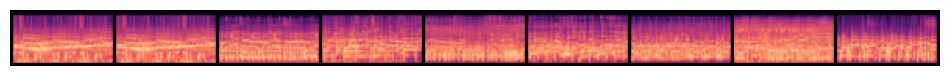

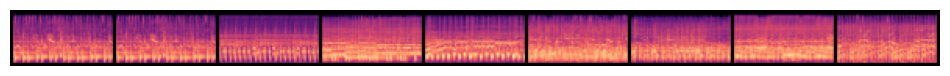

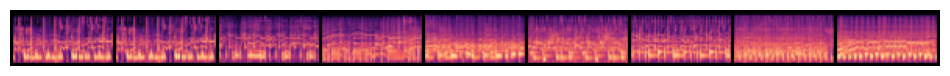

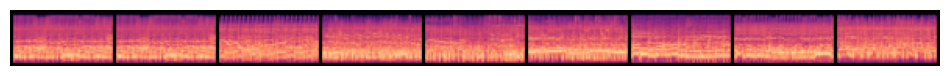

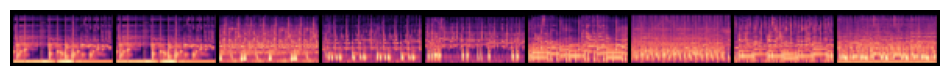

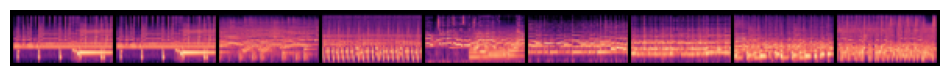

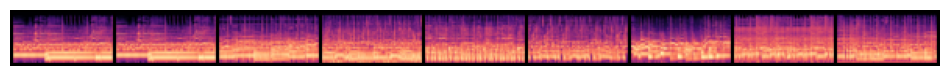

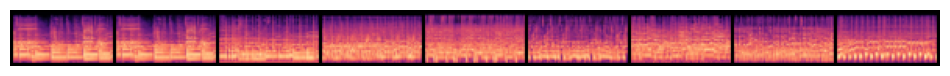

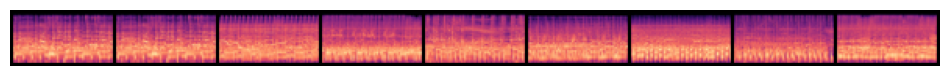

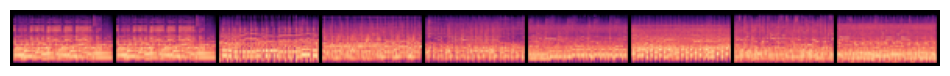

In [90]:
for i in range(10):
    find_similiar_images(val_img_embeds[0][i + 50], val_img_embeds[1][i + 50], key_embeds=val_img_embeds)

### Tensorboard clustering

In [ ]:
writer = SummaryWriter('tensorboard/')

img_embeds_len = len(train_img_embeds[0])

writer.add_embedding(
    train_img_embeds[1][:img_embeds_len],
    metadata=[feature_dataset[i][1] for i in range(img_embeds_len)],
    label_img=(train_img_embeds[0][:img_embeds_len] + 1) / 2.0
)

In [ ]:
%tensorboard --logdir tensorboard/

### Test on MNIST dataset

In [345]:
from torchvision.datasets import MNIST
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

#### Prepare data for training

In [88]:
mnist_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train_df = MNIST('../datasets/MNIST', train=True, download=True, transform=mnist_transform)
mnist_test_df = MNIST('../datasets/MNIST', train=False, transform=mnist_transform)

mnist_train_loader = data.DataLoader(mnist_train_df, batch_size=64, num_workers=8, pin_memory=True, shuffle=True, persistent_workers=True)
mnist_val_loader = data.DataLoader(mnist_test_df, batch_size=1000, num_workers=11, pin_memory=True, shuffle=False, persistent_workers=True)

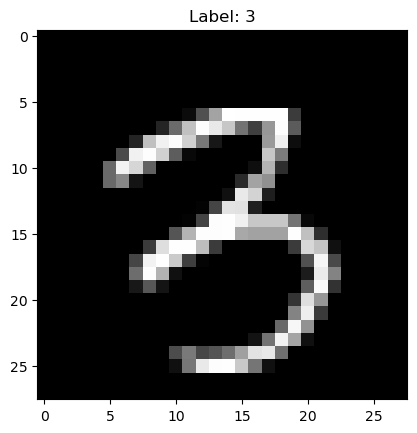

In [268]:
def plot_image(image, mean=0.1307, std=0.3081):
    # Select the first image in the batch

    # The image tensor is normalized, so we need to unnormalize it before displaying
    mean = mean
    std = std
    image = image * std + mean

    # Convert the tensor to a NumPy array and squeeze the channel dimension
    image = image.numpy().squeeze()

    # Plot the image using matplotlib
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {labels[0].item()}')
    plt.show()
    
    
data_iter = iter(mnist_train_loader)
images, labels = next(data_iter)
image = images[0]
    
plot_image(image)

### Train

In [261]:
mnist_ae = Autoencoder(num_input_channels=1, base_channel_size=32, latent_dim=10, width=28, height=28)
mnist_ae.to(device)

mnist_trainer = pl.Trainer(max_epochs=10)
mnist_trainer.fit(mnist_ae, mnist_train_loader, mnist_val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 137 K  | [2, 1, 28, 28] | [2, 10]       
1 | decoder | Decoder | 138 K  | [2, 10]        | [2, 1, 28, 28]
----------------------------------------------------------------------
275 K     Trainable params
0         Non-trainable params
275 K     Total params
1.104     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.9563536047935486
1 loss = 0.9307740926742554


Training: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.985483705997467
1 loss = 0.9842288494110107
1 loss = 1.0035382509231567
1 loss = 1.001334309577942
1 loss = 0.9413744807243347
1 loss = 0.9015043377876282
1 loss = 0.8152965307235718
1 loss = 0.8506643772125244
1 loss = 0.746479868888855
1 loss = 0.7310338616371155
1 loss = 0.7028613090515137
1 loss = 0.6693272590637207
1 loss = 0.6991318464279175
1 loss = 0.7225067019462585
1 loss = 0.6834112405776978
1 loss = 0.7249287962913513
1 loss = 0.7331483364105225
1 loss = 0.7580966353416443
1 loss = 0.6751391291618347
1 loss = 0.6759830117225647
1 loss = 0.7013161182403564
1 loss = 0.6933320164680481
1 loss = 0.7184692621231079
1 loss = 0.7110475897789001
1 loss = 0.7197734117507935
1 loss = 0.6327493786811829
1 loss = 0.6988655924797058
1 loss = 0.7107074856758118
1 loss = 0.6744924783706665
1 loss = 0.6939564943313599
1 loss = 0.6603587865829468
1 loss = 0.6645292639732361
1 loss = 0.6343473196029663
1 loss = 0.6021930575370789
1 loss = 0.6077085733413696
1 loss = 0.645140290260

1 loss = 0.2642241418361664
1 loss = 0.2290177345275879
1 loss = 0.24715855717658997
1 loss = 0.22805260121822357
1 loss = 0.23284977674484253
1 loss = 0.23022998869419098
1 loss = 0.2010834664106369
1 loss = 0.22001546621322632
1 loss = 0.24087463319301605
1 loss = 0.21670293807983398
1 loss = 0.22496339678764343
1 loss = 0.257934033870697
1 loss = 0.2293362021446228
1 loss = 0.2025052309036255
1 loss = 0.23403052985668182
1 loss = 0.24484528601169586
1 loss = 0.22091515362262726
1 loss = 0.23408739268779755
1 loss = 0.23745699226856232
1 loss = 0.21992629766464233
1 loss = 0.22487732768058777
1 loss = 0.2184194177389145
1 loss = 0.20309588313102722
1 loss = 0.2143564373254776
1 loss = 0.21826088428497314
1 loss = 0.21679289638996124
1 loss = 0.21873055398464203
1 loss = 0.23949217796325684
1 loss = 0.22104749083518982
1 loss = 0.21615958213806152
1 loss = 0.22976025938987732
1 loss = 0.2255876064300537
1 loss = 0.2036563903093338
1 loss = 0.2066912055015564
1 loss = 0.220669999718666

1 loss = 0.19289705157279968
1 loss = 0.2011275291442871
1 loss = 0.18408368527889252
1 loss = 0.20323874056339264
1 loss = 0.18206821382045746
1 loss = 0.19790767133235931
1 loss = 0.2000313103199005
1 loss = 0.19086195528507233
1 loss = 0.20540302991867065
1 loss = 0.21112468838691711
1 loss = 0.19651611149311066
1 loss = 0.19296357035636902
1 loss = 0.20241372287273407
1 loss = 0.18758906424045563
1 loss = 0.1908443123102188
1 loss = 0.20896190404891968
1 loss = 0.17071369290351868
1 loss = 0.19689004123210907
1 loss = 0.1671193391084671
1 loss = 0.19592440128326416
1 loss = 0.177664652466774
1 loss = 0.16947411000728607
1 loss = 0.19431203603744507
1 loss = 0.20304764807224274
1 loss = 0.15519733726978302
1 loss = 0.17919228971004486
1 loss = 0.1937994360923767
1 loss = 0.17451980710029602
1 loss = 0.19444110989570618
1 loss = 0.19503574073314667
1 loss = 0.18611688911914825
1 loss = 0.1892329454421997
1 loss = 0.19160698354244232
1 loss = 0.20643644034862518
1 loss = 0.16531826555

1 loss = 0.16406789422035217
1 loss = 0.1609218865633011
1 loss = 0.18325616419315338
1 loss = 0.1701955497264862
1 loss = 0.1605682373046875
1 loss = 0.1932993084192276
1 loss = 0.17144082486629486
1 loss = 0.1609707474708557
1 loss = 0.1746068298816681
1 loss = 0.18301481008529663
1 loss = 0.1732935905456543
1 loss = 0.17192478477954865
1 loss = 0.18655146658420563
1 loss = 0.17519277334213257
1 loss = 0.17059580981731415
1 loss = 0.1930961310863495
1 loss = 0.17636562883853912
1 loss = 0.17924082279205322
1 loss = 0.15414030849933624
1 loss = 0.16382554173469543
1 loss = 0.18731479346752167
1 loss = 0.18789851665496826
1 loss = 0.19241854548454285
1 loss = 0.16441531479358673
1 loss = 0.1612759530544281
1 loss = 0.18778330087661743
1 loss = 0.1628054976463318
1 loss = 0.17352622747421265
1 loss = 0.1884332299232483
1 loss = 0.17305083572864532
1 loss = 0.1956656277179718
1 loss = 0.1808517575263977
1 loss = 0.20040825009346008
1 loss = 0.16821958124637604
1 loss = 0.1683942973613739

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.16874873638153076
1 loss = 0.1720118373632431
1 loss = 0.17022117972373962
1 loss = 0.17102889716625214
1 loss = 0.1679602712392807
1 loss = 0.16790038347244263
1 loss = 0.16678032279014587
1 loss = 0.1636795997619629
1 loss = 0.16641244292259216
1 loss = 0.17589014768600464
1 loss = 0.15882720053195953
1 loss = 0.17114697396755219
1 loss = 0.1688910871744156
1 loss = 0.1833973526954651
1 loss = 0.19034825265407562
1 loss = 0.18467353284358978
1 loss = 0.19148097932338715
1 loss = 0.16534830629825592
1 loss = 0.18619728088378906
1 loss = 0.17241767048835754
1 loss = 0.17188100516796112
1 loss = 0.16919898986816406
1 loss = 0.13708117604255676
1 loss = 0.17528581619262695
1 loss = 0.1652221381664276
1 loss = 0.18742448091506958
1 loss = 0.18871793150901794
1 loss = 0.1809055209159851
1 loss = 0.15540651977062225
1 loss = 0.17073723673820496
1 loss = 0.18452607095241547
1 loss = 0.17061609029769897
1 loss = 0.16521219909191132
1 loss = 0.15506727993488312
1 loss = 0.1834938228

1 loss = 0.1565462201833725
1 loss = 0.17726513743400574
1 loss = 0.17144186794757843
1 loss = 0.16429808735847473
1 loss = 0.1621113270521164
1 loss = 0.15873977541923523
1 loss = 0.1778254210948944
1 loss = 0.15724395215511322
1 loss = 0.17778964340686798
1 loss = 0.1740313172340393
1 loss = 0.16789984703063965
1 loss = 0.15605175495147705
1 loss = 0.16431407630443573
1 loss = 0.17584717273712158
1 loss = 0.15448395907878876
1 loss = 0.17404456436634064
1 loss = 0.15313121676445007
1 loss = 0.1771451234817505
1 loss = 0.17498862743377686
1 loss = 0.16317218542099
1 loss = 0.16018526256084442
1 loss = 0.16885721683502197
1 loss = 0.17025642096996307
1 loss = 0.15232357382774353
1 loss = 0.1575298011302948
1 loss = 0.14835993945598602
1 loss = 0.1451575607061386
1 loss = 0.16387073695659637
1 loss = 0.1351262480020523
1 loss = 0.1637730896472931
1 loss = 0.16304953396320343
1 loss = 0.15468549728393555
1 loss = 0.14284969866275787
1 loss = 0.1826634258031845
1 loss = 0.1570997238159179

1 loss = 0.16090057790279388
1 loss = 0.14664728939533234
1 loss = 0.1624920815229416
1 loss = 0.16634593904018402
1 loss = 0.15907767415046692
1 loss = 0.1515962779521942
1 loss = 0.1555558741092682
1 loss = 0.1475173532962799
1 loss = 0.16558046638965607
1 loss = 0.13947303593158722
1 loss = 0.17381231486797333
1 loss = 0.15623918175697327
1 loss = 0.1662444770336151
1 loss = 0.1531386375427246
1 loss = 0.15747244656085968
1 loss = 0.1740589439868927
1 loss = 0.16612525284290314
1 loss = 0.16031964123249054
1 loss = 0.15878011286258698
1 loss = 0.1638326346874237
1 loss = 0.14671102166175842
1 loss = 0.16315671801567078
1 loss = 0.15221187472343445
1 loss = 0.1701846718788147
1 loss = 0.14016132056713104
1 loss = 0.1821194291114807
1 loss = 0.1461552530527115
1 loss = 0.13774999976158142
1 loss = 0.16869525611400604
1 loss = 0.15039211511611938
1 loss = 0.18237464129924774
1 loss = 0.1770651489496231
1 loss = 0.15174095332622528
1 loss = 0.17288079857826233
1 loss = 0.151391729712486

1 loss = 0.15997743606567383
1 loss = 0.15732000768184662
1 loss = 0.15052001178264618
1 loss = 0.15834206342697144
1 loss = 0.15486593544483185
1 loss = 0.14256054162979126
1 loss = 0.15305931866168976
1 loss = 0.14175337553024292
1 loss = 0.1530703455209732
1 loss = 0.14326100051403046
1 loss = 0.17370887100696564
1 loss = 0.16219007968902588
1 loss = 0.1341061294078827
1 loss = 0.16208337247371674
1 loss = 0.17493952810764313
1 loss = 0.13796648383140564
1 loss = 0.16689248383045197
1 loss = 0.15968464314937592
1 loss = 0.16351325809955597
1 loss = 0.17970459163188934
1 loss = 0.12277228385210037
1 loss = 0.15911541879177094
1 loss = 0.15758898854255676
1 loss = 0.16326738893985748
1 loss = 0.14574413001537323
1 loss = 0.1395888328552246
1 loss = 0.15295590460300446
1 loss = 0.1466054618358612
1 loss = 0.1458643227815628
1 loss = 0.14771270751953125
1 loss = 0.14814350008964539
1 loss = 0.1400202214717865
1 loss = 0.1505659520626068
1 loss = 0.14530611038208008
1 loss = 0.1600468307

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.15030324459075928
1 loss = 0.15526995062828064
1 loss = 0.15221691131591797
1 loss = 0.15317779779434204
1 loss = 0.1509818136692047
1 loss = 0.15148639678955078
1 loss = 0.14897707104682922
1 loss = 0.14426486194133759
1 loss = 0.15194222331047058
1 loss = 0.15781046450138092
1 loss = 0.17401571571826935
1 loss = 0.14625725150108337
1 loss = 0.14235104620456696
1 loss = 0.1435316801071167
1 loss = 0.14370529353618622
1 loss = 0.14619944989681244
1 loss = 0.14034980535507202
1 loss = 0.1526266634464264
1 loss = 0.12414727360010147
1 loss = 0.133358895778656
1 loss = 0.1529473066329956
1 loss = 0.14284275472164154
1 loss = 0.14409248530864716
1 loss = 0.14340902864933014
1 loss = 0.1511843204498291
1 loss = 0.16257266700267792
1 loss = 0.1439356505870819
1 loss = 0.14991888403892517
1 loss = 0.13744086027145386
1 loss = 0.15564247965812683
1 loss = 0.14843040704727173
1 loss = 0.16532935202121735
1 loss = 0.1408500224351883
1 loss = 0.14500869810581207
1 loss = 0.150225400924

1 loss = 0.15378591418266296
1 loss = 0.15153896808624268
1 loss = 0.1455126702785492
1 loss = 0.1509137749671936
1 loss = 0.16578692197799683
1 loss = 0.15707816183567047
1 loss = 0.15756919980049133
1 loss = 0.16014137864112854
1 loss = 0.15378189086914062
1 loss = 0.14585711061954498
1 loss = 0.14595410227775574
1 loss = 0.15659993886947632
1 loss = 0.1307903230190277
1 loss = 0.14095312356948853
1 loss = 0.16660280525684357
1 loss = 0.14998950064182281
1 loss = 0.16723644733428955
1 loss = 0.15766139328479767
1 loss = 0.1372823715209961
1 loss = 0.1478946954011917
1 loss = 0.14322493970394135
1 loss = 0.15743102133274078
1 loss = 0.1515108346939087
1 loss = 0.1561487317085266
1 loss = 0.14028091728687286
1 loss = 0.15013116598129272
1 loss = 0.15346510708332062
1 loss = 0.14311684668064117
1 loss = 0.17518985271453857
1 loss = 0.15470604598522186
1 loss = 0.15752334892749786
1 loss = 0.16544248163700104
1 loss = 0.1554577648639679
1 loss = 0.13023324310779572
1 loss = 0.15960091352

1 loss = 0.13709120452404022
1 loss = 0.14899197220802307
1 loss = 0.16208815574645996
1 loss = 0.13974672555923462
1 loss = 0.15860949456691742
1 loss = 0.13943126797676086
1 loss = 0.14641761779785156
1 loss = 0.13013318181037903
1 loss = 0.14407621324062347
1 loss = 0.13511568307876587
1 loss = 0.14376312494277954
1 loss = 0.14585526287555695
1 loss = 0.12992027401924133
1 loss = 0.14259032905101776
1 loss = 0.1449967324733734
1 loss = 0.1584187150001526
1 loss = 0.16986936330795288
1 loss = 0.14983542263507843
1 loss = 0.13476906716823578
1 loss = 0.15393248200416565
1 loss = 0.14850954711437225
1 loss = 0.14400535821914673
1 loss = 0.16910770535469055
1 loss = 0.1468232423067093
1 loss = 0.15887613594532013
1 loss = 0.17432901263237
1 loss = 0.14314870536327362
1 loss = 0.15909899771213531
1 loss = 0.14534558355808258
1 loss = 0.1401466578245163
1 loss = 0.15370669960975647
1 loss = 0.1528315395116806
1 loss = 0.1313076764345169
1 loss = 0.1402098834514618
1 loss = 0.1382608264684

1 loss = 0.1531200408935547
1 loss = 0.15119095146656036
1 loss = 0.16138489544391632
1 loss = 0.14093096554279327
1 loss = 0.1301511973142624
1 loss = 0.13732124865055084
1 loss = 0.13880512118339539
1 loss = 0.13307005167007446
1 loss = 0.16046510636806488
1 loss = 0.14709731936454773
1 loss = 0.14576475322246552
1 loss = 0.13075248897075653
1 loss = 0.1449289321899414
1 loss = 0.1326264590024948
1 loss = 0.13351307809352875
1 loss = 0.1595434844493866
1 loss = 0.1468917429447174
1 loss = 0.13251231610774994
1 loss = 0.13643969595432281
1 loss = 0.15197283029556274
1 loss = 0.13130563497543335
1 loss = 0.13787941634655
1 loss = 0.13063666224479675
1 loss = 0.15238939225673676
1 loss = 0.14737676084041595
1 loss = 0.14272642135620117
1 loss = 0.12754826247692108
1 loss = 0.14769934117794037
1 loss = 0.14598597586154938
1 loss = 0.1327541470527649
1 loss = 0.15470683574676514
1 loss = 0.15357276797294617
1 loss = 0.15768547356128693
1 loss = 0.15461410582065582
1 loss = 0.1607665270566

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.14071199297904968
1 loss = 0.14526811242103577
1 loss = 0.14224864542484283
1 loss = 0.14419162273406982
1 loss = 0.14194251596927643
1 loss = 0.13991720974445343
1 loss = 0.13796107470989227
1 loss = 0.13212120532989502
1 loss = 0.13971653580665588
1 loss = 0.14742040634155273
1 loss = 0.14822527766227722
1 loss = 0.15590441226959229
1 loss = 0.14704929292201996
1 loss = 0.14365991950035095
1 loss = 0.1452239602804184
1 loss = 0.12851476669311523
1 loss = 0.13312877714633942
1 loss = 0.14886164665222168
1 loss = 0.13693420588970184
1 loss = 0.14276036620140076
1 loss = 0.14546877145767212
1 loss = 0.14694760739803314
1 loss = 0.13778521120548248
1 loss = 0.1329403668642044
1 loss = 0.14283598959445953
1 loss = 0.15786676108837128
1 loss = 0.12736926972866058
1 loss = 0.13769762217998505
1 loss = 0.14944489300251007
1 loss = 0.14070843160152435
1 loss = 0.13660916686058044
1 loss = 0.14797426760196686
1 loss = 0.1342824548482895
1 loss = 0.12680888175964355
1 loss = 0.137584

1 loss = 0.1395350992679596
1 loss = 0.13115552067756653
1 loss = 0.12308111041784286
1 loss = 0.1377529352903366
1 loss = 0.14145833253860474
1 loss = 0.1478605568408966
1 loss = 0.13910162448883057
1 loss = 0.12176844477653503
1 loss = 0.14287416636943817
1 loss = 0.1457485854625702
1 loss = 0.15710648894309998
1 loss = 0.14270031452178955
1 loss = 0.1373620331287384
1 loss = 0.1396781951189041
1 loss = 0.1429952085018158
1 loss = 0.1356261670589447
1 loss = 0.1434134542942047
1 loss = 0.15004925429821014
1 loss = 0.13920891284942627
1 loss = 0.14432744681835175
1 loss = 0.16606439650058746
1 loss = 0.15592053532600403
1 loss = 0.13024713099002838
1 loss = 0.1372068077325821
1 loss = 0.1298600733280182
1 loss = 0.14584912359714508
1 loss = 0.13049106299877167
1 loss = 0.14379213750362396
1 loss = 0.14203713834285736
1 loss = 0.1451970636844635
1 loss = 0.1494939923286438
1 loss = 0.12553620338439941
1 loss = 0.15707148611545563
1 loss = 0.16530267894268036
1 loss = 0.1195970550179481

1 loss = 0.123246930539608
1 loss = 0.15338370203971863
1 loss = 0.1601291447877884
1 loss = 0.1621508002281189
1 loss = 0.13975000381469727
1 loss = 0.16298668086528778
1 loss = 0.13043227791786194
1 loss = 0.14146892726421356
1 loss = 0.14228595793247223
1 loss = 0.13063667714595795
1 loss = 0.14148764312267303
1 loss = 0.1250293254852295
1 loss = 0.13650915026664734
1 loss = 0.13424405455589294
1 loss = 0.13550709187984467
1 loss = 0.13764257729053497
1 loss = 0.13760323822498322
1 loss = 0.1270105093717575
1 loss = 0.14363126456737518
1 loss = 0.12287690490484238
1 loss = 0.1484442502260208
1 loss = 0.1432959884405136
1 loss = 0.14164835214614868
1 loss = 0.13479194045066833
1 loss = 0.15103986859321594
1 loss = 0.12766925990581512
1 loss = 0.14301304519176483
1 loss = 0.13255104422569275
1 loss = 0.13750727474689484
1 loss = 0.14000657200813293
1 loss = 0.11578439176082611
1 loss = 0.14020156860351562
1 loss = 0.1254062056541443
1 loss = 0.12393394857645035
1 loss = 0.142622902989

1 loss = 0.11957380175590515
1 loss = 0.12755310535430908
1 loss = 0.13743367791175842
1 loss = 0.15026123821735382
1 loss = 0.1408265084028244
1 loss = 0.14316998422145844
1 loss = 0.13779208064079285
1 loss = 0.14431150257587433
1 loss = 0.1340509057044983
1 loss = 0.1405981183052063
1 loss = 0.1431245356798172
1 loss = 0.14212219417095184
1 loss = 0.13876760005950928
1 loss = 0.13848046958446503
1 loss = 0.1454242318868637
1 loss = 0.11629115790128708
1 loss = 0.15447749197483063
1 loss = 0.13716888427734375
1 loss = 0.13641826808452606
1 loss = 0.143990159034729
1 loss = 0.12696129083633423
1 loss = 0.1293213665485382
1 loss = 0.13548782467842102
1 loss = 0.1614299714565277
1 loss = 0.13754750788211823
1 loss = 0.14857877790927887
1 loss = 0.12670768797397614
1 loss = 0.14891788363456726
1 loss = 0.13673962652683258
1 loss = 0.12082338333129883
1 loss = 0.14006327092647552
1 loss = 0.13401275873184204
1 loss = 0.13461290299892426
1 loss = 0.12338830530643463
1 loss = 0.138133808970

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.1348833441734314
1 loss = 0.13925930857658386
1 loss = 0.13671116530895233
1 loss = 0.13855969905853271
1 loss = 0.13642212748527527
1 loss = 0.1352827250957489
1 loss = 0.13395439088344574
1 loss = 0.12725834548473358
1 loss = 0.13597068190574646
1 loss = 0.1409214586019516
1 loss = 0.13678744435310364
1 loss = 0.1025247722864151
1 loss = 0.13133683800697327
1 loss = 0.12449850142002106
1 loss = 0.1330483853816986
1 loss = 0.14735567569732666
1 loss = 0.13853813707828522
1 loss = 0.14239215850830078
1 loss = 0.1257518082857132
1 loss = 0.13730375468730927
1 loss = 0.12845607101917267
1 loss = 0.14041101932525635
1 loss = 0.13033436238765717
1 loss = 0.13199520111083984
1 loss = 0.13398732244968414
1 loss = 0.12576548755168915
1 loss = 0.11689697951078415
1 loss = 0.13951116800308228
1 loss = 0.12922082841396332
1 loss = 0.14546924829483032
1 loss = 0.13472706079483032
1 loss = 0.1436629593372345
1 loss = 0.13307955861091614
1 loss = 0.13760851323604584
1 loss = 0.1361323446

1 loss = 0.11610116809606552
1 loss = 0.13356536626815796
1 loss = 0.13099747896194458
1 loss = 0.13537189364433289
1 loss = 0.135505810379982
1 loss = 0.12631048262119293
1 loss = 0.1357399821281433
1 loss = 0.144175186753273
1 loss = 0.13849884271621704
1 loss = 0.13640111684799194
1 loss = 0.13097842037677765
1 loss = 0.1416018009185791
1 loss = 0.14703775942325592
1 loss = 0.14249123632907867
1 loss = 0.13667617738246918
1 loss = 0.14875222742557526
1 loss = 0.12652921676635742
1 loss = 0.13779707252979279
1 loss = 0.15277723968029022
1 loss = 0.1504480242729187
1 loss = 0.12279170006513596
1 loss = 0.11760000884532928
1 loss = 0.1354067027568817
1 loss = 0.13259552419185638
1 loss = 0.13333430886268616
1 loss = 0.12606145441532135
1 loss = 0.12028414011001587
1 loss = 0.1370375156402588
1 loss = 0.12701819837093353
1 loss = 0.14406362175941467
1 loss = 0.15159034729003906
1 loss = 0.12185684591531754
1 loss = 0.12631885707378387
1 loss = 0.1491887867450714
1 loss = 0.1167043372988

1 loss = 0.14251570403575897
1 loss = 0.12128614634275436
1 loss = 0.15158550441265106
1 loss = 0.1368890404701233
1 loss = 0.13340440392494202
1 loss = 0.13449905812740326
1 loss = 0.12267662584781647
1 loss = 0.13946782052516937
1 loss = 0.14007799327373505
1 loss = 0.12855681777000427
1 loss = 0.13498514890670776
1 loss = 0.1440003365278244
1 loss = 0.14091211557388306
1 loss = 0.13596561551094055
1 loss = 0.13336299359798431
1 loss = 0.12148826569318771
1 loss = 0.1396775245666504
1 loss = 0.14122870564460754
1 loss = 0.1256948709487915
1 loss = 0.1460096389055252
1 loss = 0.14598891139030457
1 loss = 0.14127086102962494
1 loss = 0.1336507797241211
1 loss = 0.13315968215465546
1 loss = 0.11702620983123779
1 loss = 0.14998725056648254
1 loss = 0.13215705752372742
1 loss = 0.1406186819076538
1 loss = 0.13921791315078735
1 loss = 0.13723856210708618
1 loss = 0.1454630196094513
1 loss = 0.13689474761486053
1 loss = 0.14079709351062775
1 loss = 0.1526617556810379
1 loss = 0.125301018357

1 loss = 0.13676035404205322
1 loss = 0.14110304415225983
1 loss = 0.14690887928009033
1 loss = 0.1315097212791443
1 loss = 0.12574920058250427
1 loss = 0.12942078709602356
1 loss = 0.1271517127752304
1 loss = 0.11929379403591156
1 loss = 0.1278393566608429
1 loss = 0.14227654039859772
1 loss = 0.13926397264003754
1 loss = 0.13997383415699005
1 loss = 0.11573026329278946
1 loss = 0.12599705159664154
1 loss = 0.10814785957336426
1 loss = 0.14657916128635406
1 loss = 0.13532420992851257
1 loss = 0.12794236838817596
1 loss = 0.1485195904970169
1 loss = 0.12836718559265137
1 loss = 0.12206090986728668
1 loss = 0.14583614468574524
1 loss = 0.13969098031520844
1 loss = 0.12577103078365326
1 loss = 0.12086956948041916
1 loss = 0.13414034247398376
1 loss = 0.11365620046854019
1 loss = 0.13472478091716766
1 loss = 0.13640572130680084
1 loss = 0.12097206711769104
1 loss = 0.13870950043201447
1 loss = 0.14575108885765076
1 loss = 0.13360802829265594
1 loss = 0.13763856887817383
1 loss = 0.1436970

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.13145634531974792
1 loss = 0.13595972955226898
1 loss = 0.13295742869377136
1 loss = 0.13490577042102814
1 loss = 0.13269585371017456
1 loss = 0.1301703155040741
1 loss = 0.12935031950473785
1 loss = 0.12129240483045578
1 loss = 0.1286759227514267
1 loss = 0.13715890049934387
1 loss = 0.12472888827323914
1 loss = 0.12332180142402649
1 loss = 0.11899515986442566
1 loss = 0.12004958093166351
1 loss = 0.12890926003456116
1 loss = 0.13334518671035767
1 loss = 0.12733763456344604
1 loss = 0.12956850230693817
1 loss = 0.12062905728816986
1 loss = 0.13934586942195892
1 loss = 0.1285950392484665
1 loss = 0.13079403340816498
1 loss = 0.1254853904247284
1 loss = 0.1382693648338318
1 loss = 0.11913366615772247
1 loss = 0.12235460430383682
1 loss = 0.11852551996707916
1 loss = 0.12405812740325928
1 loss = 0.12063012272119522
1 loss = 0.11578760296106339
1 loss = 0.1275097131729126
1 loss = 0.13342240452766418
1 loss = 0.14109408855438232
1 loss = 0.12296281009912491
1 loss = 0.121095195

1 loss = 0.1347825676202774
1 loss = 0.12727797031402588
1 loss = 0.141488716006279
1 loss = 0.12831918895244598
1 loss = 0.13478711247444153
1 loss = 0.14570604264736176
1 loss = 0.13815131783485413
1 loss = 0.13813559710979462
1 loss = 0.1305413842201233
1 loss = 0.14535324275493622
1 loss = 0.12391307950019836
1 loss = 0.11067748069763184
1 loss = 0.12178634852170944
1 loss = 0.112615667283535
1 loss = 0.13840065896511078
1 loss = 0.12209960073232651
1 loss = 0.13480067253112793
1 loss = 0.10715068131685257
1 loss = 0.14107026159763336
1 loss = 0.12643586099147797
1 loss = 0.12753400206565857
1 loss = 0.127306267619133
1 loss = 0.1171257421374321
1 loss = 0.14427725970745087
1 loss = 0.12954162061214447
1 loss = 0.13089726865291595
1 loss = 0.14304764568805695
1 loss = 0.13602733612060547
1 loss = 0.12070883065462112
1 loss = 0.12766191363334656
1 loss = 0.1272597312927246
1 loss = 0.13173261284828186
1 loss = 0.11716122180223465
1 loss = 0.11873194575309753
1 loss = 0.1279507875442

1 loss = 0.12529854476451874
1 loss = 0.12269062548875809
1 loss = 0.12710152566432953
1 loss = 0.1183503195643425
1 loss = 0.13081297278404236
1 loss = 0.12516668438911438
1 loss = 0.12749944627285004
1 loss = 0.1357840746641159
1 loss = 0.1167750358581543
1 loss = 0.14052720367908478
1 loss = 0.11471578478813171
1 loss = 0.1348617672920227
1 loss = 0.12342189997434616
1 loss = 0.14034149050712585
1 loss = 0.13121077418327332
1 loss = 0.11701364815235138
1 loss = 0.12320242077112198
1 loss = 0.11644771695137024
1 loss = 0.13366089761257172
1 loss = 0.1473388373851776
1 loss = 0.11178001016378403
1 loss = 0.15291084349155426
1 loss = 0.13420018553733826
1 loss = 0.1038319543004036
1 loss = 0.10477575659751892
1 loss = 0.1283770203590393
1 loss = 0.13016900420188904
1 loss = 0.1494215428829193
1 loss = 0.12726901471614838
1 loss = 0.12099069356918335
1 loss = 0.13685795664787292
1 loss = 0.13032490015029907
1 loss = 0.1284932941198349
1 loss = 0.11348860710859299
1 loss = 0.131044179201

1 loss = 0.12946046888828278
1 loss = 0.12709088623523712
1 loss = 0.14542536437511444
1 loss = 0.13026459515094757
1 loss = 0.12966664135456085
1 loss = 0.1337020844221115
1 loss = 0.14600250124931335
1 loss = 0.1406116932630539
1 loss = 0.12639059126377106
1 loss = 0.12902072072029114
1 loss = 0.1217738538980484
1 loss = 0.12554602324962616
1 loss = 0.12411319464445114
1 loss = 0.13952483236789703
1 loss = 0.12708033621311188
1 loss = 0.11963117867708206
1 loss = 0.14352698624134064
1 loss = 0.1255817413330078
1 loss = 0.14683659374713898
1 loss = 0.13326430320739746
1 loss = 0.12474626302719116
1 loss = 0.1316174864768982
1 loss = 0.13052892684936523
1 loss = 0.12324315309524536
1 loss = 0.12289177626371384
1 loss = 0.12145356833934784
1 loss = 0.11966019868850708
1 loss = 0.13857382535934448
1 loss = 0.12741822004318237
1 loss = 0.14404909312725067
1 loss = 0.13195444643497467
1 loss = 0.13603812456130981
1 loss = 0.12987716495990753
1 loss = 0.13796809315681458
1 loss = 0.12181641

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.12889701128005981
1 loss = 0.13301101326942444
1 loss = 0.12969762086868286
1 loss = 0.13202627003192902
1 loss = 0.13009609282016754
1 loss = 0.12722988426685333
1 loss = 0.1271316260099411
1 loss = 0.12009740620851517
1 loss = 0.1272779405117035
1 loss = 0.13506299257278442
1 loss = 0.1365572214126587
1 loss = 0.1334521323442459
1 loss = 0.138311505317688
1 loss = 0.12104292213916779
1 loss = 0.12451623380184174
1 loss = 0.1190212219953537
1 loss = 0.14284683763980865
1 loss = 0.12225465476512909
1 loss = 0.13136081397533417
1 loss = 0.11876662820577621
1 loss = 0.13743185997009277
1 loss = 0.13605493307113647
1 loss = 0.12156696617603302
1 loss = 0.1255771964788437
1 loss = 0.14870987832546234
1 loss = 0.12973041832447052
1 loss = 0.1254538744688034
1 loss = 0.13014335930347443
1 loss = 0.12140636146068573
1 loss = 0.11546214669942856
1 loss = 0.12073440849781036
1 loss = 0.13485971093177795
1 loss = 0.1463596671819687
1 loss = 0.12476298958063126
1 loss = 0.1276719272136

1 loss = 0.11572787165641785
1 loss = 0.14481496810913086
1 loss = 0.14039115607738495
1 loss = 0.11796914041042328
1 loss = 0.11606834828853607
1 loss = 0.11897824704647064
1 loss = 0.1182531788945198
1 loss = 0.1276881843805313
1 loss = 0.11654165387153625
1 loss = 0.11765611916780472
1 loss = 0.12788361310958862
1 loss = 0.11548268049955368
1 loss = 0.12401439249515533
1 loss = 0.1347845196723938
1 loss = 0.12182227522134781
1 loss = 0.12197273969650269
1 loss = 0.13795143365859985
1 loss = 0.1303117424249649
1 loss = 0.11185044795274734
1 loss = 0.12578372657299042
1 loss = 0.1265127956867218
1 loss = 0.14902295172214508
1 loss = 0.11215106397867203
1 loss = 0.12763284146785736
1 loss = 0.12712515890598297
1 loss = 0.1177840530872345
1 loss = 0.13502846658229828
1 loss = 0.1358087807893753
1 loss = 0.12456446141004562
1 loss = 0.11947957426309586
1 loss = 0.1256064921617508
1 loss = 0.12956640124320984
1 loss = 0.1129797101020813
1 loss = 0.12223580479621887
1 loss = 0.141594901680

1 loss = 0.12819482386112213
1 loss = 0.14334790408611298
1 loss = 0.14123763144016266
1 loss = 0.12138936668634415
1 loss = 0.12842999398708344
1 loss = 0.13465248048305511
1 loss = 0.12534083425998688
1 loss = 0.14446450769901276
1 loss = 0.13365614414215088
1 loss = 0.12750577926635742
1 loss = 0.1387973129749298
1 loss = 0.12850426137447357
1 loss = 0.13620950281620026
1 loss = 0.13314831256866455
1 loss = 0.11929859966039658
1 loss = 0.13333088159561157
1 loss = 0.12468250095844269
1 loss = 0.13114795088768005
1 loss = 0.12452676892280579
1 loss = 0.12132452428340912
1 loss = 0.14522160589694977
1 loss = 0.1344144195318222
1 loss = 0.13027340173721313
1 loss = 0.11375989764928818
1 loss = 0.12387876212596893
1 loss = 0.14241920411586761
1 loss = 0.1118093952536583
1 loss = 0.11609536409378052
1 loss = 0.1327318400144577
1 loss = 0.11747431755065918
1 loss = 0.12924031913280487
1 loss = 0.1381358653306961
1 loss = 0.11768107116222382
1 loss = 0.13349366188049316
1 loss = 0.11850738

1 loss = 0.12687133252620697
1 loss = 0.11535132676362991
1 loss = 0.12398873269557953
1 loss = 0.12809622287750244
1 loss = 0.12623150646686554
1 loss = 0.11453390121459961
1 loss = 0.11996190994977951
1 loss = 0.1335001140832901
1 loss = 0.12358155101537704
1 loss = 0.13037855923175812
1 loss = 0.10949120670557022
1 loss = 0.13602325320243835
1 loss = 0.12791550159454346
1 loss = 0.11957328021526337
1 loss = 0.11921986192464828
1 loss = 0.1059378907084465
1 loss = 0.13169139623641968
1 loss = 0.13527610898017883
1 loss = 0.11767439544200897
1 loss = 0.13559098541736603
1 loss = 0.13485553860664368
1 loss = 0.12332326918840408
1 loss = 0.10815353691577911
1 loss = 0.1370861977338791
1 loss = 0.12331943213939667
1 loss = 0.11638228595256805
1 loss = 0.12775658071041107
1 loss = 0.12944234907627106
1 loss = 0.1187809482216835
1 loss = 0.12143611907958984
1 loss = 0.13979488611221313
1 loss = 0.11516280472278595
1 loss = 0.13369852304458618
1 loss = 0.12482115626335144
1 loss = 0.1105092

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.127027228474617
1 loss = 0.13205432891845703
1 loss = 0.1279272437095642
1 loss = 0.1291789561510086
1 loss = 0.12735576927661896
1 loss = 0.1246669813990593
1 loss = 0.12435685843229294
1 loss = 0.1157727837562561
1 loss = 0.12380215525627136
1 loss = 0.13221029937267303
1 loss = 0.1264132410287857
1 loss = 0.1307823359966278
1 loss = 0.12919993698596954
1 loss = 0.14839717745780945
1 loss = 0.10437209904193878
1 loss = 0.12328661233186722
1 loss = 0.12623967230319977
1 loss = 0.12149330973625183
1 loss = 0.12034312635660172
1 loss = 0.11998483538627625
1 loss = 0.12984029948711395
1 loss = 0.1303367167711258
1 loss = 0.14370986819267273
1 loss = 0.10731863975524902
1 loss = 0.12237288057804108
1 loss = 0.13177058100700378
1 loss = 0.12559503316879272
1 loss = 0.12610368430614471
1 loss = 0.14150044322013855
1 loss = 0.11296591907739639
1 loss = 0.11749107390642166
1 loss = 0.12445881962776184
1 loss = 0.11329858750104904
1 loss = 0.11915652453899384
1 loss = 0.124755859375

1 loss = 0.12755711376667023
1 loss = 0.12825985252857208
1 loss = 0.13457609713077545
1 loss = 0.13275906443595886
1 loss = 0.1197720319032669
1 loss = 0.1191500723361969
1 loss = 0.12862376868724823
1 loss = 0.11513285338878632
1 loss = 0.1326051503419876
1 loss = 0.11952397227287292
1 loss = 0.1181301400065422
1 loss = 0.12997470796108246
1 loss = 0.13344858586788177
1 loss = 0.13174091279506683
1 loss = 0.1216205283999443
1 loss = 0.13587817549705505
1 loss = 0.10975031554698944
1 loss = 0.12284263223409653
1 loss = 0.11326131969690323
1 loss = 0.12539415061473846
1 loss = 0.12898389995098114
1 loss = 0.1236281469464302
1 loss = 0.11397701501846313
1 loss = 0.12103621661663055
1 loss = 0.12946689128875732
1 loss = 0.11771266162395477
1 loss = 0.12399651110172272
1 loss = 0.12181776016950607
1 loss = 0.12750765681266785
1 loss = 0.11709585040807724
1 loss = 0.128226175904274
1 loss = 0.11606758087873459
1 loss = 0.12272482365369797
1 loss = 0.12808077037334442
1 loss = 0.11480671167

1 loss = 0.10268920660018921
1 loss = 0.1349419504404068
1 loss = 0.12338985502719879
1 loss = 0.13554270565509796
1 loss = 0.12921550869941711
1 loss = 0.12937350571155548
1 loss = 0.10629899054765701
1 loss = 0.11677616834640503
1 loss = 0.12904983758926392
1 loss = 0.13004052639007568
1 loss = 0.11969295889139175
1 loss = 0.1347653716802597
1 loss = 0.11979059129953384
1 loss = 0.11389481276273727
1 loss = 0.1281142234802246
1 loss = 0.1409122496843338
1 loss = 0.11446724086999893
1 loss = 0.12518246471881866
1 loss = 0.1223466545343399
1 loss = 0.12052816897630692
1 loss = 0.1400335282087326
1 loss = 0.13065263628959656
1 loss = 0.14031194150447845
1 loss = 0.09804795682430267
1 loss = 0.11453258246183395
1 loss = 0.1171695813536644
1 loss = 0.12120043486356735
1 loss = 0.12368267774581909
1 loss = 0.1317579746246338
1 loss = 0.13262134790420532
1 loss = 0.11871154606342316
1 loss = 0.11838233470916748
1 loss = 0.11624190211296082
1 loss = 0.11377110332250595
1 loss = 0.12568241357

1 loss = 0.12036757171154022
1 loss = 0.13354215025901794
1 loss = 0.1328897476196289
1 loss = 0.11182436347007751
1 loss = 0.14184068143367767
1 loss = 0.11770830303430557
1 loss = 0.14156483113765717
1 loss = 0.13226987421512604
1 loss = 0.12829041481018066
1 loss = 0.1222907155752182
1 loss = 0.12059988081455231
1 loss = 0.13945744931697845
1 loss = 0.10693861544132233
1 loss = 0.12520229816436768
1 loss = 0.11958380788564682
1 loss = 0.11644014716148376
1 loss = 0.1266086846590042
1 loss = 0.104068323969841
1 loss = 0.14172063767910004
1 loss = 0.12261427193880081
1 loss = 0.13577844202518463
1 loss = 0.11264575272798538
1 loss = 0.12540078163146973
1 loss = 0.12081929296255112
1 loss = 0.12745748460292816
1 loss = 0.1200210228562355
1 loss = 0.11732733994722366
1 loss = 0.1085929423570633
1 loss = 0.12055356055498123
1 loss = 0.12228895723819733
1 loss = 0.10946760326623917
1 loss = 0.1128137931227684
1 loss = 0.13599881529808044
1 loss = 0.111330047249794
1 loss = 0.1215711683034

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.12545397877693176
1 loss = 0.1307753622531891
1 loss = 0.1265335977077484
1 loss = 0.12943187355995178
1 loss = 0.12768608331680298
1 loss = 0.12370970100164413
1 loss = 0.12289401888847351
1 loss = 0.1153029128909111
1 loss = 0.12212631851434708
1 loss = 0.13141018152236938
1 loss = 0.11431032419204712
1 loss = 0.1265202760696411
1 loss = 0.1264321655035019
1 loss = 0.11643168330192566
1 loss = 0.12459610402584076
1 loss = 0.10281897336244583
1 loss = 0.10857472568750381
1 loss = 0.12127987295389175
1 loss = 0.12556421756744385
1 loss = 0.13516920804977417
1 loss = 0.12296948581933975
1 loss = 0.11855113506317139
1 loss = 0.13594713807106018
1 loss = 0.12178119271993637
1 loss = 0.12018131464719772
1 loss = 0.11880609393119812
1 loss = 0.1275443434715271
1 loss = 0.12119725346565247
1 loss = 0.11877501755952835
1 loss = 0.10556618124246597
1 loss = 0.10646463930606842
1 loss = 0.1283639371395111
1 loss = 0.12946219742298126
1 loss = 0.1092342808842659
1 loss = 0.11533013731

1 loss = 0.12753771245479584
1 loss = 0.11305274814367294
1 loss = 0.10752038657665253
1 loss = 0.11745980381965637
1 loss = 0.12031079083681107
1 loss = 0.12779319286346436
1 loss = 0.122953400015831
1 loss = 0.11932506412267685
1 loss = 0.12051169574260712
1 loss = 0.11302313208580017
1 loss = 0.13571211695671082
1 loss = 0.1228250041604042
1 loss = 0.10385733097791672
1 loss = 0.13914476335048676
1 loss = 0.14392735064029694
1 loss = 0.13677358627319336
1 loss = 0.10686575621366501
1 loss = 0.10580039024353027
1 loss = 0.12948289513587952
1 loss = 0.12823164463043213
1 loss = 0.14232508838176727
1 loss = 0.1244218498468399
1 loss = 0.13211211562156677
1 loss = 0.1138535887002945
1 loss = 0.11491385847330093
1 loss = 0.1271091252565384
1 loss = 0.13805656135082245
1 loss = 0.11837141960859299
1 loss = 0.12466273456811905
1 loss = 0.1412438005208969
1 loss = 0.10605335235595703
1 loss = 0.12191025167703629
1 loss = 0.11874038726091385
1 loss = 0.1511221081018448
1 loss = 0.13653901219

1 loss = 0.11292880773544312
1 loss = 0.1152406856417656
1 loss = 0.106626957654953
1 loss = 0.1236104965209961
1 loss = 0.11110952496528625
1 loss = 0.13937819004058838
1 loss = 0.14543381333351135
1 loss = 0.10990779101848602
1 loss = 0.12899653613567352
1 loss = 0.11038659512996674
1 loss = 0.10402136296033859
1 loss = 0.12373664230108261
1 loss = 0.12633436918258667
1 loss = 0.12158191204071045
1 loss = 0.10656167566776276
1 loss = 0.11932314187288284
1 loss = 0.12179159373044968
1 loss = 0.11694449186325073
1 loss = 0.1068025454878807
1 loss = 0.11602339893579483
1 loss = 0.11104673892259598
1 loss = 0.1254468560218811
1 loss = 0.12134422361850739
1 loss = 0.11102911829948425
1 loss = 0.11721666157245636
1 loss = 0.10633742064237595
1 loss = 0.1245800033211708
1 loss = 0.12397560477256775
1 loss = 0.11580640077590942
1 loss = 0.11638183891773224
1 loss = 0.11908967047929764
1 loss = 0.13845054805278778
1 loss = 0.1272512674331665
1 loss = 0.1367100179195404
1 loss = 0.123327292501

1 loss = 0.1220782920718193
1 loss = 0.11623454093933105
1 loss = 0.12881365418434143
1 loss = 0.11680715531110764
1 loss = 0.12593528628349304
1 loss = 0.1260824054479599
1 loss = 0.11457748711109161
1 loss = 0.12040240317583084
1 loss = 0.11017975956201553
1 loss = 0.12141353636980057
1 loss = 0.12160250544548035
1 loss = 0.13735409080982208
1 loss = 0.13455389440059662
1 loss = 0.1077786311507225
1 loss = 0.1441705822944641
1 loss = 0.11693230271339417
1 loss = 0.11703114211559296
1 loss = 0.11702856421470642
1 loss = 0.12079108506441116
1 loss = 0.12389122694730759
1 loss = 0.11882275342941284
1 loss = 0.1288391351699829
1 loss = 0.1407885104417801
1 loss = 0.1391727328300476
1 loss = 0.1291513442993164
1 loss = 0.12306660413742065
1 loss = 0.12932483851909637
1 loss = 0.12460174411535263
1 loss = 0.11210136115550995
1 loss = 0.13170301914215088
1 loss = 0.11381073296070099
1 loss = 0.11177129298448563
1 loss = 0.12981027364730835
1 loss = 0.13610610365867615
1 loss = 0.11429567635

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.12279067188501358
1 loss = 0.12798428535461426
1 loss = 0.12476024031639099
1 loss = 0.12634828686714172
1 loss = 0.12383769452571869
1 loss = 0.1209203377366066
1 loss = 0.11988388746976852
1 loss = 0.11221726983785629
1 loss = 0.11962926387786865
1 loss = 0.1271573156118393
1 loss = 0.11769024282693863
1 loss = 0.11961572617292404
1 loss = 0.12675607204437256
1 loss = 0.1228589341044426
1 loss = 0.11688542366027832
1 loss = 0.14482811093330383
1 loss = 0.11690538376569748
1 loss = 0.11291826516389847
1 loss = 0.10271753370761871
1 loss = 0.11792513728141785
1 loss = 0.10660213232040405
1 loss = 0.11809158325195312
1 loss = 0.11193298548460007
1 loss = 0.12360022962093353
1 loss = 0.12453070282936096
1 loss = 0.11805224418640137
1 loss = 0.1341313272714615
1 loss = 0.1334526240825653
1 loss = 0.1274339109659195
1 loss = 0.12043696641921997
1 loss = 0.11402887105941772
1 loss = 0.12735915184020996
1 loss = 0.11879105120897293
1 loss = 0.12090733647346497
1 loss = 0.121641129

1 loss = 0.11777017265558243
1 loss = 0.11989044398069382
1 loss = 0.12126556783914566
1 loss = 0.1208617240190506
1 loss = 0.11254557222127914
1 loss = 0.12414202094078064
1 loss = 0.12395653128623962
1 loss = 0.1320619136095047
1 loss = 0.10900218784809113
1 loss = 0.12836407124996185
1 loss = 0.11736458539962769
1 loss = 0.1208488941192627
1 loss = 0.14541269838809967
1 loss = 0.11156760901212692
1 loss = 0.12114185839891434
1 loss = 0.13479185104370117
1 loss = 0.12810078263282776
1 loss = 0.12487419694662094
1 loss = 0.11889031529426575
1 loss = 0.12806685268878937
1 loss = 0.12471375614404678
1 loss = 0.12818317115306854
1 loss = 0.13422343134880066
1 loss = 0.13016988337039948
1 loss = 0.1162768006324768
1 loss = 0.11628111451864243
1 loss = 0.10622098296880722
1 loss = 0.11936218291521072
1 loss = 0.11571507155895233
1 loss = 0.11112391203641891
1 loss = 0.12908628582954407
1 loss = 0.12670664489269257
1 loss = 0.11784855276346207
1 loss = 0.11485075950622559
1 loss = 0.1338246

1 loss = 0.10549184679985046
1 loss = 0.10663364827632904
1 loss = 0.13405652344226837
1 loss = 0.12286753207445145
1 loss = 0.12208182364702225
1 loss = 0.1298760175704956
1 loss = 0.1269756257534027
1 loss = 0.12156807631254196
1 loss = 0.1350235491991043
1 loss = 0.12562908232212067
1 loss = 0.11583921313285828
1 loss = 0.1168128103017807
1 loss = 0.11532804369926453
1 loss = 0.13890177011489868
1 loss = 0.11818356066942215
1 loss = 0.13622590899467468
1 loss = 0.12801393866539001
1 loss = 0.11906576156616211
1 loss = 0.11047027260065079
1 loss = 0.10936196893453598
1 loss = 0.11561951786279678
1 loss = 0.11351281404495239
1 loss = 0.13887856900691986
1 loss = 0.11156202852725983
1 loss = 0.11996422708034515
1 loss = 0.11791824549436569
1 loss = 0.12486925721168518
1 loss = 0.12921780347824097
1 loss = 0.11958740651607513
1 loss = 0.12861621379852295
1 loss = 0.1268090009689331
1 loss = 0.10847169160842896
1 loss = 0.12328284978866577
1 loss = 0.10894639790058136
1 loss = 0.14202480

1 loss = 0.11834778636693954
1 loss = 0.1071338951587677
1 loss = 0.11939385533332825
1 loss = 0.12247271090745926
1 loss = 0.11290007084608078
1 loss = 0.1123555600643158
1 loss = 0.10985855013132095
1 loss = 0.10784369707107544
1 loss = 0.12040562182664871
1 loss = 0.11606977134943008
1 loss = 0.11142385751008987
1 loss = 0.11762108653783798
1 loss = 0.1070110946893692
1 loss = 0.12978748977184296
1 loss = 0.11222648620605469
1 loss = 0.11950573325157166
1 loss = 0.1343609094619751
1 loss = 0.12929008901119232
1 loss = 0.1163540855050087
1 loss = 0.11814887076616287
1 loss = 0.11653268337249756
1 loss = 0.13121305406093597
1 loss = 0.12454710155725479
1 loss = 0.10425568372011185
1 loss = 0.13531914353370667
1 loss = 0.10527606308460236
1 loss = 0.11934427917003632
1 loss = 0.11635297536849976
1 loss = 0.11958963423967361
1 loss = 0.13128133118152618
1 loss = 0.1134239062666893
1 loss = 0.11766993999481201
1 loss = 0.11759725958108902
1 loss = 0.11781606823205948
1 loss = 0.110630244

Validation: |          | 0/? [00:00<?, ?it/s]

1 loss = 0.12294743210077286
1 loss = 0.12718814611434937
1 loss = 0.12388639897108078
1 loss = 0.1252620369195938
1 loss = 0.1238536685705185
1 loss = 0.12223084270954132
1 loss = 0.12038320302963257
1 loss = 0.11213239282369614
1 loss = 0.11983665078878403
1 loss = 0.12773998081684113


`Trainer.fit` stopped: `max_epochs=10` reached.


### Check results

In [283]:
print(f"Final training loss: {mnist_trainer.callback_metrics['train_loss']}")
print(f"Final validation loss: {mnist_trainer.callback_metrics['val_loss']}")

Final training loss: 0.10992295295000076
Final validation loss: 0.12254606932401657


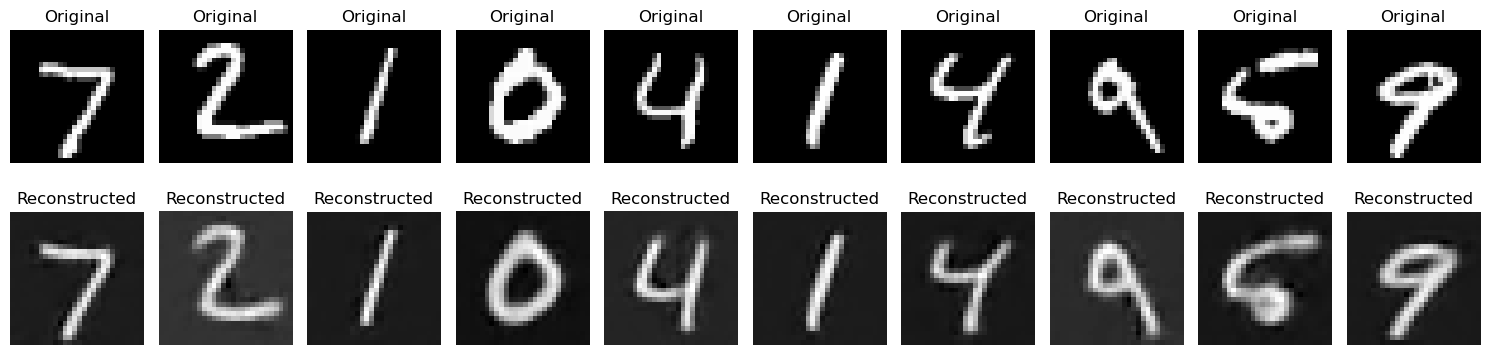

In [294]:
data_val_iter = iter(mnist_val_loader)
images, labels = next(data_val_iter)

images = images.to(device)

# Pass images through the autoencoder
with torch.no_grad():
    reconstructed_images = mnist_ae(images)

# Visualize original images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))

for idx in range(10):
    axes[0, idx].imshow(images[idx].squeeze().cpu(), cmap='gray')
    axes[0, idx].axis('off')
    axes[0, idx].set_title('Original')

    axes[1, idx].imshow(reconstructed_images[idx].squeeze().cpu(), cmap='gray')
    axes[1, idx].axis('off')
    axes[1, idx].set_title('Reconstructed')

plt.tight_layout()
plt.show()

### Cluster

In [309]:
def get_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            
            # Get embeddings from encoder
            z = model.encoder(images)
            
            embeddings.append(z.cpu().numpy())
            labels.append(targets.numpy())
    
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    
    return embeddings, labels

In [310]:
embeddings, true_labels = get_embeddings(mnist_ae, mnist_val_loader, device)
print(f"Shape of embeddings: {embeddings.shape}")
print(f"embeddings[0]: {embeddings[0]}")
print(f"labels: {true_labels}")

Shape of embeddings: (10000, 10)
embeddings[0]: [0.17732468 2.0873787  1.2903885  1.7119688  1.8408943  3.8136628
 2.6578777  5.901626   0.6517966  2.6583328 ]
labels: [7 2 1 ... 4 5 6]


In [306]:
# Number of clusters
num_clusters = 10

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
predicted_labels = kmeans.fit_predict(embeddings)

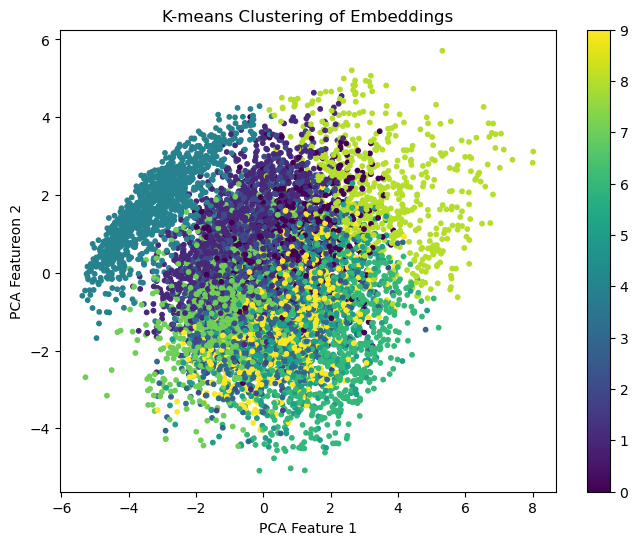

In [357]:
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar()
plt.title('K-means Clustering of Embeddings')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Featureon 2')
plt.show()

In [340]:
from scipy.optimize import linear_sum_assignment

def compute_cluster_purity(true_labels, predicted_labels, num_true_clusters, num_predicted_clusters):
    purity_matrix = np.zeros((num_true_clusters, num_predicted_clusters))

    for i in range(num_predicted_clusters):
        cluster_indices = np.where(predicted_labels == i)[0]
        cluster_true_labels = true_labels[cluster_indices]
        unique_true_labels, counts = np.unique(cluster_true_labels, return_counts=True)
        most_frequent_true_label = unique_true_labels[np.argmax(counts)]
        purity_matrix[most_frequent_true_label, i] = counts.max() / len(cluster_indices)

    return purity_matrix


def assign_clusters(true_labels, predicted_labels, num_true_clusters, num_predicted_clusters):
    purity_matrix = compute_cluster_purity(true_labels, predicted_labels, num_true_clusters, num_predicted_clusters)
    row_ind, col_ind = linear_sum_assignment(-purity_matrix)  # maximize the sum of purities

    cluster_mapping = {}
    for i, j in zip(row_ind, col_ind):
        cluster_mapping[j] = i

    return cluster_mapping


def map_clusters(predicted_labels, cluster_mapping):
    mapped_labels = np.zeros(len(predicted_labels))
    for predicted_cluster, true_cluster in cluster_mapping.items():
        mapped_labels[predicted_labels == predicted_cluster] = true_cluster
    return mapped_labels.astype(int)

In [344]:
cluster_mapping = assign_clusters(true_labels, predicted_labels, 10, 10)
mapped_labels = map_clusters(predicted_labels, cluster_mapping)

accuracy = accuracy_score(true_labels, mapped_labels)
print(f"Clustering Accuracy: {accuracy:.4f}")

nmi = normalized_mutual_info_score(true_labels, predicted_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Clustering Accuracy: 0.7542
Normalized Mutual Information (NMI): 0.6974
